## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (145, 145)
Hypercube shape: (145, 145, 200)


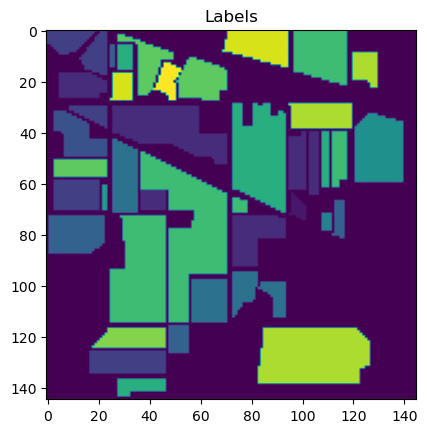

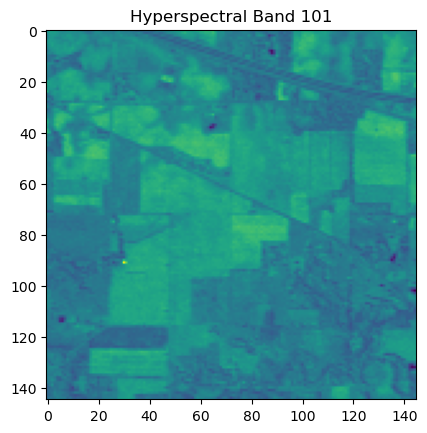

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'Indian_pines_gt.mat'
data_files = 'Indian_pines_corrected.mat'
label_files = 'indian_pines_gt'
hypercube_files = 'indian_pines_corrected'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 10249
Extracted windows shape: (10249, 5, 5, 200)
Corresponding labels shape: (10249,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 20)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 46 samples
Shuffled class indices for class '1'
Selected 20 training samples and 5 validation samples for class '1'

Class: 2: Found 1428 samples
Shuffled class indices for class '2'
Selected 20 training samples and 5 validation samples for class '2'

Class: 3: Found 830 samples
Shuffled class indices for class '3'
Selected 20 training samples and 5 validation samples for class '3'

Class: 4: Found 237 samples
Shuffled class indices for class '4'
Selected 20 training samples and 5 validation samples for class '4'

Class: 5: Found 483 samples
Shuffled class indices for class '5'
Selected 20 training samples and 5 validation samples for class '5'

Class: 6: Found 730 samples
Shuffled class indices for class '6'
Selected 20 training samples and 5 validation samples for class '6'

Class: 7: Found 28 samples
Shuffled class indices for class 


All datasets saved to the 'indices' folder.
(320, 5, 5, 200)
(75, 5, 5, 200)
(9854, 5, 5, 200)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 2 applied
DataLoaders created successfully!
Training batch size: 320
Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20, 13: 20, 14: 20, 15: 20}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (8199, 5, 5, 200)
Validation data shape: (2050, 5, 5, 200)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

200


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/129], Loss: 0.0788, PSNR: 10.2648


Epoch [1/50] Training Loss: 0.0641, PSNR: 11.5008
	[Val]   Batch [1/33] Loss: 0.0490, PSNR: 12.7635
	[Val]   Batch [10/33] Loss: 0.0483, PSNR: 12.4239
	[Val]   Batch [20/33] Loss: 0.0480, PSNR: 12.0214
	[Val]   Batch [30/33] Loss: 0.0465, PSNR: 12.3993
Epoch [1/50] Validation Loss: 0.0486, PSNR: 12.5886

LOG: Epoch [2/50]
	 Training Batch [1/129], Loss: 0.0505, PSNR: 12.4350


Epoch [2/50] Training Loss: 0.0391, PSNR: 13.6754
	[Val]   Batch [1/33] Loss: 0.0287, PSNR: 15.0887
	[Val]   Batch [10/33] Loss: 0.0281, PSNR: 14.7717
	[Val]   Batch [20/33] Loss: 0.0279, PSNR: 14.3738
	[Val]   Batch [30/33] Loss: 0.0272, PSNR: 14.7271
Epoch [2/50] Validation Loss: 0.0286, PSNR: 14.8978

LOG: Epoch [3/50]
	 Training Batch [1/129], Loss: 0.0275, PSNR: 15.2193


Epoch [3/50] Training Loss: 0.0229, PSNR: 15.9591
	[Val]   Batch [1/33] Loss: 0.0174, PSNR: 17.2539
	[Val]   Batch [10/33] Loss: 0.0170, PSNR: 16.9728
	[Val]   Batch [20/33] Loss: 0.0167, PSNR: 16.6079
	[Val]   Batch [30/33] Loss: 0.0162, PSNR: 16.9819
Epoch [3/50] Validation Loss: 0.0174, PSNR: 17.0640

LOG: Epoch [4/50]
	 Training Batch [1/129], Loss: 0.0167, PSNR: 16.9818


Epoch [4/50] Training Loss: 0.0139, PSNR: 18.1301
	[Val]   Batch [1/33] Loss: 0.0114, PSNR: 19.1135
	[Val]   Batch [10/33] Loss: 0.0109, PSNR: 18.8960
	[Val]   Batch [20/33] Loss: 0.0106, PSNR: 18.5712
	[Val]   Batch [30/33] Loss: 0.0103, PSNR: 18.9442
Epoch [4/50] Validation Loss: 0.0113, PSNR: 18.9284

LOG: Epoch [5/50]
	 Training Batch [1/129], Loss: 0.0111, PSNR: 18.9294


Epoch [5/50] Training Loss: 0.0094, PSNR: 19.8452
	[Val]   Batch [1/33] Loss: 0.0081, PSNR: 20.5576
	[Val]   Batch [10/33] Loss: 0.0077, PSNR: 20.4004
	[Val]   Batch [20/33] Loss: 0.0074, PSNR: 20.1214
	[Val]   Batch [30/33] Loss: 0.0072, PSNR: 20.5064
Epoch [5/50] Validation Loss: 0.0081, PSNR: 20.3729

LOG: Epoch [6/50]
	 Training Batch [1/129], Loss: 0.0089, PSNR: 20.0466


Epoch [6/50] Training Loss: 0.0069, PSNR: 21.1595
	[Val]   Batch [1/33] Loss: 0.0063, PSNR: 21.6886
	[Val]   Batch [10/33] Loss: 0.0058, PSNR: 21.6040
	[Val]   Batch [20/33] Loss: 0.0056, PSNR: 21.3731
	[Val]   Batch [30/33] Loss: 0.0054, PSNR: 21.7641
Epoch [6/50] Validation Loss: 0.0063, PSNR: 21.5108

LOG: Epoch [7/50]
	 Training Batch [1/129], Loss: 0.0053, PSNR: 22.7714


Epoch [7/50] Training Loss: 0.0055, PSNR: 22.1689
	[Val]   Batch [1/33] Loss: 0.0051, PSNR: 22.5748
	[Val]   Batch [10/33] Loss: 0.0047, PSNR: 22.5602
	[Val]   Batch [20/33] Loss: 0.0044, PSNR: 22.3663
	[Val]   Batch [30/33] Loss: 0.0043, PSNR: 22.7690
Epoch [7/50] Validation Loss: 0.0051, PSNR: 22.4020

LOG: Epoch [8/50]
	 Training Batch [1/129], Loss: 0.0045, PSNR: 22.6511


Epoch [8/50] Training Loss: 0.0046, PSNR: 22.9796
	[Val]   Batch [1/33] Loss: 0.0043, PSNR: 23.3770
	[Val]   Batch [10/33] Loss: 0.0038, PSNR: 23.4368
	[Val]   Batch [20/33] Loss: 0.0036, PSNR: 23.2841
	[Val]   Batch [30/33] Loss: 0.0034, PSNR: 23.7226
Epoch [8/50] Validation Loss: 0.0042, PSNR: 23.2227

LOG: Epoch [9/50]
	 Training Batch [1/129], Loss: 0.0038, PSNR: 23.7834


Epoch [9/50] Training Loss: 0.0039, PSNR: 23.6641
	[Val]   Batch [1/33] Loss: 0.0037, PSNR: 23.9938
	[Val]   Batch [10/33] Loss: 0.0032, PSNR: 24.1528
	[Val]   Batch [20/33] Loss: 0.0030, PSNR: 24.0351
	[Val]   Batch [30/33] Loss: 0.0029, PSNR: 24.5027
Epoch [9/50] Validation Loss: 0.0036, PSNR: 23.8840

LOG: Epoch [10/50]
	 Training Batch [1/129], Loss: 0.0036, PSNR: 24.0745


Epoch [10/50] Training Loss: 0.0034, PSNR: 24.2968
	[Val]   Batch [1/33] Loss: 0.0032, PSNR: 24.6115
	[Val]   Batch [10/33] Loss: 0.0028, PSNR: 24.8693
	[Val]   Batch [20/33] Loss: 0.0025, PSNR: 24.7838
	[Val]   Batch [30/33] Loss: 0.0024, PSNR: 25.2880
Epoch [10/50] Validation Loss: 0.0031, PSNR: 24.5514

LOG: Epoch [11/50]
	 Training Batch [1/129], Loss: 0.0027, PSNR: 25.1923


Epoch [11/50] Training Loss: 0.0030, PSNR: 24.8696
	[Val]   Batch [1/33] Loss: 0.0029, PSNR: 25.1025
	[Val]   Batch [10/33] Loss: 0.0024, PSNR: 25.4633
	[Val]   Batch [20/33] Loss: 0.0022, PSNR: 25.4142
	[Val]   Batch [30/33] Loss: 0.0021, PSNR: 25.9429
Epoch [11/50] Validation Loss: 0.0028, PSNR: 25.1036

LOG: Epoch [12/50]
	 Training Batch [1/129], Loss: 0.0027, PSNR: 25.3642


Epoch [12/50] Training Loss: 0.0027, PSNR: 25.3383
	[Val]   Batch [1/33] Loss: 0.0026, PSNR: 25.5656
	[Val]   Batch [10/33] Loss: 0.0021, PSNR: 26.0033
	[Val]   Batch [20/33] Loss: 0.0019, PSNR: 25.9922
	[Val]   Batch [30/33] Loss: 0.0018, PSNR: 26.5775
Epoch [12/50] Validation Loss: 0.0025, PSNR: 25.6254

LOG: Epoch [13/50]
	 Training Batch [1/129], Loss: 0.0024, PSNR: 25.9181


Epoch [13/50] Training Loss: 0.0024, PSNR: 25.7317
	[Val]   Batch [1/33] Loss: 0.0023, PSNR: 26.0555
	[Val]   Batch [10/33] Loss: 0.0019, PSNR: 26.5424
	[Val]   Batch [20/33] Loss: 0.0017, PSNR: 26.5452
	[Val]   Batch [30/33] Loss: 0.0016, PSNR: 27.1411
Epoch [13/50] Validation Loss: 0.0022, PSNR: 26.1369

LOG: Epoch [14/50]
	 Training Batch [1/129], Loss: 0.0030, PSNR: 25.1629


Epoch [14/50] Training Loss: 0.0022, PSNR: 26.1500
	[Val]   Batch [1/33] Loss: 0.0021, PSNR: 26.4999
	[Val]   Batch [10/33] Loss: 0.0017, PSNR: 26.9866
	[Val]   Batch [20/33] Loss: 0.0015, PSNR: 26.9944
	[Val]   Batch [30/33] Loss: 0.0014, PSNR: 27.6048
Epoch [14/50] Validation Loss: 0.0020, PSNR: 26.5787

LOG: Epoch [15/50]
	 Training Batch [1/129], Loss: 0.0020, PSNR: 26.9285


Epoch [15/50] Training Loss: 0.0020, PSNR: 26.5312
	[Val]   Batch [1/33] Loss: 0.0019, PSNR: 26.9894
	[Val]   Batch [10/33] Loss: 0.0015, PSNR: 27.4344
	[Val]   Batch [20/33] Loss: 0.0014, PSNR: 27.4418
	[Val]   Batch [30/33] Loss: 0.0013, PSNR: 28.0800
Epoch [15/50] Validation Loss: 0.0018, PSNR: 27.0504

LOG: Epoch [16/50]
	 Training Batch [1/129], Loss: 0.0018, PSNR: 27.2696


Epoch [16/50] Training Loss: 0.0019, PSNR: 26.9073
	[Val]   Batch [1/33] Loss: 0.0017, PSNR: 27.3594
	[Val]   Batch [10/33] Loss: 0.0014, PSNR: 27.7520
	[Val]   Batch [20/33] Loss: 0.0013, PSNR: 27.7672
	[Val]   Batch [30/33] Loss: 0.0012, PSNR: 28.4080
Epoch [16/50] Validation Loss: 0.0016, PSNR: 27.4043

LOG: Epoch [17/50]
	 Training Batch [1/129], Loss: 0.0016, PSNR: 27.1601


Epoch [17/50] Training Loss: 0.0017, PSNR: 27.2503
	[Val]   Batch [1/33] Loss: 0.0016, PSNR: 27.7147
	[Val]   Batch [10/33] Loss: 0.0013, PSNR: 28.0238
	[Val]   Batch [20/33] Loss: 0.0012, PSNR: 28.0239
	[Val]   Batch [30/33] Loss: 0.0011, PSNR: 28.6436
Epoch [17/50] Validation Loss: 0.0015, PSNR: 27.7135

LOG: Epoch [18/50]
	 Training Batch [1/129], Loss: 0.0014, PSNR: 28.2842


Epoch [18/50] Training Loss: 0.0016, PSNR: 27.6011
	[Val]   Batch [1/33] Loss: 0.0014, PSNR: 28.2950
	[Val]   Batch [10/33] Loss: 0.0012, PSNR: 28.5788
	[Val]   Batch [20/33] Loss: 0.0010, PSNR: 28.6251
	[Val]   Batch [30/33] Loss: 0.0009, PSNR: 29.3479
Epoch [18/50] Validation Loss: 0.0013, PSNR: 28.2947

LOG: Epoch [19/50]
	 Training Batch [1/129], Loss: 0.0016, PSNR: 27.7867


Epoch [19/50] Training Loss: 0.0015, PSNR: 27.9235
	[Val]   Batch [1/33] Loss: 0.0012, PSNR: 28.7379
	[Val]   Batch [10/33] Loss: 0.0011, PSNR: 29.0008
	[Val]   Batch [20/33] Loss: 0.0009, PSNR: 29.0743
	[Val]   Batch [30/33] Loss: 0.0009, PSNR: 29.7765
Epoch [19/50] Validation Loss: 0.0012, PSNR: 28.7270

LOG: Epoch [20/50]
	 Training Batch [1/129], Loss: 0.0015, PSNR: 27.9660


Epoch [20/50] Training Loss: 0.0014, PSNR: 28.1830
	[Val]   Batch [1/33] Loss: 0.0012, PSNR: 29.0014
	[Val]   Batch [10/33] Loss: 0.0010, PSNR: 29.1856
	[Val]   Batch [20/33] Loss: 0.0009, PSNR: 29.2637
	[Val]   Batch [30/33] Loss: 0.0008, PSNR: 29.9560
Epoch [20/50] Validation Loss: 0.0011, PSNR: 28.9774

LOG: Epoch [21/50]
	 Training Batch [1/129], Loss: 0.0013, PSNR: 28.0227


Epoch [21/50] Training Loss: 0.0013, PSNR: 28.4662
	[Val]   Batch [1/33] Loss: 0.0011, PSNR: 29.3154
	[Val]   Batch [10/33] Loss: 0.0010, PSNR: 29.4851
	[Val]   Batch [20/33] Loss: 0.0008, PSNR: 29.6009
	[Val]   Batch [30/33] Loss: 0.0008, PSNR: 30.3157
Epoch [21/50] Validation Loss: 0.0011, PSNR: 29.2897

LOG: Epoch [22/50]
	 Training Batch [1/129], Loss: 0.0015, PSNR: 28.1587


Epoch [22/50] Training Loss: 0.0012, PSNR: 28.6698
	[Val]   Batch [1/33] Loss: 0.0010, PSNR: 29.6692
	[Val]   Batch [10/33] Loss: 0.0009, PSNR: 29.8546
	[Val]   Batch [20/33] Loss: 0.0008, PSNR: 29.9982
	[Val]   Batch [30/33] Loss: 0.0007, PSNR: 30.7426
Epoch [22/50] Validation Loss: 0.0010, PSNR: 29.6620

LOG: Epoch [23/50]
	 Training Batch [1/129], Loss: 0.0012, PSNR: 29.1328


Epoch [23/50] Training Loss: 0.0012, PSNR: 28.8986
	[Val]   Batch [1/33] Loss: 0.0010, PSNR: 29.8523
	[Val]   Batch [10/33] Loss: 0.0008, PSNR: 30.0310
	[Val]   Batch [20/33] Loss: 0.0007, PSNR: 30.2037
	[Val]   Batch [30/33] Loss: 0.0006, PSNR: 30.9651
Epoch [23/50] Validation Loss: 0.0009, PSNR: 29.8733

LOG: Epoch [24/50]
	 Training Batch [1/129], Loss: 0.0012, PSNR: 28.7772


Epoch [24/50] Training Loss: 0.0011, PSNR: 29.0947
	[Val]   Batch [1/33] Loss: 0.0009, PSNR: 30.2321
	[Val]   Batch [10/33] Loss: 0.0008, PSNR: 30.3869
	[Val]   Batch [20/33] Loss: 0.0007, PSNR: 30.6339
	[Val]   Batch [30/33] Loss: 0.0006, PSNR: 31.3609
Epoch [24/50] Validation Loss: 0.0008, PSNR: 30.2548

LOG: Epoch [25/50]
	 Training Batch [1/129], Loss: 0.0010, PSNR: 29.6442


Epoch [25/50] Training Loss: 0.0011, PSNR: 29.2267
	[Val]   Batch [1/33] Loss: 0.0010, PSNR: 29.7932
	[Val]   Batch [10/33] Loss: 0.0009, PSNR: 29.9049
	[Val]   Batch [20/33] Loss: 0.0007, PSNR: 30.0810
	[Val]   Batch [30/33] Loss: 0.0007, PSNR: 30.9171
Epoch [25/50] Validation Loss: 0.0009, PSNR: 29.8337

LOG: Epoch [26/50]
	 Training Batch [1/129], Loss: 0.0009, PSNR: 30.0994


Epoch [26/50] Training Loss: 0.0010, PSNR: 29.4314
	[Val]   Batch [1/33] Loss: 0.0008, PSNR: 30.5090
	[Val]   Batch [10/33] Loss: 0.0007, PSNR: 30.6573
	[Val]   Batch [20/33] Loss: 0.0006, PSNR: 30.9356
	[Val]   Batch [30/33] Loss: 0.0005, PSNR: 31.6935
Epoch [26/50] Validation Loss: 0.0008, PSNR: 30.5588

LOG: Epoch [27/50]
	 Training Batch [1/129], Loss: 0.0011, PSNR: 29.5030


Epoch [27/50] Training Loss: 0.0010, PSNR: 29.5108
	[Val]   Batch [1/33] Loss: 0.0008, PSNR: 30.4749
	[Val]   Batch [10/33] Loss: 0.0007, PSNR: 30.5884
	[Val]   Batch [20/33] Loss: 0.0006, PSNR: 30.8330
	[Val]   Batch [30/33] Loss: 0.0006, PSNR: 31.6152
Epoch [27/50] Validation Loss: 0.0008, PSNR: 30.5097

LOG: Epoch [28/50]
	 Training Batch [1/129], Loss: 0.0010, PSNR: 30.0670


Epoch [28/50] Training Loss: 0.0010, PSNR: 29.5960
	[Val]   Batch [1/33] Loss: 0.0008, PSNR: 30.5045
	[Val]   Batch [10/33] Loss: 0.0007, PSNR: 30.6544
	[Val]   Batch [20/33] Loss: 0.0006, PSNR: 30.9295
	[Val]   Batch [30/33] Loss: 0.0005, PSNR: 31.6966
Epoch [28/50] Validation Loss: 0.0008, PSNR: 30.5776

LOG: Epoch [29/50]
	 Training Batch [1/129], Loss: 0.0012, PSNR: 28.1696


Epoch [29/50] Training Loss: 0.0010, PSNR: 29.7687
	[Val]   Batch [1/33] Loss: 0.0008, PSNR: 30.6876
	[Val]   Batch [10/33] Loss: 0.0007, PSNR: 30.8115
	[Val]   Batch [20/33] Loss: 0.0006, PSNR: 31.0978
	[Val]   Batch [30/33] Loss: 0.0005, PSNR: 31.8239
Epoch [29/50] Validation Loss: 0.0008, PSNR: 30.7459
Early stopping triggered at epoch 29. No improvement for 3 epochs.


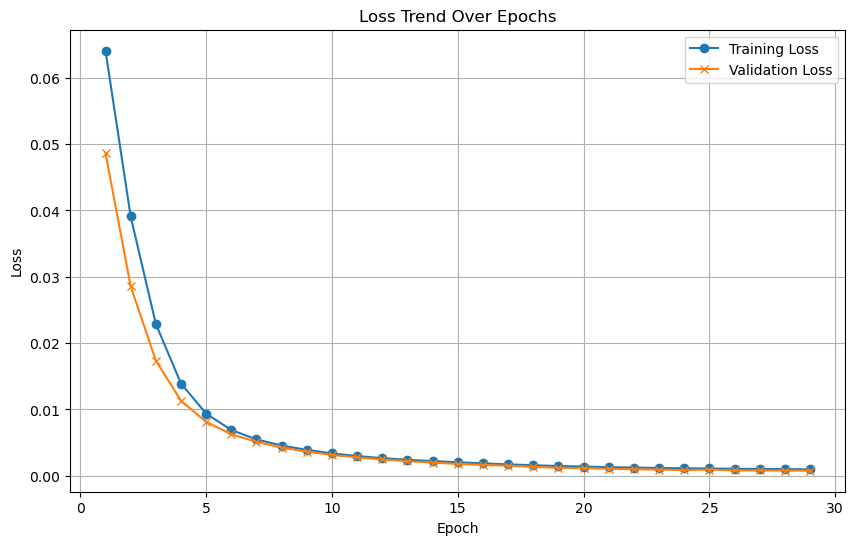

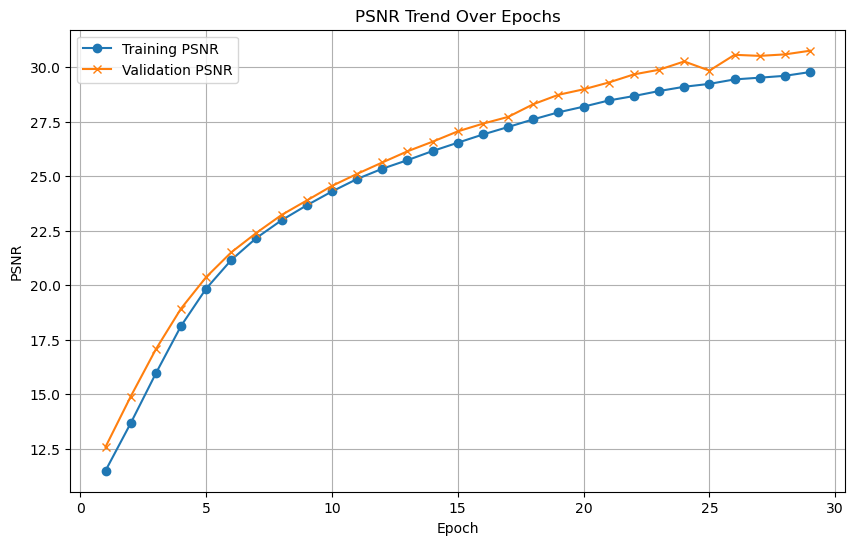

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/1 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/39 for test dataset.


Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training
Epoch [1/1000] completed, Average Training Loss: 2.8019
    Validation Batch [1/1], Loss: 2.7832
Validation Loss: 2.7832, Validation Accuracy: 6.67%
Validation loss improved from inf to 2.7832. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.7561
    Validation Batch [1/1], Loss: 2.7834
Validation Loss: 2.7834, Validation Accuracy: 6.67%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.7445
    Validation Batch [1/1], Loss: 2.7834
Validation Loss: 2.7834, Validation Accuracy: 6.67%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.7308
    Validation Batch [1/1], Loss: 2.7836
Validation Loss: 2.7836, Validation Accuracy: 6.67%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [5/1000] - Training
Epoch [5/1000] completed, Average Tr

Epoch [9/1000] completed, Average Training Loss: 2.6746
    Validation Batch [1/1], Loss: 2.7851
Validation Loss: 2.7851, Validation Accuracy: 6.67%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [10/1000] - Training
Epoch [10/1000] completed, Average Training Loss: 2.6642
    Validation Batch [1/1], Loss: 2.7854
Validation Loss: 2.7854, Validation Accuracy: 6.67%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [11/1000] - Training
Epoch [11/1000] completed, Average Training Loss: 2.6594
    Validation Batch [1/1], Loss: 2.7856
Validation Loss: 2.7856, Validation Accuracy: 6.67%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [12/1000] - Training
Epoch [12/1000] completed, Average Training Loss: 2.6474
    Validation Batch [1/1], Loss: 2.7859
Validation Loss: 2.7859, Validation Accuracy: 6.67%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [13/1000] - Training
Epoch [13/1000] completed, Average Training Loss: 2.6504
    Validation

Epoch [17/1000] completed, Average Training Loss: 2.5953
    Validation Batch [1/1], Loss: 2.7869
Validation Loss: 2.7869, Validation Accuracy: 6.67%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [18/1000] - Training
Epoch [18/1000] completed, Average Training Loss: 2.5914
    Validation Batch [1/1], Loss: 2.7870
Validation Loss: 2.7870, Validation Accuracy: 6.67%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [19/1000] - Training
Epoch [19/1000] completed, Average Training Loss: 2.5851
    Validation Batch [1/1], Loss: 2.7872
Validation Loss: 2.7872, Validation Accuracy: 6.67%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [20/1000] - Training
Epoch [20/1000] completed, Average Training Loss: 2.5736
    Validation Batch [1/1], Loss: 2.7873
Validation Loss: 2.7873, Validation Accuracy: 6.67%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [21/1000] - Training
Epoch [21/1000] completed, Average Training Loss: 2.5699
    Validat

Epoch [34/1000] completed, Average Training Loss: 2.4492
    Validation Batch [1/1], Loss: 2.7816
Validation Loss: 2.7816, Validation Accuracy: 6.67%
Validation loss improved from 2.7824 to 2.7816. Saving model...

LOG: Epoch [35/1000] - Training
Epoch [35/1000] completed, Average Training Loss: 2.4460
    Validation Batch [1/1], Loss: 2.7790
Validation Loss: 2.7790, Validation Accuracy: 6.67%
Validation loss improved from 2.7816 to 2.7790. Saving model...

LOG: Epoch [36/1000] - Training
Epoch [36/1000] completed, Average Training Loss: 2.4305
    Validation Batch [1/1], Loss: 2.7754
Validation Loss: 2.7754, Validation Accuracy: 6.67%
Validation loss improved from 2.7790 to 2.7754. Saving model...

LOG: Epoch [37/1000] - Training
Epoch [37/1000] completed, Average Training Loss: 2.4243
    Validation Batch [1/1], Loss: 2.7708
Validation Loss: 2.7708, Validation Accuracy: 6.67%
Validation loss improved from 2.7754 to 2.7708. Saving model...

LOG: Epoch [38/1000] - Training
Epoch [38/10

    Validation Batch [1/1], Loss: 2.7522
Validation Loss: 2.7522, Validation Accuracy: 6.67%
Validation loss improved from 2.7596 to 2.7522. Saving model...

LOG: Epoch [41/1000] - Training
Epoch [41/1000] completed, Average Training Loss: 2.3735
    Validation Batch [1/1], Loss: 2.7425
Validation Loss: 2.7425, Validation Accuracy: 9.33%
Validation loss improved from 2.7522 to 2.7425. Saving model...

LOG: Epoch [42/1000] - Training
Epoch [42/1000] completed, Average Training Loss: 2.3739
    Validation Batch [1/1], Loss: 2.7332
Validation Loss: 2.7332, Validation Accuracy: 14.67%
Validation loss improved from 2.7425 to 2.7332. Saving model...

LOG: Epoch [43/1000] - Training
Epoch [43/1000] completed, Average Training Loss: 2.3667
    Validation Batch [1/1], Loss: 2.7239
Validation Loss: 2.7239, Validation Accuracy: 16.00%
Validation loss improved from 2.7332 to 2.7239. Saving model...

LOG: Epoch [44/1000] - Training
Epoch [44/1000] completed, Average Training Loss: 2.3644
    Valida

Epoch [57/1000] completed, Average Training Loss: 2.2625
    Validation Batch [1/1], Loss: 2.4554
Validation Loss: 2.4554, Validation Accuracy: 30.67%
Validation loss improved from 2.4818 to 2.4554. Saving model...

LOG: Epoch [58/1000] - Training
Epoch [58/1000] completed, Average Training Loss: 2.2274
    Validation Batch [1/1], Loss: 2.4484
Validation Loss: 2.4484, Validation Accuracy: 30.67%
Validation loss improved from 2.4554 to 2.4484. Saving model...

LOG: Epoch [59/1000] - Training
Epoch [59/1000] completed, Average Training Loss: 2.2398
    Validation Batch [1/1], Loss: 2.4476
Validation Loss: 2.4476, Validation Accuracy: 30.67%
Validation loss improved from 2.4484 to 2.4476. Saving model...

LOG: Epoch [60/1000] - Training
Epoch [60/1000] completed, Average Training Loss: 2.2332
    Validation Batch [1/1], Loss: 2.4419
Validation Loss: 2.4419, Validation Accuracy: 30.67%
Validation loss improved from 2.4476 to 2.4419. Saving model...

LOG: Epoch [61/1000] - Training
Epoch [6

Epoch [64/1000] completed, Average Training Loss: 2.1867
    Validation Batch [1/1], Loss: 2.3650
Validation Loss: 2.3650, Validation Accuracy: 32.00%
Validation loss improved from 2.4001 to 2.3650. Saving model...

LOG: Epoch [65/1000] - Training
Epoch [65/1000] completed, Average Training Loss: 2.1722
    Validation Batch [1/1], Loss: 2.3421
Validation Loss: 2.3421, Validation Accuracy: 40.00%
Validation loss improved from 2.3650 to 2.3421. Saving model...

LOG: Epoch [66/1000] - Training
Epoch [66/1000] completed, Average Training Loss: 2.1776
    Validation Batch [1/1], Loss: 2.3198
Validation Loss: 2.3198, Validation Accuracy: 44.00%
Validation loss improved from 2.3421 to 2.3198. Saving model...

LOG: Epoch [67/1000] - Training
Epoch [67/1000] completed, Average Training Loss: 2.1666
    Validation Batch [1/1], Loss: 2.3056
Validation Loss: 2.3056, Validation Accuracy: 44.00%
Validation loss improved from 2.3198 to 2.3056. Saving model...

LOG: Epoch [68/1000] - Training
Epoch [6

Epoch [78/1000] completed, Average Training Loss: 2.0689
    Validation Batch [1/1], Loss: 2.1598
Validation Loss: 2.1598, Validation Accuracy: 50.67%
Validation loss improved from 2.1687 to 2.1598. Saving model...

LOG: Epoch [79/1000] - Training
Epoch [79/1000] completed, Average Training Loss: 2.0562
    Validation Batch [1/1], Loss: 2.1434
Validation Loss: 2.1434, Validation Accuracy: 50.67%
Validation loss improved from 2.1598 to 2.1434. Saving model...

LOG: Epoch [80/1000] - Training
Epoch [80/1000] completed, Average Training Loss: 2.0545
    Validation Batch [1/1], Loss: 2.1277
Validation Loss: 2.1277, Validation Accuracy: 49.33%
Validation loss improved from 2.1434 to 2.1277. Saving model...

LOG: Epoch [81/1000] - Training
Epoch [81/1000] completed, Average Training Loss: 2.0561
    Validation Batch [1/1], Loss: 2.1370
Validation Loss: 2.1370, Validation Accuracy: 49.33%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [82/1000] - Training
Epoch [82/1000] complet

Epoch [88/1000] completed, Average Training Loss: 1.9866
    Validation Batch [1/1], Loss: 2.1001
Validation Loss: 2.1001, Validation Accuracy: 53.33%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [89/1000] - Training
Epoch [89/1000] completed, Average Training Loss: 1.9843
    Validation Batch [1/1], Loss: 2.0456
Validation Loss: 2.0456, Validation Accuracy: 52.00%
Validation loss improved from 2.0930 to 2.0456. Saving model...

LOG: Epoch [90/1000] - Training
Epoch [90/1000] completed, Average Training Loss: 1.9695
    Validation Batch [1/1], Loss: 2.0246
Validation Loss: 2.0246, Validation Accuracy: 56.00%
Validation loss improved from 2.0456 to 2.0246. Saving model...

LOG: Epoch [91/1000] - Training
Epoch [91/1000] completed, Average Training Loss: 1.9642
    Validation Batch [1/1], Loss: 2.0601
Validation Loss: 2.0601, Validation Accuracy: 57.33%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [92/1000] - Training
Epoch [92/1000] completed, Average Tra

Epoch [101/1000] completed, Average Training Loss: 1.8604
    Validation Batch [1/1], Loss: 1.9579
Validation Loss: 1.9579, Validation Accuracy: 52.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [102/1000] - Training
Epoch [102/1000] completed, Average Training Loss: 1.8646
    Validation Batch [1/1], Loss: 1.9507
Validation Loss: 1.9507, Validation Accuracy: 50.67%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [103/1000] - Training
Epoch [103/1000] completed, Average Training Loss: 1.8566
    Validation Batch [1/1], Loss: 1.9447
Validation Loss: 1.9447, Validation Accuracy: 56.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [104/1000] - Training
Epoch [104/1000] completed, Average Training Loss: 1.8555
    Validation Batch [1/1], Loss: 1.9200
Validation Loss: 1.9200, Validation Accuracy: 56.00%
Validation loss improved from 1.9353 to 1.9200. Saving model...

LOG: Epoch [105/1000] - Training
Epoch [105/1000] completed, Average Training 

Epoch [111/1000] completed, Average Training Loss: 1.7708
    Validation Batch [1/1], Loss: 1.9131
Validation Loss: 1.9131, Validation Accuracy: 58.67%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [112/1000] - Training
Epoch [112/1000] completed, Average Training Loss: 1.7831
    Validation Batch [1/1], Loss: 1.9008
Validation Loss: 1.9008, Validation Accuracy: 57.33%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [113/1000] - Training
Epoch [113/1000] completed, Average Training Loss: 1.7570
    Validation Batch [1/1], Loss: 1.9003
Validation Loss: 1.9003, Validation Accuracy: 57.33%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [114/1000] - Training
Epoch [114/1000] completed, Average Training Loss: 1.7568
    Validation Batch [1/1], Loss: 1.8377
Validation Loss: 1.8377, Validation Accuracy: 57.33%
Validation loss improved from 1.8694 to 1.8377. Saving model...

LOG: Epoch [115/1000] - Training
Epoch [115/1000] completed, Average Training 


LOG: Epoch [124/1000] - Training
Epoch [124/1000] completed, Average Training Loss: 1.6650
    Validation Batch [1/1], Loss: 1.7805
Validation Loss: 1.7805, Validation Accuracy: 58.67%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [125/1000] - Training
Epoch [125/1000] completed, Average Training Loss: 1.6448
    Validation Batch [1/1], Loss: 1.7762
Validation Loss: 1.7762, Validation Accuracy: 60.00%
Validation loss improved from 1.7778 to 1.7762. Saving model...

LOG: Epoch [126/1000] - Training
Epoch [126/1000] completed, Average Training Loss: 1.6503
    Validation Batch [1/1], Loss: 1.7813
Validation Loss: 1.7813, Validation Accuracy: 60.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [127/1000] - Training
Epoch [127/1000] completed, Average Training Loss: 1.6431
    Validation Batch [1/1], Loss: 1.7889
Validation Loss: 1.7889, Validation Accuracy: 65.33%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [128/1000] - Training
Epoch [128/

Epoch [133/1000] completed, Average Training Loss: 1.5753
    Validation Batch [1/1], Loss: 1.7299
Validation Loss: 1.7299, Validation Accuracy: 66.67%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [134/1000] - Training
Epoch [134/1000] completed, Average Training Loss: 1.5910
    Validation Batch [1/1], Loss: 1.6810
Validation Loss: 1.6810, Validation Accuracy: 69.33%
Validation loss improved from 1.6815 to 1.6810. Saving model...

LOG: Epoch [135/1000] - Training
Epoch [135/1000] completed, Average Training Loss: 1.5496
    Validation Batch [1/1], Loss: 1.7285
Validation Loss: 1.7285, Validation Accuracy: 61.33%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [136/1000] - Training
Epoch [136/1000] completed, Average Training Loss: 1.5626
    Validation Batch [1/1], Loss: 1.6852
Validation Loss: 1.6852, Validation Accuracy: 70.67%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [137/1000] - Training
Epoch [137/1000] completed, Average Training 

Epoch [146/1000] completed, Average Training Loss: 1.4640
    Validation Batch [1/1], Loss: 1.6136
Validation Loss: 1.6136, Validation Accuracy: 70.67%
Validation loss improved from 1.6339 to 1.6136. Saving model...

LOG: Epoch [147/1000] - Training
Epoch [147/1000] completed, Average Training Loss: 1.4487
    Validation Batch [1/1], Loss: 1.5945
Validation Loss: 1.5945, Validation Accuracy: 68.00%
Validation loss improved from 1.6136 to 1.5945. Saving model...

LOG: Epoch [148/1000] - Training
Epoch [148/1000] completed, Average Training Loss: 1.4402
    Validation Batch [1/1], Loss: 1.6949
Validation Loss: 1.6949, Validation Accuracy: 64.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [149/1000] - Training
Epoch [149/1000] completed, Average Training Loss: 1.4463
    Validation Batch [1/1], Loss: 1.5784
Validation Loss: 1.5784, Validation Accuracy: 68.00%
Validation loss improved from 1.5945 to 1.5784. Saving model...

LOG: Epoch [150/1000] - Training
Epoch [150/1000

Epoch [156/1000] completed, Average Training Loss: 1.3855
    Validation Batch [1/1], Loss: 1.5688
Validation Loss: 1.5688, Validation Accuracy: 68.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [157/1000] - Training
Epoch [157/1000] completed, Average Training Loss: 1.3297
    Validation Batch [1/1], Loss: 1.5442
Validation Loss: 1.5442, Validation Accuracy: 70.67%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [158/1000] - Training
Epoch [158/1000] completed, Average Training Loss: 1.3181
    Validation Batch [1/1], Loss: 1.5884
Validation Loss: 1.5884, Validation Accuracy: 64.00%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [159/1000] - Training
Epoch [159/1000] completed, Average Training Loss: 1.3028
    Validation Batch [1/1], Loss: 1.5765
Validation Loss: 1.5765, Validation Accuracy: 69.33%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [160/1000] - Training
Epoch [160/1000] completed, Average Training Loss: 1.3218
  

Epoch [170/1000] completed, Average Training Loss: 1.2245
    Validation Batch [1/1], Loss: 1.4823
Validation Loss: 1.4823, Validation Accuracy: 65.33%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [171/1000] - Training
Epoch [171/1000] completed, Average Training Loss: 1.2317
    Validation Batch [1/1], Loss: 1.4808
Validation Loss: 1.4808, Validation Accuracy: 64.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [172/1000] - Training
Epoch [172/1000] completed, Average Training Loss: 1.1838
    Validation Batch [1/1], Loss: 1.5144
Validation Loss: 1.5144, Validation Accuracy: 65.33%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [173/1000] - Training
Epoch [173/1000] completed, Average Training Loss: 1.1988
    Validation Batch [1/1], Loss: 1.4112
Validation Loss: 1.4112, Validation Accuracy: 70.67%
Validation loss improved from 1.4420 to 1.4112. Saving model...

LOG: Epoch [174/1000] - Training
Epoch [174/1000] completed, Average Training 

Epoch [180/1000] completed, Average Training Loss: 1.1209
    Validation Batch [1/1], Loss: 1.3691
Validation Loss: 1.3691, Validation Accuracy: 69.33%
Validation loss improved from 1.3693 to 1.3691. Saving model...

LOG: Epoch [181/1000] - Training
Epoch [181/1000] completed, Average Training Loss: 1.1172
    Validation Batch [1/1], Loss: 1.3973
Validation Loss: 1.3973, Validation Accuracy: 66.67%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [182/1000] - Training
Epoch [182/1000] completed, Average Training Loss: 1.0656
    Validation Batch [1/1], Loss: 1.3770
Validation Loss: 1.3770, Validation Accuracy: 65.33%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [183/1000] - Training
Epoch [183/1000] completed, Average Training Loss: 1.0991
    Validation Batch [1/1], Loss: 1.3539
Validation Loss: 1.3539, Validation Accuracy: 70.67%
Validation loss improved from 1.3691 to 1.3539. Saving model...

LOG: Epoch [184/1000] - Training
Epoch [184/1000] completed, Av

Epoch [193/1000] completed, Average Training Loss: 1.0395
    Validation Batch [1/1], Loss: 1.2822
Validation Loss: 1.2822, Validation Accuracy: 76.00%
Validation loss improved from 1.3319 to 1.2822. Saving model...

LOG: Epoch [194/1000] - Training
Epoch [194/1000] completed, Average Training Loss: 1.0225
    Validation Batch [1/1], Loss: 1.3258
Validation Loss: 1.3258, Validation Accuracy: 69.33%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [195/1000] - Training
Epoch [195/1000] completed, Average Training Loss: 0.9908
    Validation Batch [1/1], Loss: 1.4128
Validation Loss: 1.4128, Validation Accuracy: 61.33%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [196/1000] - Training
Epoch [196/1000] completed, Average Training Loss: 0.9906
    Validation Batch [1/1], Loss: 1.2626
Validation Loss: 1.2626, Validation Accuracy: 73.33%
Validation loss improved from 1.2822 to 1.2626. Saving model...

LOG: Epoch [197/1000] - Training
Epoch [197/1000] completed, Av

Epoch [203/1000] completed, Average Training Loss: 0.9195
    Validation Batch [1/1], Loss: 1.2933
Validation Loss: 1.2933, Validation Accuracy: 66.67%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [204/1000] - Training
Epoch [204/1000] completed, Average Training Loss: 0.8923
    Validation Batch [1/1], Loss: 1.2807
Validation Loss: 1.2807, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [205/1000] - Training
Epoch [205/1000] completed, Average Training Loss: 0.9062
    Validation Batch [1/1], Loss: 1.3571
Validation Loss: 1.3571, Validation Accuracy: 62.67%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [206/1000] - Training
Epoch [206/1000] completed, Average Training Loss: 0.8841
    Validation Batch [1/1], Loss: 1.2883
Validation Loss: 1.2883, Validation Accuracy: 64.00%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [207/1000] - Training
Epoch [207/1000] completed, Average Training Loss: 0.8627
  

    Validation Batch [1/1], Loss: 1.1787
Validation Loss: 1.1787, Validation Accuracy: 73.33%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [215/1000] - Training
Epoch [215/1000] completed, Average Training Loss: 0.8124
    Validation Batch [1/1], Loss: 1.1475
Validation Loss: 1.1475, Validation Accuracy: 76.00%
Validation loss improved from 1.1593 to 1.1475. Saving model...

LOG: Epoch [216/1000] - Training
Epoch [216/1000] completed, Average Training Loss: 0.8389
    Validation Batch [1/1], Loss: 1.2734
Validation Loss: 1.2734, Validation Accuracy: 65.33%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [217/1000] - Training
Epoch [217/1000] completed, Average Training Loss: 0.8048
    Validation Batch [1/1], Loss: 1.2687
Validation Loss: 1.2687, Validation Accuracy: 69.33%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [218/1000] - Training
Epoch [218/1000] completed, Average Training Loss: 0.7778
    Validation Batch [1/1], Loss: 1.2775
Vali

Epoch [226/1000] completed, Average Training Loss: 0.6890
    Validation Batch [1/1], Loss: 1.1927
Validation Loss: 1.1927, Validation Accuracy: 69.33%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [227/1000] - Training
Epoch [227/1000] completed, Average Training Loss: 0.6944
    Validation Batch [1/1], Loss: 1.0694
Validation Loss: 1.0694, Validation Accuracy: 81.33%
Validation loss improved from 1.0962 to 1.0694. Saving model...

LOG: Epoch [228/1000] - Training
Epoch [228/1000] completed, Average Training Loss: 0.7306
    Validation Batch [1/1], Loss: 1.1336
Validation Loss: 1.1336, Validation Accuracy: 73.33%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [229/1000] - Training
Epoch [229/1000] completed, Average Training Loss: 0.7253
    Validation Batch [1/1], Loss: 1.1683
Validation Loss: 1.1683, Validation Accuracy: 66.67%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [230/1000] - Training
Epoch [230/1000] completed, Average Training 

Epoch [238/1000] completed, Average Training Loss: 0.6570
    Validation Batch [1/1], Loss: 1.0554
Validation Loss: 1.0554, Validation Accuracy: 80.00%
Validation loss improved from 1.0579 to 1.0554. Saving model...

LOG: Epoch [239/1000] - Training
Epoch [239/1000] completed, Average Training Loss: 0.6477
    Validation Batch [1/1], Loss: 1.2196
Validation Loss: 1.2196, Validation Accuracy: 66.67%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [240/1000] - Training
Epoch [240/1000] completed, Average Training Loss: 0.6252
    Validation Batch [1/1], Loss: 1.1746
Validation Loss: 1.1746, Validation Accuracy: 73.33%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [241/1000] - Training
Epoch [241/1000] completed, Average Training Loss: 0.6200
    Validation Batch [1/1], Loss: 1.0405
Validation Loss: 1.0405, Validation Accuracy: 78.67%
Validation loss improved from 1.0554 to 1.0405. Saving model...

LOG: Epoch [242/1000] - Training
Epoch [242/1000] completed, Av

Epoch [250/1000] completed, Average Training Loss: 0.5665
    Validation Batch [1/1], Loss: 1.1989
Validation Loss: 1.1989, Validation Accuracy: 65.33%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [251/1000] - Training
Epoch [251/1000] completed, Average Training Loss: 0.5631
    Validation Batch [1/1], Loss: 1.0652
Validation Loss: 1.0652, Validation Accuracy: 74.67%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [252/1000] - Training
Epoch [252/1000] completed, Average Training Loss: 0.5555
    Validation Batch [1/1], Loss: 0.9796
Validation Loss: 0.9796, Validation Accuracy: 82.67%
Validation loss improved from 0.9802 to 0.9796. Saving model...

LOG: Epoch [253/1000] - Training
Epoch [253/1000] completed, Average Training Loss: 0.5309
    Validation Batch [1/1], Loss: 0.9913
Validation Loss: 0.9913, Validation Accuracy: 77.33%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [254/1000] - Training
Epoch [254/1000] completed, Average Training 

Epoch [262/1000] completed, Average Training Loss: 0.5112
    Validation Batch [1/1], Loss: 1.0455
Validation Loss: 1.0455, Validation Accuracy: 72.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [263/1000] - Training
Epoch [263/1000] completed, Average Training Loss: 0.5027
    Validation Batch [1/1], Loss: 0.9855
Validation Loss: 0.9855, Validation Accuracy: 74.67%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [264/1000] - Training
Epoch [264/1000] completed, Average Training Loss: 0.4853
    Validation Batch [1/1], Loss: 0.9012
Validation Loss: 0.9012, Validation Accuracy: 81.33%
Validation loss improved from 0.9519 to 0.9012. Saving model...

LOG: Epoch [265/1000] - Training
Epoch [265/1000] completed, Average Training Loss: 0.4749
    Validation Batch [1/1], Loss: 1.0004
Validation Loss: 1.0004, Validation Accuracy: 76.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [266/1000] - Training
Epoch [266/1000] completed, Average Training 

Epoch [273/1000] completed, Average Training Loss: 0.4702
    Validation Batch [1/1], Loss: 0.9006
Validation Loss: 0.9006, Validation Accuracy: 77.33%
Validation loss improved from 0.9012 to 0.9006. Saving model...

LOG: Epoch [274/1000] - Training
Epoch [274/1000] completed, Average Training Loss: 0.4414
    Validation Batch [1/1], Loss: 0.9223
Validation Loss: 0.9223, Validation Accuracy: 77.33%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [275/1000] - Training
Epoch [275/1000] completed, Average Training Loss: 0.4292
    Validation Batch [1/1], Loss: 0.9129
Validation Loss: 0.9129, Validation Accuracy: 78.67%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [276/1000] - Training
Epoch [276/1000] completed, Average Training Loss: 0.4216
    Validation Batch [1/1], Loss: 0.9165
Validation Loss: 0.9165, Validation Accuracy: 77.33%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [277/1000] - Training
Epoch [277/1000] completed, Average Training 

Epoch [285/1000] completed, Average Training Loss: 0.3892
    Validation Batch [1/1], Loss: 0.9399
Validation Loss: 0.9399, Validation Accuracy: 74.67%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [286/1000] - Training
Epoch [286/1000] completed, Average Training Loss: 0.3908
    Validation Batch [1/1], Loss: 0.8476
Validation Loss: 0.8476, Validation Accuracy: 80.00%
Validation loss improved from 0.8491 to 0.8476. Saving model...

LOG: Epoch [287/1000] - Training
Epoch [287/1000] completed, Average Training Loss: 0.3576
    Validation Batch [1/1], Loss: 0.9458
Validation Loss: 0.9458, Validation Accuracy: 74.67%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [288/1000] - Training
Epoch [288/1000] completed, Average Training Loss: 0.3893
    Validation Batch [1/1], Loss: 0.9799
Validation Loss: 0.9799, Validation Accuracy: 72.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [289/1000] - Training
Epoch [289/1000] completed, Average Training 

Epoch [296/1000] completed, Average Training Loss: 0.3467
    Validation Batch [1/1], Loss: 0.8825
Validation Loss: 0.8825, Validation Accuracy: 77.33%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [297/1000] - Training
Epoch [297/1000] completed, Average Training Loss: 0.3401
    Validation Batch [1/1], Loss: 0.9467
Validation Loss: 0.9467, Validation Accuracy: 73.33%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [298/1000] - Training
Epoch [298/1000] completed, Average Training Loss: 0.3376
    Validation Batch [1/1], Loss: 0.8707
Validation Loss: 0.8707, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [299/1000] - Training
Epoch [299/1000] completed, Average Training Loss: 0.3405
    Validation Batch [1/1], Loss: 0.8255
Validation Loss: 0.8255, Validation Accuracy: 80.00%
Validation loss improved from 0.8476 to 0.8255. Saving model...

LOG: Epoch [300/1000] - Training
Epoch [300/1000] completed, Average Traini

Epoch [309/1000] completed, Average Training Loss: 0.3139
    Validation Batch [1/1], Loss: 0.8487
Validation Loss: 0.8487, Validation Accuracy: 77.33%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [310/1000] - Training
Epoch [310/1000] completed, Average Training Loss: 0.3162
    Validation Batch [1/1], Loss: 0.8510
Validation Loss: 0.8510, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [311/1000] - Training
Epoch [311/1000] completed, Average Training Loss: 0.2991
    Validation Batch [1/1], Loss: 0.8134
Validation Loss: 0.8134, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [312/1000] - Training
Epoch [312/1000] completed, Average Training Loss: 0.2885
    Validation Batch [1/1], Loss: 0.9293
Validation Loss: 0.9293, Validation Accuracy: 77.33%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [313/1000] - Training
Epoch [313/1000] completed, Average Training Loss: 0.2708
  

Epoch [317/1000] completed, Average Training Loss: 0.2812
    Validation Batch [1/1], Loss: 0.8771
Validation Loss: 0.8771, Validation Accuracy: 77.33%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [318/1000] - Training
Epoch [318/1000] completed, Average Training Loss: 0.2713
    Validation Batch [1/1], Loss: 0.7985
Validation Loss: 0.7985, Validation Accuracy: 77.33%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [319/1000] - Training
Epoch [319/1000] completed, Average Training Loss: 0.2758
    Validation Batch [1/1], Loss: 0.8763
Validation Loss: 0.8763, Validation Accuracy: 78.67%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [320/1000] - Training
Epoch [320/1000] completed, Average Training Loss: 0.2626
    Validation Batch [1/1], Loss: 0.7946
Validation Loss: 0.7946, Validation Accuracy: 81.33%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [321/1000] - Training


Epoch [321/1000] completed, Average Training Loss: 0.2799
    Validation Batch [1/1], Loss: 0.8454
Validation Loss: 0.8454, Validation Accuracy: 78.67%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [322/1000] - Training
Epoch [322/1000] completed, Average Training Loss: 0.2714
    Validation Batch [1/1], Loss: 0.9005
Validation Loss: 0.9005, Validation Accuracy: 78.67%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [323/1000] - Training
Epoch [323/1000] completed, Average Training Loss: 0.2708
    Validation Batch [1/1], Loss: 0.9945
Validation Loss: 0.9945, Validation Accuracy: 76.00%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [324/1000] - Training
Epoch [324/1000] completed, Average Training Loss: 0.2746
    Validation Batch [1/1], Loss: 0.9845
Validation Loss: 0.9845, Validation Accuracy: 73.33%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [325/1000] - Training
Epoch [325/1000] completed, Average Training Loss: 0.2600


    Validation Batch [1/1], Loss: 0.8870
Validation Loss: 0.8870, Validation Accuracy: 78.67%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [341/1000] - Training
Epoch [341/1000] completed, Average Training Loss: 0.2213
    Validation Batch [1/1], Loss: 0.7902
Validation Loss: 0.7902, Validation Accuracy: 78.67%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [342/1000] - Training
Epoch [342/1000] completed, Average Training Loss: 0.2338
    Validation Batch [1/1], Loss: 0.7968
Validation Loss: 0.7968, Validation Accuracy: 77.33%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [343/1000] - Training
Epoch [343/1000] completed, Average Training Loss: 0.2324
    Validation Batch [1/1], Loss: 0.8102
Validation Loss: 0.8102, Validation Accuracy: 77.33%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [344/1000] - Training
Epoch [344/1000] completed, Average Training Loss: 0.2224
    Validation Batch [1/1], Loss: 0.7543
Validation Loss: 0.

Epoch [363/1000] completed, Average Training Loss: 0.1809
    Validation Batch [1/1], Loss: 0.7597
Validation Loss: 0.7597, Validation Accuracy: 77.33%
Validation loss did not improve. Patience: 27/100

LOG: Epoch [364/1000] - Training
Epoch [364/1000] completed, Average Training Loss: 0.1851
    Validation Batch [1/1], Loss: 0.7579
Validation Loss: 0.7579, Validation Accuracy: 82.67%
Validation loss did not improve. Patience: 28/100

LOG: Epoch [365/1000] - Training
Epoch [365/1000] completed, Average Training Loss: 0.1942
    Validation Batch [1/1], Loss: 0.8801
Validation Loss: 0.8801, Validation Accuracy: 74.67%
Validation loss did not improve. Patience: 29/100

LOG: Epoch [366/1000] - Training
Epoch [366/1000] completed, Average Training Loss: 0.2065
    Validation Batch [1/1], Loss: 0.7860
Validation Loss: 0.7860, Validation Accuracy: 77.33%
Validation loss did not improve. Patience: 30/100

LOG: Epoch [367/1000] - Training
Epoch [367/1000] completed, Average Training Loss: 0.195

Epoch [385/1000] completed, Average Training Loss: 0.1804
    Validation Batch [1/1], Loss: 0.7483
Validation Loss: 0.7483, Validation Accuracy: 78.67%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [386/1000] - Training
Epoch [386/1000] completed, Average Training Loss: 0.1611
    Validation Batch [1/1], Loss: 0.7810
Validation Loss: 0.7810, Validation Accuracy: 77.33%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [387/1000] - Training
Epoch [387/1000] completed, Average Training Loss: 0.1587
    Validation Batch [1/1], Loss: 0.7640
Validation Loss: 0.7640, Validation Accuracy: 78.67%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [388/1000] - Training
Epoch [388/1000] completed, Average Training Loss: 0.1641
    Validation Batch [1/1], Loss: 0.8686
Validation Loss: 0.8686, Validation Accuracy: 76.00%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [389/1000] - Training
Epoch [389/1000] completed, Average Training Loss: 0.1693

Epoch [408/1000] completed, Average Training Loss: 0.1402
    Validation Batch [1/1], Loss: 0.7490
Validation Loss: 0.7490, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [409/1000] - Training
Epoch [409/1000] completed, Average Training Loss: 0.1369
    Validation Batch [1/1], Loss: 0.8880
Validation Loss: 0.8880, Validation Accuracy: 73.33%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [410/1000] - Training
Epoch [410/1000] completed, Average Training Loss: 0.1481
    Validation Batch [1/1], Loss: 0.8426
Validation Loss: 0.8426, Validation Accuracy: 72.00%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [411/1000] - Training
Epoch [411/1000] completed, Average Training Loss: 0.1497
    Validation Batch [1/1], Loss: 0.8138
Validation Loss: 0.8138, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [412/1000] - Training
Epoch [412/1000] completed, Average Training Loss: 0.1427
  

Epoch [431/1000] completed, Average Training Loss: 0.1402
    Validation Batch [1/1], Loss: 0.7158
Validation Loss: 0.7158, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [432/1000] - Training
Epoch [432/1000] completed, Average Training Loss: 0.1110
    Validation Batch [1/1], Loss: 0.7596
Validation Loss: 0.7596, Validation Accuracy: 76.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [433/1000] - Training
Epoch [433/1000] completed, Average Training Loss: 0.1208
    Validation Batch [1/1], Loss: 0.7560
Validation Loss: 0.7560, Validation Accuracy: 78.67%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [434/1000] - Training
Epoch [434/1000] completed, Average Training Loss: 0.1267
    Validation Batch [1/1], Loss: 0.7689
Validation Loss: 0.7689, Validation Accuracy: 77.33%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [435/1000] - Training
Epoch [435/1000] completed, Average Training Loss: 0.1177
  

Epoch [454/1000] completed, Average Training Loss: 0.1118
    Validation Batch [1/1], Loss: 0.7332
Validation Loss: 0.7332, Validation Accuracy: 76.00%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [455/1000] - Training
Epoch [455/1000] completed, Average Training Loss: 0.1096
    Validation Batch [1/1], Loss: 0.7659
Validation Loss: 0.7659, Validation Accuracy: 77.33%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [456/1000] - Training
Epoch [456/1000] completed, Average Training Loss: 0.1152
    Validation Batch [1/1], Loss: 0.8792
Validation Loss: 0.8792, Validation Accuracy: 74.67%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [457/1000] - Training
Epoch [457/1000] completed, Average Training Loss: 0.1018
    Validation Batch [1/1], Loss: 0.8865
Validation Loss: 0.8865, Validation Accuracy: 76.00%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [458/1000] - Training
Epoch [458/1000] completed, Average Training Loss: 0.107

    Validation Batch [1/1], Loss: 0.7623
Validation Loss: 0.7623, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 36/100

LOG: Epoch [477/1000] - Training
Epoch [477/1000] completed, Average Training Loss: 0.1073
    Validation Batch [1/1], Loss: 0.8048
Validation Loss: 0.8048, Validation Accuracy: 81.33%
Validation loss did not improve. Patience: 37/100

LOG: Epoch [478/1000] - Training
Epoch [478/1000] completed, Average Training Loss: 0.0947
    Validation Batch [1/1], Loss: 0.8163
Validation Loss: 0.8163, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 38/100

LOG: Epoch [479/1000] - Training
Epoch [479/1000] completed, Average Training Loss: 0.0887
    Validation Batch [1/1], Loss: 0.7488
Validation Loss: 0.7488, Validation Accuracy: 82.67%
Validation loss did not improve. Patience: 39/100

LOG: Epoch [480/1000] - Training
Epoch [480/1000] completed, Average Training Loss: 0.0986
    Validation Batch [1/1], Loss: 0.6889
Validation Loss

    Validation Batch [1/1], Loss: 0.7221
Validation Loss: 0.7221, Validation Accuracy: 82.67%
Validation loss did not improve. Patience: 59/100

LOG: Epoch [500/1000] - Training
Epoch [500/1000] completed, Average Training Loss: 0.0831
    Validation Batch [1/1], Loss: 0.6885
Validation Loss: 0.6885, Validation Accuracy: 81.33%
Validation loss did not improve. Patience: 60/100

LOG: Epoch [501/1000] - Training
Epoch [501/1000] completed, Average Training Loss: 0.0948
    Validation Batch [1/1], Loss: 0.7858
Validation Loss: 0.7858, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 61/100

LOG: Epoch [502/1000] - Training
Epoch [502/1000] completed, Average Training Loss: 0.0797
    Validation Batch [1/1], Loss: 0.8656
Validation Loss: 0.8656, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 62/100

LOG: Epoch [503/1000] - Training
Epoch [503/1000] completed, Average Training Loss: 0.0823
    Validation Batch [1/1], Loss: 0.8105
Validation Loss

    Validation Batch [1/1], Loss: 0.7662
Validation Loss: 0.7662, Validation Accuracy: 77.33%
Validation loss did not improve. Patience: 83/100

LOG: Epoch [524/1000] - Training
Epoch [524/1000] completed, Average Training Loss: 0.0702
    Validation Batch [1/1], Loss: 0.8912
Validation Loss: 0.8912, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 84/100

LOG: Epoch [525/1000] - Training
Epoch [525/1000] completed, Average Training Loss: 0.0743
    Validation Batch [1/1], Loss: 0.9410
Validation Loss: 0.9410, Validation Accuracy: 76.00%
Validation loss did not improve. Patience: 85/100

LOG: Epoch [526/1000] - Training
Epoch [526/1000] completed, Average Training Loss: 0.0668
    Validation Batch [1/1], Loss: 0.9830
Validation Loss: 0.9830, Validation Accuracy: 74.67%
Validation loss did not improve. Patience: 86/100

LOG: Epoch [527/1000] - Training
Epoch [527/1000] completed, Average Training Loss: 0.0781
    Validation Batch [1/1], Loss: 0.8343
Validation Loss

Epoch [546/1000] completed, Average Training Loss: 0.0683
    Validation Batch [1/1], Loss: 0.7068
Validation Loss: 0.7068, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [547/1000] - Training
Epoch [547/1000] completed, Average Training Loss: 0.0737
    Validation Batch [1/1], Loss: 0.7618
Validation Loss: 0.7618, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [548/1000] - Training
Epoch [548/1000] completed, Average Training Loss: 0.0626
    Validation Batch [1/1], Loss: 0.7988
Validation Loss: 0.7988, Validation Accuracy: 77.33%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [549/1000] - Training
Epoch [549/1000] completed, Average Training Loss: 0.0684
    Validation Batch [1/1], Loss: 0.7398
Validation Loss: 0.7398, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [550/1000] - Training
Epoch [550/1000] completed, Average Training Loss: 0.065

Epoch [569/1000] completed, Average Training Loss: 0.0639
    Validation Batch [1/1], Loss: 0.8245
Validation Loss: 0.8245, Validation Accuracy: 78.67%
Validation loss did not improve. Patience: 41/100

LOG: Epoch [570/1000] - Training
Epoch [570/1000] completed, Average Training Loss: 0.0612
    Validation Batch [1/1], Loss: 0.7334
Validation Loss: 0.7334, Validation Accuracy: 78.67%
Validation loss did not improve. Patience: 42/100

LOG: Epoch [571/1000] - Training
Epoch [571/1000] completed, Average Training Loss: 0.0642
    Validation Batch [1/1], Loss: 0.7343
Validation Loss: 0.7343, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 43/100

LOG: Epoch [572/1000] - Training
Epoch [572/1000] completed, Average Training Loss: 0.0532
    Validation Batch [1/1], Loss: 0.8003
Validation Loss: 0.8003, Validation Accuracy: 76.00%
Validation loss did not improve. Patience: 44/100

LOG: Epoch [573/1000] - Training
Epoch [573/1000] completed, Average Training Loss: 0.059

Epoch [591/1000] completed, Average Training Loss: 0.0577
    Validation Batch [1/1], Loss: 0.8235
Validation Loss: 0.8235, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 63/100

LOG: Epoch [592/1000] - Training
Epoch [592/1000] completed, Average Training Loss: 0.0563
    Validation Batch [1/1], Loss: 0.7623
Validation Loss: 0.7623, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 64/100

LOG: Epoch [593/1000] - Training
Epoch [593/1000] completed, Average Training Loss: 0.0576
    Validation Batch [1/1], Loss: 0.7253
Validation Loss: 0.7253, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 65/100

LOG: Epoch [594/1000] - Training
Epoch [594/1000] completed, Average Training Loss: 0.0511
    Validation Batch [1/1], Loss: 0.7074
Validation Loss: 0.7074, Validation Accuracy: 81.33%
Validation loss did not improve. Patience: 66/100

LOG: Epoch [595/1000] - Training
Epoch [595/1000] completed, Average Training Loss: 0.055

    Validation Batch [1/1], Loss: 0.7142
Validation Loss: 0.7142, Validation Accuracy: 81.33%
Validation loss did not improve. Patience: 86/100

LOG: Epoch [615/1000] - Training
Epoch [615/1000] completed, Average Training Loss: 0.0575
    Validation Batch [1/1], Loss: 0.7342
Validation Loss: 0.7342, Validation Accuracy: 81.33%
Validation loss did not improve. Patience: 87/100

LOG: Epoch [616/1000] - Training
Epoch [616/1000] completed, Average Training Loss: 0.0531
    Validation Batch [1/1], Loss: 0.7573
Validation Loss: 0.7573, Validation Accuracy: 77.33%
Validation loss did not improve. Patience: 88/100

LOG: Epoch [617/1000] - Training
Epoch [617/1000] completed, Average Training Loss: 0.0528
    Validation Batch [1/1], Loss: 0.7275
Validation Loss: 0.7275, Validation Accuracy: 77.33%
Validation loss did not improve. Patience: 89/100

LOG: Epoch [618/1000] - Training
Epoch [618/1000] completed, Average Training Loss: 0.0512
    Validation Batch [1/1], Loss: 0.7593
Validation Loss

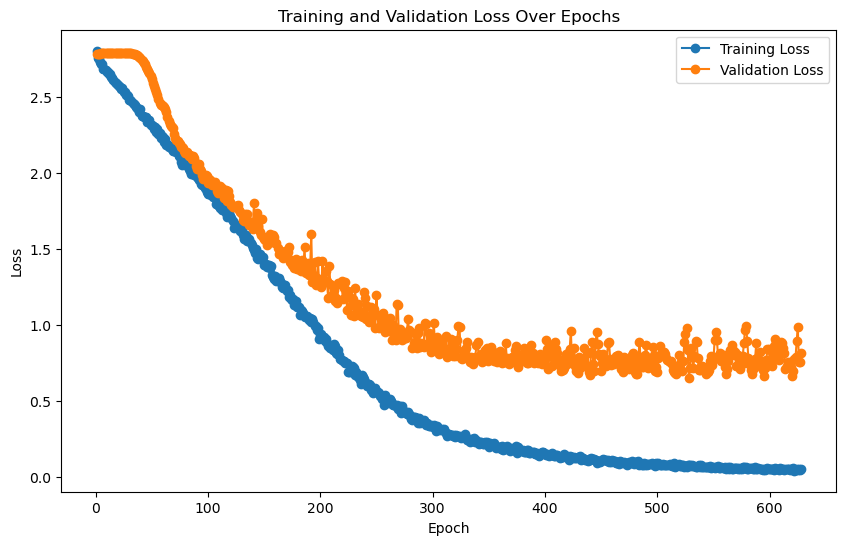

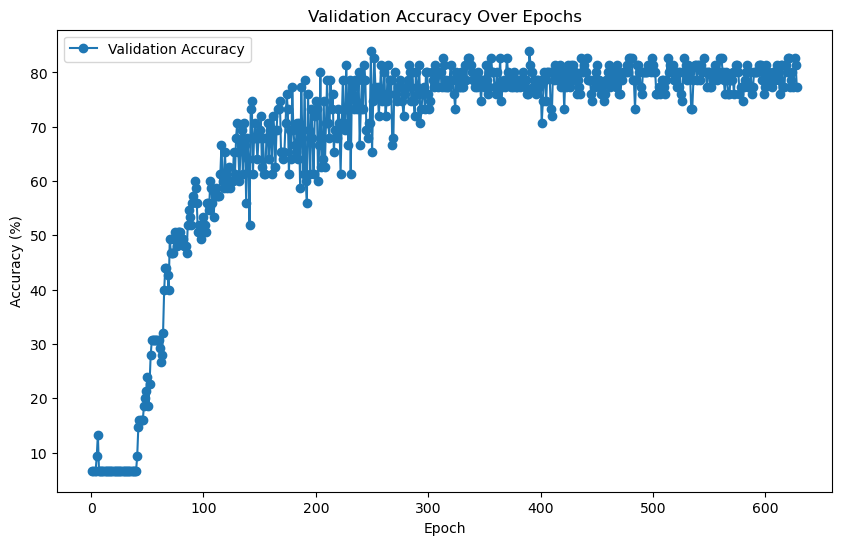


Evaluating on the test set...
    Test Batch [1/39], Loss: 1.1515

Final Test Loss: 1.2395, Test Accuracy: 64.98%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/39 for test dataset.


  Processed batch 20/39 for test dataset.
  Processed batch 30/39 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 320 samples with 64 features each
LOG: Labels shape: (320,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 75 samples with 64 features each
LOG: Labels shape: (75,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 9854 samples with 64 features each
LOG: Labels shape: (9854,)

LOG: Training features shape: (320, 64), Training labels shape: (320,)
LOG: Validation features shape: (75, 64), Validation labels shape: (75,)
LOG: Test features shape: (9854, 64), Test labels shape: (9854,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 60.00%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.38      0.60      0.46         5
           2       0.17      0.20      0.18         5
           3       1.00      0.40      0.57         5
           4       1.00      0.60      0.75         5
           5       0.33      0.20      0.25         5
           6       1.00      1.00      1.00         5
           7       0.83      1.00      0.91         5
           8       0.00      0.00  

C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_clas

### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 320 samples with 64 features each
LOG: Labels shape: (320,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 75 samples with 64 features each
LOG: Labels shape: (75,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 9854 samples with 64 features each
LOG: Labels shape: (9854,)
Train reps shape: (320, 64)
Train labels shape: (320,)
Val reps shape: (75, 64)
Val labels shape: (75,)
Test reps shape: (9854, 64)
Test labels shape: (9854,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.7988  |  Val Loss: 2.7031
Validation loss improved from inf to 2.7031.
[Epoch 2/1000] Train Loss: 2.6504  |  Val Loss: 2.5902
Validation loss improved from 2.7031 to 2.5902.
[Epoch 3/1000] Train Loss: 2.5797  |  Val Loss: 2.5159
Validation loss improved from 2.5902 to 2.5159.
[Epoch 4/1000] Train Loss: 2.5158  |  Val Loss: 2.4514
Validation loss improved from 2.5159 to 2.4514.
[Epoch 5/1000] Train Loss: 2.4405  |  Val Loss: 2.3780
Validation loss improved from 2.4514 to 2.3780.
[Epoch 6/1000] Train Loss: 2.3649  |  Val Loss: 2.3040
Validation loss improved from 2.3780 to 2.3040.
[Epoch 7/1000] Train Loss: 2.2846  |  Val Loss: 2.2190
Validation loss improved from 2.3040 to 2.2190.
[Epoch 8/1000] Train Loss: 2.2017  |  Val Loss: 2.1476
Validation loss improved from 2.2190 to 2.1476.
[Epoch 9/1000] Train Loss: 2.1228  |  Val Loss: 2.0925
Validation loss improved from 2.1476 to 2.0925.
[Epoch 10/1000] Train Loss: 2.0499  |  Val Loss: 2.0298
Validation loss impr

[Epoch 13/1000] Train Loss: 1.8512  |  Val Loss: 1.8941
Validation loss improved from 1.9301 to 1.8941.
[Epoch 14/1000] Train Loss: 1.7923  |  Val Loss: 1.8413
Validation loss improved from 1.8941 to 1.8413.
[Epoch 15/1000] Train Loss: 1.7339  |  Val Loss: 1.7939
Validation loss improved from 1.8413 to 1.7939.
[Epoch 16/1000] Train Loss: 1.6677  |  Val Loss: 1.7488
Validation loss improved from 1.7939 to 1.7488.
[Epoch 17/1000] Train Loss: 1.6029  |  Val Loss: 1.7115
Validation loss improved from 1.7488 to 1.7115.
[Epoch 18/1000] Train Loss: 1.5554  |  Val Loss: 1.6584
Validation loss improved from 1.7115 to 1.6584.
[Epoch 19/1000] Train Loss: 1.5105  |  Val Loss: 1.6292
Validation loss improved from 1.6584 to 1.6292.
[Epoch 20/1000] Train Loss: 1.4434  |  Val Loss: 1.5745
Validation loss improved from 1.6292 to 1.5745.


[Epoch 21/1000] Train Loss: 1.4030  |  Val Loss: 1.5391
Validation loss improved from 1.5745 to 1.5391.
[Epoch 22/1000] Train Loss: 1.3580  |  Val Loss: 1.5203
Validation loss improved from 1.5391 to 1.5203.
[Epoch 23/1000] Train Loss: 1.3169  |  Val Loss: 1.4757
Validation loss improved from 1.5203 to 1.4757.
[Epoch 24/1000] Train Loss: 1.2689  |  Val Loss: 1.4219
Validation loss improved from 1.4757 to 1.4219.
[Epoch 25/1000] Train Loss: 1.2224  |  Val Loss: 1.4236
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 26/1000] Train Loss: 1.1989  |  Val Loss: 1.3869
Validation loss improved from 1.4219 to 1.3869.
[Epoch 27/1000] Train Loss: 1.1600  |  Val Loss: 1.3315
Validation loss improved from 1.3869 to 1.3315.
[Epoch 28/1000] Train Loss: 1.1313  |  Val Loss: 1.3332
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 29/1000] Train Loss: 1.1168  |  Val Loss: 1.3315
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 30/1000] Train Loss: 1.0913  |  Val Los

[Epoch 32/1000] Train Loss: 1.0376  |  Val Loss: 1.2786
Validation loss improved from 1.2931 to 1.2786.
[Epoch 33/1000] Train Loss: 1.0081  |  Val Loss: 1.2639
Validation loss improved from 1.2786 to 1.2639.
[Epoch 34/1000] Train Loss: 0.9903  |  Val Loss: 1.2523
Validation loss improved from 1.2639 to 1.2523.
[Epoch 35/1000] Train Loss: 0.9837  |  Val Loss: 1.2760
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 36/1000] Train Loss: 0.9568  |  Val Loss: 1.2332
Validation loss improved from 1.2523 to 1.2332.
[Epoch 37/1000] Train Loss: 0.9446  |  Val Loss: 1.2387
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 38/1000] Train Loss: 0.9251  |  Val Loss: 1.2524
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 39/1000] Train Loss: 0.9136  |  Val Loss: 1.2309
Validation loss improved from 1.2332 to 1.2309.
[Epoch 40/1000] Train Loss: 0.9030  |  Val Loss: 1.2313
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 41/1000] Train Loss: 0.8898  |  Val Loss: 1.2399
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 42/1000] Train Loss: 0.8734  |  Val Loss: 1.2091
Validation loss improved from 1.2309 to 1.2091.
[Epoch 43/1000] Train Loss: 0.8668  |  Val Loss: 1.2345
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 44/1000] Train Loss: 0.8630  |  Val Loss: 1.2126
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 45/1000] Train Loss: 0.8357  |  Val Loss: 1.2020
Validation loss improved from 1.2091 to 1.2020.
[Epoch 46/1000] Train Loss: 0.8310  |  Val Loss: 1.2066
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 47/1000] Train Loss: 0.8165  |  Val Loss: 1.2045
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 48/1000] Train Loss: 

[Epoch 50/1000] Train Loss: 0.7880  |  Val Loss: 1.1914
Validation loss improved from 1.1964 to 1.1914.
[Epoch 51/1000] Train Loss: 0.7823  |  Val Loss: 1.1990
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 52/1000] Train Loss: 0.7665  |  Val Loss: 1.1922
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 53/1000] Train Loss: 0.7519  |  Val Loss: 1.1968
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 54/1000] Train Loss: 0.7467  |  Val Loss: 1.1934
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 55/1000] Train Loss: 0.7457  |  Val Loss: 1.1741
Validation loss improved from 1.1914 to 1.1741.
[Epoch 56/1000] Train Loss: 0.7268  |  Val Loss: 1.1828
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 57/1000] Train Loss: 0.7192  |  Val Loss: 1.1991
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 58/1000] Train Loss: 0.7033  |  Val Loss: 1.1833
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 59/1000] Train Loss: 0.7083  |  Val Loss: 1.1816
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 60/1000] Train Loss: 0.6947  |  Val Loss: 1.2011
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 61/1000] Train Loss: 0.6871  |  Val Loss: 1.1812
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 62/1000] Train Loss: 0.6802  |  Val Loss: 1.1897
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 63/1000] Train Loss: 0.6697  |  Val Loss: 1.1839
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 64/1000] Train Loss: 0.6606  |  Val Loss: 1.1832
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 65/1000] Train Loss: 0.6660  |  Val Loss: 1.2017
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 66

[Epoch 67/1000] Train Loss: 0.6506  |  Val Loss: 1.1936
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 68/1000] Train Loss: 0.6349  |  Val Loss: 1.2099
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 69/1000] Train Loss: 0.6319  |  Val Loss: 1.1846
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 70/1000] Train Loss: 0.6261  |  Val Loss: 1.2074
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 71/1000] Train Loss: 0.6207  |  Val Loss: 1.1739
Validation loss improved from 1.1741 to 1.1739.
[Epoch 72/1000] Train Loss: 0.6270  |  Val Loss: 1.1947
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 73/1000] Train Loss: 0.6074  |  Val Loss: 1.2087
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 74/1000] Train Loss: 0.5910  |  Val Loss: 1.2051
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 75/1000] Train Loss: 0.5930  |  Val Loss: 1.1934
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 76/1000] Train Loss: 0.5798  |  Val Loss: 1.2006
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 77/1000] Train Loss: 0.5758  |  Val Loss: 1.1932
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 78/1000] Train Loss: 0.5690  |  Val Loss: 1.1859
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 79/1000] Train Loss: 0.5671  |  Val Loss: 1.2056
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 80/1000] Train Loss: 0.5620  |  Val Loss: 1.2244
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 81/1000] Train Loss: 0.5696  |  Val Loss: 1.1820
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 82

[Epoch 87/1000] Train Loss: 0.5406  |  Val Loss: 1.2156
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 88/1000] Train Loss: 0.5291  |  Val Loss: 1.2045
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 89/1000] Train Loss: 0.5127  |  Val Loss: 1.2440
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 90/1000] Train Loss: 0.5145  |  Val Loss: 1.2081
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 91/1000] Train Loss: 0.5065  |  Val Loss: 1.2036
!! Validation loss did NOT improve !! Patience: 20/100


[Epoch 92/1000] Train Loss: 0.5008  |  Val Loss: 1.2287
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 93/1000] Train Loss: 0.4805  |  Val Loss: 1.2140
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 94/1000] Train Loss: 0.4919  |  Val Loss: 1.2155
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 95/1000] Train Loss: 0.4845  |  Val Loss: 1.2121
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 96/1000] Train Loss: 0.4668  |  Val Loss: 1.2197
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 97/1000] Train Loss: 0.4738  |  Val Loss: 1.2076
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 98/1000] Train Loss: 0.4624  |  Val Loss: 1.2339
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 99/1000] Train Loss: 0.4656  |  Val Loss: 1.2152
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 100/1000] Train Loss: 0.4530  |  Val Loss: 1.2217
!! Validation loss did NOT improve !! Patience: 29/100


[Epoch 107/1000] Train Loss: 0.4161  |  Val Loss: 1.2312
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 108/1000] Train Loss: 0.4235  |  Val Loss: 1.2232
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 109/1000] Train Loss: 0.4199  |  Val Loss: 1.2248
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 110/1000] Train Loss: 0.4126  |  Val Loss: 1.2252
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 111/1000] Train Loss: 0.4073  |  Val Loss: 1.2537
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 112/1000] Train Loss: 0.4088  |  Val Loss: 1.2211
!! Validation loss did NOT improve !! Patience: 41/100


[Epoch 113/1000] Train Loss: 0.3884  |  Val Loss: 1.2478
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 114/1000] Train Loss: 0.4042  |  Val Loss: 1.2370
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 115/1000] Train Loss: 0.3870  |  Val Loss: 1.2369
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 116/1000] Train Loss: 0.3856  |  Val Loss: 1.2574
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 117/1000] Train Loss: 0.3906  |  Val Loss: 1.2445
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 118/1000] Train Loss: 0.3873  |  Val Loss: 1.2306
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 119/1000] Train Loss: 0.3882  |  Val Loss: 1.2506
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 120/1000] Train Loss: 0.3821  |  Val Loss: 1.2407
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 121/1000] Train Loss: 0.3752  |  Val Loss: 1.2812
!! Validation loss did NOT improve !! Patience:

[Epoch 127/1000] Train Loss: 0.3600  |  Val Loss: 1.2530
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 128/1000] Train Loss: 0.3434  |  Val Loss: 1.2725
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 129/1000] Train Loss: 0.3585  |  Val Loss: 1.2659
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 130/1000] Train Loss: 0.3462  |  Val Loss: 1.2587
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 131/1000] Train Loss: 0.3448  |  Val Loss: 1.2745
!! Validation loss did NOT improve !! Patience: 60/100


[Epoch 132/1000] Train Loss: 0.3421  |  Val Loss: 1.2663
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 133/1000] Train Loss: 0.3302  |  Val Loss: 1.2934
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 134/1000] Train Loss: 0.3226  |  Val Loss: 1.2654
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 135/1000] Train Loss: 0.3338  |  Val Loss: 1.2956
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 136/1000] Train Loss: 0.3253  |  Val Loss: 1.2875
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 137/1000] Train Loss: 0.3278  |  Val Loss: 1.2873
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 138/1000] Train Loss: 0.3212  |  Val Loss: 1.2870
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 139/1000] Train Loss: 0.3220  |  Val Loss: 1.2907
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 140/1000] Train Loss: 0.3125  |  Val Loss: 1.2910
!! Validation loss did NOT improve !! Patience:

[Epoch 145/1000] Train Loss: 0.3039  |  Val Loss: 1.3085
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 146/1000] Train Loss: 0.3021  |  Val Loss: 1.3092
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 147/1000] Train Loss: 0.2924  |  Val Loss: 1.2792
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 148/1000] Train Loss: 0.2886  |  Val Loss: 1.2876
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 149/1000] Train Loss: 0.2857  |  Val Loss: 1.3021
!! Validation loss did NOT improve !! Patience: 78/100


[Epoch 150/1000] Train Loss: 0.2815  |  Val Loss: 1.3101
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 151/1000] Train Loss: 0.2951  |  Val Loss: 1.3089
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 152/1000] Train Loss: 0.2792  |  Val Loss: 1.2938
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 153/1000] Train Loss: 0.2825  |  Val Loss: 1.3001
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 154/1000] Train Loss: 0.2711  |  Val Loss: 1.3080
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 155/1000] Train Loss: 0.2674  |  Val Loss: 1.3023
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 156/1000] Train Loss: 0.2783  |  Val Loss: 1.3157
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 157/1000] Train Loss: 0.2732  |  Val Loss: 1.3012
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 158/1000] Train Loss: 0.2618  |  Val Loss: 1.3276
!! Validation loss did NOT improve !! Patience:

[Epoch 163/1000] Train Loss: 0.2681  |  Val Loss: 1.2971
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 164/1000] Train Loss: 0.2598  |  Val Loss: 1.3193
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 165/1000] Train Loss: 0.2503  |  Val Loss: 1.3405
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 166/1000] Train Loss: 0.2500  |  Val Loss: 1.3267
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 167/1000] Train Loss: 0.2525  |  Val Loss: 1.3457
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 168/1000] Train Loss: 0.2504  |  Val Loss: 1.3297
!! Validation loss did NOT improve !! Patience: 97/100


[Epoch 169/1000] Train Loss: 0.2386  |  Val Loss: 1.3333
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 170/1000] Train Loss: 0.2463  |  Val Loss: 1.3245
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 171/1000] Train Loss: 0.2358  |  Val Loss: 1.3372
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 171 !!
No improvement for 100 epochs.


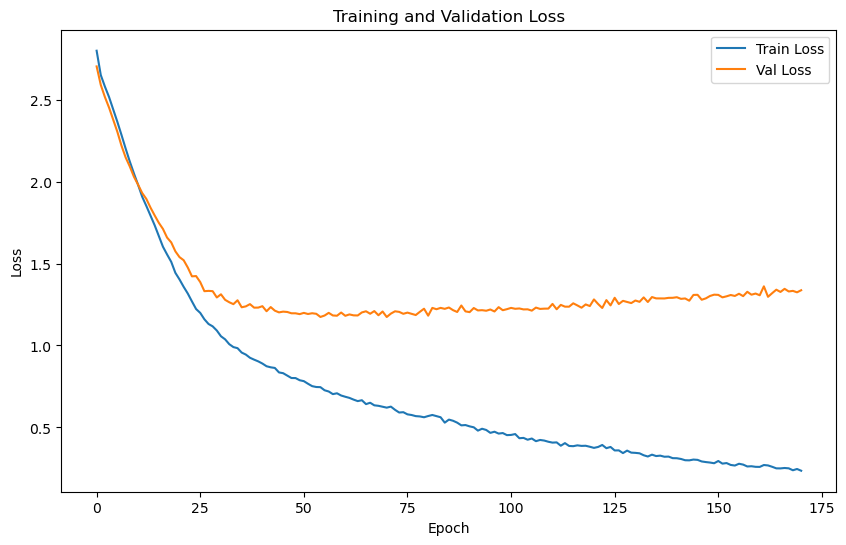

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 2.0060 | Test Accuracy: 51.07%


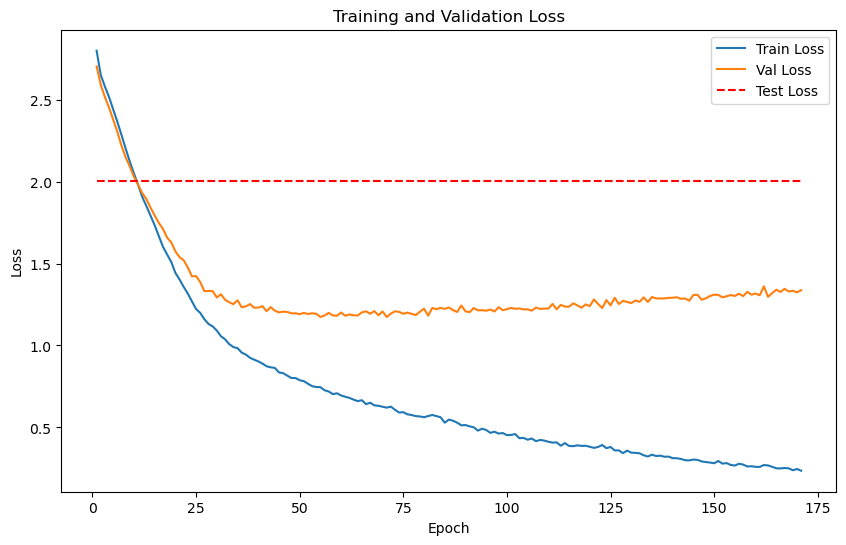

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 320 samples with 64 features each
LOG: Labels shape: (320,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 75 samples with 64 features each
LOG: Labels shape: (75,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 9854 samples with 64 features each
LOG: Labels shape: (9854,)


Train embeddings shape: (320, 64), 
Train labels shape: (320,)


Val embeddings shape: (75, 64), 
Val labels shape: (75,)


Test embeddings shape: (9854, 64), 
Test labels shape: (9854,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20, 13: 20, 14: 20, 15: 20}
Training batch size: 320


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 9.1328
Epoch [1/2000], Avg Train Loss: 9.1328
Epoch [1/2000], Avg Val Loss: 5.0906
Validation loss improved from inf to 5.0906. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 8.9986
Epoch [2/2000], Avg Train Loss: 8.9986
Epoch [2/2000], Avg Val Loss: 5.0384
Validation loss improved from 5.0906 to 5.0384. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 8.9790
Epoch [3/2000], Avg Train Loss: 8.9790
Epoch [3/2000], Avg Val Loss: 4.9880
Validation loss improved from 5.0384 to 4.9880. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 8.9586
Epoch [4/2000], Avg Train Loss: 8.9586
Epoch [4/2000], Avg Val Loss: 4.9386
Validation loss improved from 4.9880 to 4.9386. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 8.7104
Epoch [5/2000], Avg Train Loss: 8.7104
Epoch [5/2000], Avg Val Loss: 4.8901
Validation loss improved from 4.9386 to 4.8901. Saving mode

    Batch [1/1], Train Loss: 8.1321
Epoch [14/2000], Avg Train Loss: 8.1321
Epoch [14/2000], Avg Val Loss: 4.5032
Validation loss improved from 4.5419 to 4.5032. Saving model...

LOG: Epoch [15/2000] - Training
    Batch [1/1], Train Loss: 8.1544
Epoch [15/2000], Avg Train Loss: 8.1544
Epoch [15/2000], Avg Val Loss: 4.4654
Validation loss improved from 4.5032 to 4.4654. Saving model...

LOG: Epoch [16/2000] - Training
    Batch [1/1], Train Loss: 8.0768
Epoch [16/2000], Avg Train Loss: 8.0768
Epoch [16/2000], Avg Val Loss: 4.4286
Validation loss improved from 4.4654 to 4.4286. Saving model...

LOG: Epoch [17/2000] - Training
    Batch [1/1], Train Loss: 7.9989
Epoch [17/2000], Avg Train Loss: 7.9989
Epoch [17/2000], Avg Val Loss: 4.3929
Validation loss improved from 4.4286 to 4.3929. Saving model...

LOG: Epoch [18/2000] - Training
    Batch [1/1], Train Loss: 7.8854
Epoch [18/2000], Avg Train Loss: 7.8854
Epoch [18/2000], Avg Val Loss: 4.3581
Validation loss improved from 4.3929 to 4.

    Batch [1/1], Train Loss: 7.5395
Epoch [23/2000], Avg Train Loss: 7.5395
Epoch [23/2000], Avg Val Loss: 4.1994
Validation loss improved from 4.2291 to 4.1994. Saving model...

LOG: Epoch [24/2000] - Training
    Batch [1/1], Train Loss: 7.5907
Epoch [24/2000], Avg Train Loss: 7.5907
Epoch [24/2000], Avg Val Loss: 4.1705
Validation loss improved from 4.1994 to 4.1705. Saving model...

LOG: Epoch [25/2000] - Training
    Batch [1/1], Train Loss: 7.5238
Epoch [25/2000], Avg Train Loss: 7.5238
Epoch [25/2000], Avg Val Loss: 4.1426
Validation loss improved from 4.1705 to 4.1426. Saving model...

LOG: Epoch [26/2000] - Training
    Batch [1/1], Train Loss: 7.4227
Epoch [26/2000], Avg Train Loss: 7.4227
Epoch [26/2000], Avg Val Loss: 4.1157
Validation loss improved from 4.1426 to 4.1157. Saving model...

LOG: Epoch [27/2000] - Training
    Batch [1/1], Train Loss: 7.2668
Epoch [27/2000], Avg Train Loss: 7.2668
Epoch [27/2000], Avg Val Loss: 4.0896
Validation loss improved from 4.1157 to 4.

    Batch [1/1], Train Loss: 6.8166
Epoch [39/2000], Avg Train Loss: 6.8166
Epoch [39/2000], Avg Val Loss: 3.8425
Validation loss improved from 3.8589 to 3.8425. Saving model...

LOG: Epoch [40/2000] - Training
    Batch [1/1], Train Loss: 6.7273
Epoch [40/2000], Avg Train Loss: 6.7273
Epoch [40/2000], Avg Val Loss: 3.8267
Validation loss improved from 3.8425 to 3.8267. Saving model...

LOG: Epoch [41/2000] - Training
    Batch [1/1], Train Loss: 6.6431
Epoch [41/2000], Avg Train Loss: 6.6431
Epoch [41/2000], Avg Val Loss: 3.8116
Validation loss improved from 3.8267 to 3.8116. Saving model...

LOG: Epoch [42/2000] - Training
    Batch [1/1], Train Loss: 6.6949
Epoch [42/2000], Avg Train Loss: 6.6949
Epoch [42/2000], Avg Val Loss: 3.7971
Validation loss improved from 3.8116 to 3.7971. Saving model...

LOG: Epoch [43/2000] - Training
    Batch [1/1], Train Loss: 6.6221
Epoch [43/2000], Avg Train Loss: 6.6221
Epoch [43/2000], Avg Val Loss: 3.7833
Validation loss improved from 3.7971 to 3.

    Batch [1/1], Train Loss: 6.2974
Epoch [52/2000], Avg Train Loss: 6.2974
Epoch [52/2000], Avg Val Loss: 3.6820
Validation loss improved from 3.6914 to 3.6820. Saving model...

LOG: Epoch [53/2000] - Training
    Batch [1/1], Train Loss: 6.2447
Epoch [53/2000], Avg Train Loss: 6.2447
Epoch [53/2000], Avg Val Loss: 3.6731
Validation loss improved from 3.6820 to 3.6731. Saving model...

LOG: Epoch [54/2000] - Training
    Batch [1/1], Train Loss: 6.2542
Epoch [54/2000], Avg Train Loss: 6.2542
Epoch [54/2000], Avg Val Loss: 3.6645
Validation loss improved from 3.6731 to 3.6645. Saving model...

LOG: Epoch [55/2000] - Training
    Batch [1/1], Train Loss: 6.1753
Epoch [55/2000], Avg Train Loss: 6.1753
Epoch [55/2000], Avg Val Loss: 3.6564
Validation loss improved from 3.6645 to 3.6564. Saving model...

LOG: Epoch [56/2000] - Training
    Batch [1/1], Train Loss: 6.0422
Epoch [56/2000], Avg Train Loss: 6.0422
Epoch [56/2000], Avg Val Loss: 3.6486
Validation loss improved from 3.6564 to 3.

    Batch [1/1], Train Loss: 6.1565
Epoch [59/2000], Avg Train Loss: 6.1565
Epoch [59/2000], Avg Val Loss: 3.6272
Validation loss improved from 3.6340 to 3.6272. Saving model...

LOG: Epoch [60/2000] - Training
    Batch [1/1], Train Loss: 6.0905
Epoch [60/2000], Avg Train Loss: 6.0905
Epoch [60/2000], Avg Val Loss: 3.6206
Validation loss improved from 3.6272 to 3.6206. Saving model...

LOG: Epoch [61/2000] - Training
    Batch [1/1], Train Loss: 5.9965
Epoch [61/2000], Avg Train Loss: 5.9965
Epoch [61/2000], Avg Val Loss: 3.6144
Validation loss improved from 3.6206 to 3.6144. Saving model...

LOG: Epoch [62/2000] - Training
    Batch [1/1], Train Loss: 5.9677
Epoch [62/2000], Avg Train Loss: 5.9677
Epoch [62/2000], Avg Val Loss: 3.6085
Validation loss improved from 3.6144 to 3.6085. Saving model...

LOG: Epoch [63/2000] - Training
    Batch [1/1], Train Loss: 6.0204
Epoch [63/2000], Avg Train Loss: 6.0204
Epoch [63/2000], Avg Val Loss: 3.6028
Validation loss improved from 3.6085 to 3.

    Batch [1/1], Train Loss: 5.7932
Epoch [73/2000], Avg Train Loss: 5.7932
Epoch [73/2000], Avg Val Loss: 3.5578
Validation loss improved from 3.5615 to 3.5578. Saving model...

LOG: Epoch [74/2000] - Training
    Batch [1/1], Train Loss: 5.8219
Epoch [74/2000], Avg Train Loss: 5.8219
Epoch [74/2000], Avg Val Loss: 3.5543
Validation loss improved from 3.5578 to 3.5543. Saving model...

LOG: Epoch [75/2000] - Training
    Batch [1/1], Train Loss: 5.7741
Epoch [75/2000], Avg Train Loss: 5.7741
Epoch [75/2000], Avg Val Loss: 3.5509
Validation loss improved from 3.5543 to 3.5509. Saving model...

LOG: Epoch [76/2000] - Training
    Batch [1/1], Train Loss: 5.7466
Epoch [76/2000], Avg Train Loss: 5.7466
Epoch [76/2000], Avg Val Loss: 3.5477
Validation loss improved from 3.5509 to 3.5477. Saving model...

LOG: Epoch [77/2000] - Training
    Batch [1/1], Train Loss: 5.7446
Epoch [77/2000], Avg Train Loss: 5.7446
Epoch [77/2000], Avg Val Loss: 3.5446
Validation loss improved from 3.5477 to 3.

    Batch [1/1], Train Loss: 5.6642
Epoch [85/2000], Avg Train Loss: 5.6642
Epoch [85/2000], Avg Val Loss: 3.5231
Validation loss improved from 3.5255 to 3.5231. Saving model...

LOG: Epoch [86/2000] - Training
    Batch [1/1], Train Loss: 5.6352
Epoch [86/2000], Avg Train Loss: 5.6352
Epoch [86/2000], Avg Val Loss: 3.5208
Validation loss improved from 3.5231 to 3.5208. Saving model...

LOG: Epoch [87/2000] - Training
    Batch [1/1], Train Loss: 5.6047
Epoch [87/2000], Avg Train Loss: 5.6047
Epoch [87/2000], Avg Val Loss: 3.5186
Validation loss improved from 3.5208 to 3.5186. Saving model...

LOG: Epoch [88/2000] - Training
    Batch [1/1], Train Loss: 5.6229
Epoch [88/2000], Avg Train Loss: 5.6229
Epoch [88/2000], Avg Val Loss: 3.5165
Validation loss improved from 3.5186 to 3.5165. Saving model...

LOG: Epoch [89/2000] - Training
    Batch [1/1], Train Loss: 5.5656
Epoch [89/2000], Avg Train Loss: 5.5656
Epoch [89/2000], Avg Val Loss: 3.5144
Validation loss improved from 3.5165 to 3.

    Batch [1/1], Train Loss: 5.5675
Epoch [93/2000], Avg Train Loss: 5.5675
Epoch [93/2000], Avg Val Loss: 3.5064
Validation loss improved from 3.5084 to 3.5064. Saving model...

LOG: Epoch [94/2000] - Training
    Batch [1/1], Train Loss: 5.5497
Epoch [94/2000], Avg Train Loss: 5.5497
Epoch [94/2000], Avg Val Loss: 3.5045
Validation loss improved from 3.5064 to 3.5045. Saving model...

LOG: Epoch [95/2000] - Training
    Batch [1/1], Train Loss: 5.5500
Epoch [95/2000], Avg Train Loss: 5.5500
Epoch [95/2000], Avg Val Loss: 3.5027
Validation loss improved from 3.5045 to 3.5027. Saving model...

LOG: Epoch [96/2000] - Training
    Batch [1/1], Train Loss: 5.5420
Epoch [96/2000], Avg Train Loss: 5.5420
Epoch [96/2000], Avg Val Loss: 3.5009
Validation loss improved from 3.5027 to 3.5009. Saving model...

LOG: Epoch [97/2000] - Training
    Batch [1/1], Train Loss: 5.5547
Epoch [97/2000], Avg Train Loss: 5.5547
Epoch [97/2000], Avg Val Loss: 3.4991
Validation loss improved from 3.5009 to 3.

Epoch [109/2000], Avg Val Loss: 3.4800
Validation loss improved from 3.4815 to 3.4800. Saving model...

LOG: Epoch [110/2000] - Training
    Batch [1/1], Train Loss: 5.4398
Epoch [110/2000], Avg Train Loss: 5.4398
Epoch [110/2000], Avg Val Loss: 3.4786
Validation loss improved from 3.4800 to 3.4786. Saving model...

LOG: Epoch [111/2000] - Training
    Batch [1/1], Train Loss: 5.4244
Epoch [111/2000], Avg Train Loss: 5.4244
Epoch [111/2000], Avg Val Loss: 3.4772
Validation loss improved from 3.4786 to 3.4772. Saving model...

LOG: Epoch [112/2000] - Training
    Batch [1/1], Train Loss: 5.4205
Epoch [112/2000], Avg Train Loss: 5.4205
Epoch [112/2000], Avg Val Loss: 3.4758
Validation loss improved from 3.4772 to 3.4758. Saving model...

LOG: Epoch [113/2000] - Training
    Batch [1/1], Train Loss: 5.4325
Epoch [113/2000], Avg Train Loss: 5.4325
Epoch [113/2000], Avg Val Loss: 3.4744
Validation loss improved from 3.4758 to 3.4744. Saving model...

LOG: Epoch [114/2000] - Training
    Bat

Epoch [121/2000], Avg Val Loss: 3.4636
Validation loss improved from 3.4650 to 3.4636. Saving model...

LOG: Epoch [122/2000] - Training
    Batch [1/1], Train Loss: 5.3964
Epoch [122/2000], Avg Train Loss: 5.3964
Epoch [122/2000], Avg Val Loss: 3.4623
Validation loss improved from 3.4636 to 3.4623. Saving model...

LOG: Epoch [123/2000] - Training
    Batch [1/1], Train Loss: 5.3989
Epoch [123/2000], Avg Train Loss: 5.3989
Epoch [123/2000], Avg Val Loss: 3.4611
Validation loss improved from 3.4623 to 3.4611. Saving model...

LOG: Epoch [124/2000] - Training
    Batch [1/1], Train Loss: 5.3553
Epoch [124/2000], Avg Train Loss: 5.3553
Epoch [124/2000], Avg Val Loss: 3.4598
Validation loss improved from 3.4611 to 3.4598. Saving model...

LOG: Epoch [125/2000] - Training
    Batch [1/1], Train Loss: 5.3393
Epoch [125/2000], Avg Train Loss: 5.3393
Epoch [125/2000], Avg Val Loss: 3.4585
Validation loss improved from 3.4598 to 3.4585. Saving model...

LOG: Epoch [126/2000] - Training
    Bat

Epoch [129/2000], Avg Val Loss: 3.4536
Validation loss improved from 3.4548 to 3.4536. Saving model...

LOG: Epoch [130/2000] - Training
    Batch [1/1], Train Loss: 5.3668
Epoch [130/2000], Avg Train Loss: 5.3668
Epoch [130/2000], Avg Val Loss: 3.4524
Validation loss improved from 3.4536 to 3.4524. Saving model...

LOG: Epoch [131/2000] - Training
    Batch [1/1], Train Loss: 5.3032
Epoch [131/2000], Avg Train Loss: 5.3032
Epoch [131/2000], Avg Val Loss: 3.4513
Validation loss improved from 3.4524 to 3.4513. Saving model...

LOG: Epoch [132/2000] - Training
    Batch [1/1], Train Loss: 5.3334
Epoch [132/2000], Avg Train Loss: 5.3334
Epoch [132/2000], Avg Val Loss: 3.4501
Validation loss improved from 3.4513 to 3.4501. Saving model...

LOG: Epoch [133/2000] - Training
    Batch [1/1], Train Loss: 5.3338
Epoch [133/2000], Avg Train Loss: 5.3338
Epoch [133/2000], Avg Val Loss: 3.4489
Validation loss improved from 3.4501 to 3.4489. Saving model...

LOG: Epoch [134/2000] - Training
    Bat

    Batch [1/1], Train Loss: 5.3208
Epoch [143/2000], Avg Train Loss: 5.3208
Epoch [143/2000], Avg Val Loss: 3.4370
Validation loss improved from 3.4382 to 3.4370. Saving model...

LOG: Epoch [144/2000] - Training
    Batch [1/1], Train Loss: 5.2513
Epoch [144/2000], Avg Train Loss: 5.2513
Epoch [144/2000], Avg Val Loss: 3.4358
Validation loss improved from 3.4370 to 3.4358. Saving model...

LOG: Epoch [145/2000] - Training
    Batch [1/1], Train Loss: 5.3011
Epoch [145/2000], Avg Train Loss: 5.3011
Epoch [145/2000], Avg Val Loss: 3.4347
Validation loss improved from 3.4358 to 3.4347. Saving model...

LOG: Epoch [146/2000] - Training
    Batch [1/1], Train Loss: 5.2948
Epoch [146/2000], Avg Train Loss: 5.2948
Epoch [146/2000], Avg Val Loss: 3.4336
Validation loss improved from 3.4347 to 3.4336. Saving model...

LOG: Epoch [147/2000] - Training
    Batch [1/1], Train Loss: 5.2856
Epoch [147/2000], Avg Train Loss: 5.2856
Epoch [147/2000], Avg Val Loss: 3.4324
Validation loss improved fro

    Batch [1/1], Train Loss: 5.2402
Epoch [159/2000], Avg Train Loss: 5.2402
Epoch [159/2000], Avg Val Loss: 3.4192
Validation loss improved from 3.4202 to 3.4192. Saving model...

LOG: Epoch [160/2000] - Training
    Batch [1/1], Train Loss: 5.2739
Epoch [160/2000], Avg Train Loss: 5.2739
Epoch [160/2000], Avg Val Loss: 3.4181
Validation loss improved from 3.4192 to 3.4181. Saving model...

LOG: Epoch [161/2000] - Training
    Batch [1/1], Train Loss: 5.2440
Epoch [161/2000], Avg Train Loss: 5.2440
Epoch [161/2000], Avg Val Loss: 3.4170
Validation loss improved from 3.4181 to 3.4170. Saving model...

LOG: Epoch [162/2000] - Training
    Batch [1/1], Train Loss: 5.2336
Epoch [162/2000], Avg Train Loss: 5.2336
Epoch [162/2000], Avg Val Loss: 3.4160
Validation loss improved from 3.4170 to 3.4160. Saving model...

LOG: Epoch [163/2000] - Training
    Batch [1/1], Train Loss: 5.2026
Epoch [163/2000], Avg Train Loss: 5.2026
Epoch [163/2000], Avg Val Loss: 3.4149
Validation loss improved fro

    Batch [1/1], Train Loss: 5.1748
Epoch [166/2000], Avg Train Loss: 5.1748
Epoch [166/2000], Avg Val Loss: 3.4117
Validation loss improved from 3.4128 to 3.4117. Saving model...

LOG: Epoch [167/2000] - Training
    Batch [1/1], Train Loss: 5.2118
Epoch [167/2000], Avg Train Loss: 5.2118
Epoch [167/2000], Avg Val Loss: 3.4107
Validation loss improved from 3.4117 to 3.4107. Saving model...

LOG: Epoch [168/2000] - Training
    Batch [1/1], Train Loss: 5.2062
Epoch [168/2000], Avg Train Loss: 5.2062
Epoch [168/2000], Avg Val Loss: 3.4097
Validation loss improved from 3.4107 to 3.4097. Saving model...

LOG: Epoch [169/2000] - Training
    Batch [1/1], Train Loss: 5.2104
Epoch [169/2000], Avg Train Loss: 5.2104
Epoch [169/2000], Avg Val Loss: 3.4087
Validation loss improved from 3.4097 to 3.4087. Saving model...

LOG: Epoch [170/2000] - Training
    Batch [1/1], Train Loss: 5.1994
Epoch [170/2000], Avg Train Loss: 5.1994
Epoch [170/2000], Avg Val Loss: 3.4077
Validation loss improved fro

    Batch [1/1], Train Loss: 5.1635
Epoch [176/2000], Avg Train Loss: 5.1635
Epoch [176/2000], Avg Val Loss: 3.4018
Validation loss improved from 3.4028 to 3.4018. Saving model...

LOG: Epoch [177/2000] - Training
    Batch [1/1], Train Loss: 5.1816
Epoch [177/2000], Avg Train Loss: 5.1816
Epoch [177/2000], Avg Val Loss: 3.4008
Validation loss improved from 3.4018 to 3.4008. Saving model...

LOG: Epoch [178/2000] - Training
    Batch [1/1], Train Loss: 5.1547
Epoch [178/2000], Avg Train Loss: 5.1547
Epoch [178/2000], Avg Val Loss: 3.3998
Validation loss improved from 3.4008 to 3.3998. Saving model...

LOG: Epoch [179/2000] - Training
    Batch [1/1], Train Loss: 5.1842
Epoch [179/2000], Avg Train Loss: 5.1842
Epoch [179/2000], Avg Val Loss: 3.3989
Validation loss improved from 3.3998 to 3.3989. Saving model...

LOG: Epoch [180/2000] - Training
    Batch [1/1], Train Loss: 5.1992
Epoch [180/2000], Avg Train Loss: 5.1992
Epoch [180/2000], Avg Val Loss: 3.3979
Validation loss improved fro

    Batch [1/1], Train Loss: 5.1610
Epoch [193/2000], Avg Train Loss: 5.1610
Epoch [193/2000], Avg Val Loss: 3.3856
Validation loss improved from 3.3866 to 3.3856. Saving model...

LOG: Epoch [194/2000] - Training
    Batch [1/1], Train Loss: 5.1615
Epoch [194/2000], Avg Train Loss: 5.1615
Epoch [194/2000], Avg Val Loss: 3.3847
Validation loss improved from 3.3856 to 3.3847. Saving model...

LOG: Epoch [195/2000] - Training
    Batch [1/1], Train Loss: 5.1131
Epoch [195/2000], Avg Train Loss: 5.1131
Epoch [195/2000], Avg Val Loss: 3.3837
Validation loss improved from 3.3847 to 3.3837. Saving model...

LOG: Epoch [196/2000] - Training
    Batch [1/1], Train Loss: 5.0919
Epoch [196/2000], Avg Train Loss: 5.0919
Epoch [196/2000], Avg Val Loss: 3.3827
Validation loss improved from 3.3837 to 3.3827. Saving model...

LOG: Epoch [197/2000] - Training
    Batch [1/1], Train Loss: 5.1135
Epoch [197/2000], Avg Train Loss: 5.1135
Epoch [197/2000], Avg Val Loss: 3.3818
Validation loss improved fro

Epoch [201/2000], Avg Val Loss: 3.3782
Validation loss improved from 3.3790 to 3.3782. Saving model...

LOG: Epoch [202/2000] - Training
    Batch [1/1], Train Loss: 5.1038
Epoch [202/2000], Avg Train Loss: 5.1038
Epoch [202/2000], Avg Val Loss: 3.3772
Validation loss improved from 3.3782 to 3.3772. Saving model...

LOG: Epoch [203/2000] - Training
    Batch [1/1], Train Loss: 5.1362
Epoch [203/2000], Avg Train Loss: 5.1362
Epoch [203/2000], Avg Val Loss: 3.3763
Validation loss improved from 3.3772 to 3.3763. Saving model...

LOG: Epoch [204/2000] - Training
    Batch [1/1], Train Loss: 5.0793
Epoch [204/2000], Avg Train Loss: 5.0793
Epoch [204/2000], Avg Val Loss: 3.3754
Validation loss improved from 3.3763 to 3.3754. Saving model...

LOG: Epoch [205/2000] - Training
    Batch [1/1], Train Loss: 5.1072
Epoch [205/2000], Avg Train Loss: 5.1072
Epoch [205/2000], Avg Val Loss: 3.3745
Validation loss improved from 3.3754 to 3.3745. Saving model...

LOG: Epoch [206/2000] - Training
    Bat

Epoch [212/2000], Avg Val Loss: 3.3683
Validation loss improved from 3.3692 to 3.3683. Saving model...

LOG: Epoch [213/2000] - Training
    Batch [1/1], Train Loss: 5.0732
Epoch [213/2000], Avg Train Loss: 5.0732
Epoch [213/2000], Avg Val Loss: 3.3674
Validation loss improved from 3.3683 to 3.3674. Saving model...

LOG: Epoch [214/2000] - Training
    Batch [1/1], Train Loss: 5.0735
Epoch [214/2000], Avg Train Loss: 5.0735
Epoch [214/2000], Avg Val Loss: 3.3666
Validation loss improved from 3.3674 to 3.3666. Saving model...

LOG: Epoch [215/2000] - Training
    Batch [1/1], Train Loss: 5.1097
Epoch [215/2000], Avg Train Loss: 5.1097
Epoch [215/2000], Avg Val Loss: 3.3657
Validation loss improved from 3.3666 to 3.3657. Saving model...

LOG: Epoch [216/2000] - Training
    Batch [1/1], Train Loss: 5.0711
Epoch [216/2000], Avg Train Loss: 5.0711
Epoch [216/2000], Avg Val Loss: 3.3649
Validation loss improved from 3.3657 to 3.3649. Saving model...

LOG: Epoch [217/2000] - Training
    Bat

    Batch [1/1], Train Loss: 5.0561
Epoch [231/2000], Avg Train Loss: 5.0561
Epoch [231/2000], Avg Val Loss: 3.3522
Validation loss improved from 3.3531 to 3.3522. Saving model...

LOG: Epoch [232/2000] - Training
    Batch [1/1], Train Loss: 5.0509
Epoch [232/2000], Avg Train Loss: 5.0509
Epoch [232/2000], Avg Val Loss: 3.3514
Validation loss improved from 3.3522 to 3.3514. Saving model...

LOG: Epoch [233/2000] - Training
    Batch [1/1], Train Loss: 5.0509
Epoch [233/2000], Avg Train Loss: 5.0509
Epoch [233/2000], Avg Val Loss: 3.3506
Validation loss improved from 3.3514 to 3.3506. Saving model...

LOG: Epoch [234/2000] - Training
    Batch [1/1], Train Loss: 5.0291
Epoch [234/2000], Avg Train Loss: 5.0291
Epoch [234/2000], Avg Val Loss: 3.3497
Validation loss improved from 3.3506 to 3.3497. Saving model...

LOG: Epoch [235/2000] - Training
    Batch [1/1], Train Loss: 5.0463
Epoch [235/2000], Avg Train Loss: 5.0463
Epoch [235/2000], Avg Val Loss: 3.3489
Validation loss improved fro

    Batch [1/1], Train Loss: 5.0203
Epoch [239/2000], Avg Train Loss: 5.0203
Epoch [239/2000], Avg Val Loss: 3.3455
Validation loss improved from 3.3463 to 3.3455. Saving model...

LOG: Epoch [240/2000] - Training
    Batch [1/1], Train Loss: 5.0624
Epoch [240/2000], Avg Train Loss: 5.0624
Epoch [240/2000], Avg Val Loss: 3.3447
Validation loss improved from 3.3455 to 3.3447. Saving model...

LOG: Epoch [241/2000] - Training
    Batch [1/1], Train Loss: 5.0229
Epoch [241/2000], Avg Train Loss: 5.0229
Epoch [241/2000], Avg Val Loss: 3.3438
Validation loss improved from 3.3447 to 3.3438. Saving model...

LOG: Epoch [242/2000] - Training
    Batch [1/1], Train Loss: 5.0241
Epoch [242/2000], Avg Train Loss: 5.0241
Epoch [242/2000], Avg Val Loss: 3.3430
Validation loss improved from 3.3438 to 3.3430. Saving model...

LOG: Epoch [243/2000] - Training
    Batch [1/1], Train Loss: 4.9975
Epoch [243/2000], Avg Train Loss: 4.9975
Epoch [243/2000], Avg Val Loss: 3.3423
Validation loss improved fro

    Batch [1/1], Train Loss: 4.9733
Epoch [251/2000], Avg Train Loss: 4.9733
Epoch [251/2000], Avg Val Loss: 3.3359
Validation loss improved from 3.3366 to 3.3359. Saving model...

LOG: Epoch [252/2000] - Training
    Batch [1/1], Train Loss: 5.0302
Epoch [252/2000], Avg Train Loss: 5.0302
Epoch [252/2000], Avg Val Loss: 3.3351
Validation loss improved from 3.3359 to 3.3351. Saving model...

LOG: Epoch [253/2000] - Training
    Batch [1/1], Train Loss: 4.9788
Epoch [253/2000], Avg Train Loss: 4.9788
Epoch [253/2000], Avg Val Loss: 3.3343
Validation loss improved from 3.3351 to 3.3343. Saving model...

LOG: Epoch [254/2000] - Training
    Batch [1/1], Train Loss: 4.9578
Epoch [254/2000], Avg Train Loss: 4.9578
Epoch [254/2000], Avg Val Loss: 3.3336
Validation loss improved from 3.3343 to 3.3336. Saving model...

LOG: Epoch [255/2000] - Training
    Batch [1/1], Train Loss: 4.9990
Epoch [255/2000], Avg Train Loss: 4.9990
Epoch [255/2000], Avg Val Loss: 3.3328
Validation loss improved fro

    Batch [1/1], Train Loss: 4.9904
Epoch [267/2000], Avg Train Loss: 4.9904
Epoch [267/2000], Avg Val Loss: 3.3237
Validation loss improved from 3.3244 to 3.3237. Saving model...

LOG: Epoch [268/2000] - Training
    Batch [1/1], Train Loss: 4.9558
Epoch [268/2000], Avg Train Loss: 4.9558
Epoch [268/2000], Avg Val Loss: 3.3230
Validation loss improved from 3.3237 to 3.3230. Saving model...

LOG: Epoch [269/2000] - Training
    Batch [1/1], Train Loss: 4.9943
Epoch [269/2000], Avg Train Loss: 4.9943
Epoch [269/2000], Avg Val Loss: 3.3223
Validation loss improved from 3.3230 to 3.3223. Saving model...

LOG: Epoch [270/2000] - Training
    Batch [1/1], Train Loss: 4.9645
Epoch [270/2000], Avg Train Loss: 4.9645
Epoch [270/2000], Avg Val Loss: 3.3216
Validation loss improved from 3.3223 to 3.3216. Saving model...

LOG: Epoch [271/2000] - Training
    Batch [1/1], Train Loss: 4.9717
Epoch [271/2000], Avg Train Loss: 4.9717
Epoch [271/2000], Avg Val Loss: 3.3209
Validation loss improved fro

    Batch [1/1], Train Loss: 4.9476
Epoch [275/2000], Avg Train Loss: 4.9476
Epoch [275/2000], Avg Val Loss: 3.3183
Validation loss improved from 3.3189 to 3.3183. Saving model...

LOG: Epoch [276/2000] - Training
    Batch [1/1], Train Loss: 4.9384
Epoch [276/2000], Avg Train Loss: 4.9384
Epoch [276/2000], Avg Val Loss: 3.3176
Validation loss improved from 3.3183 to 3.3176. Saving model...

LOG: Epoch [277/2000] - Training
    Batch [1/1], Train Loss: 4.9536
Epoch [277/2000], Avg Train Loss: 4.9536
Epoch [277/2000], Avg Val Loss: 3.3169
Validation loss improved from 3.3176 to 3.3169. Saving model...

LOG: Epoch [278/2000] - Training
    Batch [1/1], Train Loss: 4.9401
Epoch [278/2000], Avg Train Loss: 4.9401
Epoch [278/2000], Avg Val Loss: 3.3163
Validation loss improved from 3.3169 to 3.3163. Saving model...

LOG: Epoch [279/2000] - Training
    Batch [1/1], Train Loss: 4.9455
Epoch [279/2000], Avg Train Loss: 4.9455
Epoch [279/2000], Avg Val Loss: 3.3157
Validation loss improved fro

    Batch [1/1], Train Loss: 4.9356
Epoch [289/2000], Avg Train Loss: 4.9356
Epoch [289/2000], Avg Val Loss: 3.3092
Validation loss improved from 3.3099 to 3.3092. Saving model...

LOG: Epoch [290/2000] - Training
    Batch [1/1], Train Loss: 4.9458
Epoch [290/2000], Avg Train Loss: 4.9458
Epoch [290/2000], Avg Val Loss: 3.3085
Validation loss improved from 3.3092 to 3.3085. Saving model...

LOG: Epoch [291/2000] - Training
    Batch [1/1], Train Loss: 4.8941
Epoch [291/2000], Avg Train Loss: 4.8941
Epoch [291/2000], Avg Val Loss: 3.3079
Validation loss improved from 3.3085 to 3.3079. Saving model...

LOG: Epoch [292/2000] - Training
    Batch [1/1], Train Loss: 4.9429
Epoch [292/2000], Avg Train Loss: 4.9429
Epoch [292/2000], Avg Val Loss: 3.3073
Validation loss improved from 3.3079 to 3.3073. Saving model...

LOG: Epoch [293/2000] - Training
    Batch [1/1], Train Loss: 4.9333
Epoch [293/2000], Avg Train Loss: 4.9333
Epoch [293/2000], Avg Val Loss: 3.3067
Validation loss improved fro

Epoch [305/2000], Avg Val Loss: 3.2997
Validation loss improved from 3.3003 to 3.2997. Saving model...

LOG: Epoch [306/2000] - Training
    Batch [1/1], Train Loss: 4.8969
Epoch [306/2000], Avg Train Loss: 4.8969
Epoch [306/2000], Avg Val Loss: 3.2991
Validation loss improved from 3.2997 to 3.2991. Saving model...

LOG: Epoch [307/2000] - Training
    Batch [1/1], Train Loss: 4.9113
Epoch [307/2000], Avg Train Loss: 4.9113
Epoch [307/2000], Avg Val Loss: 3.2986
Validation loss improved from 3.2991 to 3.2986. Saving model...

LOG: Epoch [308/2000] - Training
    Batch [1/1], Train Loss: 4.8988
Epoch [308/2000], Avg Train Loss: 4.8988
Epoch [308/2000], Avg Val Loss: 3.2981
Validation loss improved from 3.2986 to 3.2981. Saving model...

LOG: Epoch [309/2000] - Training
    Batch [1/1], Train Loss: 4.8841
Epoch [309/2000], Avg Train Loss: 4.8841
Epoch [309/2000], Avg Val Loss: 3.2975
Validation loss improved from 3.2981 to 3.2975. Saving model...

LOG: Epoch [310/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.8693
Epoch [313/2000], Avg Train Loss: 4.8693
Epoch [313/2000], Avg Val Loss: 3.2954
Validation loss improved from 3.2959 to 3.2954. Saving model...

LOG: Epoch [314/2000] - Training
    Batch [1/1], Train Loss: 4.8888
Epoch [314/2000], Avg Train Loss: 4.8888
Epoch [314/2000], Avg Val Loss: 3.2949
Validation loss improved from 3.2954 to 3.2949. Saving model...

LOG: Epoch [315/2000] - Training
    Batch [1/1], Train Loss: 4.8748
Epoch [315/2000], Avg Train Loss: 4.8748
Epoch [315/2000], Avg Val Loss: 3.2943
Validation loss improved from 3.2949 to 3.2943. Saving model...

LOG: Epoch [316/2000] - Training
    Batch [1/1], Train Loss: 4.8743
Epoch [316/2000], Avg Train Loss: 4.8743
Epoch [316/2000], Avg Val Loss: 3.2938
Validation loss improved from 3.2943 to 3.2938. Saving model...

LOG: Epoch [317/2000] - Training
    Batch [1/1], Train Loss: 4.8860
Epoch [317/2000], Avg Train Loss: 4.8860
Epoch [317/2000], Avg Val Loss: 3.2933
Validation loss improved fro

    Batch [1/1], Train Loss: 4.8431
Epoch [324/2000], Avg Train Loss: 4.8431
Epoch [324/2000], Avg Val Loss: 3.2895
Validation loss improved from 3.2901 to 3.2895. Saving model...

LOG: Epoch [325/2000] - Training
    Batch [1/1], Train Loss: 4.9057
Epoch [325/2000], Avg Train Loss: 4.9057
Epoch [325/2000], Avg Val Loss: 3.2891
Validation loss improved from 3.2895 to 3.2891. Saving model...

LOG: Epoch [326/2000] - Training
    Batch [1/1], Train Loss: 4.9021
Epoch [326/2000], Avg Train Loss: 4.9021
Epoch [326/2000], Avg Val Loss: 3.2885
Validation loss improved from 3.2891 to 3.2885. Saving model...

LOG: Epoch [327/2000] - Training
    Batch [1/1], Train Loss: 4.8768
Epoch [327/2000], Avg Train Loss: 4.8768
Epoch [327/2000], Avg Val Loss: 3.2880
Validation loss improved from 3.2885 to 3.2880. Saving model...

LOG: Epoch [328/2000] - Training
    Batch [1/1], Train Loss: 4.8447
Epoch [328/2000], Avg Train Loss: 4.8447
Epoch [328/2000], Avg Val Loss: 3.2875
Validation loss improved fro

Epoch [338/2000], Avg Val Loss: 3.2824
Validation loss improved from 3.2829 to 3.2824. Saving model...

LOG: Epoch [339/2000] - Training
    Batch [1/1], Train Loss: 4.8212
Epoch [339/2000], Avg Train Loss: 4.8212
Epoch [339/2000], Avg Val Loss: 3.2819
Validation loss improved from 3.2824 to 3.2819. Saving model...

LOG: Epoch [340/2000] - Training
    Batch [1/1], Train Loss: 4.8453
Epoch [340/2000], Avg Train Loss: 4.8453
Epoch [340/2000], Avg Val Loss: 3.2814
Validation loss improved from 3.2819 to 3.2814. Saving model...

LOG: Epoch [341/2000] - Training
    Batch [1/1], Train Loss: 4.8211
Epoch [341/2000], Avg Train Loss: 4.8211
Epoch [341/2000], Avg Val Loss: 3.2809
Validation loss improved from 3.2814 to 3.2809. Saving model...

LOG: Epoch [342/2000] - Training
    Batch [1/1], Train Loss: 4.8505
Epoch [342/2000], Avg Train Loss: 4.8505
Epoch [342/2000], Avg Val Loss: 3.2804
Validation loss improved from 3.2809 to 3.2804. Saving model...

LOG: Epoch [343/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.8047
Epoch [346/2000], Avg Train Loss: 4.8047
Epoch [346/2000], Avg Val Loss: 3.2785
Validation loss improved from 3.2790 to 3.2785. Saving model...

LOG: Epoch [347/2000] - Training
    Batch [1/1], Train Loss: 4.8327
Epoch [347/2000], Avg Train Loss: 4.8327
Epoch [347/2000], Avg Val Loss: 3.2780
Validation loss improved from 3.2785 to 3.2780. Saving model...

LOG: Epoch [348/2000] - Training
    Batch [1/1], Train Loss: 4.8122
Epoch [348/2000], Avg Train Loss: 4.8122
Epoch [348/2000], Avg Val Loss: 3.2775
Validation loss improved from 3.2780 to 3.2775. Saving model...

LOG: Epoch [349/2000] - Training
    Batch [1/1], Train Loss: 4.8121
Epoch [349/2000], Avg Train Loss: 4.8121
Epoch [349/2000], Avg Val Loss: 3.2770
Validation loss improved from 3.2775 to 3.2770. Saving model...

LOG: Epoch [350/2000] - Training
    Batch [1/1], Train Loss: 4.8340
Epoch [350/2000], Avg Train Loss: 4.8340
Epoch [350/2000], Avg Val Loss: 3.2765
Validation loss improved fro

    Batch [1/1], Train Loss: 4.7906
Epoch [358/2000], Avg Train Loss: 4.7906
Epoch [358/2000], Avg Val Loss: 3.2729
Validation loss improved from 3.2734 to 3.2729. Saving model...

LOG: Epoch [359/2000] - Training
    Batch [1/1], Train Loss: 4.8412
Epoch [359/2000], Avg Train Loss: 4.8412
Epoch [359/2000], Avg Val Loss: 3.2725
Validation loss improved from 3.2729 to 3.2725. Saving model...

LOG: Epoch [360/2000] - Training
    Batch [1/1], Train Loss: 4.8444
Epoch [360/2000], Avg Train Loss: 4.8444
Epoch [360/2000], Avg Val Loss: 3.2721
Validation loss improved from 3.2725 to 3.2721. Saving model...

LOG: Epoch [361/2000] - Training
    Batch [1/1], Train Loss: 4.8750
Epoch [361/2000], Avg Train Loss: 4.8750
Epoch [361/2000], Avg Val Loss: 3.2718
Validation loss improved from 3.2721 to 3.2718. Saving model...

LOG: Epoch [362/2000] - Training
    Batch [1/1], Train Loss: 4.7874
Epoch [362/2000], Avg Train Loss: 4.7874
Epoch [362/2000], Avg Val Loss: 3.2714
Validation loss improved fro

    Batch [1/1], Train Loss: 4.7939
Epoch [374/2000], Avg Train Loss: 4.7939
Epoch [374/2000], Avg Val Loss: 3.2668
Validation loss improved from 3.2673 to 3.2668. Saving model...

LOG: Epoch [375/2000] - Training
    Batch [1/1], Train Loss: 4.8456
Epoch [375/2000], Avg Train Loss: 4.8456
Epoch [375/2000], Avg Val Loss: 3.2664
Validation loss improved from 3.2668 to 3.2664. Saving model...

LOG: Epoch [376/2000] - Training
    Batch [1/1], Train Loss: 4.8043
Epoch [376/2000], Avg Train Loss: 4.8043
Epoch [376/2000], Avg Val Loss: 3.2660
Validation loss improved from 3.2664 to 3.2660. Saving model...

LOG: Epoch [377/2000] - Training
    Batch [1/1], Train Loss: 4.7936
Epoch [377/2000], Avg Train Loss: 4.7936
Epoch [377/2000], Avg Val Loss: 3.2656
Validation loss improved from 3.2660 to 3.2656. Saving model...

LOG: Epoch [378/2000] - Training
    Batch [1/1], Train Loss: 4.7981
Epoch [378/2000], Avg Train Loss: 4.7981
Epoch [378/2000], Avg Val Loss: 3.2652
Validation loss improved fro

    Batch [1/1], Train Loss: 4.7727
Epoch [385/2000], Avg Train Loss: 4.7727
Epoch [385/2000], Avg Val Loss: 3.2617
Validation loss improved from 3.2622 to 3.2617. Saving model...

LOG: Epoch [386/2000] - Training
    Batch [1/1], Train Loss: 4.7962
Epoch [386/2000], Avg Train Loss: 4.7962
Epoch [386/2000], Avg Val Loss: 3.2611
Validation loss improved from 3.2617 to 3.2611. Saving model...

LOG: Epoch [387/2000] - Training
    Batch [1/1], Train Loss: 4.7784
Epoch [387/2000], Avg Train Loss: 4.7784
Epoch [387/2000], Avg Val Loss: 3.2606
Validation loss improved from 3.2611 to 3.2606. Saving model...

LOG: Epoch [388/2000] - Training
    Batch [1/1], Train Loss: 4.7835
Epoch [388/2000], Avg Train Loss: 4.7835
Epoch [388/2000], Avg Val Loss: 3.2602
Validation loss improved from 3.2606 to 3.2602. Saving model...

LOG: Epoch [389/2000] - Training
    Batch [1/1], Train Loss: 4.8177
Epoch [389/2000], Avg Train Loss: 4.8177
Epoch [389/2000], Avg Val Loss: 3.2598
Validation loss improved fro

    Batch [1/1], Train Loss: 4.7936
Epoch [397/2000], Avg Train Loss: 4.7936
Epoch [397/2000], Avg Val Loss: 3.2563
Validation loss improved from 3.2568 to 3.2563. Saving model...

LOG: Epoch [398/2000] - Training
    Batch [1/1], Train Loss: 4.7781
Epoch [398/2000], Avg Train Loss: 4.7781
Epoch [398/2000], Avg Val Loss: 3.2559
Validation loss improved from 3.2563 to 3.2559. Saving model...

LOG: Epoch [399/2000] - Training
    Batch [1/1], Train Loss: 4.7838
Epoch [399/2000], Avg Train Loss: 4.7838
Epoch [399/2000], Avg Val Loss: 3.2555
Validation loss improved from 3.2559 to 3.2555. Saving model...

LOG: Epoch [400/2000] - Training
    Batch [1/1], Train Loss: 4.7818
Epoch [400/2000], Avg Train Loss: 4.7818
Epoch [400/2000], Avg Val Loss: 3.2551
Validation loss improved from 3.2555 to 3.2551. Saving model...

LOG: Epoch [401/2000] - Training
    Batch [1/1], Train Loss: 4.7468
Epoch [401/2000], Avg Train Loss: 4.7468
Epoch [401/2000], Avg Val Loss: 3.2548
Validation loss improved fro

    Batch [1/1], Train Loss: 4.7465
Epoch [410/2000], Avg Train Loss: 4.7465
Epoch [410/2000], Avg Val Loss: 3.2524
Validation loss improved from 3.2526 to 3.2524. Saving model...

LOG: Epoch [411/2000] - Training
    Batch [1/1], Train Loss: 4.7425
Epoch [411/2000], Avg Train Loss: 4.7425
Epoch [411/2000], Avg Val Loss: 3.2522
Validation loss improved from 3.2524 to 3.2522. Saving model...

LOG: Epoch [412/2000] - Training
    Batch [1/1], Train Loss: 4.7805
Epoch [412/2000], Avg Train Loss: 4.7805
Epoch [412/2000], Avg Val Loss: 3.2520
Validation loss improved from 3.2522 to 3.2520. Saving model...

LOG: Epoch [413/2000] - Training
    Batch [1/1], Train Loss: 4.7553
Epoch [413/2000], Avg Train Loss: 4.7553
Epoch [413/2000], Avg Val Loss: 3.2518
Validation loss improved from 3.2520 to 3.2518. Saving model...

LOG: Epoch [414/2000] - Training
    Batch [1/1], Train Loss: 4.7283
Epoch [414/2000], Avg Train Loss: 4.7283
Epoch [414/2000], Avg Val Loss: 3.2516
Validation loss improved fro

Epoch [420/2000], Avg Val Loss: 3.2499
Validation loss improved from 3.2502 to 3.2499. Saving model...

LOG: Epoch [421/2000] - Training
    Batch [1/1], Train Loss: 4.7646
Epoch [421/2000], Avg Train Loss: 4.7646
Epoch [421/2000], Avg Val Loss: 3.2497
Validation loss improved from 3.2499 to 3.2497. Saving model...

LOG: Epoch [422/2000] - Training
    Batch [1/1], Train Loss: 4.7329
Epoch [422/2000], Avg Train Loss: 4.7329
Epoch [422/2000], Avg Val Loss: 3.2494
Validation loss improved from 3.2497 to 3.2494. Saving model...

LOG: Epoch [423/2000] - Training
    Batch [1/1], Train Loss: 4.7658
Epoch [423/2000], Avg Train Loss: 4.7658
Epoch [423/2000], Avg Val Loss: 3.2492
Validation loss improved from 3.2494 to 3.2492. Saving model...

LOG: Epoch [424/2000] - Training
    Batch [1/1], Train Loss: 4.7588
Epoch [424/2000], Avg Train Loss: 4.7588
Epoch [424/2000], Avg Val Loss: 3.2489
Validation loss improved from 3.2492 to 3.2489. Saving model...

LOG: Epoch [425/2000] - Training
    Bat

Epoch [433/2000], Avg Val Loss: 3.2464
Validation loss improved from 3.2466 to 3.2464. Saving model...

LOG: Epoch [434/2000] - Training
    Batch [1/1], Train Loss: 4.7728
Epoch [434/2000], Avg Train Loss: 4.7728
Epoch [434/2000], Avg Val Loss: 3.2461
Validation loss improved from 3.2464 to 3.2461. Saving model...

LOG: Epoch [435/2000] - Training
    Batch [1/1], Train Loss: 4.7388
Epoch [435/2000], Avg Train Loss: 4.7388
Epoch [435/2000], Avg Val Loss: 3.2458
Validation loss improved from 3.2461 to 3.2458. Saving model...

LOG: Epoch [436/2000] - Training
    Batch [1/1], Train Loss: 4.7389
Epoch [436/2000], Avg Train Loss: 4.7389
Epoch [436/2000], Avg Val Loss: 3.2455
Validation loss improved from 3.2458 to 3.2455. Saving model...

LOG: Epoch [437/2000] - Training
    Batch [1/1], Train Loss: 4.7438
Epoch [437/2000], Avg Train Loss: 4.7438
Epoch [437/2000], Avg Val Loss: 3.2453
Validation loss improved from 3.2455 to 3.2453. Saving model...

LOG: Epoch [438/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.7392
Epoch [446/2000], Avg Train Loss: 4.7392
Epoch [446/2000], Avg Val Loss: 3.2427
Validation loss improved from 3.2431 to 3.2427. Saving model...

LOG: Epoch [447/2000] - Training
    Batch [1/1], Train Loss: 4.7340
Epoch [447/2000], Avg Train Loss: 4.7340
Epoch [447/2000], Avg Val Loss: 3.2424
Validation loss improved from 3.2427 to 3.2424. Saving model...

LOG: Epoch [448/2000] - Training
    Batch [1/1], Train Loss: 4.7401
Epoch [448/2000], Avg Train Loss: 4.7401
Epoch [448/2000], Avg Val Loss: 3.2421
Validation loss improved from 3.2424 to 3.2421. Saving model...

LOG: Epoch [449/2000] - Training
    Batch [1/1], Train Loss: 4.7115
Epoch [449/2000], Avg Train Loss: 4.7115
Epoch [449/2000], Avg Val Loss: 3.2417
Validation loss improved from 3.2421 to 3.2417. Saving model...

LOG: Epoch [450/2000] - Training
    Batch [1/1], Train Loss: 4.7048
Epoch [450/2000], Avg Train Loss: 4.7048
Epoch [450/2000], Avg Val Loss: 3.2414
Validation loss improved fro

    Batch [1/1], Train Loss: 4.6962
Epoch [456/2000], Avg Train Loss: 4.6962
Epoch [456/2000], Avg Val Loss: 3.2397
Validation loss improved from 3.2400 to 3.2397. Saving model...

LOG: Epoch [457/2000] - Training
    Batch [1/1], Train Loss: 4.7275
Epoch [457/2000], Avg Train Loss: 4.7275
Epoch [457/2000], Avg Val Loss: 3.2396
Validation loss improved from 3.2397 to 3.2396. Saving model...

LOG: Epoch [458/2000] - Training
    Batch [1/1], Train Loss: 4.7124
Epoch [458/2000], Avg Train Loss: 4.7124
Epoch [458/2000], Avg Val Loss: 3.2394
Validation loss improved from 3.2396 to 3.2394. Saving model...

LOG: Epoch [459/2000] - Training
    Batch [1/1], Train Loss: 4.7012
Epoch [459/2000], Avg Train Loss: 4.7012
Epoch [459/2000], Avg Val Loss: 3.2391
Validation loss improved from 3.2394 to 3.2391. Saving model...

LOG: Epoch [460/2000] - Training
    Batch [1/1], Train Loss: 4.7323
Epoch [460/2000], Avg Train Loss: 4.7323
Epoch [460/2000], Avg Val Loss: 3.2389
Validation loss improved fro

Epoch [468/2000], Avg Val Loss: 3.2375
Validation loss improved from 3.2376 to 3.2375. Saving model...

LOG: Epoch [469/2000] - Training
    Batch [1/1], Train Loss: 4.6971
Epoch [469/2000], Avg Train Loss: 4.6971
Epoch [469/2000], Avg Val Loss: 3.2373
Validation loss improved from 3.2375 to 3.2373. Saving model...

LOG: Epoch [470/2000] - Training
    Batch [1/1], Train Loss: 4.7019
Epoch [470/2000], Avg Train Loss: 4.7019
Epoch [470/2000], Avg Val Loss: 3.2372
Validation loss improved from 3.2373 to 3.2372. Saving model...

LOG: Epoch [471/2000] - Training
    Batch [1/1], Train Loss: 4.7001
Epoch [471/2000], Avg Train Loss: 4.7001
Epoch [471/2000], Avg Val Loss: 3.2371
Validation loss improved from 3.2372 to 3.2371. Saving model...

LOG: Epoch [472/2000] - Training
    Batch [1/1], Train Loss: 4.7030
Epoch [472/2000], Avg Train Loss: 4.7030
Epoch [472/2000], Avg Val Loss: 3.2370
Validation loss improved from 3.2371 to 3.2370. Saving model...

LOG: Epoch [473/2000] - Training
    Bat

Epoch [480/2000], Avg Val Loss: 3.2360
Validation loss improved from 3.2362 to 3.2360. Saving model...

LOG: Epoch [481/2000] - Training
    Batch [1/1], Train Loss: 4.6746
Epoch [481/2000], Avg Train Loss: 4.6746
Epoch [481/2000], Avg Val Loss: 3.2358
Validation loss improved from 3.2360 to 3.2358. Saving model...

LOG: Epoch [482/2000] - Training
    Batch [1/1], Train Loss: 4.7143
Epoch [482/2000], Avg Train Loss: 4.7143
Epoch [482/2000], Avg Val Loss: 3.2357
Validation loss improved from 3.2358 to 3.2357. Saving model...

LOG: Epoch [483/2000] - Training
    Batch [1/1], Train Loss: 4.6873
Epoch [483/2000], Avg Train Loss: 4.6873
Epoch [483/2000], Avg Val Loss: 3.2355
Validation loss improved from 3.2357 to 3.2355. Saving model...

LOG: Epoch [484/2000] - Training
    Batch [1/1], Train Loss: 4.6876
Epoch [484/2000], Avg Train Loss: 4.6876
Epoch [484/2000], Avg Val Loss: 3.2353
Validation loss improved from 3.2355 to 3.2353. Saving model...

LOG: Epoch [485/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.6777
Epoch [491/2000], Avg Train Loss: 4.6777
Epoch [491/2000], Avg Val Loss: 3.2335
Validation loss improved from 3.2337 to 3.2335. Saving model...

LOG: Epoch [492/2000] - Training
    Batch [1/1], Train Loss: 4.7075
Epoch [492/2000], Avg Train Loss: 4.7075
Epoch [492/2000], Avg Val Loss: 3.2332
Validation loss improved from 3.2335 to 3.2332. Saving model...

LOG: Epoch [493/2000] - Training
    Batch [1/1], Train Loss: 4.7041
Epoch [493/2000], Avg Train Loss: 4.7041
Epoch [493/2000], Avg Val Loss: 3.2330
Validation loss improved from 3.2332 to 3.2330. Saving model...

LOG: Epoch [494/2000] - Training
    Batch [1/1], Train Loss: 4.6761
Epoch [494/2000], Avg Train Loss: 4.6761
Epoch [494/2000], Avg Val Loss: 3.2328
Validation loss improved from 3.2330 to 3.2328. Saving model...

LOG: Epoch [495/2000] - Training
    Batch [1/1], Train Loss: 4.6710
Epoch [495/2000], Avg Train Loss: 4.6710
Epoch [495/2000], Avg Val Loss: 3.2326
Validation loss improved fro

Epoch [503/2000], Avg Val Loss: 3.2307
Validation loss improved from 3.2309 to 3.2307. Saving model...

LOG: Epoch [504/2000] - Training
    Batch [1/1], Train Loss: 4.6782
Epoch [504/2000], Avg Train Loss: 4.6782
Epoch [504/2000], Avg Val Loss: 3.2304
Validation loss improved from 3.2307 to 3.2304. Saving model...

LOG: Epoch [505/2000] - Training
    Batch [1/1], Train Loss: 4.6889
Epoch [505/2000], Avg Train Loss: 4.6889
Epoch [505/2000], Avg Val Loss: 3.2302
Validation loss improved from 3.2304 to 3.2302. Saving model...

LOG: Epoch [506/2000] - Training
    Batch [1/1], Train Loss: 4.6903
Epoch [506/2000], Avg Train Loss: 4.6903
Epoch [506/2000], Avg Val Loss: 3.2300
Validation loss improved from 3.2302 to 3.2300. Saving model...

LOG: Epoch [507/2000] - Training
    Batch [1/1], Train Loss: 4.6707
Epoch [507/2000], Avg Train Loss: 4.6707
Epoch [507/2000], Avg Val Loss: 3.2299
Validation loss improved from 3.2300 to 3.2299. Saving model...

LOG: Epoch [508/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.6404
Epoch [519/2000], Avg Train Loss: 4.6404
Epoch [519/2000], Avg Val Loss: 3.2277
Validation loss improved from 3.2280 to 3.2277. Saving model...

LOG: Epoch [520/2000] - Training
    Batch [1/1], Train Loss: 4.6677
Epoch [520/2000], Avg Train Loss: 4.6677
Epoch [520/2000], Avg Val Loss: 3.2275
Validation loss improved from 3.2277 to 3.2275. Saving model...

LOG: Epoch [521/2000] - Training
    Batch [1/1], Train Loss: 4.6563
Epoch [521/2000], Avg Train Loss: 4.6563
Epoch [521/2000], Avg Val Loss: 3.2272
Validation loss improved from 3.2275 to 3.2272. Saving model...

LOG: Epoch [522/2000] - Training
    Batch [1/1], Train Loss: 4.6316
Epoch [522/2000], Avg Train Loss: 4.6316
Epoch [522/2000], Avg Val Loss: 3.2269
Validation loss improved from 3.2272 to 3.2269. Saving model...

LOG: Epoch [523/2000] - Training
    Batch [1/1], Train Loss: 4.6651
Epoch [523/2000], Avg Train Loss: 4.6651
Epoch [523/2000], Avg Val Loss: 3.2266
Validation loss improved fro

Epoch [530/2000], Avg Val Loss: 3.2256
Validation loss improved from 3.2257 to 3.2256. Saving model...

LOG: Epoch [531/2000] - Training
    Batch [1/1], Train Loss: 4.6570
Epoch [531/2000], Avg Train Loss: 4.6570
Epoch [531/2000], Avg Val Loss: 3.2255
Validation loss improved from 3.2256 to 3.2255. Saving model...

LOG: Epoch [532/2000] - Training
    Batch [1/1], Train Loss: 4.6674
Epoch [532/2000], Avg Train Loss: 4.6674
Epoch [532/2000], Avg Val Loss: 3.2254
Validation loss improved from 3.2255 to 3.2254. Saving model...

LOG: Epoch [533/2000] - Training
    Batch [1/1], Train Loss: 4.6637
Epoch [533/2000], Avg Train Loss: 4.6637
Epoch [533/2000], Avg Val Loss: 3.2253
Validation loss improved from 3.2254 to 3.2253. Saving model...

LOG: Epoch [534/2000] - Training
    Batch [1/1], Train Loss: 4.6467
Epoch [534/2000], Avg Train Loss: 4.6467
Epoch [534/2000], Avg Val Loss: 3.2252
Validation loss improved from 3.2253 to 3.2252. Saving model...

LOG: Epoch [535/2000] - Training
    Bat

Epoch [540/2000], Avg Val Loss: 3.2249
Validation loss improved from 3.2250 to 3.2249. Saving model...

LOG: Epoch [541/2000] - Training
    Batch [1/1], Train Loss: 4.6443
Epoch [541/2000], Avg Train Loss: 4.6443
Epoch [541/2000], Avg Val Loss: 3.2247
Validation loss improved from 3.2249 to 3.2247. Saving model...

LOG: Epoch [542/2000] - Training
    Batch [1/1], Train Loss: 4.6829
Epoch [542/2000], Avg Train Loss: 4.6829
Epoch [542/2000], Avg Val Loss: 3.2246
Validation loss improved from 3.2247 to 3.2246. Saving model...

LOG: Epoch [543/2000] - Training
    Batch [1/1], Train Loss: 4.6522
Epoch [543/2000], Avg Train Loss: 4.6522
Epoch [543/2000], Avg Val Loss: 3.2245
Validation loss improved from 3.2246 to 3.2245. Saving model...

LOG: Epoch [544/2000] - Training
    Batch [1/1], Train Loss: 4.6172
Epoch [544/2000], Avg Train Loss: 4.6172
Epoch [544/2000], Avg Val Loss: 3.2243
Validation loss improved from 3.2245 to 3.2243. Saving model...

LOG: Epoch [545/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.6523
Epoch [556/2000], Avg Train Loss: 4.6523
Epoch [556/2000], Avg Val Loss: 3.2212
Validation loss improved from 3.2216 to 3.2212. Saving model...

LOG: Epoch [557/2000] - Training
    Batch [1/1], Train Loss: 4.6339
Epoch [557/2000], Avg Train Loss: 4.6339
Epoch [557/2000], Avg Val Loss: 3.2208
Validation loss improved from 3.2212 to 3.2208. Saving model...

LOG: Epoch [558/2000] - Training
    Batch [1/1], Train Loss: 4.6354
Epoch [558/2000], Avg Train Loss: 4.6354
Epoch [558/2000], Avg Val Loss: 3.2204
Validation loss improved from 3.2208 to 3.2204. Saving model...

LOG: Epoch [559/2000] - Training
    Batch [1/1], Train Loss: 4.5868
Epoch [559/2000], Avg Train Loss: 4.5868
Epoch [559/2000], Avg Val Loss: 3.2200
Validation loss improved from 3.2204 to 3.2200. Saving model...

LOG: Epoch [560/2000] - Training
    Batch [1/1], Train Loss: 4.6148
Epoch [560/2000], Avg Train Loss: 4.6148
Epoch [560/2000], Avg Val Loss: 3.2197
Validation loss improved fro

    Batch [1/1], Train Loss: 4.6298
Epoch [564/2000], Avg Train Loss: 4.6298
Epoch [564/2000], Avg Val Loss: 3.2186
Validation loss improved from 3.2188 to 3.2186. Saving model...

LOG: Epoch [565/2000] - Training
    Batch [1/1], Train Loss: 4.6417
Epoch [565/2000], Avg Train Loss: 4.6417
Epoch [565/2000], Avg Val Loss: 3.2183
Validation loss improved from 3.2186 to 3.2183. Saving model...

LOG: Epoch [566/2000] - Training
    Batch [1/1], Train Loss: 4.6124
Epoch [566/2000], Avg Train Loss: 4.6124
Epoch [566/2000], Avg Val Loss: 3.2180
Validation loss improved from 3.2183 to 3.2180. Saving model...

LOG: Epoch [567/2000] - Training
    Batch [1/1], Train Loss: 4.5902
Epoch [567/2000], Avg Train Loss: 4.5902
Epoch [567/2000], Avg Val Loss: 3.2178
Validation loss improved from 3.2180 to 3.2178. Saving model...

LOG: Epoch [568/2000] - Training
    Batch [1/1], Train Loss: 4.5808
Epoch [568/2000], Avg Train Loss: 4.5808
Epoch [568/2000], Avg Val Loss: 3.2176
Validation loss improved fro

Epoch [574/2000], Avg Val Loss: 3.2164
Validation loss improved from 3.2166 to 3.2164. Saving model...

LOG: Epoch [575/2000] - Training
    Batch [1/1], Train Loss: 4.5912
Epoch [575/2000], Avg Train Loss: 4.5912
Epoch [575/2000], Avg Val Loss: 3.2163
Validation loss improved from 3.2164 to 3.2163. Saving model...

LOG: Epoch [576/2000] - Training
    Batch [1/1], Train Loss: 4.5870
Epoch [576/2000], Avg Train Loss: 4.5870
Epoch [576/2000], Avg Val Loss: 3.2161
Validation loss improved from 3.2163 to 3.2161. Saving model...

LOG: Epoch [577/2000] - Training
    Batch [1/1], Train Loss: 4.6114
Epoch [577/2000], Avg Train Loss: 4.6114
Epoch [577/2000], Avg Val Loss: 3.2159
Validation loss improved from 3.2161 to 3.2159. Saving model...

LOG: Epoch [578/2000] - Training
    Batch [1/1], Train Loss: 4.5994
Epoch [578/2000], Avg Train Loss: 4.5994
Epoch [578/2000], Avg Val Loss: 3.2156
Validation loss improved from 3.2159 to 3.2156. Saving model...

LOG: Epoch [579/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.6017
Epoch [591/2000], Avg Train Loss: 4.6017
Epoch [591/2000], Avg Val Loss: 3.2135
Validation loss improved from 3.2135 to 3.2135. Saving model...

LOG: Epoch [592/2000] - Training
    Batch [1/1], Train Loss: 4.6180
Epoch [592/2000], Avg Train Loss: 4.6180
Epoch [592/2000], Avg Val Loss: 3.2134
Validation loss improved from 3.2135 to 3.2134. Saving model...

LOG: Epoch [593/2000] - Training
    Batch [1/1], Train Loss: 4.6158
Epoch [593/2000], Avg Train Loss: 4.6158
Epoch [593/2000], Avg Val Loss: 3.2134
Validation loss improved from 3.2134 to 3.2134. Saving model...

LOG: Epoch [594/2000] - Training
    Batch [1/1], Train Loss: 4.5723
Epoch [594/2000], Avg Train Loss: 4.5723
Epoch [594/2000], Avg Val Loss: 3.2133
Validation loss improved from 3.2134 to 3.2133. Saving model...

LOG: Epoch [595/2000] - Training
    Batch [1/1], Train Loss: 4.5710
Epoch [595/2000], Avg Train Loss: 4.5710
Epoch [595/2000], Avg Val Loss: 3.2132
Validation loss improved fro

    Batch [1/1], Train Loss: 4.6071
Epoch [601/2000], Avg Train Loss: 4.6071
Epoch [601/2000], Avg Val Loss: 3.2124
Validation loss improved from 3.2126 to 3.2124. Saving model...

LOG: Epoch [602/2000] - Training
    Batch [1/1], Train Loss: 4.5846
Epoch [602/2000], Avg Train Loss: 4.5846
Epoch [602/2000], Avg Val Loss: 3.2122
Validation loss improved from 3.2124 to 3.2122. Saving model...

LOG: Epoch [603/2000] - Training
    Batch [1/1], Train Loss: 4.5916
Epoch [603/2000], Avg Train Loss: 4.5916
Epoch [603/2000], Avg Val Loss: 3.2120
Validation loss improved from 3.2122 to 3.2120. Saving model...

LOG: Epoch [604/2000] - Training
    Batch [1/1], Train Loss: 4.5815
Epoch [604/2000], Avg Train Loss: 4.5815
Epoch [604/2000], Avg Val Loss: 3.2118
Validation loss improved from 3.2120 to 3.2118. Saving model...

LOG: Epoch [605/2000] - Training
    Batch [1/1], Train Loss: 4.5655
Epoch [605/2000], Avg Train Loss: 4.5655
Epoch [605/2000], Avg Val Loss: 3.2116
Validation loss improved fro

Epoch [612/2000], Avg Val Loss: 3.2101
Validation loss improved from 3.2103 to 3.2101. Saving model...

LOG: Epoch [613/2000] - Training
    Batch [1/1], Train Loss: 4.5780
Epoch [613/2000], Avg Train Loss: 4.5780
Epoch [613/2000], Avg Val Loss: 3.2099
Validation loss improved from 3.2101 to 3.2099. Saving model...

LOG: Epoch [614/2000] - Training
    Batch [1/1], Train Loss: 4.5644
Epoch [614/2000], Avg Train Loss: 4.5644
Epoch [614/2000], Avg Val Loss: 3.2097
Validation loss improved from 3.2099 to 3.2097. Saving model...

LOG: Epoch [615/2000] - Training
    Batch [1/1], Train Loss: 4.5482
Epoch [615/2000], Avg Train Loss: 4.5482
Epoch [615/2000], Avg Val Loss: 3.2095
Validation loss improved from 3.2097 to 3.2095. Saving model...

LOG: Epoch [616/2000] - Training
    Batch [1/1], Train Loss: 4.5865
Epoch [616/2000], Avg Train Loss: 4.5865
Epoch [616/2000], Avg Val Loss: 3.2093
Validation loss improved from 3.2095 to 3.2093. Saving model...

LOG: Epoch [617/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.5768
Epoch [629/2000], Avg Train Loss: 4.5768
Epoch [629/2000], Avg Val Loss: 3.2065
Validation loss improved from 3.2068 to 3.2065. Saving model...

LOG: Epoch [630/2000] - Training
    Batch [1/1], Train Loss: 4.5837
Epoch [630/2000], Avg Train Loss: 4.5837
Epoch [630/2000], Avg Val Loss: 3.2063
Validation loss improved from 3.2065 to 3.2063. Saving model...

LOG: Epoch [631/2000] - Training
    Batch [1/1], Train Loss: 4.5791
Epoch [631/2000], Avg Train Loss: 4.5791
Epoch [631/2000], Avg Val Loss: 3.2060
Validation loss improved from 3.2063 to 3.2060. Saving model...

LOG: Epoch [632/2000] - Training
    Batch [1/1], Train Loss: 4.5403
Epoch [632/2000], Avg Train Loss: 4.5403
Epoch [632/2000], Avg Val Loss: 3.2058
Validation loss improved from 3.2060 to 3.2058. Saving model...

LOG: Epoch [633/2000] - Training
    Batch [1/1], Train Loss: 4.5377
Epoch [633/2000], Avg Train Loss: 4.5377
Epoch [633/2000], Avg Val Loss: 3.2056
Validation loss improved fro

    Batch [1/1], Train Loss: 4.5641
Epoch [642/2000], Avg Train Loss: 4.5641
Epoch [642/2000], Avg Val Loss: 3.2032
Validation loss improved from 3.2035 to 3.2032. Saving model...

LOG: Epoch [643/2000] - Training
    Batch [1/1], Train Loss: 4.5649
Epoch [643/2000], Avg Train Loss: 4.5649
Epoch [643/2000], Avg Val Loss: 3.2029
Validation loss improved from 3.2032 to 3.2029. Saving model...

LOG: Epoch [644/2000] - Training
    Batch [1/1], Train Loss: 4.5614
Epoch [644/2000], Avg Train Loss: 4.5614
Epoch [644/2000], Avg Val Loss: 3.2026
Validation loss improved from 3.2029 to 3.2026. Saving model...

LOG: Epoch [645/2000] - Training
    Batch [1/1], Train Loss: 4.5604
Epoch [645/2000], Avg Train Loss: 4.5604
Epoch [645/2000], Avg Val Loss: 3.2023
Validation loss improved from 3.2026 to 3.2023. Saving model...

LOG: Epoch [646/2000] - Training
    Batch [1/1], Train Loss: 4.5355
Epoch [646/2000], Avg Train Loss: 4.5355
Epoch [646/2000], Avg Val Loss: 3.2021
Validation loss improved fro

    Batch [1/1], Train Loss: 4.5214
Epoch [653/2000], Avg Train Loss: 4.5214
Epoch [653/2000], Avg Val Loss: 3.2007
Validation loss improved from 3.2009 to 3.2007. Saving model...

LOG: Epoch [654/2000] - Training
    Batch [1/1], Train Loss: 4.5456
Epoch [654/2000], Avg Train Loss: 4.5456
Epoch [654/2000], Avg Val Loss: 3.2004
Validation loss improved from 3.2007 to 3.2004. Saving model...

LOG: Epoch [655/2000] - Training
    Batch [1/1], Train Loss: 4.5598
Epoch [655/2000], Avg Train Loss: 4.5598
Epoch [655/2000], Avg Val Loss: 3.2002
Validation loss improved from 3.2004 to 3.2002. Saving model...

LOG: Epoch [656/2000] - Training
    Batch [1/1], Train Loss: 4.5591
Epoch [656/2000], Avg Train Loss: 4.5591
Epoch [656/2000], Avg Val Loss: 3.2001
Validation loss improved from 3.2002 to 3.2001. Saving model...

LOG: Epoch [657/2000] - Training
    Batch [1/1], Train Loss: 4.5173
Epoch [657/2000], Avg Train Loss: 4.5173
Epoch [657/2000], Avg Val Loss: 3.2000
Validation loss improved fro

    Batch [1/1], Train Loss: 4.5300
Epoch [661/2000], Avg Train Loss: 4.5300
Epoch [661/2000], Avg Val Loss: 3.1996
Validation loss improved from 3.1997 to 3.1996. Saving model...

LOG: Epoch [662/2000] - Training
    Batch [1/1], Train Loss: 4.5614
Epoch [662/2000], Avg Train Loss: 4.5614
Epoch [662/2000], Avg Val Loss: 3.1994
Validation loss improved from 3.1996 to 3.1994. Saving model...

LOG: Epoch [663/2000] - Training
    Batch [1/1], Train Loss: 4.5475
Epoch [663/2000], Avg Train Loss: 4.5475
Epoch [663/2000], Avg Val Loss: 3.1993
Validation loss improved from 3.1994 to 3.1993. Saving model...

LOG: Epoch [664/2000] - Training
    Batch [1/1], Train Loss: 4.5577
Epoch [664/2000], Avg Train Loss: 4.5577
Epoch [664/2000], Avg Val Loss: 3.1993
Validation loss improved from 3.1993 to 3.1993. Saving model...

LOG: Epoch [665/2000] - Training
    Batch [1/1], Train Loss: 4.5513
Epoch [665/2000], Avg Train Loss: 4.5513
Epoch [665/2000], Avg Val Loss: 3.1993
Validation loss improved fro

    Batch [1/1], Train Loss: 4.5504
Epoch [680/2000], Avg Train Loss: 4.5504
Epoch [680/2000], Avg Val Loss: 3.1983
Validation loss improved from 3.1985 to 3.1983. Saving model...

LOG: Epoch [681/2000] - Training
    Batch [1/1], Train Loss: 4.5788
Epoch [681/2000], Avg Train Loss: 4.5788
Epoch [681/2000], Avg Val Loss: 3.1979
Validation loss improved from 3.1983 to 3.1979. Saving model...

LOG: Epoch [682/2000] - Training
    Batch [1/1], Train Loss: 4.5349
Epoch [682/2000], Avg Train Loss: 4.5349
Epoch [682/2000], Avg Val Loss: 3.1975
Validation loss improved from 3.1979 to 3.1975. Saving model...

LOG: Epoch [683/2000] - Training
    Batch [1/1], Train Loss: 4.5271
Epoch [683/2000], Avg Train Loss: 4.5271
Epoch [683/2000], Avg Val Loss: 3.1973
Validation loss improved from 3.1975 to 3.1973. Saving model...

LOG: Epoch [684/2000] - Training
    Batch [1/1], Train Loss: 4.5314
Epoch [684/2000], Avg Train Loss: 4.5314
Epoch [684/2000], Avg Val Loss: 3.1971
Validation loss improved fro

Epoch [689/2000], Avg Val Loss: 3.1957
Validation loss improved from 3.1960 to 3.1957. Saving model...

LOG: Epoch [690/2000] - Training
    Batch [1/1], Train Loss: 4.5290
Epoch [690/2000], Avg Train Loss: 4.5290
Epoch [690/2000], Avg Val Loss: 3.1954
Validation loss improved from 3.1957 to 3.1954. Saving model...

LOG: Epoch [691/2000] - Training
    Batch [1/1], Train Loss: 4.5488
Epoch [691/2000], Avg Train Loss: 4.5488
Epoch [691/2000], Avg Val Loss: 3.1951
Validation loss improved from 3.1954 to 3.1951. Saving model...

LOG: Epoch [692/2000] - Training
    Batch [1/1], Train Loss: 4.4925
Epoch [692/2000], Avg Train Loss: 4.4925
Epoch [692/2000], Avg Val Loss: 3.1948
Validation loss improved from 3.1951 to 3.1948. Saving model...

LOG: Epoch [693/2000] - Training
    Batch [1/1], Train Loss: 4.5239
Epoch [693/2000], Avg Train Loss: 4.5239
Epoch [693/2000], Avg Val Loss: 3.1945
Validation loss improved from 3.1948 to 3.1945. Saving model...

LOG: Epoch [694/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.5080
Epoch [698/2000], Avg Train Loss: 4.5080
Epoch [698/2000], Avg Val Loss: 3.1923
Validation loss improved from 3.1927 to 3.1923. Saving model...

LOG: Epoch [699/2000] - Training
    Batch [1/1], Train Loss: 4.5166
Epoch [699/2000], Avg Train Loss: 4.5166
Epoch [699/2000], Avg Val Loss: 3.1919
Validation loss improved from 3.1923 to 3.1919. Saving model...

LOG: Epoch [700/2000] - Training
    Batch [1/1], Train Loss: 4.5260
Epoch [700/2000], Avg Train Loss: 4.5260
Epoch [700/2000], Avg Val Loss: 3.1915
Validation loss improved from 3.1919 to 3.1915. Saving model...

LOG: Epoch [701/2000] - Training
    Batch [1/1], Train Loss: 4.5720
Epoch [701/2000], Avg Train Loss: 4.5720
Epoch [701/2000], Avg Val Loss: 3.1911
Validation loss improved from 3.1915 to 3.1911. Saving model...

LOG: Epoch [702/2000] - Training
    Batch [1/1], Train Loss: 4.5226
Epoch [702/2000], Avg Train Loss: 4.5226
Epoch [702/2000], Avg Val Loss: 3.1906
Validation loss improved fro

Epoch [716/2000], Avg Val Loss: 3.1868
Validation loss improved from 3.1870 to 3.1868. Saving model...

LOG: Epoch [717/2000] - Training
    Batch [1/1], Train Loss: 4.5427
Epoch [717/2000], Avg Train Loss: 4.5427
Epoch [717/2000], Avg Val Loss: 3.1867
Validation loss improved from 3.1868 to 3.1867. Saving model...

LOG: Epoch [718/2000] - Training
    Batch [1/1], Train Loss: 4.5605
Epoch [718/2000], Avg Train Loss: 4.5605
Epoch [718/2000], Avg Val Loss: 3.1866
Validation loss improved from 3.1867 to 3.1866. Saving model...

LOG: Epoch [719/2000] - Training
    Batch [1/1], Train Loss: 4.5516
Epoch [719/2000], Avg Train Loss: 4.5516
Epoch [719/2000], Avg Val Loss: 3.1864
Validation loss improved from 3.1866 to 3.1864. Saving model...

LOG: Epoch [720/2000] - Training
    Batch [1/1], Train Loss: 4.4717
Epoch [720/2000], Avg Train Loss: 4.4717
Epoch [720/2000], Avg Val Loss: 3.1861
Validation loss improved from 3.1864 to 3.1861. Saving model...

LOG: Epoch [721/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.5007
Epoch [728/2000], Avg Train Loss: 4.5007
Epoch [728/2000], Avg Val Loss: 3.1846
Validation loss improved from 3.1849 to 3.1846. Saving model...

LOG: Epoch [729/2000] - Training
    Batch [1/1], Train Loss: 4.5092
Epoch [729/2000], Avg Train Loss: 4.5092
Epoch [729/2000], Avg Val Loss: 3.1845
Validation loss improved from 3.1846 to 3.1845. Saving model...

LOG: Epoch [730/2000] - Training
    Batch [1/1], Train Loss: 4.5088
Epoch [730/2000], Avg Train Loss: 4.5088
Epoch [730/2000], Avg Val Loss: 3.1845
Validation loss did not improve. Patience: 1/100

LOG: Epoch [731/2000] - Training
    Batch [1/1], Train Loss: 4.5165
Epoch [731/2000], Avg Train Loss: 4.5165
Epoch [731/2000], Avg Val Loss: 3.1845
Validation loss did not improve. Patience: 2/100

LOG: Epoch [732/2000] - Training
    Batch [1/1], Train Loss: 4.4718
Epoch [732/2000], Avg Train Loss: 4.4718
Epoch [732/2000], Avg Val Loss: 3.1845
Validation loss improved from 3.1845 to 3.1845. Saving mod

Epoch [735/2000], Avg Val Loss: 3.1841
Validation loss improved from 3.1842 to 3.1841. Saving model...

LOG: Epoch [736/2000] - Training
    Batch [1/1], Train Loss: 4.4864
Epoch [736/2000], Avg Train Loss: 4.4864
Epoch [736/2000], Avg Val Loss: 3.1840
Validation loss improved from 3.1841 to 3.1840. Saving model...

LOG: Epoch [737/2000] - Training
    Batch [1/1], Train Loss: 4.4700
Epoch [737/2000], Avg Train Loss: 4.4700
Epoch [737/2000], Avg Val Loss: 3.1839
Validation loss improved from 3.1840 to 3.1839. Saving model...

LOG: Epoch [738/2000] - Training
    Batch [1/1], Train Loss: 4.4586
Epoch [738/2000], Avg Train Loss: 4.4586
Epoch [738/2000], Avg Val Loss: 3.1837
Validation loss improved from 3.1839 to 3.1837. Saving model...

LOG: Epoch [739/2000] - Training
    Batch [1/1], Train Loss: 4.4871
Epoch [739/2000], Avg Train Loss: 4.4871
Epoch [739/2000], Avg Val Loss: 3.1835
Validation loss improved from 3.1837 to 3.1835. Saving model...

LOG: Epoch [740/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.5136
Epoch [755/2000], Avg Train Loss: 4.5136
Epoch [755/2000], Avg Val Loss: 3.1795
Validation loss improved from 3.1798 to 3.1795. Saving model...

LOG: Epoch [756/2000] - Training
    Batch [1/1], Train Loss: 4.4751
Epoch [756/2000], Avg Train Loss: 4.4751
Epoch [756/2000], Avg Val Loss: 3.1792
Validation loss improved from 3.1795 to 3.1792. Saving model...

LOG: Epoch [757/2000] - Training
    Batch [1/1], Train Loss: 4.5025
Epoch [757/2000], Avg Train Loss: 4.5025
Epoch [757/2000], Avg Val Loss: 3.1789
Validation loss improved from 3.1792 to 3.1789. Saving model...

LOG: Epoch [758/2000] - Training
    Batch [1/1], Train Loss: 4.4880
Epoch [758/2000], Avg Train Loss: 4.4880
Epoch [758/2000], Avg Val Loss: 3.1787
Validation loss improved from 3.1789 to 3.1787. Saving model...

LOG: Epoch [759/2000] - Training
    Batch [1/1], Train Loss: 4.4613
Epoch [759/2000], Avg Train Loss: 4.4613
Epoch [759/2000], Avg Val Loss: 3.1785
Validation loss improved fro

Epoch [764/2000], Avg Val Loss: 3.1778
Validation loss improved from 3.1779 to 3.1778. Saving model...

LOG: Epoch [765/2000] - Training
    Batch [1/1], Train Loss: 4.4585
Epoch [765/2000], Avg Train Loss: 4.4585
Epoch [765/2000], Avg Val Loss: 3.1776
Validation loss improved from 3.1778 to 3.1776. Saving model...

LOG: Epoch [766/2000] - Training
    Batch [1/1], Train Loss: 4.4848
Epoch [766/2000], Avg Train Loss: 4.4848
Epoch [766/2000], Avg Val Loss: 3.1775
Validation loss improved from 3.1776 to 3.1775. Saving model...

LOG: Epoch [767/2000] - Training
    Batch [1/1], Train Loss: 4.5012
Epoch [767/2000], Avg Train Loss: 4.5012
Epoch [767/2000], Avg Val Loss: 3.1773
Validation loss improved from 3.1775 to 3.1773. Saving model...

LOG: Epoch [768/2000] - Training
    Batch [1/1], Train Loss: 4.4807
Epoch [768/2000], Avg Train Loss: 4.4807
Epoch [768/2000], Avg Val Loss: 3.1771
Validation loss improved from 3.1773 to 3.1771. Saving model...

LOG: Epoch [769/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.4814
Epoch [772/2000], Avg Train Loss: 4.4814
Epoch [772/2000], Avg Val Loss: 3.1763
Validation loss improved from 3.1765 to 3.1763. Saving model...

LOG: Epoch [773/2000] - Training
    Batch [1/1], Train Loss: 4.4649
Epoch [773/2000], Avg Train Loss: 4.4649
Epoch [773/2000], Avg Val Loss: 3.1761
Validation loss improved from 3.1763 to 3.1761. Saving model...

LOG: Epoch [774/2000] - Training
    Batch [1/1], Train Loss: 4.4929
Epoch [774/2000], Avg Train Loss: 4.4929
Epoch [774/2000], Avg Val Loss: 3.1760
Validation loss improved from 3.1761 to 3.1760. Saving model...

LOG: Epoch [775/2000] - Training
    Batch [1/1], Train Loss: 4.4797
Epoch [775/2000], Avg Train Loss: 4.4797
Epoch [775/2000], Avg Val Loss: 3.1759
Validation loss improved from 3.1760 to 3.1759. Saving model...

LOG: Epoch [776/2000] - Training
    Batch [1/1], Train Loss: 4.4887
Epoch [776/2000], Avg Train Loss: 4.4887
Epoch [776/2000], Avg Val Loss: 3.1757
Validation loss improved fro

    Batch [1/1], Train Loss: 4.4791
Epoch [782/2000], Avg Train Loss: 4.4791
Epoch [782/2000], Avg Val Loss: 3.1741
Validation loss improved from 3.1745 to 3.1741. Saving model...

LOG: Epoch [783/2000] - Training
    Batch [1/1], Train Loss: 4.4753
Epoch [783/2000], Avg Train Loss: 4.4753
Epoch [783/2000], Avg Val Loss: 3.1736
Validation loss improved from 3.1741 to 3.1736. Saving model...

LOG: Epoch [784/2000] - Training
    Batch [1/1], Train Loss: 4.4812
Epoch [784/2000], Avg Train Loss: 4.4812
Epoch [784/2000], Avg Val Loss: 3.1731
Validation loss improved from 3.1736 to 3.1731. Saving model...

LOG: Epoch [785/2000] - Training
    Batch [1/1], Train Loss: 4.4470
Epoch [785/2000], Avg Train Loss: 4.4470
Epoch [785/2000], Avg Val Loss: 3.1728
Validation loss improved from 3.1731 to 3.1728. Saving model...

LOG: Epoch [786/2000] - Training
    Batch [1/1], Train Loss: 4.4642
Epoch [786/2000], Avg Train Loss: 4.4642
Epoch [786/2000], Avg Val Loss: 3.1725
Validation loss improved fro

    Batch [1/1], Train Loss: 4.4386
Epoch [793/2000], Avg Train Loss: 4.4386
Epoch [793/2000], Avg Val Loss: 3.1705
Validation loss improved from 3.1707 to 3.1705. Saving model...

LOG: Epoch [794/2000] - Training
    Batch [1/1], Train Loss: 4.4810
Epoch [794/2000], Avg Train Loss: 4.4810
Epoch [794/2000], Avg Val Loss: 3.1703
Validation loss improved from 3.1705 to 3.1703. Saving model...

LOG: Epoch [795/2000] - Training
    Batch [1/1], Train Loss: 4.4718
Epoch [795/2000], Avg Train Loss: 4.4718
Epoch [795/2000], Avg Val Loss: 3.1701
Validation loss improved from 3.1703 to 3.1701. Saving model...

LOG: Epoch [796/2000] - Training
    Batch [1/1], Train Loss: 4.4738
Epoch [796/2000], Avg Train Loss: 4.4738
Epoch [796/2000], Avg Val Loss: 3.1699
Validation loss improved from 3.1701 to 3.1699. Saving model...

LOG: Epoch [797/2000] - Training
    Batch [1/1], Train Loss: 4.4826
Epoch [797/2000], Avg Train Loss: 4.4826
Epoch [797/2000], Avg Val Loss: 3.1696
Validation loss improved fro

    Batch [1/1], Train Loss: 4.4745
Epoch [822/2000], Avg Train Loss: 4.4745
Epoch [822/2000], Avg Val Loss: 3.1673
Validation loss improved from 3.1677 to 3.1673. Saving model...

LOG: Epoch [823/2000] - Training
    Batch [1/1], Train Loss: 4.4353
Epoch [823/2000], Avg Train Loss: 4.4353
Epoch [823/2000], Avg Val Loss: 3.1669
Validation loss improved from 3.1673 to 3.1669. Saving model...

LOG: Epoch [824/2000] - Training
    Batch [1/1], Train Loss: 4.4488
Epoch [824/2000], Avg Train Loss: 4.4488
Epoch [824/2000], Avg Val Loss: 3.1664
Validation loss improved from 3.1669 to 3.1664. Saving model...

LOG: Epoch [825/2000] - Training
    Batch [1/1], Train Loss: 4.4140
Epoch [825/2000], Avg Train Loss: 4.4140
Epoch [825/2000], Avg Val Loss: 3.1660
Validation loss improved from 3.1664 to 3.1660. Saving model...

LOG: Epoch [826/2000] - Training
    Batch [1/1], Train Loss: 4.4433
Epoch [826/2000], Avg Train Loss: 4.4433
Epoch [826/2000], Avg Val Loss: 3.1656
Validation loss improved fro

    Batch [1/1], Train Loss: 4.4583
Epoch [833/2000], Avg Train Loss: 4.4583
Epoch [833/2000], Avg Val Loss: 3.1625
Validation loss improved from 3.1629 to 3.1625. Saving model...

LOG: Epoch [834/2000] - Training
    Batch [1/1], Train Loss: 4.4505
Epoch [834/2000], Avg Train Loss: 4.4505
Epoch [834/2000], Avg Val Loss: 3.1621
Validation loss improved from 3.1625 to 3.1621. Saving model...

LOG: Epoch [835/2000] - Training
    Batch [1/1], Train Loss: 4.4292
Epoch [835/2000], Avg Train Loss: 4.4292
Epoch [835/2000], Avg Val Loss: 3.1617
Validation loss improved from 3.1621 to 3.1617. Saving model...

LOG: Epoch [836/2000] - Training
    Batch [1/1], Train Loss: 4.4570
Epoch [836/2000], Avg Train Loss: 4.4570
Epoch [836/2000], Avg Val Loss: 3.1614
Validation loss improved from 3.1617 to 3.1614. Saving model...

LOG: Epoch [837/2000] - Training
    Batch [1/1], Train Loss: 4.4324
Epoch [837/2000], Avg Train Loss: 4.4324
Epoch [837/2000], Avg Val Loss: 3.1610
Validation loss improved fro

    Batch [1/1], Train Loss: 4.4017
Epoch [859/2000], Avg Train Loss: 4.4017
Epoch [859/2000], Avg Val Loss: 3.1543
Validation loss improved from 3.1547 to 3.1543. Saving model...

LOG: Epoch [860/2000] - Training
    Batch [1/1], Train Loss: 4.4493
Epoch [860/2000], Avg Train Loss: 4.4493
Epoch [860/2000], Avg Val Loss: 3.1538
Validation loss improved from 3.1543 to 3.1538. Saving model...

LOG: Epoch [861/2000] - Training
    Batch [1/1], Train Loss: 4.4159
Epoch [861/2000], Avg Train Loss: 4.4159
Epoch [861/2000], Avg Val Loss: 3.1535
Validation loss improved from 3.1538 to 3.1535. Saving model...

LOG: Epoch [862/2000] - Training
    Batch [1/1], Train Loss: 4.4365
Epoch [862/2000], Avg Train Loss: 4.4365
Epoch [862/2000], Avg Val Loss: 3.1531
Validation loss improved from 3.1535 to 3.1531. Saving model...

LOG: Epoch [863/2000] - Training
    Batch [1/1], Train Loss: 4.4420
Epoch [863/2000], Avg Train Loss: 4.4420
Epoch [863/2000], Avg Val Loss: 3.1529
Validation loss improved fro

    Batch [1/1], Train Loss: 4.4083
Epoch [870/2000], Avg Train Loss: 4.4083
Epoch [870/2000], Avg Val Loss: 3.1524
Validation loss improved from 3.1526 to 3.1524. Saving model...

LOG: Epoch [871/2000] - Training
    Batch [1/1], Train Loss: 4.4245
Epoch [871/2000], Avg Train Loss: 4.4245
Epoch [871/2000], Avg Val Loss: 3.1522
Validation loss improved from 3.1524 to 3.1522. Saving model...

LOG: Epoch [872/2000] - Training
    Batch [1/1], Train Loss: 4.4348
Epoch [872/2000], Avg Train Loss: 4.4348
Epoch [872/2000], Avg Val Loss: 3.1522
Validation loss improved from 3.1522 to 3.1522. Saving model...

LOG: Epoch [873/2000] - Training
    Batch [1/1], Train Loss: 4.4163
Epoch [873/2000], Avg Train Loss: 4.4163
Epoch [873/2000], Avg Val Loss: 3.1521
Validation loss improved from 3.1522 to 3.1521. Saving model...

LOG: Epoch [874/2000] - Training
    Batch [1/1], Train Loss: 4.4185
Epoch [874/2000], Avg Train Loss: 4.4185
Epoch [874/2000], Avg Val Loss: 3.1520
Validation loss improved fro

    Batch [1/1], Train Loss: 4.4018
Epoch [895/2000], Avg Train Loss: 4.4018
Epoch [895/2000], Avg Val Loss: 3.1505
Validation loss improved from 3.1509 to 3.1505. Saving model...

LOG: Epoch [896/2000] - Training
    Batch [1/1], Train Loss: 4.4224
Epoch [896/2000], Avg Train Loss: 4.4224
Epoch [896/2000], Avg Val Loss: 3.1501
Validation loss improved from 3.1505 to 3.1501. Saving model...

LOG: Epoch [897/2000] - Training
    Batch [1/1], Train Loss: 4.4258
Epoch [897/2000], Avg Train Loss: 4.4258
Epoch [897/2000], Avg Val Loss: 3.1497
Validation loss improved from 3.1501 to 3.1497. Saving model...

LOG: Epoch [898/2000] - Training
    Batch [1/1], Train Loss: 4.4024
Epoch [898/2000], Avg Train Loss: 4.4024
Epoch [898/2000], Avg Val Loss: 3.1492
Validation loss improved from 3.1497 to 3.1492. Saving model...

LOG: Epoch [899/2000] - Training
    Batch [1/1], Train Loss: 4.3860
Epoch [899/2000], Avg Train Loss: 4.3860
Epoch [899/2000], Avg Val Loss: 3.1488
Validation loss improved fro

    Batch [1/1], Train Loss: 4.4009
Epoch [906/2000], Avg Train Loss: 4.4009
Epoch [906/2000], Avg Val Loss: 3.1459
Validation loss improved from 3.1463 to 3.1459. Saving model...

LOG: Epoch [907/2000] - Training
    Batch [1/1], Train Loss: 4.3834
Epoch [907/2000], Avg Train Loss: 4.3834
Epoch [907/2000], Avg Val Loss: 3.1457
Validation loss improved from 3.1459 to 3.1457. Saving model...

LOG: Epoch [908/2000] - Training
    Batch [1/1], Train Loss: 4.3917
Epoch [908/2000], Avg Train Loss: 4.3917
Epoch [908/2000], Avg Val Loss: 3.1456
Validation loss improved from 3.1457 to 3.1456. Saving model...

LOG: Epoch [909/2000] - Training
    Batch [1/1], Train Loss: 4.4339
Epoch [909/2000], Avg Train Loss: 4.4339
Epoch [909/2000], Avg Val Loss: 3.1455
Validation loss improved from 3.1456 to 3.1455. Saving model...

LOG: Epoch [910/2000] - Training
    Batch [1/1], Train Loss: 4.4243
Epoch [910/2000], Avg Train Loss: 4.4243
Epoch [910/2000], Avg Val Loss: 3.1453
Validation loss improved fro

    Batch [1/1], Train Loss: 4.3686
Epoch [930/2000], Avg Train Loss: 4.3686
Epoch [930/2000], Avg Val Loss: 3.1416
Validation loss improved from 3.1417 to 3.1416. Saving model...

LOG: Epoch [931/2000] - Training
    Batch [1/1], Train Loss: 4.3633
Epoch [931/2000], Avg Train Loss: 4.3633
Epoch [931/2000], Avg Val Loss: 3.1415
Validation loss improved from 3.1416 to 3.1415. Saving model...

LOG: Epoch [932/2000] - Training
    Batch [1/1], Train Loss: 4.4146
Epoch [932/2000], Avg Train Loss: 4.4146
Epoch [932/2000], Avg Val Loss: 3.1413
Validation loss improved from 3.1415 to 3.1413. Saving model...

LOG: Epoch [933/2000] - Training
    Batch [1/1], Train Loss: 4.4067
Epoch [933/2000], Avg Train Loss: 4.4067
Epoch [933/2000], Avg Val Loss: 3.1410
Validation loss improved from 3.1413 to 3.1410. Saving model...

LOG: Epoch [934/2000] - Training
    Batch [1/1], Train Loss: 4.3687
Epoch [934/2000], Avg Train Loss: 4.3687
Epoch [934/2000], Avg Val Loss: 3.1407
Validation loss improved fro

    Batch [1/1], Train Loss: 4.4181
Epoch [943/2000], Avg Train Loss: 4.4181
Epoch [943/2000], Avg Val Loss: 3.1375
Validation loss improved from 3.1378 to 3.1375. Saving model...

LOG: Epoch [944/2000] - Training
    Batch [1/1], Train Loss: 4.4005
Epoch [944/2000], Avg Train Loss: 4.4005
Epoch [944/2000], Avg Val Loss: 3.1372
Validation loss improved from 3.1375 to 3.1372. Saving model...

LOG: Epoch [945/2000] - Training
    Batch [1/1], Train Loss: 4.3934
Epoch [945/2000], Avg Train Loss: 4.3934
Epoch [945/2000], Avg Val Loss: 3.1370
Validation loss improved from 3.1372 to 3.1370. Saving model...

LOG: Epoch [946/2000] - Training
    Batch [1/1], Train Loss: 4.3739
Epoch [946/2000], Avg Train Loss: 4.3739
Epoch [946/2000], Avg Val Loss: 3.1367
Validation loss improved from 3.1370 to 3.1367. Saving model...

LOG: Epoch [947/2000] - Training
    Batch [1/1], Train Loss: 4.3827
Epoch [947/2000], Avg Train Loss: 4.3827
Epoch [947/2000], Avg Val Loss: 3.1363
Validation loss improved fro

    Batch [1/1], Train Loss: 4.3539
Epoch [967/2000], Avg Train Loss: 4.3539
Epoch [967/2000], Avg Val Loss: 3.1328
Validation loss improved from 3.1331 to 3.1328. Saving model...

LOG: Epoch [968/2000] - Training
    Batch [1/1], Train Loss: 4.3733
Epoch [968/2000], Avg Train Loss: 4.3733
Epoch [968/2000], Avg Val Loss: 3.1326
Validation loss improved from 3.1328 to 3.1326. Saving model...

LOG: Epoch [969/2000] - Training
    Batch [1/1], Train Loss: 4.3781
Epoch [969/2000], Avg Train Loss: 4.3781
Epoch [969/2000], Avg Val Loss: 3.1324
Validation loss improved from 3.1326 to 3.1324. Saving model...

LOG: Epoch [970/2000] - Training
    Batch [1/1], Train Loss: 4.3748
Epoch [970/2000], Avg Train Loss: 4.3748
Epoch [970/2000], Avg Val Loss: 3.1322
Validation loss improved from 3.1324 to 3.1322. Saving model...

LOG: Epoch [971/2000] - Training
    Batch [1/1], Train Loss: 4.3863
Epoch [971/2000], Avg Train Loss: 4.3863
Epoch [971/2000], Avg Val Loss: 3.1318
Validation loss improved fro

Epoch [980/2000], Avg Val Loss: 3.1281
Validation loss improved from 3.1285 to 3.1281. Saving model...

LOG: Epoch [981/2000] - Training
    Batch [1/1], Train Loss: 4.3986
Epoch [981/2000], Avg Train Loss: 4.3986
Epoch [981/2000], Avg Val Loss: 3.1277
Validation loss improved from 3.1281 to 3.1277. Saving model...

LOG: Epoch [982/2000] - Training
    Batch [1/1], Train Loss: 4.3727
Epoch [982/2000], Avg Train Loss: 4.3727
Epoch [982/2000], Avg Val Loss: 3.1272
Validation loss improved from 3.1277 to 3.1272. Saving model...

LOG: Epoch [983/2000] - Training
    Batch [1/1], Train Loss: 4.3651
Epoch [983/2000], Avg Train Loss: 4.3651
Epoch [983/2000], Avg Val Loss: 3.1267
Validation loss improved from 3.1272 to 3.1267. Saving model...

LOG: Epoch [984/2000] - Training
    Batch [1/1], Train Loss: 4.3471
Epoch [984/2000], Avg Train Loss: 4.3471
Epoch [984/2000], Avg Val Loss: 3.1264
Validation loss improved from 3.1267 to 3.1264. Saving model...

LOG: Epoch [985/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.3515
Epoch [1004/2000], Avg Train Loss: 4.3515
Epoch [1004/2000], Avg Val Loss: 3.1219
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1005/2000] - Training
    Batch [1/1], Train Loss: 4.3569
Epoch [1005/2000], Avg Train Loss: 4.3569
Epoch [1005/2000], Avg Val Loss: 3.1220
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1006/2000] - Training
    Batch [1/1], Train Loss: 4.3752
Epoch [1006/2000], Avg Train Loss: 4.3752
Epoch [1006/2000], Avg Val Loss: 3.1221
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1007/2000] - Training
    Batch [1/1], Train Loss: 4.3492
Epoch [1007/2000], Avg Train Loss: 4.3492
Epoch [1007/2000], Avg Val Loss: 3.1222
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1008/2000] - Training
    Batch [1/1], Train Loss: 4.3395
Epoch [1008/2000], Avg Train Loss: 4.3395
Epoch [1008/2000], Avg Val Loss: 3.1224
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1009/2000] -

Epoch [1018/2000], Avg Val Loss: 3.1236
Validation loss did not improve. Patience: 16/100

LOG: Epoch [1019/2000] - Training
    Batch [1/1], Train Loss: 4.3449
Epoch [1019/2000], Avg Train Loss: 4.3449
Epoch [1019/2000], Avg Val Loss: 3.1237
Validation loss did not improve. Patience: 17/100

LOG: Epoch [1020/2000] - Training
    Batch [1/1], Train Loss: 4.3374
Epoch [1020/2000], Avg Train Loss: 4.3374
Epoch [1020/2000], Avg Val Loss: 3.1238
Validation loss did not improve. Patience: 18/100

LOG: Epoch [1021/2000] - Training
    Batch [1/1], Train Loss: 4.3337
Epoch [1021/2000], Avg Train Loss: 4.3337
Epoch [1021/2000], Avg Val Loss: 3.1238
Validation loss did not improve. Patience: 19/100

LOG: Epoch [1022/2000] - Training
    Batch [1/1], Train Loss: 4.3278
Epoch [1022/2000], Avg Train Loss: 4.3278
Epoch [1022/2000], Avg Val Loss: 3.1236
Validation loss did not improve. Patience: 20/100

LOG: Epoch [1023/2000] - Training
    Batch [1/1], Train Loss: 4.3324
Epoch [1023/2000], Avg Trai

Epoch [1040/2000], Avg Val Loss: 3.1229
Validation loss did not improve. Patience: 38/100

LOG: Epoch [1041/2000] - Training
    Batch [1/1], Train Loss: 4.3585
Epoch [1041/2000], Avg Train Loss: 4.3585
Epoch [1041/2000], Avg Val Loss: 3.1227
Validation loss did not improve. Patience: 39/100

LOG: Epoch [1042/2000] - Training
    Batch [1/1], Train Loss: 4.3427
Epoch [1042/2000], Avg Train Loss: 4.3427
Epoch [1042/2000], Avg Val Loss: 3.1224
Validation loss did not improve. Patience: 40/100

LOG: Epoch [1043/2000] - Training
    Batch [1/1], Train Loss: 4.3282
Epoch [1043/2000], Avg Train Loss: 4.3282
Epoch [1043/2000], Avg Val Loss: 3.1219
Validation loss did not improve. Patience: 41/100

LOG: Epoch [1044/2000] - Training
    Batch [1/1], Train Loss: 4.2987
Epoch [1044/2000], Avg Train Loss: 4.2987
Epoch [1044/2000], Avg Val Loss: 3.1215
Validation loss improved from 3.1218 to 3.1215. Saving model...

LOG: Epoch [1045/2000] - Training
    Batch [1/1], Train Loss: 4.3621
Epoch [1045/2

    Batch [1/1], Train Loss: 4.3301
Epoch [1053/2000], Avg Train Loss: 4.3301
Epoch [1053/2000], Avg Val Loss: 3.1172
Validation loss improved from 3.1177 to 3.1172. Saving model...

LOG: Epoch [1054/2000] - Training
    Batch [1/1], Train Loss: 4.3290
Epoch [1054/2000], Avg Train Loss: 4.3290
Epoch [1054/2000], Avg Val Loss: 3.1165
Validation loss improved from 3.1172 to 3.1165. Saving model...

LOG: Epoch [1055/2000] - Training
    Batch [1/1], Train Loss: 4.3106
Epoch [1055/2000], Avg Train Loss: 4.3106
Epoch [1055/2000], Avg Val Loss: 3.1161
Validation loss improved from 3.1165 to 3.1161. Saving model...

LOG: Epoch [1056/2000] - Training
    Batch [1/1], Train Loss: 4.3227
Epoch [1056/2000], Avg Train Loss: 4.3227
Epoch [1056/2000], Avg Val Loss: 3.1158
Validation loss improved from 3.1161 to 3.1158. Saving model...

LOG: Epoch [1057/2000] - Training
    Batch [1/1], Train Loss: 4.3513
Epoch [1057/2000], Avg Train Loss: 4.3513
Epoch [1057/2000], Avg Val Loss: 3.1155
Validation los

    Batch [1/1], Train Loss: 4.3308
Epoch [1072/2000], Avg Train Loss: 4.3308
Epoch [1072/2000], Avg Val Loss: 3.1152
Validation loss improved from 3.1152 to 3.1152. Saving model...

LOG: Epoch [1073/2000] - Training
    Batch [1/1], Train Loss: 4.3158
Epoch [1073/2000], Avg Train Loss: 4.3158
Epoch [1073/2000], Avg Val Loss: 3.1151
Validation loss improved from 3.1152 to 3.1151. Saving model...

LOG: Epoch [1074/2000] - Training
    Batch [1/1], Train Loss: 4.3137
Epoch [1074/2000], Avg Train Loss: 4.3137
Epoch [1074/2000], Avg Val Loss: 3.1151
Validation loss improved from 3.1151 to 3.1151. Saving model...

LOG: Epoch [1075/2000] - Training
    Batch [1/1], Train Loss: 4.3172
Epoch [1075/2000], Avg Train Loss: 4.3172
Epoch [1075/2000], Avg Val Loss: 3.1152
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1076/2000] - Training
    Batch [1/1], Train Loss: 4.3163
Epoch [1076/2000], Avg Train Loss: 4.3163
Epoch [1076/2000], Avg Val Loss: 3.1152
Validation loss did not impro

Epoch [1087/2000], Avg Val Loss: 3.1148
Validation loss improved from 3.1150 to 3.1148. Saving model...

LOG: Epoch [1088/2000] - Training
    Batch [1/1], Train Loss: 4.3055
Epoch [1088/2000], Avg Train Loss: 4.3055
Epoch [1088/2000], Avg Val Loss: 3.1144
Validation loss improved from 3.1148 to 3.1144. Saving model...

LOG: Epoch [1089/2000] - Training
    Batch [1/1], Train Loss: 4.3237
Epoch [1089/2000], Avg Train Loss: 4.3237
Epoch [1089/2000], Avg Val Loss: 3.1138
Validation loss improved from 3.1144 to 3.1138. Saving model...

LOG: Epoch [1090/2000] - Training
    Batch [1/1], Train Loss: 4.3287
Epoch [1090/2000], Avg Train Loss: 4.3287
Epoch [1090/2000], Avg Val Loss: 3.1134
Validation loss improved from 3.1138 to 3.1134. Saving model...

LOG: Epoch [1091/2000] - Training
    Batch [1/1], Train Loss: 4.3134
Epoch [1091/2000], Avg Train Loss: 4.3134
Epoch [1091/2000], Avg Val Loss: 3.1128
Validation loss improved from 3.1134 to 3.1128. Saving model...

LOG: Epoch [1092/2000] - Tr

    Batch [1/1], Train Loss: 4.2910
Epoch [1107/2000], Avg Train Loss: 4.2910
Epoch [1107/2000], Avg Val Loss: 3.1140
Validation loss did not improve. Patience: 9/100

LOG: Epoch [1108/2000] - Training
    Batch [1/1], Train Loss: 4.3218
Epoch [1108/2000], Avg Train Loss: 4.3218
Epoch [1108/2000], Avg Val Loss: 3.1144
Validation loss did not improve. Patience: 10/100

LOG: Epoch [1109/2000] - Training
    Batch [1/1], Train Loss: 4.2889
Epoch [1109/2000], Avg Train Loss: 4.2889
Epoch [1109/2000], Avg Val Loss: 3.1144
Validation loss did not improve. Patience: 11/100

LOG: Epoch [1110/2000] - Training
    Batch [1/1], Train Loss: 4.2710
Epoch [1110/2000], Avg Train Loss: 4.2710
Epoch [1110/2000], Avg Val Loss: 3.1145
Validation loss did not improve. Patience: 12/100

LOG: Epoch [1111/2000] - Training
    Batch [1/1], Train Loss: 4.3237
Epoch [1111/2000], Avg Train Loss: 4.3237
Epoch [1111/2000], Avg Val Loss: 3.1147
Validation loss did not improve. Patience: 13/100

LOG: Epoch [1112/200

    Batch [1/1], Train Loss: 4.3001
Epoch [1126/2000], Avg Train Loss: 4.3001
Epoch [1126/2000], Avg Val Loss: 3.1092
Validation loss improved from 3.1098 to 3.1092. Saving model...

LOG: Epoch [1127/2000] - Training
    Batch [1/1], Train Loss: 4.2674
Epoch [1127/2000], Avg Train Loss: 4.2674
Epoch [1127/2000], Avg Val Loss: 3.1086
Validation loss improved from 3.1092 to 3.1086. Saving model...

LOG: Epoch [1128/2000] - Training
    Batch [1/1], Train Loss: 4.3035
Epoch [1128/2000], Avg Train Loss: 4.3035
Epoch [1128/2000], Avg Val Loss: 3.1080
Validation loss improved from 3.1086 to 3.1080. Saving model...

LOG: Epoch [1129/2000] - Training
    Batch [1/1], Train Loss: 4.2994
Epoch [1129/2000], Avg Train Loss: 4.2994
Epoch [1129/2000], Avg Val Loss: 3.1076
Validation loss improved from 3.1080 to 3.1076. Saving model...

LOG: Epoch [1130/2000] - Training
    Batch [1/1], Train Loss: 4.2980
Epoch [1130/2000], Avg Train Loss: 4.2980
Epoch [1130/2000], Avg Val Loss: 3.1069
Validation los

Epoch [1144/2000], Avg Val Loss: 3.1034
Validation loss improved from 3.1037 to 3.1034. Saving model...

LOG: Epoch [1145/2000] - Training
    Batch [1/1], Train Loss: 4.2988
Epoch [1145/2000], Avg Train Loss: 4.2988
Epoch [1145/2000], Avg Val Loss: 3.1033
Validation loss improved from 3.1034 to 3.1033. Saving model...

LOG: Epoch [1146/2000] - Training
    Batch [1/1], Train Loss: 4.2949
Epoch [1146/2000], Avg Train Loss: 4.2949
Epoch [1146/2000], Avg Val Loss: 3.1033
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1147/2000] - Training
    Batch [1/1], Train Loss: 4.2985
Epoch [1147/2000], Avg Train Loss: 4.2985
Epoch [1147/2000], Avg Val Loss: 3.1033
Validation loss improved from 3.1033 to 3.1033. Saving model...

LOG: Epoch [1148/2000] - Training
    Batch [1/1], Train Loss: 4.2591
Epoch [1148/2000], Avg Train Loss: 4.2591
Epoch [1148/2000], Avg Val Loss: 3.1033
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1149/2000] - Training
    Batch [1/1], Train 

    Batch [1/1], Train Loss: 4.3041
Epoch [1167/2000], Avg Train Loss: 4.3041
Epoch [1167/2000], Avg Val Loss: 3.1016
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1168/2000] - Training
    Batch [1/1], Train Loss: 4.2668
Epoch [1168/2000], Avg Train Loss: 4.2668
Epoch [1168/2000], Avg Val Loss: 3.1017
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1169/2000] - Training
    Batch [1/1], Train Loss: 4.2706
Epoch [1169/2000], Avg Train Loss: 4.2706
Epoch [1169/2000], Avg Val Loss: 3.1015
Validation loss improved from 3.1016 to 3.1015. Saving model...

LOG: Epoch [1170/2000] - Training
    Batch [1/1], Train Loss: 4.2657
Epoch [1170/2000], Avg Train Loss: 4.2657
Epoch [1170/2000], Avg Val Loss: 3.1013
Validation loss improved from 3.1015 to 3.1013. Saving model...

LOG: Epoch [1171/2000] - Training
    Batch [1/1], Train Loss: 4.2918
Epoch [1171/2000], Avg Train Loss: 4.2918
Epoch [1171/2000], Avg Val Loss: 3.1010
Validation loss improved from 3.1013 to 3.10

Epoch [1183/2000], Avg Val Loss: 3.0962
Validation loss improved from 3.0969 to 3.0962. Saving model...

LOG: Epoch [1184/2000] - Training
    Batch [1/1], Train Loss: 4.2573
Epoch [1184/2000], Avg Train Loss: 4.2573
Epoch [1184/2000], Avg Val Loss: 3.0954
Validation loss improved from 3.0962 to 3.0954. Saving model...

LOG: Epoch [1185/2000] - Training
    Batch [1/1], Train Loss: 4.2570
Epoch [1185/2000], Avg Train Loss: 4.2570
Epoch [1185/2000], Avg Val Loss: 3.0947
Validation loss improved from 3.0954 to 3.0947. Saving model...

LOG: Epoch [1186/2000] - Training
    Batch [1/1], Train Loss: 4.2772
Epoch [1186/2000], Avg Train Loss: 4.2772
Epoch [1186/2000], Avg Val Loss: 3.0942
Validation loss improved from 3.0947 to 3.0942. Saving model...

LOG: Epoch [1187/2000] - Training
    Batch [1/1], Train Loss: 4.2519
Epoch [1187/2000], Avg Train Loss: 4.2519
Epoch [1187/2000], Avg Val Loss: 3.0938
Validation loss improved from 3.0942 to 3.0938. Saving model...

LOG: Epoch [1188/2000] - Tr

    Batch [1/1], Train Loss: 4.3070
Epoch [1202/2000], Avg Train Loss: 4.3070
Epoch [1202/2000], Avg Val Loss: 3.0868
Validation loss improved from 3.0873 to 3.0868. Saving model...

LOG: Epoch [1203/2000] - Training
    Batch [1/1], Train Loss: 4.2788
Epoch [1203/2000], Avg Train Loss: 4.2788
Epoch [1203/2000], Avg Val Loss: 3.0863
Validation loss improved from 3.0868 to 3.0863. Saving model...

LOG: Epoch [1204/2000] - Training
    Batch [1/1], Train Loss: 4.2832
Epoch [1204/2000], Avg Train Loss: 4.2832
Epoch [1204/2000], Avg Val Loss: 3.0861
Validation loss improved from 3.0863 to 3.0861. Saving model...

LOG: Epoch [1205/2000] - Training
    Batch [1/1], Train Loss: 4.2663
Epoch [1205/2000], Avg Train Loss: 4.2663
Epoch [1205/2000], Avg Val Loss: 3.0859
Validation loss improved from 3.0861 to 3.0859. Saving model...

LOG: Epoch [1206/2000] - Training
    Batch [1/1], Train Loss: 4.2498
Epoch [1206/2000], Avg Train Loss: 4.2498
Epoch [1206/2000], Avg Val Loss: 3.0856
Validation los

    Batch [1/1], Train Loss: 4.2502
Epoch [1221/2000], Avg Train Loss: 4.2502
Epoch [1221/2000], Avg Val Loss: 3.0857
Validation loss did not improve. Patience: 10/100

LOG: Epoch [1222/2000] - Training
    Batch [1/1], Train Loss: 4.2297
Epoch [1222/2000], Avg Train Loss: 4.2297
Epoch [1222/2000], Avg Val Loss: 3.0860
Validation loss did not improve. Patience: 11/100

LOG: Epoch [1223/2000] - Training
    Batch [1/1], Train Loss: 4.2363
Epoch [1223/2000], Avg Train Loss: 4.2363
Epoch [1223/2000], Avg Val Loss: 3.0863
Validation loss did not improve. Patience: 12/100

LOG: Epoch [1224/2000] - Training
    Batch [1/1], Train Loss: 4.2650
Epoch [1224/2000], Avg Train Loss: 4.2650
Epoch [1224/2000], Avg Val Loss: 3.0867
Validation loss did not improve. Patience: 13/100

LOG: Epoch [1225/2000] - Training
    Batch [1/1], Train Loss: 4.2601
Epoch [1225/2000], Avg Train Loss: 4.2601
Epoch [1225/2000], Avg Val Loss: 3.0870
Validation loss did not improve. Patience: 14/100

LOG: Epoch [1226/20

    Batch [1/1], Train Loss: 4.2576
Epoch [1239/2000], Avg Train Loss: 4.2576
Epoch [1239/2000], Avg Val Loss: 3.0888
Validation loss did not improve. Patience: 28/100

LOG: Epoch [1240/2000] - Training
    Batch [1/1], Train Loss: 4.2305
Epoch [1240/2000], Avg Train Loss: 4.2305
Epoch [1240/2000], Avg Val Loss: 3.0886
Validation loss did not improve. Patience: 29/100

LOG: Epoch [1241/2000] - Training
    Batch [1/1], Train Loss: 4.2481
Epoch [1241/2000], Avg Train Loss: 4.2481
Epoch [1241/2000], Avg Val Loss: 3.0884
Validation loss did not improve. Patience: 30/100

LOG: Epoch [1242/2000] - Training
    Batch [1/1], Train Loss: 4.2431
Epoch [1242/2000], Avg Train Loss: 4.2431
Epoch [1242/2000], Avg Val Loss: 3.0884
Validation loss did not improve. Patience: 31/100

LOG: Epoch [1243/2000] - Training
    Batch [1/1], Train Loss: 4.2458
Epoch [1243/2000], Avg Train Loss: 4.2458
Epoch [1243/2000], Avg Val Loss: 3.0883
Validation loss did not improve. Patience: 32/100

LOG: Epoch [1244/20

    Batch [1/1], Train Loss: 4.2242
Epoch [1256/2000], Avg Train Loss: 4.2242
Epoch [1256/2000], Avg Val Loss: 3.0869
Validation loss did not improve. Patience: 45/100

LOG: Epoch [1257/2000] - Training
    Batch [1/1], Train Loss: 4.2404
Epoch [1257/2000], Avg Train Loss: 4.2404
Epoch [1257/2000], Avg Val Loss: 3.0869
Validation loss did not improve. Patience: 46/100

LOG: Epoch [1258/2000] - Training
    Batch [1/1], Train Loss: 4.2437
Epoch [1258/2000], Avg Train Loss: 4.2437
Epoch [1258/2000], Avg Val Loss: 3.0871
Validation loss did not improve. Patience: 47/100

LOG: Epoch [1259/2000] - Training
    Batch [1/1], Train Loss: 4.2588
Epoch [1259/2000], Avg Train Loss: 4.2588
Epoch [1259/2000], Avg Val Loss: 3.0871
Validation loss did not improve. Patience: 48/100

LOG: Epoch [1260/2000] - Training
    Batch [1/1], Train Loss: 4.2417
Epoch [1260/2000], Avg Train Loss: 4.2417
Epoch [1260/2000], Avg Val Loss: 3.0871
Validation loss did not improve. Patience: 49/100

LOG: Epoch [1261/20

    Batch [1/1], Train Loss: 4.2295
Epoch [1274/2000], Avg Train Loss: 4.2295
Epoch [1274/2000], Avg Val Loss: 3.0832
Validation loss improved from 3.0836 to 3.0832. Saving model...

LOG: Epoch [1275/2000] - Training
    Batch [1/1], Train Loss: 4.2300
Epoch [1275/2000], Avg Train Loss: 4.2300
Epoch [1275/2000], Avg Val Loss: 3.0828
Validation loss improved from 3.0832 to 3.0828. Saving model...

LOG: Epoch [1276/2000] - Training
    Batch [1/1], Train Loss: 4.2161
Epoch [1276/2000], Avg Train Loss: 4.2161
Epoch [1276/2000], Avg Val Loss: 3.0824
Validation loss improved from 3.0828 to 3.0824. Saving model...

LOG: Epoch [1277/2000] - Training
    Batch [1/1], Train Loss: 4.2159
Epoch [1277/2000], Avg Train Loss: 4.2159
Epoch [1277/2000], Avg Val Loss: 3.0824
Validation loss improved from 3.0824 to 3.0824. Saving model...

LOG: Epoch [1278/2000] - Training
    Batch [1/1], Train Loss: 4.2104
Epoch [1278/2000], Avg Train Loss: 4.2104
Epoch [1278/2000], Avg Val Loss: 3.0822
Validation los

    Batch [1/1], Train Loss: 4.2267
Epoch [1296/2000], Avg Train Loss: 4.2267
Epoch [1296/2000], Avg Val Loss: 3.0766
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1297/2000] - Training
    Batch [1/1], Train Loss: 4.2331
Epoch [1297/2000], Avg Train Loss: 4.2331
Epoch [1297/2000], Avg Val Loss: 3.0766
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1298/2000] - Training
    Batch [1/1], Train Loss: 4.2057
Epoch [1298/2000], Avg Train Loss: 4.2057
Epoch [1298/2000], Avg Val Loss: 3.0766
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1299/2000] - Training
    Batch [1/1], Train Loss: 4.2004
Epoch [1299/2000], Avg Train Loss: 4.2004
Epoch [1299/2000], Avg Val Loss: 3.0766
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1300/2000] - Training
    Batch [1/1], Train Loss: 4.2520
Epoch [1300/2000], Avg Train Loss: 4.2520
Epoch [1300/2000], Avg Val Loss: 3.0766
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1301/2000] -

Epoch [1312/2000], Avg Val Loss: 3.0755
Validation loss improved from 3.0758 to 3.0755. Saving model...

LOG: Epoch [1313/2000] - Training
    Batch [1/1], Train Loss: 4.2478
Epoch [1313/2000], Avg Train Loss: 4.2478
Epoch [1313/2000], Avg Val Loss: 3.0752
Validation loss improved from 3.0755 to 3.0752. Saving model...

LOG: Epoch [1314/2000] - Training
    Batch [1/1], Train Loss: 4.2162
Epoch [1314/2000], Avg Train Loss: 4.2162
Epoch [1314/2000], Avg Val Loss: 3.0750
Validation loss improved from 3.0752 to 3.0750. Saving model...

LOG: Epoch [1315/2000] - Training
    Batch [1/1], Train Loss: 4.2073
Epoch [1315/2000], Avg Train Loss: 4.2073
Epoch [1315/2000], Avg Val Loss: 3.0749
Validation loss improved from 3.0750 to 3.0749. Saving model...

LOG: Epoch [1316/2000] - Training
    Batch [1/1], Train Loss: 4.2180
Epoch [1316/2000], Avg Train Loss: 4.2180
Epoch [1316/2000], Avg Val Loss: 3.0748
Validation loss improved from 3.0749 to 3.0748. Saving model...

LOG: Epoch [1317/2000] - Tr

    Batch [1/1], Train Loss: 4.2171
Epoch [1335/2000], Avg Train Loss: 4.2171
Epoch [1335/2000], Avg Val Loss: 3.0727
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1336/2000] - Training
    Batch [1/1], Train Loss: 4.1719
Epoch [1336/2000], Avg Train Loss: 4.1719
Epoch [1336/2000], Avg Val Loss: 3.0730
Validation loss did not improve. Patience: 9/100

LOG: Epoch [1337/2000] - Training
    Batch [1/1], Train Loss: 4.2248
Epoch [1337/2000], Avg Train Loss: 4.2248
Epoch [1337/2000], Avg Val Loss: 3.0735
Validation loss did not improve. Patience: 10/100

LOG: Epoch [1338/2000] - Training
    Batch [1/1], Train Loss: 4.2217
Epoch [1338/2000], Avg Train Loss: 4.2217
Epoch [1338/2000], Avg Val Loss: 3.0742
Validation loss did not improve. Patience: 11/100

LOG: Epoch [1339/2000] - Training
    Batch [1/1], Train Loss: 4.2313
Epoch [1339/2000], Avg Train Loss: 4.2313
Epoch [1339/2000], Avg Val Loss: 3.0748
Validation loss did not improve. Patience: 12/100

LOG: Epoch [1340/2000

    Batch [1/1], Train Loss: 4.2133
Epoch [1350/2000], Avg Train Loss: 4.2133
Epoch [1350/2000], Avg Val Loss: 3.0756
Validation loss did not improve. Patience: 23/100

LOG: Epoch [1351/2000] - Training
    Batch [1/1], Train Loss: 4.2088
Epoch [1351/2000], Avg Train Loss: 4.2088
Epoch [1351/2000], Avg Val Loss: 3.0754
Validation loss did not improve. Patience: 24/100

LOG: Epoch [1352/2000] - Training
    Batch [1/1], Train Loss: 4.2215
Epoch [1352/2000], Avg Train Loss: 4.2215
Epoch [1352/2000], Avg Val Loss: 3.0751
Validation loss did not improve. Patience: 25/100

LOG: Epoch [1353/2000] - Training
    Batch [1/1], Train Loss: 4.2103
Epoch [1353/2000], Avg Train Loss: 4.2103
Epoch [1353/2000], Avg Val Loss: 3.0748
Validation loss did not improve. Patience: 26/100

LOG: Epoch [1354/2000] - Training
    Batch [1/1], Train Loss: 4.2604
Epoch [1354/2000], Avg Train Loss: 4.2604
Epoch [1354/2000], Avg Val Loss: 3.0745
Validation loss did not improve. Patience: 27/100

LOG: Epoch [1355/20

Epoch [1371/2000], Avg Val Loss: 3.0724
Validation loss did not improve. Patience: 44/100

LOG: Epoch [1372/2000] - Training
    Batch [1/1], Train Loss: 4.1694
Epoch [1372/2000], Avg Train Loss: 4.1694
Epoch [1372/2000], Avg Val Loss: 3.0724
Validation loss did not improve. Patience: 45/100

LOG: Epoch [1373/2000] - Training
    Batch [1/1], Train Loss: 4.2195
Epoch [1373/2000], Avg Train Loss: 4.2195
Epoch [1373/2000], Avg Val Loss: 3.0724
Validation loss did not improve. Patience: 46/100

LOG: Epoch [1374/2000] - Training
    Batch [1/1], Train Loss: 4.2309
Epoch [1374/2000], Avg Train Loss: 4.2309
Epoch [1374/2000], Avg Val Loss: 3.0725
Validation loss did not improve. Patience: 47/100

LOG: Epoch [1375/2000] - Training
    Batch [1/1], Train Loss: 4.2056
Epoch [1375/2000], Avg Train Loss: 4.2056
Epoch [1375/2000], Avg Val Loss: 3.0724
Validation loss did not improve. Patience: 48/100

LOG: Epoch [1376/2000] - Training
    Batch [1/1], Train Loss: 4.1795
Epoch [1376/2000], Avg Trai

    Batch [1/1], Train Loss: 4.2303
Epoch [1386/2000], Avg Train Loss: 4.2303
Epoch [1386/2000], Avg Val Loss: 3.0726
Validation loss did not improve. Patience: 59/100

LOG: Epoch [1387/2000] - Training
    Batch [1/1], Train Loss: 4.1769
Epoch [1387/2000], Avg Train Loss: 4.1769
Epoch [1387/2000], Avg Val Loss: 3.0724
Validation loss did not improve. Patience: 60/100

LOG: Epoch [1388/2000] - Training
    Batch [1/1], Train Loss: 4.1547
Epoch [1388/2000], Avg Train Loss: 4.1547
Epoch [1388/2000], Avg Val Loss: 3.0721
Validation loss did not improve. Patience: 61/100

LOG: Epoch [1389/2000] - Training
    Batch [1/1], Train Loss: 4.2169
Epoch [1389/2000], Avg Train Loss: 4.2169
Epoch [1389/2000], Avg Val Loss: 3.0718
Validation loss did not improve. Patience: 62/100

LOG: Epoch [1390/2000] - Training
    Batch [1/1], Train Loss: 4.1904
Epoch [1390/2000], Avg Train Loss: 4.1904
Epoch [1390/2000], Avg Val Loss: 3.0715
Validation loss improved from 3.0717 to 3.0715. Saving model...

LOG: 

    Batch [1/1], Train Loss: 4.1621
Epoch [1408/2000], Avg Train Loss: 4.1621
Epoch [1408/2000], Avg Val Loss: 3.0717
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1409/2000] - Training
    Batch [1/1], Train Loss: 4.1370
Epoch [1409/2000], Avg Train Loss: 4.1370
Epoch [1409/2000], Avg Val Loss: 3.0716
Validation loss did not improve. Patience: 9/100

LOG: Epoch [1410/2000] - Training
    Batch [1/1], Train Loss: 4.2044
Epoch [1410/2000], Avg Train Loss: 4.2044
Epoch [1410/2000], Avg Val Loss: 3.0715
Validation loss did not improve. Patience: 10/100

LOG: Epoch [1411/2000] - Training
    Batch [1/1], Train Loss: 4.2162
Epoch [1411/2000], Avg Train Loss: 4.2162
Epoch [1411/2000], Avg Val Loss: 3.0714
Validation loss did not improve. Patience: 11/100

LOG: Epoch [1412/2000] - Training
    Batch [1/1], Train Loss: 4.1914
Epoch [1412/2000], Avg Train Loss: 4.1914
Epoch [1412/2000], Avg Val Loss: 3.0714
Validation loss did not improve. Patience: 12/100

LOG: Epoch [1413/2000

Epoch [1423/2000], Avg Val Loss: 3.0740
Validation loss did not improve. Patience: 23/100

LOG: Epoch [1424/2000] - Training
    Batch [1/1], Train Loss: 4.1784
Epoch [1424/2000], Avg Train Loss: 4.1784
Epoch [1424/2000], Avg Val Loss: 3.0741
Validation loss did not improve. Patience: 24/100

LOG: Epoch [1425/2000] - Training
    Batch [1/1], Train Loss: 4.1825
Epoch [1425/2000], Avg Train Loss: 4.1825
Epoch [1425/2000], Avg Val Loss: 3.0742
Validation loss did not improve. Patience: 25/100

LOG: Epoch [1426/2000] - Training
    Batch [1/1], Train Loss: 4.2156
Epoch [1426/2000], Avg Train Loss: 4.2156
Epoch [1426/2000], Avg Val Loss: 3.0744
Validation loss did not improve. Patience: 26/100

LOG: Epoch [1427/2000] - Training
    Batch [1/1], Train Loss: 4.2107
Epoch [1427/2000], Avg Train Loss: 4.2107
Epoch [1427/2000], Avg Val Loss: 3.0744
Validation loss did not improve. Patience: 27/100

LOG: Epoch [1428/2000] - Training
    Batch [1/1], Train Loss: 4.2084
Epoch [1428/2000], Avg Trai

Epoch [1447/2000], Avg Val Loss: 3.0647
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1448/2000] - Training
    Batch [1/1], Train Loss: 4.1845
Epoch [1448/2000], Avg Train Loss: 4.1845
Epoch [1448/2000], Avg Val Loss: 3.0649
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1449/2000] - Training
    Batch [1/1], Train Loss: 4.1294
Epoch [1449/2000], Avg Train Loss: 4.1294
Epoch [1449/2000], Avg Val Loss: 3.0651
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1450/2000] - Training
    Batch [1/1], Train Loss: 4.2095
Epoch [1450/2000], Avg Train Loss: 4.2095
Epoch [1450/2000], Avg Val Loss: 3.0655
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1451/2000] - Training
    Batch [1/1], Train Loss: 4.1582
Epoch [1451/2000], Avg Train Loss: 4.1582
Epoch [1451/2000], Avg Val Loss: 3.0663
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1452/2000] - Training
    Batch [1/1], Train Loss: 4.1532
Epoch [1452/2000], Avg Train Los

Epoch [1461/2000], Avg Val Loss: 3.0733
Validation loss did not improve. Patience: 18/100

LOG: Epoch [1462/2000] - Training
    Batch [1/1], Train Loss: 4.1960
Epoch [1462/2000], Avg Train Loss: 4.1960
Epoch [1462/2000], Avg Val Loss: 3.0734
Validation loss did not improve. Patience: 19/100

LOG: Epoch [1463/2000] - Training
    Batch [1/1], Train Loss: 4.1754
Epoch [1463/2000], Avg Train Loss: 4.1754
Epoch [1463/2000], Avg Val Loss: 3.0733
Validation loss did not improve. Patience: 20/100

LOG: Epoch [1464/2000] - Training
    Batch [1/1], Train Loss: 4.1458
Epoch [1464/2000], Avg Train Loss: 4.1458
Epoch [1464/2000], Avg Val Loss: 3.0731
Validation loss did not improve. Patience: 21/100

LOG: Epoch [1465/2000] - Training
    Batch [1/1], Train Loss: 4.1333
Epoch [1465/2000], Avg Train Loss: 4.1333
Epoch [1465/2000], Avg Val Loss: 3.0728
Validation loss did not improve. Patience: 22/100

LOG: Epoch [1466/2000] - Training
    Batch [1/1], Train Loss: 4.1395
Epoch [1466/2000], Avg Trai

    Batch [1/1], Train Loss: 4.2004
Epoch [1486/2000], Avg Train Loss: 4.2004
Epoch [1486/2000], Avg Val Loss: 3.0678
Validation loss did not improve. Patience: 43/100

LOG: Epoch [1487/2000] - Training
    Batch [1/1], Train Loss: 4.1844
Epoch [1487/2000], Avg Train Loss: 4.1844
Epoch [1487/2000], Avg Val Loss: 3.0673
Validation loss did not improve. Patience: 44/100

LOG: Epoch [1488/2000] - Training
    Batch [1/1], Train Loss: 4.1568
Epoch [1488/2000], Avg Train Loss: 4.1568
Epoch [1488/2000], Avg Val Loss: 3.0667
Validation loss did not improve. Patience: 45/100

LOG: Epoch [1489/2000] - Training
    Batch [1/1], Train Loss: 4.1697
Epoch [1489/2000], Avg Train Loss: 4.1697
Epoch [1489/2000], Avg Val Loss: 3.0661
Validation loss did not improve. Patience: 46/100

LOG: Epoch [1490/2000] - Training
    Batch [1/1], Train Loss: 4.1747
Epoch [1490/2000], Avg Train Loss: 4.1747
Epoch [1490/2000], Avg Val Loss: 3.0656
Validation loss did not improve. Patience: 47/100

LOG: Epoch [1491/20

Epoch [1497/2000], Avg Val Loss: 3.0641
Validation loss did not improve. Patience: 54/100

LOG: Epoch [1498/2000] - Training
    Batch [1/1], Train Loss: 4.1432
Epoch [1498/2000], Avg Train Loss: 4.1432
Epoch [1498/2000], Avg Val Loss: 3.0643
Validation loss did not improve. Patience: 55/100

LOG: Epoch [1499/2000] - Training
    Batch [1/1], Train Loss: 4.1519
Epoch [1499/2000], Avg Train Loss: 4.1519
Epoch [1499/2000], Avg Val Loss: 3.0645
Validation loss did not improve. Patience: 56/100

LOG: Epoch [1500/2000] - Training
    Batch [1/1], Train Loss: 4.2090
Epoch [1500/2000], Avg Train Loss: 4.2090
Epoch [1500/2000], Avg Val Loss: 3.0645
Validation loss did not improve. Patience: 57/100

LOG: Epoch [1501/2000] - Training
    Batch [1/1], Train Loss: 4.1615
Epoch [1501/2000], Avg Train Loss: 4.1615
Epoch [1501/2000], Avg Val Loss: 3.0643
Validation loss did not improve. Patience: 58/100

LOG: Epoch [1502/2000] - Training
    Batch [1/1], Train Loss: 4.1458
Epoch [1502/2000], Avg Trai

    Batch [1/1], Train Loss: 4.1693
Epoch [1523/2000], Avg Train Loss: 4.1693
Epoch [1523/2000], Avg Val Loss: 3.0629
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1524/2000] - Training
    Batch [1/1], Train Loss: 4.1555
Epoch [1524/2000], Avg Train Loss: 4.1555
Epoch [1524/2000], Avg Val Loss: 3.0630
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1525/2000] - Training
    Batch [1/1], Train Loss: 4.1271
Epoch [1525/2000], Avg Train Loss: 4.1271
Epoch [1525/2000], Avg Val Loss: 3.0633
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1526/2000] - Training
    Batch [1/1], Train Loss: 4.1635
Epoch [1526/2000], Avg Train Loss: 4.1635
Epoch [1526/2000], Avg Val Loss: 3.0636
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1527/2000] - Training
    Batch [1/1], Train Loss: 4.1572
Epoch [1527/2000], Avg Train Loss: 4.1572
Epoch [1527/2000], Avg Val Loss: 3.0639
Validation loss did not improve. Patience: 9/100

LOG: Epoch [1528/2000] -

    Batch [1/1], Train Loss: 4.1329
Epoch [1536/2000], Avg Train Loss: 4.1329
Epoch [1536/2000], Avg Val Loss: 3.0653
Validation loss did not improve. Patience: 18/100

LOG: Epoch [1537/2000] - Training
    Batch [1/1], Train Loss: 4.1099
Epoch [1537/2000], Avg Train Loss: 4.1099
Epoch [1537/2000], Avg Val Loss: 3.0651
Validation loss did not improve. Patience: 19/100

LOG: Epoch [1538/2000] - Training
    Batch [1/1], Train Loss: 4.1105
Epoch [1538/2000], Avg Train Loss: 4.1105
Epoch [1538/2000], Avg Val Loss: 3.0652
Validation loss did not improve. Patience: 20/100

LOG: Epoch [1539/2000] - Training
    Batch [1/1], Train Loss: 4.1146
Epoch [1539/2000], Avg Train Loss: 4.1146
Epoch [1539/2000], Avg Val Loss: 3.0655
Validation loss did not improve. Patience: 21/100

LOG: Epoch [1540/2000] - Training
    Batch [1/1], Train Loss: 4.1529
Epoch [1540/2000], Avg Train Loss: 4.1529
Epoch [1540/2000], Avg Val Loss: 3.0661
Validation loss did not improve. Patience: 22/100

LOG: Epoch [1541/20

    Batch [1/1], Train Loss: 4.1105
Epoch [1562/2000], Avg Train Loss: 4.1105
Epoch [1562/2000], Avg Val Loss: 3.0653
Validation loss did not improve. Patience: 44/100

LOG: Epoch [1563/2000] - Training
    Batch [1/1], Train Loss: 4.1301
Epoch [1563/2000], Avg Train Loss: 4.1301
Epoch [1563/2000], Avg Val Loss: 3.0652
Validation loss did not improve. Patience: 45/100

LOG: Epoch [1564/2000] - Training
    Batch [1/1], Train Loss: 4.1259
Epoch [1564/2000], Avg Train Loss: 4.1259
Epoch [1564/2000], Avg Val Loss: 3.0648
Validation loss did not improve. Patience: 46/100

LOG: Epoch [1565/2000] - Training
    Batch [1/1], Train Loss: 4.1450
Epoch [1565/2000], Avg Train Loss: 4.1450
Epoch [1565/2000], Avg Val Loss: 3.0648
Validation loss did not improve. Patience: 47/100

LOG: Epoch [1566/2000] - Training
    Batch [1/1], Train Loss: 4.1246
Epoch [1566/2000], Avg Train Loss: 4.1246
Epoch [1566/2000], Avg Val Loss: 3.0650
Validation loss did not improve. Patience: 48/100

LOG: Epoch [1567/20

    Batch [1/1], Train Loss: 4.1065
Epoch [1576/2000], Avg Train Loss: 4.1065
Epoch [1576/2000], Avg Val Loss: 3.0701
Validation loss did not improve. Patience: 58/100

LOG: Epoch [1577/2000] - Training
    Batch [1/1], Train Loss: 4.0903
Epoch [1577/2000], Avg Train Loss: 4.0903
Epoch [1577/2000], Avg Val Loss: 3.0705
Validation loss did not improve. Patience: 59/100

LOG: Epoch [1578/2000] - Training
    Batch [1/1], Train Loss: 4.1253
Epoch [1578/2000], Avg Train Loss: 4.1253
Epoch [1578/2000], Avg Val Loss: 3.0708
Validation loss did not improve. Patience: 60/100

LOG: Epoch [1579/2000] - Training
    Batch [1/1], Train Loss: 4.1495
Epoch [1579/2000], Avg Train Loss: 4.1495
Epoch [1579/2000], Avg Val Loss: 3.0709
Validation loss did not improve. Patience: 61/100

LOG: Epoch [1580/2000] - Training
    Batch [1/1], Train Loss: 4.1572
Epoch [1580/2000], Avg Train Loss: 4.1572
Epoch [1580/2000], Avg Val Loss: 3.0709
Validation loss did not improve. Patience: 62/100

LOG: Epoch [1581/20

    Batch [1/1], Train Loss: 4.1316
Epoch [1602/2000], Avg Train Loss: 4.1316
Epoch [1602/2000], Avg Val Loss: 3.0625
Validation loss improved from 3.0627 to 3.0625. Saving model...

LOG: Epoch [1603/2000] - Training
    Batch [1/1], Train Loss: 4.1357
Epoch [1603/2000], Avg Train Loss: 4.1357
Epoch [1603/2000], Avg Val Loss: 3.0619
Validation loss improved from 3.0625 to 3.0619. Saving model...

LOG: Epoch [1604/2000] - Training
    Batch [1/1], Train Loss: 4.1116
Epoch [1604/2000], Avg Train Loss: 4.1116
Epoch [1604/2000], Avg Val Loss: 3.0617
Validation loss improved from 3.0619 to 3.0617. Saving model...

LOG: Epoch [1605/2000] - Training
    Batch [1/1], Train Loss: 4.1435
Epoch [1605/2000], Avg Train Loss: 4.1435
Epoch [1605/2000], Avg Val Loss: 3.0616
Validation loss improved from 3.0617 to 3.0616. Saving model...

LOG: Epoch [1606/2000] - Training
    Batch [1/1], Train Loss: 4.1170
Epoch [1606/2000], Avg Train Loss: 4.1170
Epoch [1606/2000], Avg Val Loss: 3.0611
Validation los

    Batch [1/1], Train Loss: 4.1194
Epoch [1618/2000], Avg Train Loss: 4.1194
Epoch [1618/2000], Avg Val Loss: 3.0597
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1619/2000] - Training
    Batch [1/1], Train Loss: 4.1066
Epoch [1619/2000], Avg Train Loss: 4.1066
Epoch [1619/2000], Avg Val Loss: 3.0602
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1620/2000] - Training
    Batch [1/1], Train Loss: 4.1042
Epoch [1620/2000], Avg Train Loss: 4.1042
Epoch [1620/2000], Avg Val Loss: 3.0604
Validation loss did not improve. Patience: 9/100

LOG: Epoch [1621/2000] - Training
    Batch [1/1], Train Loss: 4.1092
Epoch [1621/2000], Avg Train Loss: 4.1092
Epoch [1621/2000], Avg Val Loss: 3.0606
Validation loss did not improve. Patience: 10/100

LOG: Epoch [1622/2000] - Training
    Batch [1/1], Train Loss: 4.1139
Epoch [1622/2000], Avg Train Loss: 4.1139
Epoch [1622/2000], Avg Val Loss: 3.0608
Validation loss did not improve. Patience: 11/100

LOG: Epoch [1623/2000]

Epoch [1637/2000], Avg Val Loss: 3.0605
Validation loss did not improve. Patience: 26/100

LOG: Epoch [1638/2000] - Training
    Batch [1/1], Train Loss: 4.1447
Epoch [1638/2000], Avg Train Loss: 4.1447
Epoch [1638/2000], Avg Val Loss: 3.0612
Validation loss did not improve. Patience: 27/100

LOG: Epoch [1639/2000] - Training
    Batch [1/1], Train Loss: 4.1089
Epoch [1639/2000], Avg Train Loss: 4.1089
Epoch [1639/2000], Avg Val Loss: 3.0617
Validation loss did not improve. Patience: 28/100

LOG: Epoch [1640/2000] - Training
    Batch [1/1], Train Loss: 4.1123
Epoch [1640/2000], Avg Train Loss: 4.1123
Epoch [1640/2000], Avg Val Loss: 3.0617
Validation loss did not improve. Patience: 29/100

LOG: Epoch [1641/2000] - Training
    Batch [1/1], Train Loss: 4.1214
Epoch [1641/2000], Avg Train Loss: 4.1214
Epoch [1641/2000], Avg Val Loss: 3.0614
Validation loss did not improve. Patience: 30/100

LOG: Epoch [1642/2000] - Training
    Batch [1/1], Train Loss: 4.1112
Epoch [1642/2000], Avg Trai

    Batch [1/1], Train Loss: 4.1261
Epoch [1658/2000], Avg Train Loss: 4.1261
Epoch [1658/2000], Avg Val Loss: 3.0544
Validation loss improved from 3.0552 to 3.0544. Saving model...

LOG: Epoch [1659/2000] - Training
    Batch [1/1], Train Loss: 4.1154
Epoch [1659/2000], Avg Train Loss: 4.1154
Epoch [1659/2000], Avg Val Loss: 3.0541
Validation loss improved from 3.0544 to 3.0541. Saving model...

LOG: Epoch [1660/2000] - Training
    Batch [1/1], Train Loss: 4.1036
Epoch [1660/2000], Avg Train Loss: 4.1036
Epoch [1660/2000], Avg Val Loss: 3.0536
Validation loss improved from 3.0541 to 3.0536. Saving model...

LOG: Epoch [1661/2000] - Training
    Batch [1/1], Train Loss: 4.1121
Epoch [1661/2000], Avg Train Loss: 4.1121
Epoch [1661/2000], Avg Val Loss: 3.0533
Validation loss improved from 3.0536 to 3.0533. Saving model...

LOG: Epoch [1662/2000] - Training
    Batch [1/1], Train Loss: 4.0894
Epoch [1662/2000], Avg Train Loss: 4.0894
Epoch [1662/2000], Avg Val Loss: 3.0534
Validation los

    Batch [1/1], Train Loss: 4.0969
Epoch [1675/2000], Avg Train Loss: 4.0969
Epoch [1675/2000], Avg Val Loss: 3.0583
Validation loss did not improve. Patience: 12/100

LOG: Epoch [1676/2000] - Training
    Batch [1/1], Train Loss: 4.1159
Epoch [1676/2000], Avg Train Loss: 4.1159
Epoch [1676/2000], Avg Val Loss: 3.0587
Validation loss did not improve. Patience: 13/100

LOG: Epoch [1677/2000] - Training
    Batch [1/1], Train Loss: 4.1051
Epoch [1677/2000], Avg Train Loss: 4.1051
Epoch [1677/2000], Avg Val Loss: 3.0591
Validation loss did not improve. Patience: 14/100

LOG: Epoch [1678/2000] - Training
    Batch [1/1], Train Loss: 4.1084
Epoch [1678/2000], Avg Train Loss: 4.1084
Epoch [1678/2000], Avg Val Loss: 3.0596
Validation loss did not improve. Patience: 15/100

LOG: Epoch [1679/2000] - Training
    Batch [1/1], Train Loss: 4.1260
Epoch [1679/2000], Avg Train Loss: 4.1260
Epoch [1679/2000], Avg Val Loss: 3.0602
Validation loss did not improve. Patience: 16/100

LOG: Epoch [1680/20

    Batch [1/1], Train Loss: 4.0705
Epoch [1696/2000], Avg Train Loss: 4.0705
Epoch [1696/2000], Avg Val Loss: 3.0613
Validation loss did not improve. Patience: 33/100

LOG: Epoch [1697/2000] - Training
    Batch [1/1], Train Loss: 4.1190
Epoch [1697/2000], Avg Train Loss: 4.1190
Epoch [1697/2000], Avg Val Loss: 3.0611
Validation loss did not improve. Patience: 34/100

LOG: Epoch [1698/2000] - Training
    Batch [1/1], Train Loss: 4.0960
Epoch [1698/2000], Avg Train Loss: 4.0960
Epoch [1698/2000], Avg Val Loss: 3.0605
Validation loss did not improve. Patience: 35/100

LOG: Epoch [1699/2000] - Training
    Batch [1/1], Train Loss: 4.0925
Epoch [1699/2000], Avg Train Loss: 4.0925
Epoch [1699/2000], Avg Val Loss: 3.0598
Validation loss did not improve. Patience: 36/100

LOG: Epoch [1700/2000] - Training
    Batch [1/1], Train Loss: 4.1017
Epoch [1700/2000], Avg Train Loss: 4.1017
Epoch [1700/2000], Avg Val Loss: 3.0591
Validation loss did not improve. Patience: 37/100

LOG: Epoch [1701/20

    Batch [1/1], Train Loss: 4.0782
Epoch [1709/2000], Avg Train Loss: 4.0782
Epoch [1709/2000], Avg Val Loss: 3.0535
Validation loss did not improve. Patience: 46/100

LOG: Epoch [1710/2000] - Training
    Batch [1/1], Train Loss: 4.0709
Epoch [1710/2000], Avg Train Loss: 4.0709
Epoch [1710/2000], Avg Val Loss: 3.0530
Validation loss improved from 3.0531 to 3.0530. Saving model...

LOG: Epoch [1711/2000] - Training
    Batch [1/1], Train Loss: 4.0861
Epoch [1711/2000], Avg Train Loss: 4.0861
Epoch [1711/2000], Avg Val Loss: 3.0528
Validation loss improved from 3.0530 to 3.0528. Saving model...

LOG: Epoch [1712/2000] - Training
    Batch [1/1], Train Loss: 4.0787
Epoch [1712/2000], Avg Train Loss: 4.0787
Epoch [1712/2000], Avg Val Loss: 3.0530
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1713/2000] - Training
    Batch [1/1], Train Loss: 4.0807
Epoch [1713/2000], Avg Train Loss: 4.0807
Epoch [1713/2000], Avg Val Loss: 3.0533
Validation loss did not improve. Patience: 

    Batch [1/1], Train Loss: 4.0811
Epoch [1730/2000], Avg Train Loss: 4.0811
Epoch [1730/2000], Avg Val Loss: 3.0650
Validation loss did not improve. Patience: 19/100

LOG: Epoch [1731/2000] - Training
    Batch [1/1], Train Loss: 4.1020
Epoch [1731/2000], Avg Train Loss: 4.1020
Epoch [1731/2000], Avg Val Loss: 3.0659
Validation loss did not improve. Patience: 20/100

LOG: Epoch [1732/2000] - Training
    Batch [1/1], Train Loss: 4.0973
Epoch [1732/2000], Avg Train Loss: 4.0973
Epoch [1732/2000], Avg Val Loss: 3.0667
Validation loss did not improve. Patience: 21/100

LOG: Epoch [1733/2000] - Training
    Batch [1/1], Train Loss: 4.0996
Epoch [1733/2000], Avg Train Loss: 4.0996
Epoch [1733/2000], Avg Val Loss: 3.0676
Validation loss did not improve. Patience: 22/100

LOG: Epoch [1734/2000] - Training
    Batch [1/1], Train Loss: 4.0630
Epoch [1734/2000], Avg Train Loss: 4.0630
Epoch [1734/2000], Avg Val Loss: 3.0683
Validation loss did not improve. Patience: 23/100

LOG: Epoch [1735/20

    Batch [1/1], Train Loss: 4.0930
Epoch [1747/2000], Avg Train Loss: 4.0930
Epoch [1747/2000], Avg Val Loss: 3.0610
Validation loss did not improve. Patience: 36/100

LOG: Epoch [1748/2000] - Training
    Batch [1/1], Train Loss: 4.0607
Epoch [1748/2000], Avg Train Loss: 4.0607
Epoch [1748/2000], Avg Val Loss: 3.0603
Validation loss did not improve. Patience: 37/100

LOG: Epoch [1749/2000] - Training
    Batch [1/1], Train Loss: 4.0672
Epoch [1749/2000], Avg Train Loss: 4.0672
Epoch [1749/2000], Avg Val Loss: 3.0600
Validation loss did not improve. Patience: 38/100

LOG: Epoch [1750/2000] - Training
    Batch [1/1], Train Loss: 4.0858
Epoch [1750/2000], Avg Train Loss: 4.0858
Epoch [1750/2000], Avg Val Loss: 3.0598
Validation loss did not improve. Patience: 39/100

LOG: Epoch [1751/2000] - Training
    Batch [1/1], Train Loss: 4.0815
Epoch [1751/2000], Avg Train Loss: 4.0815
Epoch [1751/2000], Avg Val Loss: 3.0599
Validation loss did not improve. Patience: 40/100

LOG: Epoch [1752/20

Epoch [1762/2000], Avg Val Loss: 3.0564
Validation loss did not improve. Patience: 51/100

LOG: Epoch [1763/2000] - Training
    Batch [1/1], Train Loss: 4.0865
Epoch [1763/2000], Avg Train Loss: 4.0865
Epoch [1763/2000], Avg Val Loss: 3.0561
Validation loss did not improve. Patience: 52/100

LOG: Epoch [1764/2000] - Training
    Batch [1/1], Train Loss: 4.1106
Epoch [1764/2000], Avg Train Loss: 4.1106
Epoch [1764/2000], Avg Val Loss: 3.0557
Validation loss did not improve. Patience: 53/100

LOG: Epoch [1765/2000] - Training
    Batch [1/1], Train Loss: 4.0749
Epoch [1765/2000], Avg Train Loss: 4.0749
Epoch [1765/2000], Avg Val Loss: 3.0554
Validation loss did not improve. Patience: 54/100

LOG: Epoch [1766/2000] - Training
    Batch [1/1], Train Loss: 4.0911
Epoch [1766/2000], Avg Train Loss: 4.0911
Epoch [1766/2000], Avg Val Loss: 3.0551
Validation loss did not improve. Patience: 55/100

LOG: Epoch [1767/2000] - Training
    Batch [1/1], Train Loss: 4.1107
Epoch [1767/2000], Avg Trai

    Batch [1/1], Train Loss: 4.0696
Epoch [1785/2000], Avg Train Loss: 4.0696
Epoch [1785/2000], Avg Val Loss: 3.0605
Validation loss did not improve. Patience: 74/100

LOG: Epoch [1786/2000] - Training
    Batch [1/1], Train Loss: 4.0485
Epoch [1786/2000], Avg Train Loss: 4.0485
Epoch [1786/2000], Avg Val Loss: 3.0615
Validation loss did not improve. Patience: 75/100

LOG: Epoch [1787/2000] - Training
    Batch [1/1], Train Loss: 4.0511
Epoch [1787/2000], Avg Train Loss: 4.0511
Epoch [1787/2000], Avg Val Loss: 3.0621
Validation loss did not improve. Patience: 76/100

LOG: Epoch [1788/2000] - Training
    Batch [1/1], Train Loss: 4.0778
Epoch [1788/2000], Avg Train Loss: 4.0778
Epoch [1788/2000], Avg Val Loss: 3.0622
Validation loss did not improve. Patience: 77/100

LOG: Epoch [1789/2000] - Training
    Batch [1/1], Train Loss: 4.0649
Epoch [1789/2000], Avg Train Loss: 4.0649
Epoch [1789/2000], Avg Val Loss: 3.0623
Validation loss did not improve. Patience: 78/100

LOG: Epoch [1790/20

    Batch [1/1], Train Loss: 4.0680
Epoch [1798/2000], Avg Train Loss: 4.0680
Epoch [1798/2000], Avg Val Loss: 3.0583
Validation loss did not improve. Patience: 87/100

LOG: Epoch [1799/2000] - Training
    Batch [1/1], Train Loss: 4.0587
Epoch [1799/2000], Avg Train Loss: 4.0587
Epoch [1799/2000], Avg Val Loss: 3.0573
Validation loss did not improve. Patience: 88/100

LOG: Epoch [1800/2000] - Training
    Batch [1/1], Train Loss: 4.0650
Epoch [1800/2000], Avg Train Loss: 4.0650
Epoch [1800/2000], Avg Val Loss: 3.0565
Validation loss did not improve. Patience: 89/100

LOG: Epoch [1801/2000] - Training
    Batch [1/1], Train Loss: 4.0522
Epoch [1801/2000], Avg Train Loss: 4.0522
Epoch [1801/2000], Avg Val Loss: 3.0558
Validation loss did not improve. Patience: 90/100

LOG: Epoch [1802/2000] - Training
    Batch [1/1], Train Loss: 4.0713
Epoch [1802/2000], Avg Train Loss: 4.0713
Epoch [1802/2000], Avg Val Loss: 3.0554
Validation loss did not improve. Patience: 91/100

LOG: Epoch [1803/20

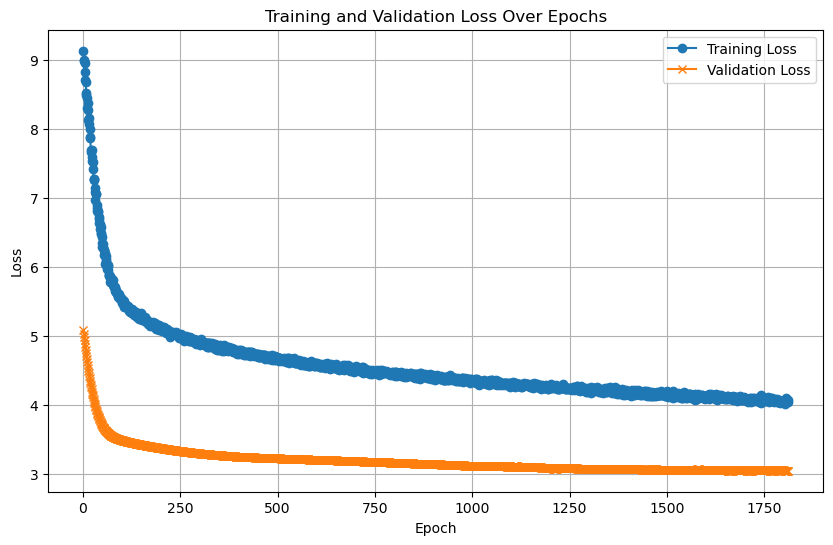

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/39], Loss: 5.0136
Test Batch [20/39], Loss: 4.7256
Test Batch [30/39], Loss: 4.8086

Test Loss: 4.8519


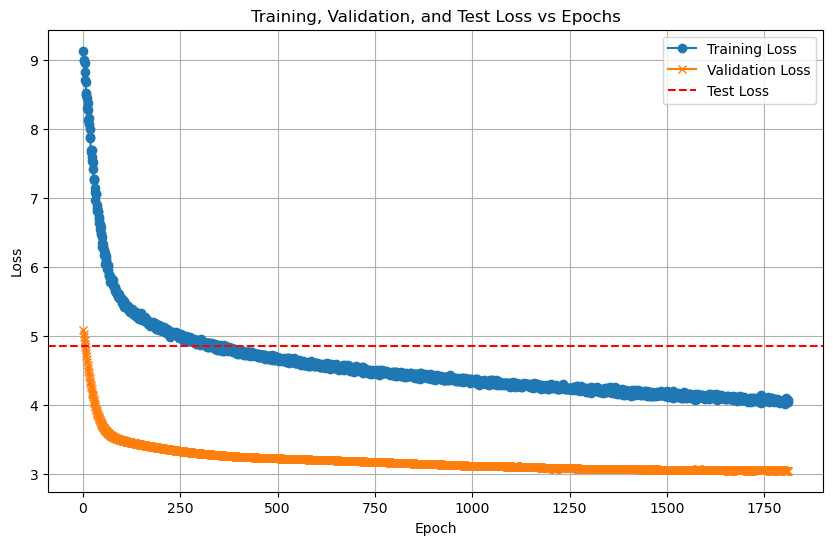

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/39 for test dataset.


  Processed batch 20/39 for test dataset.
  Processed batch 30/39 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (320, 128)
Train labels shape: (320,)
Val reps shape: (75, 128)
Val labels shape: (75,)
Test reps shape: (9854, 128)
Test labels shape: (9854,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 65.33%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       0.40      0.40      0.40         5
           2       0.00      0.00      0.00         5
           3       0.83      1.00      0.91         5
           4       1.00      0.20      0.33         5
           5       0.50      0.40      0.44         5
           6       0.83      1.00      0.91         5
           7       1.00      0.80      0.89         5
           8       0.00      0.00      0.00         0
           9       0.75      0.60      0.67         5
          10       0.50      0.80      0.62         5
          11       0.33      0.20      0.25         5
          12       0.71      1.00      0.83         5
          13       0.7

C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_clas

### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (320, 128)
Train labels shape: (320,)
Val reps shape: (75, 128)
Val labels shape: (75,)
Test reps shape: (9854, 128)
Test labels shape: (9854,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.7723  |  Val Loss: 2.7546
Validation loss improved from inf to 2.7546.


[Epoch 2/1000] Train Loss: 2.7497  |  Val Loss: 2.7313
Validation loss improved from 2.7546 to 2.7313.
[Epoch 3/1000] Train Loss: 2.7260  |  Val Loss: 2.7076
Validation loss improved from 2.7313 to 2.7076.
[Epoch 4/1000] Train Loss: 2.7025  |  Val Loss: 2.6849
Validation loss improved from 2.7076 to 2.6849.


[Epoch 5/1000] Train Loss: 2.6810  |  Val Loss: 2.6644
Validation loss improved from 2.6849 to 2.6644.
[Epoch 6/1000] Train Loss: 2.6619  |  Val Loss: 2.6453
Validation loss improved from 2.6644 to 2.6453.
[Epoch 7/1000] Train Loss: 2.6425  |  Val Loss: 2.6278
Validation loss improved from 2.6453 to 2.6278.
[Epoch 8/1000] Train Loss: 2.6251  |  Val Loss: 2.6115
Validation loss improved from 2.6278 to 2.6115.
[Epoch 9/1000] Train Loss: 2.6097  |  Val Loss: 2.5956
Validation loss improved from 2.6115 to 2.5956.
[Epoch 10/1000] Train Loss: 2.5945  |  Val Loss: 2.5800
Validation loss improved from 2.5956 to 2.5800.
[Epoch 11/1000] Train Loss: 2.5796  |  Val Loss: 2.5655
Validation loss improved from 2.5800 to 2.5655.
[Epoch 12/1000] Train Loss: 2.5654  |  Val Loss: 2.5512
Validation loss improved from 2.5655 to 2.5512.
[Epoch 13/1000] Train Loss: 2.5503  |  Val Loss: 2.5373
Validation loss improved from 2.5512 to 2.5373.
[Epoch 14/1000] Train Loss: 2.5363  |  Val Loss: 2.5226
Validation lo

[Epoch 17/1000] Train Loss: 2.4921  |  Val Loss: 2.4790
Validation loss improved from 2.4929 to 2.4790.
[Epoch 18/1000] Train Loss: 2.4777  |  Val Loss: 2.4656
Validation loss improved from 2.4790 to 2.4656.
[Epoch 19/1000] Train Loss: 2.4634  |  Val Loss: 2.4519
Validation loss improved from 2.4656 to 2.4519.
[Epoch 20/1000] Train Loss: 2.4494  |  Val Loss: 2.4383
Validation loss improved from 2.4519 to 2.4383.


[Epoch 21/1000] Train Loss: 2.4352  |  Val Loss: 2.4248
Validation loss improved from 2.4383 to 2.4248.
[Epoch 22/1000] Train Loss: 2.4215  |  Val Loss: 2.4110
Validation loss improved from 2.4248 to 2.4110.
[Epoch 23/1000] Train Loss: 2.4071  |  Val Loss: 2.3977
Validation loss improved from 2.4110 to 2.3977.


[Epoch 24/1000] Train Loss: 2.3931  |  Val Loss: 2.3843
Validation loss improved from 2.3977 to 2.3843.
[Epoch 25/1000] Train Loss: 2.3796  |  Val Loss: 2.3706
Validation loss improved from 2.3843 to 2.3706.
[Epoch 26/1000] Train Loss: 2.3654  |  Val Loss: 2.3571
Validation loss improved from 2.3706 to 2.3571.
[Epoch 27/1000] Train Loss: 2.3518  |  Val Loss: 2.3434
Validation loss improved from 2.3571 to 2.3434.
[Epoch 28/1000] Train Loss: 2.3375  |  Val Loss: 2.3297
Validation loss improved from 2.3434 to 2.3297.
[Epoch 29/1000] Train Loss: 2.3236  |  Val Loss: 2.3162
Validation loss improved from 2.3297 to 2.3162.
[Epoch 30/1000] Train Loss: 2.3101  |  Val Loss: 2.3026
Validation loss improved from 2.3162 to 2.3026.
[Epoch 31/1000] Train Loss: 2.2962  |  Val Loss: 2.2894
Validation loss improved from 2.3026 to 2.2894.
[Epoch 32/1000] Train Loss: 2.2825  |  Val Loss: 2.2757
Validation loss improved from 2.2894 to 2.2757.
[Epoch 33/1000] Train Loss: 2.2687  |  Val Loss: 2.2622
Validati

[Epoch 36/1000] Train Loss: 2.2277  |  Val Loss: 2.2229
Validation loss improved from 2.2362 to 2.2229.
[Epoch 37/1000] Train Loss: 2.2141  |  Val Loss: 2.2097
Validation loss improved from 2.2229 to 2.2097.
[Epoch 38/1000] Train Loss: 2.2009  |  Val Loss: 2.1965
Validation loss improved from 2.2097 to 2.1965.
[Epoch 39/1000] Train Loss: 2.1876  |  Val Loss: 2.1828
Validation loss improved from 2.1965 to 2.1828.
[Epoch 40/1000] Train Loss: 2.1742  |  Val Loss: 2.1692
Validation loss improved from 2.1828 to 2.1692.


[Epoch 41/1000] Train Loss: 2.1602  |  Val Loss: 2.1557
Validation loss improved from 2.1692 to 2.1557.
[Epoch 42/1000] Train Loss: 2.1461  |  Val Loss: 2.1419
Validation loss improved from 2.1557 to 2.1419.
[Epoch 43/1000] Train Loss: 2.1322  |  Val Loss: 2.1276
Validation loss improved from 2.1419 to 2.1276.
[Epoch 44/1000] Train Loss: 2.1178  |  Val Loss: 2.1128
Validation loss improved from 2.1276 to 2.1128.
[Epoch 45/1000] Train Loss: 2.1029  |  Val Loss: 2.0978
Validation loss improved from 2.1128 to 2.0978.
[Epoch 46/1000] Train Loss: 2.0879  |  Val Loss: 2.0824
Validation loss improved from 2.0978 to 2.0824.
[Epoch 47/1000] Train Loss: 2.0724  |  Val Loss: 2.0669
Validation loss improved from 2.0824 to 2.0669.
[Epoch 48/1000] Train Loss: 2.0573  |  Val Loss: 2.0512
Validation loss improved from 2.0669 to 2.0512.
[Epoch 49/1000] Train Loss: 2.0418  |  Val Loss: 2.0357
Validation loss improved from 2.0512 to 2.0357.
[Epoch 50/1000] Train Loss: 2.0264  |  Val Loss: 2.0199
Validati

[Epoch 54/1000] Train Loss: 1.9665  |  Val Loss: 1.9611
Validation loss improved from 1.9751 to 1.9611.
[Epoch 55/1000] Train Loss: 1.9521  |  Val Loss: 1.9470
Validation loss improved from 1.9611 to 1.9470.
[Epoch 56/1000] Train Loss: 1.9378  |  Val Loss: 1.9328
Validation loss improved from 1.9470 to 1.9328.
[Epoch 57/1000] Train Loss: 1.9232  |  Val Loss: 1.9188
Validation loss improved from 1.9328 to 1.9188.
[Epoch 58/1000] Train Loss: 1.9091  |  Val Loss: 1.9054
Validation loss improved from 1.9188 to 1.9054.
[Epoch 59/1000] Train Loss: 1.8952  |  Val Loss: 1.8915
Validation loss improved from 1.9054 to 1.8915.


[Epoch 60/1000] Train Loss: 1.8810  |  Val Loss: 1.8774
Validation loss improved from 1.8915 to 1.8774.
[Epoch 61/1000] Train Loss: 1.8671  |  Val Loss: 1.8638
Validation loss improved from 1.8774 to 1.8638.
[Epoch 62/1000] Train Loss: 1.8532  |  Val Loss: 1.8505
Validation loss improved from 1.8638 to 1.8505.
[Epoch 63/1000] Train Loss: 1.8395  |  Val Loss: 1.8374
Validation loss improved from 1.8505 to 1.8374.
[Epoch 64/1000] Train Loss: 1.8258  |  Val Loss: 1.8244
Validation loss improved from 1.8374 to 1.8244.
[Epoch 65/1000] Train Loss: 1.8123  |  Val Loss: 1.8114
Validation loss improved from 1.8244 to 1.8114.
[Epoch 66/1000] Train Loss: 1.7988  |  Val Loss: 1.7985
Validation loss improved from 1.8114 to 1.7985.
[Epoch 67/1000] Train Loss: 1.7853  |  Val Loss: 1.7858
Validation loss improved from 1.7985 to 1.7858.
[Epoch 68/1000] Train Loss: 1.7722  |  Val Loss: 1.7734
Validation loss improved from 1.7858 to 1.7734.
[Epoch 69/1000] Train Loss: 1.7590  |  Val Loss: 1.7610
Validati

[Epoch 72/1000] Train Loss: 1.7196  |  Val Loss: 1.7247
Validation loss improved from 1.7366 to 1.7247.
[Epoch 73/1000] Train Loss: 1.7065  |  Val Loss: 1.7130
Validation loss improved from 1.7247 to 1.7130.
[Epoch 74/1000] Train Loss: 1.6941  |  Val Loss: 1.7013
Validation loss improved from 1.7130 to 1.7013.
[Epoch 75/1000] Train Loss: 1.6813  |  Val Loss: 1.6897
Validation loss improved from 1.7013 to 1.6897.
[Epoch 76/1000] Train Loss: 1.6686  |  Val Loss: 1.6784
Validation loss improved from 1.6897 to 1.6784.
[Epoch 77/1000] Train Loss: 1.6557  |  Val Loss: 1.6671
Validation loss improved from 1.6784 to 1.6671.
[Epoch 78/1000] Train Loss: 1.6433  |  Val Loss: 1.6558
Validation loss improved from 1.6671 to 1.6558.


[Epoch 79/1000] Train Loss: 1.6310  |  Val Loss: 1.6450
Validation loss improved from 1.6558 to 1.6450.
[Epoch 80/1000] Train Loss: 1.6187  |  Val Loss: 1.6337
Validation loss improved from 1.6450 to 1.6337.
[Epoch 81/1000] Train Loss: 1.6060  |  Val Loss: 1.6232
Validation loss improved from 1.6337 to 1.6232.
[Epoch 82/1000] Train Loss: 1.5943  |  Val Loss: 1.6127
Validation loss improved from 1.6232 to 1.6127.
[Epoch 83/1000] Train Loss: 1.5821  |  Val Loss: 1.6024
Validation loss improved from 1.6127 to 1.6024.
[Epoch 84/1000] Train Loss: 1.5699  |  Val Loss: 1.5922
Validation loss improved from 1.6024 to 1.5922.
[Epoch 85/1000] Train Loss: 1.5577  |  Val Loss: 1.5821
Validation loss improved from 1.5922 to 1.5821.
[Epoch 86/1000] Train Loss: 1.5463  |  Val Loss: 1.5721
Validation loss improved from 1.5821 to 1.5721.
[Epoch 87/1000] Train Loss: 1.5347  |  Val Loss: 1.5619
Validation loss improved from 1.5721 to 1.5619.
[Epoch 88/1000] Train Loss: 1.5227  |  Val Loss: 1.5523
Validati

[Epoch 91/1000] Train Loss: 1.4881  |  Val Loss: 1.5236
Validation loss improved from 1.5330 to 1.5236.
[Epoch 92/1000] Train Loss: 1.4763  |  Val Loss: 1.5141
Validation loss improved from 1.5236 to 1.5141.
[Epoch 93/1000] Train Loss: 1.4651  |  Val Loss: 1.5052
Validation loss improved from 1.5141 to 1.5052.
[Epoch 94/1000] Train Loss: 1.4543  |  Val Loss: 1.4960
Validation loss improved from 1.5052 to 1.4960.
[Epoch 95/1000] Train Loss: 1.4430  |  Val Loss: 1.4867
Validation loss improved from 1.4960 to 1.4867.
[Epoch 96/1000] Train Loss: 1.4314  |  Val Loss: 1.4780
Validation loss improved from 1.4867 to 1.4780.


[Epoch 97/1000] Train Loss: 1.4207  |  Val Loss: 1.4694
Validation loss improved from 1.4780 to 1.4694.
[Epoch 98/1000] Train Loss: 1.4105  |  Val Loss: 1.4608
Validation loss improved from 1.4694 to 1.4608.
[Epoch 99/1000] Train Loss: 1.3990  |  Val Loss: 1.4521
Validation loss improved from 1.4608 to 1.4521.
[Epoch 100/1000] Train Loss: 1.3882  |  Val Loss: 1.4435
Validation loss improved from 1.4521 to 1.4435.
[Epoch 101/1000] Train Loss: 1.3775  |  Val Loss: 1.4350
Validation loss improved from 1.4435 to 1.4350.
[Epoch 102/1000] Train Loss: 1.3672  |  Val Loss: 1.4267
Validation loss improved from 1.4350 to 1.4267.
[Epoch 103/1000] Train Loss: 1.3567  |  Val Loss: 1.4188
Validation loss improved from 1.4267 to 1.4188.
[Epoch 104/1000] Train Loss: 1.3466  |  Val Loss: 1.4111
Validation loss improved from 1.4188 to 1.4111.
[Epoch 105/1000] Train Loss: 1.3361  |  Val Loss: 1.4034
Validation loss improved from 1.4111 to 1.4034.
[Epoch 106/1000] Train Loss: 1.3259  |  Val Loss: 1.3953
V

[Epoch 109/1000] Train Loss: 1.2962  |  Val Loss: 1.3726
Validation loss improved from 1.3799 to 1.3726.
[Epoch 110/1000] Train Loss: 1.2860  |  Val Loss: 1.3653
Validation loss improved from 1.3726 to 1.3653.
[Epoch 111/1000] Train Loss: 1.2768  |  Val Loss: 1.3581
Validation loss improved from 1.3653 to 1.3581.
[Epoch 112/1000] Train Loss: 1.2668  |  Val Loss: 1.3508
Validation loss improved from 1.3581 to 1.3508.
[Epoch 113/1000] Train Loss: 1.2569  |  Val Loss: 1.3438
Validation loss improved from 1.3508 to 1.3438.
[Epoch 114/1000] Train Loss: 1.2474  |  Val Loss: 1.3367
Validation loss improved from 1.3438 to 1.3367.


[Epoch 115/1000] Train Loss: 1.2382  |  Val Loss: 1.3295
Validation loss improved from 1.3367 to 1.3295.
[Epoch 116/1000] Train Loss: 1.2289  |  Val Loss: 1.3229
Validation loss improved from 1.3295 to 1.3229.
[Epoch 117/1000] Train Loss: 1.2191  |  Val Loss: 1.3163
Validation loss improved from 1.3229 to 1.3163.
[Epoch 118/1000] Train Loss: 1.2101  |  Val Loss: 1.3099
Validation loss improved from 1.3163 to 1.3099.
[Epoch 119/1000] Train Loss: 1.2012  |  Val Loss: 1.3035
Validation loss improved from 1.3099 to 1.3035.
[Epoch 120/1000] Train Loss: 1.1920  |  Val Loss: 1.2970
Validation loss improved from 1.3035 to 1.2970.
[Epoch 121/1000] Train Loss: 1.1832  |  Val Loss: 1.2907
Validation loss improved from 1.2970 to 1.2907.
[Epoch 122/1000] Train Loss: 1.1744  |  Val Loss: 1.2844
Validation loss improved from 1.2907 to 1.2844.
[Epoch 123/1000] Train Loss: 1.1653  |  Val Loss: 1.2785
Validation loss improved from 1.2844 to 1.2785.
[Epoch 124/1000] Train Loss: 1.1567  |  Val Loss: 1.272

[Epoch 129/1000] Train Loss: 1.1142  |  Val Loss: 1.2450
Validation loss improved from 1.2502 to 1.2450.
[Epoch 130/1000] Train Loss: 1.1061  |  Val Loss: 1.2400
Validation loss improved from 1.2450 to 1.2400.
[Epoch 131/1000] Train Loss: 1.0974  |  Val Loss: 1.2349
Validation loss improved from 1.2400 to 1.2349.
[Epoch 132/1000] Train Loss: 1.0902  |  Val Loss: 1.2294
Validation loss improved from 1.2349 to 1.2294.
[Epoch 133/1000] Train Loss: 1.0817  |  Val Loss: 1.2246
Validation loss improved from 1.2294 to 1.2246.


[Epoch 134/1000] Train Loss: 1.0740  |  Val Loss: 1.2195
Validation loss improved from 1.2246 to 1.2195.
[Epoch 135/1000] Train Loss: 1.0661  |  Val Loss: 1.2149
Validation loss improved from 1.2195 to 1.2149.
[Epoch 136/1000] Train Loss: 1.0579  |  Val Loss: 1.2104
Validation loss improved from 1.2149 to 1.2104.
[Epoch 137/1000] Train Loss: 1.0506  |  Val Loss: 1.2062
Validation loss improved from 1.2104 to 1.2062.
[Epoch 138/1000] Train Loss: 1.0434  |  Val Loss: 1.2014
Validation loss improved from 1.2062 to 1.2014.
[Epoch 139/1000] Train Loss: 1.0359  |  Val Loss: 1.1971
Validation loss improved from 1.2014 to 1.1971.
[Epoch 140/1000] Train Loss: 1.0283  |  Val Loss: 1.1930
Validation loss improved from 1.1971 to 1.1930.
[Epoch 141/1000] Train Loss: 1.0208  |  Val Loss: 1.1888
Validation loss improved from 1.1930 to 1.1888.
[Epoch 142/1000] Train Loss: 1.0137  |  Val Loss: 1.1847
Validation loss improved from 1.1888 to 1.1847.
[Epoch 143/1000] Train Loss: 1.0072  |  Val Loss: 1.180

[Epoch 146/1000] Train Loss: 0.9857  |  Val Loss: 1.1692
Validation loss improved from 1.1732 to 1.1692.
[Epoch 147/1000] Train Loss: 0.9789  |  Val Loss: 1.1653
Validation loss improved from 1.1692 to 1.1653.
[Epoch 148/1000] Train Loss: 0.9722  |  Val Loss: 1.1618
Validation loss improved from 1.1653 to 1.1618.
[Epoch 149/1000] Train Loss: 0.9653  |  Val Loss: 1.1582
Validation loss improved from 1.1618 to 1.1582.
[Epoch 150/1000] Train Loss: 0.9589  |  Val Loss: 1.1547
Validation loss improved from 1.1582 to 1.1547.


[Epoch 151/1000] Train Loss: 0.9527  |  Val Loss: 1.1514
Validation loss improved from 1.1547 to 1.1514.
[Epoch 152/1000] Train Loss: 0.9470  |  Val Loss: 1.1478
Validation loss improved from 1.1514 to 1.1478.
[Epoch 153/1000] Train Loss: 0.9403  |  Val Loss: 1.1444
Validation loss improved from 1.1478 to 1.1444.
[Epoch 154/1000] Train Loss: 0.9342  |  Val Loss: 1.1406
Validation loss improved from 1.1444 to 1.1406.
[Epoch 155/1000] Train Loss: 0.9276  |  Val Loss: 1.1376
Validation loss improved from 1.1406 to 1.1376.
[Epoch 156/1000] Train Loss: 0.9217  |  Val Loss: 1.1350
Validation loss improved from 1.1376 to 1.1350.
[Epoch 157/1000] Train Loss: 0.9157  |  Val Loss: 1.1326
Validation loss improved from 1.1350 to 1.1326.
[Epoch 158/1000] Train Loss: 0.9099  |  Val Loss: 1.1290
Validation loss improved from 1.1326 to 1.1290.
[Epoch 159/1000] Train Loss: 0.9041  |  Val Loss: 1.1264
Validation loss improved from 1.1290 to 1.1264.
[Epoch 160/1000] Train Loss: 0.8985  |  Val Loss: 1.123

[Epoch 165/1000] Train Loss: 0.8706  |  Val Loss: 1.1102
Validation loss improved from 1.1129 to 1.1102.
[Epoch 166/1000] Train Loss: 0.8657  |  Val Loss: 1.1081
Validation loss improved from 1.1102 to 1.1081.
[Epoch 167/1000] Train Loss: 0.8608  |  Val Loss: 1.1048
Validation loss improved from 1.1081 to 1.1048.
[Epoch 168/1000] Train Loss: 0.8555  |  Val Loss: 1.1025
Validation loss improved from 1.1048 to 1.1025.
[Epoch 169/1000] Train Loss: 0.8505  |  Val Loss: 1.1009
Validation loss improved from 1.1025 to 1.1009.
[Epoch 170/1000] Train Loss: 0.8453  |  Val Loss: 1.0979
Validation loss improved from 1.1009 to 1.0979.


[Epoch 171/1000] Train Loss: 0.8408  |  Val Loss: 1.0961
Validation loss improved from 1.0979 to 1.0961.
[Epoch 172/1000] Train Loss: 0.8370  |  Val Loss: 1.0930
Validation loss improved from 1.0961 to 1.0930.
[Epoch 173/1000] Train Loss: 0.8314  |  Val Loss: 1.0915
Validation loss improved from 1.0930 to 1.0915.
[Epoch 174/1000] Train Loss: 0.8265  |  Val Loss: 1.0898
Validation loss improved from 1.0915 to 1.0898.
[Epoch 175/1000] Train Loss: 0.8220  |  Val Loss: 1.0884
Validation loss improved from 1.0898 to 1.0884.
[Epoch 176/1000] Train Loss: 0.8179  |  Val Loss: 1.0851
Validation loss improved from 1.0884 to 1.0851.
[Epoch 177/1000] Train Loss: 0.8129  |  Val Loss: 1.0830
Validation loss improved from 1.0851 to 1.0830.
[Epoch 178/1000] Train Loss: 0.8089  |  Val Loss: 1.0811
Validation loss improved from 1.0830 to 1.0811.
[Epoch 179/1000] Train Loss: 0.8047  |  Val Loss: 1.0800
Validation loss improved from 1.0811 to 1.0800.
[Epoch 180/1000] Train Loss: 0.8002  |  Val Loss: 1.077

[Epoch 186/1000] Train Loss: 0.7763  |  Val Loss: 1.0667
Validation loss improved from 1.0686 to 1.0667.
[Epoch 187/1000] Train Loss: 0.7721  |  Val Loss: 1.0650
Validation loss improved from 1.0667 to 1.0650.
[Epoch 188/1000] Train Loss: 0.7687  |  Val Loss: 1.0634
Validation loss improved from 1.0650 to 1.0634.
[Epoch 189/1000] Train Loss: 0.7656  |  Val Loss: 1.0629
Validation loss improved from 1.0634 to 1.0629.


[Epoch 190/1000] Train Loss: 0.7617  |  Val Loss: 1.0610
Validation loss improved from 1.0629 to 1.0610.
[Epoch 191/1000] Train Loss: 0.7587  |  Val Loss: 1.0586
Validation loss improved from 1.0610 to 1.0586.
[Epoch 192/1000] Train Loss: 0.7544  |  Val Loss: 1.0570
Validation loss improved from 1.0586 to 1.0570.
[Epoch 193/1000] Train Loss: 0.7509  |  Val Loss: 1.0559
Validation loss improved from 1.0570 to 1.0559.
[Epoch 194/1000] Train Loss: 0.7474  |  Val Loss: 1.0547
Validation loss improved from 1.0559 to 1.0547.
[Epoch 195/1000] Train Loss: 0.7437  |  Val Loss: 1.0525
Validation loss improved from 1.0547 to 1.0525.
[Epoch 196/1000] Train Loss: 0.7409  |  Val Loss: 1.0510
Validation loss improved from 1.0525 to 1.0510.
[Epoch 197/1000] Train Loss: 0.7375  |  Val Loss: 1.0500
Validation loss improved from 1.0510 to 1.0500.
[Epoch 198/1000] Train Loss: 0.7342  |  Val Loss: 1.0487
Validation loss improved from 1.0500 to 1.0487.
[Epoch 199/1000] Train Loss: 0.7312  |  Val Loss: 1.047

[Epoch 204/1000] Train Loss: 0.7163  |  Val Loss: 1.0420
Validation loss improved from 1.0426 to 1.0420.
[Epoch 205/1000] Train Loss: 0.7137  |  Val Loss: 1.0413
Validation loss improved from 1.0420 to 1.0413.
[Epoch 206/1000] Train Loss: 0.7116  |  Val Loss: 1.0402
Validation loss improved from 1.0413 to 1.0402.
[Epoch 207/1000] Train Loss: 0.7082  |  Val Loss: 1.0384
Validation loss improved from 1.0402 to 1.0384.
[Epoch 208/1000] Train Loss: 0.7055  |  Val Loss: 1.0381
Validation loss improved from 1.0384 to 1.0381.
[Epoch 209/1000] Train Loss: 0.7038  |  Val Loss: 1.0357
Validation loss improved from 1.0381 to 1.0357.


[Epoch 210/1000] Train Loss: 0.7006  |  Val Loss: 1.0353
Validation loss improved from 1.0357 to 1.0353.
[Epoch 211/1000] Train Loss: 0.6971  |  Val Loss: 1.0334
Validation loss improved from 1.0353 to 1.0334.
[Epoch 212/1000] Train Loss: 0.6948  |  Val Loss: 1.0323
Validation loss improved from 1.0334 to 1.0323.
[Epoch 213/1000] Train Loss: 0.6924  |  Val Loss: 1.0313
Validation loss improved from 1.0323 to 1.0313.
[Epoch 214/1000] Train Loss: 0.6897  |  Val Loss: 1.0315
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 215/1000] Train Loss: 0.6876  |  Val Loss: 1.0305
Validation loss improved from 1.0313 to 1.0305.
[Epoch 216/1000] Train Loss: 0.6857  |  Val Loss: 1.0295
Validation loss improved from 1.0305 to 1.0295.
[Epoch 217/1000] Train Loss: 0.6838  |  Val Loss: 1.0294
Validation loss improved from 1.0295 to 1.0294.
[Epoch 218/1000] Train Loss: 0.6802  |  Val Loss: 1.0277
Validation loss improved from 1.0294 to 1.0277.
[Epoch 219/1000] Train Loss: 0.6783  |  Val Loss:

[Epoch 224/1000] Train Loss: 0.6671  |  Val Loss: 1.0231
Validation loss improved from 1.0249 to 1.0231.
[Epoch 225/1000] Train Loss: 0.6642  |  Val Loss: 1.0222
Validation loss improved from 1.0231 to 1.0222.
[Epoch 226/1000] Train Loss: 0.6628  |  Val Loss: 1.0215
Validation loss improved from 1.0222 to 1.0215.
[Epoch 227/1000] Train Loss: 0.6605  |  Val Loss: 1.0219
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 228/1000] Train Loss: 0.6583  |  Val Loss: 1.0196
Validation loss improved from 1.0215 to 1.0196.
[Epoch 229/1000] Train Loss: 0.6557  |  Val Loss: 1.0190
Validation loss improved from 1.0196 to 1.0190.
[Epoch 230/1000] Train Loss: 0.6538  |  Val Loss: 1.0183
Validation loss improved from 1.0190 to 1.0183.


[Epoch 231/1000] Train Loss: 0.6522  |  Val Loss: 1.0188
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 232/1000] Train Loss: 0.6495  |  Val Loss: 1.0175
Validation loss improved from 1.0183 to 1.0175.
[Epoch 233/1000] Train Loss: 0.6483  |  Val Loss: 1.0166
Validation loss improved from 1.0175 to 1.0166.
[Epoch 234/1000] Train Loss: 0.6463  |  Val Loss: 1.0154
Validation loss improved from 1.0166 to 1.0154.
[Epoch 235/1000] Train Loss: 0.6440  |  Val Loss: 1.0155
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 236/1000] Train Loss: 0.6424  |  Val Loss: 1.0147
Validation loss improved from 1.0154 to 1.0147.
[Epoch 237/1000] Train Loss: 0.6408  |  Val Loss: 1.0154
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 238/1000] Train Loss: 0.6390  |  Val Loss: 1.0144
Validation loss improved from 1.0147 to 1.0144.
[Epoch 239/1000] Train Loss: 0.6366  |  Val Loss: 1.0131
Validation loss improved from 1.0144 to 1.0131.
[Epoch 240/1000] Train Loss: 0.6360  

[Epoch 244/1000] Train Loss: 0.6280  |  Val Loss: 1.0114
Validation loss improved from 1.0117 to 1.0114.
[Epoch 245/1000] Train Loss: 0.6266  |  Val Loss: 1.0111
Validation loss improved from 1.0114 to 1.0111.
[Epoch 246/1000] Train Loss: 0.6249  |  Val Loss: 1.0110
Validation loss improved from 1.0111 to 1.0110.
[Epoch 247/1000] Train Loss: 0.6228  |  Val Loss: 1.0099
Validation loss improved from 1.0110 to 1.0099.
[Epoch 248/1000] Train Loss: 0.6212  |  Val Loss: 1.0098
Validation loss improved from 1.0099 to 1.0098.
[Epoch 249/1000] Train Loss: 0.6204  |  Val Loss: 1.0097
Validation loss improved from 1.0098 to 1.0097.
[Epoch 250/1000] Train Loss: 0.6183  |  Val Loss: 1.0087
Validation loss improved from 1.0097 to 1.0087.


[Epoch 251/1000] Train Loss: 0.6161  |  Val Loss: 1.0089
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 252/1000] Train Loss: 0.6146  |  Val Loss: 1.0094
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 253/1000] Train Loss: 0.6134  |  Val Loss: 1.0098
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 254/1000] Train Loss: 0.6118  |  Val Loss: 1.0090
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 255/1000] Train Loss: 0.6101  |  Val Loss: 1.0076
Validation loss improved from 1.0087 to 1.0076.
[Epoch 256/1000] Train Loss: 0.6084  |  Val Loss: 1.0076
Validation loss improved from 1.0076 to 1.0076.
[Epoch 257/1000] Train Loss: 0.6072  |  Val Loss: 1.0066
Validation loss improved from 1.0076 to 1.0066.
[Epoch 258/1000] Train Loss: 0.6055  |  Val Loss: 1.0073
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 259/1000] Train Loss: 0.6042  |  Val Loss: 1.0078
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 260/1000] Tr

[Epoch 263/1000] Train Loss: 0.5983  |  Val Loss: 1.0058
Validation loss improved from 1.0058 to 1.0058.
[Epoch 264/1000] Train Loss: 0.5972  |  Val Loss: 1.0048
Validation loss improved from 1.0058 to 1.0048.
[Epoch 265/1000] Train Loss: 0.5953  |  Val Loss: 1.0048
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 266/1000] Train Loss: 0.5942  |  Val Loss: 1.0050
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 267/1000] Train Loss: 0.5931  |  Val Loss: 1.0050
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 268/1000] Train Loss: 0.5916  |  Val Loss: 1.0027
Validation loss improved from 1.0048 to 1.0027.
[Epoch 269/1000] Train Loss: 0.5895  |  Val Loss: 1.0026
Validation loss improved from 1.0027 to 1.0026.


[Epoch 270/1000] Train Loss: 0.5886  |  Val Loss: 1.0033
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 271/1000] Train Loss: 0.5869  |  Val Loss: 1.0026
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 272/1000] Train Loss: 0.5862  |  Val Loss: 1.0004
Validation loss improved from 1.0026 to 1.0004.
[Epoch 273/1000] Train Loss: 0.5846  |  Val Loss: 1.0006
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 274/1000] Train Loss: 0.5830  |  Val Loss: 1.0008
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 275/1000] Train Loss: 0.5819  |  Val Loss: 1.0003
Validation loss improved from 1.0004 to 1.0003.
[Epoch 276/1000] Train Loss: 0.5809  |  Val Loss: 1.0007
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 277/1000] Train Loss: 0.5787  |  Val Loss: 0.9995
Validation loss improved from 1.0003 to 0.9995.
[Epoch 278/1000] Train Loss: 0.5788  |  Val Loss: 0.9978
Validation loss improved from 0.9995 to 0.9978.
[Epoch 279/1000] Train Lo

[Epoch 281/1000] Train Loss: 0.5757  |  Val Loss: 0.9961
Validation loss improved from 0.9976 to 0.9961.
[Epoch 282/1000] Train Loss: 0.5728  |  Val Loss: 0.9966
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 283/1000] Train Loss: 0.5731  |  Val Loss: 0.9987
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 284/1000] Train Loss: 0.5717  |  Val Loss: 0.9980
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 285/1000] Train Loss: 0.5693  |  Val Loss: 0.9958
Validation loss improved from 0.9961 to 0.9958.
[Epoch 286/1000] Train Loss: 0.5689  |  Val Loss: 0.9947
Validation loss improved from 0.9958 to 0.9947.
[Epoch 287/1000] Train Loss: 0.5676  |  Val Loss: 0.9956
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 288/1000] Train Loss: 0.5663  |  Val Loss: 0.9952
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 289/1000] Train Loss: 0.5654  |  Val Loss: 0.9955
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 290/1000] Train Loss: 0.5636  |  Val Loss: 0.9946
Validation loss improved from 0.9947 to 0.9946.
[Epoch 291/1000] Train Loss: 0.5625  |  Val Loss: 0.9938
Validation loss improved from 0.9946 to 0.9938.
[Epoch 292/1000] Train Loss: 0.5616  |  Val Loss: 0.9933
Validation loss improved from 0.9938 to 0.9933.
[Epoch 293/1000] Train Loss: 0.5607  |  Val Loss: 0.9937
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 294/1000] Train Loss: 0.5591  |  Val Loss: 0.9936
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 295/1000] Train Loss: 0.5582  |  Val Loss: 0.9929
Validation loss improved from 0.9933 to 0.9929.
[Epoch 296/1000] Train Loss: 0.5573  |  Val Loss: 0.9923
Validation loss improved from 0.9929 to 0.9923.
[Epoch 297/1000] Train Loss: 0.

[Epoch 301/1000] Train Loss: 0.5519  |  Val Loss: 0.9919
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 302/1000] Train Loss: 0.5513  |  Val Loss: 0.9917
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 303/1000] Train Loss: 0.5501  |  Val Loss: 0.9908
Validation loss improved from 0.9910 to 0.9908.
[Epoch 304/1000] Train Loss: 0.5494  |  Val Loss: 0.9898
Validation loss improved from 0.9908 to 0.9898.
[Epoch 305/1000] Train Loss: 0.5483  |  Val Loss: 0.9913
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 306/1000] Train Loss: 0.5477  |  Val Loss: 0.9910
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 307/1000] Train Loss: 0.5468  |  Val Loss: 0.9915
!! Validation loss did NOT improve !! Patience: 3/100


[Epoch 308/1000] Train Loss: 0.5456  |  Val Loss: 0.9899
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 309/1000] Train Loss: 0.5446  |  Val Loss: 0.9880
Validation loss improved from 0.9898 to 0.9880.
[Epoch 310/1000] Train Loss: 0.5434  |  Val Loss: 0.9874
Validation loss improved from 0.9880 to 0.9874.
[Epoch 311/1000] Train Loss: 0.5422  |  Val Loss: 0.9875
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 312/1000] Train Loss: 0.5416  |  Val Loss: 0.9881
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 313/1000] Train Loss: 0.5407  |  Val Loss: 0.9892
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 314/1000] Train Loss: 0.5396  |  Val Loss: 0.9897
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 315/1000] Train Loss: 0.5395  |  Val Loss: 0.9881
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 316/1000] Train Loss: 0.5379  |  Val Loss: 0.9880
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 317/10

[Epoch 323/1000] Train Loss: 0.5325  |  Val Loss: 0.9869
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 324/1000] Train Loss: 0.5310  |  Val Loss: 0.9868
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 325/1000] Train Loss: 0.5300  |  Val Loss: 0.9875
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 326/1000] Train Loss: 0.5290  |  Val Loss: 0.9876
!! Validation loss did NOT improve !! Patience: 8/100


[Epoch 327/1000] Train Loss: 0.5283  |  Val Loss: 0.9864
Validation loss improved from 0.9867 to 0.9864.
[Epoch 328/1000] Train Loss: 0.5276  |  Val Loss: 0.9865
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 329/1000] Train Loss: 0.5273  |  Val Loss: 0.9875
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 330/1000] Train Loss: 0.5259  |  Val Loss: 0.9865
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 331/1000] Train Loss: 0.5245  |  Val Loss: 0.9867
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 332/1000] Train Loss: 0.5254  |  Val Loss: 0.9856
Validation loss improved from 0.9864 to 0.9856.
[Epoch 333/1000] Train Loss: 0.5232  |  Val Loss: 0.9862
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 334/1000] Train Loss: 0.5227  |  Val Loss: 0.9870
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 335/1000] Train Loss: 0.5218  |  Val Loss: 0.9866
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 336/10

[Epoch 340/1000] Train Loss: 0.5180  |  Val Loss: 0.9861
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 341/1000] Train Loss: 0.5169  |  Val Loss: 0.9864
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 342/1000] Train Loss: 0.5166  |  Val Loss: 0.9874
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 343/1000] Train Loss: 0.5157  |  Val Loss: 0.9877
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 344/1000] Train Loss: 0.5147  |  Val Loss: 0.9870
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 345/1000] Train Loss: 0.5144  |  Val Loss: 0.9863
!! Validation loss did NOT improve !! Patience: 13/100


[Epoch 346/1000] Train Loss: 0.5138  |  Val Loss: 0.9869
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 347/1000] Train Loss: 0.5123  |  Val Loss: 0.9876
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 348/1000] Train Loss: 0.5129  |  Val Loss: 0.9854
Validation loss improved from 0.9856 to 0.9854.
[Epoch 349/1000] Train Loss: 0.5125  |  Val Loss: 0.9871
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 350/1000] Train Loss: 0.5104  |  Val Loss: 0.9878
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 351/1000] Train Loss: 0.5096  |  Val Loss: 0.9870
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 352/1000] Train Loss: 0.5088  |  Val Loss: 0.9861
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 353/1000] Train Loss: 0.5083  |  Val Loss: 0.9848
Validation loss improved from 0.9854 to 0.9848.
[Epoch 354/1000] Train Loss: 0.5086  |  Val Loss: 0.9869
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 355/

[Epoch 360/1000] Train Loss: 0.5038  |  Val Loss: 0.9869
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 361/1000] Train Loss: 0.5023  |  Val Loss: 0.9865
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 362/1000] Train Loss: 0.5019  |  Val Loss: 0.9881
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 363/1000] Train Loss: 0.5014  |  Val Loss: 0.9875
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 364/1000] Train Loss: 0.5012  |  Val Loss: 0.9863
!! Validation loss did NOT improve !! Patience: 11/100


[Epoch 365/1000] Train Loss: 0.4994  |  Val Loss: 0.9858
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 366/1000] Train Loss: 0.4990  |  Val Loss: 0.9864
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 367/1000] Train Loss: 0.4982  |  Val Loss: 0.9872
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 368/1000] Train Loss: 0.4976  |  Val Loss: 0.9882
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 369/1000] Train Loss: 0.4966  |  Val Loss: 0.9886
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 370/1000] Train Loss: 0.4978  |  Val Loss: 0.9911
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 371/1000] Train Loss: 0.4957  |  Val Loss: 0.9892
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 372/1000] Train Loss: 0.4944  |  Val Loss: 0.9872
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 373/1000] Train Loss: 0.4947  |  Val Loss: 0.9869
!! Validation loss did NOT improve !! Patience:

[Epoch 379/1000] Train Loss: 0.4907  |  Val Loss: 0.9885
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 380/1000] Train Loss: 0.4898  |  Val Loss: 0.9888
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 381/1000] Train Loss: 0.4894  |  Val Loss: 0.9884
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 382/1000] Train Loss: 0.4891  |  Val Loss: 0.9895
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 383/1000] Train Loss: 0.4882  |  Val Loss: 0.9891
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 384/1000] Train Loss: 0.4874  |  Val Loss: 0.9877
!! Validation loss did NOT improve !! Patience: 31/100


[Epoch 385/1000] Train Loss: 0.4876  |  Val Loss: 0.9886
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 386/1000] Train Loss: 0.4862  |  Val Loss: 0.9892
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 387/1000] Train Loss: 0.4866  |  Val Loss: 0.9884
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 388/1000] Train Loss: 0.4856  |  Val Loss: 0.9909
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 389/1000] Train Loss: 0.4844  |  Val Loss: 0.9912
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 390/1000] Train Loss: 0.4840  |  Val Loss: 0.9883
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 391/1000] Train Loss: 0.4828  |  Val Loss: 0.9886
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 392/1000] Train Loss: 0.4831  |  Val Loss: 0.9896
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 393/1000] Train Loss: 0.4832  |  Val Loss: 0.9914
!! Validation loss did NOT improve !! Patience:

[Epoch 399/1000] Train Loss: 0.4790  |  Val Loss: 0.9885
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 400/1000] Train Loss: 0.4782  |  Val Loss: 0.9904
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 401/1000] Train Loss: 0.4771  |  Val Loss: 0.9915
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 402/1000] Train Loss: 0.4770  |  Val Loss: 0.9918
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 403/1000] Train Loss: 0.4766  |  Val Loss: 0.9916
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 404/1000] Train Loss: 0.4756  |  Val Loss: 0.9909
!! Validation loss did NOT improve !! Patience: 51/100


[Epoch 405/1000] Train Loss: 0.4748  |  Val Loss: 0.9901
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 406/1000] Train Loss: 0.4747  |  Val Loss: 0.9913
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 407/1000] Train Loss: 0.4739  |  Val Loss: 0.9901
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 408/1000] Train Loss: 0.4745  |  Val Loss: 0.9907
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 409/1000] Train Loss: 0.4726  |  Val Loss: 0.9894
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 410/1000] Train Loss: 0.4727  |  Val Loss: 0.9892
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 411/1000] Train Loss: 0.4717  |  Val Loss: 0.9898
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 412/1000] Train Loss: 0.4709  |  Val Loss: 0.9913
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 413/1000] Train Loss: 0.4708  |  Val Loss: 0.9907
!! Validation loss did NOT improve !! Patience:

[Epoch 420/1000] Train Loss: 0.4673  |  Val Loss: 0.9909
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 421/1000] Train Loss: 0.4674  |  Val Loss: 0.9913
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 422/1000] Train Loss: 0.4661  |  Val Loss: 0.9922
!! Validation loss did NOT improve !! Patience: 69/100


[Epoch 423/1000] Train Loss: 0.4651  |  Val Loss: 0.9927
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 424/1000] Train Loss: 0.4648  |  Val Loss: 0.9927
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 425/1000] Train Loss: 0.4644  |  Val Loss: 0.9918
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 426/1000] Train Loss: 0.4633  |  Val Loss: 0.9926
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 427/1000] Train Loss: 0.4634  |  Val Loss: 0.9937
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 428/1000] Train Loss: 0.4623  |  Val Loss: 0.9926
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 429/1000] Train Loss: 0.4622  |  Val Loss: 0.9918
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 430/1000] Train Loss: 0.4622  |  Val Loss: 0.9920
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 431/1000] Train Loss: 0.4616  |  Val Loss: 0.9920
!! Validation loss did NOT improve !! Patience:

[Epoch 439/1000] Train Loss: 0.4570  |  Val Loss: 0.9941
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 440/1000] Train Loss: 0.4565  |  Val Loss: 0.9934
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 441/1000] Train Loss: 0.4563  |  Val Loss: 0.9931
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 442/1000] Train Loss: 0.4557  |  Val Loss: 0.9932
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 443/1000] Train Loss: 0.4558  |  Val Loss: 0.9953
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 444/1000] Train Loss: 0.4546  |  Val Loss: 0.9953
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 445/1000] Train Loss: 0.4547  |  Val Loss: 0.9937
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 446/1000] Train Loss: 0.4538  |  Val Loss: 0.9945
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 447/1000] Train Loss: 0.4538  |  Val Loss: 0.9963
!! Validation loss did NOT improve !! Patience:

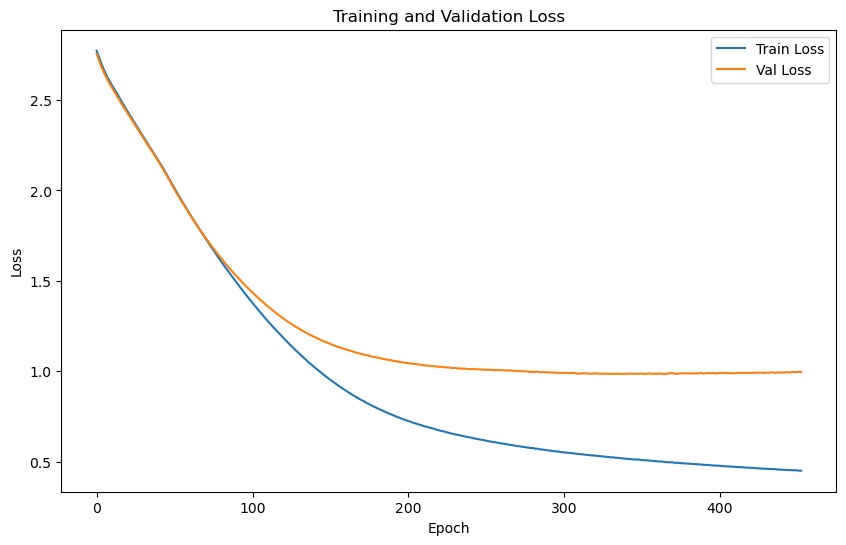

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 1.7346 | Test Accuracy: 55.03%


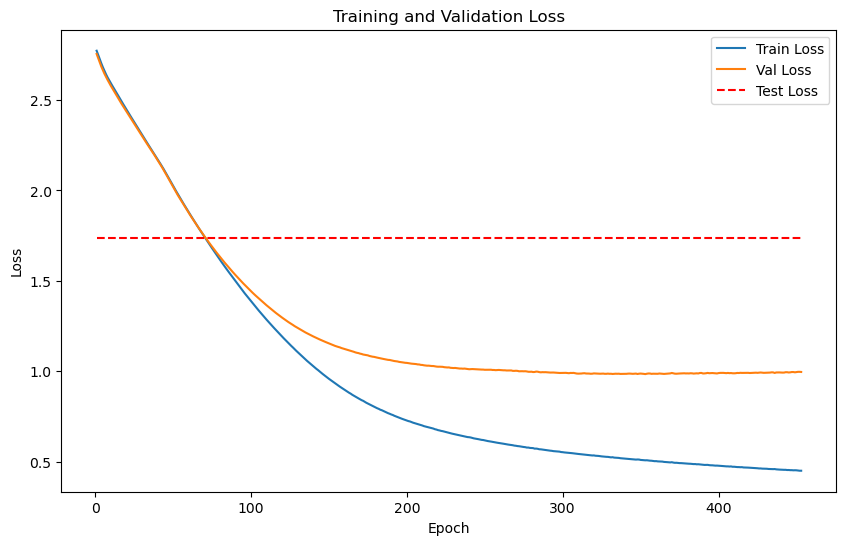

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 320 samples with 64 features each
LOG: Labels shape: (320,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 75 samples with 64 features each
LOG: Labels shape: (75,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 9854 samples with 64 features each
LOG: Labels shape: (9854,)


Train embeddings shape: (320, 64), 
Train labels shape: (320,)


Val embeddings shape: (75, 64), 
Val labels shape: (75,)


Test embeddings shape: (9854, 64), 
Test labels shape: (9854,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20, 13: 20, 14: 20, 15: 20}
Training batch size: 320


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 0.4984
LOG: Epoch [1/2000] - Validation
    Batch [1/2], Val Loss: 0.5271
    Batch [2/2], Val Loss: 0.2953
Epoch [1/2000], Avg Train Loss: 0.4984, Avg Val Loss: 0.4112

Validation loss improved from inf to 0.4112. Saving model...
LOG: Epoch [2/2000] - Training


    Batch [1/1], Train Loss: 0.4987
LOG: Epoch [2/2000] - Validation
    Batch [1/2], Val Loss: 0.5264
    Batch [2/2], Val Loss: 0.2975
Epoch [2/2000], Avg Train Loss: 0.4987, Avg Val Loss: 0.4120

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [3/2000] - Training


    Batch [1/1], Train Loss: 0.4990
LOG: Epoch [3/2000] - Validation
    Batch [1/2], Val Loss: 0.5259
    Batch [2/2], Val Loss: 0.2995
Epoch [3/2000], Avg Train Loss: 0.4990, Avg Val Loss: 0.4127

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [4/2000] - Training


    Batch [1/1], Train Loss: 0.4986
LOG: Epoch [4/2000] - Validation
    Batch [1/2], Val Loss: 0.5252
    Batch [2/2], Val Loss: 0.3010
Epoch [4/2000], Avg Train Loss: 0.4986, Avg Val Loss: 0.4131

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [5/2000] - Training


    Batch [1/1], Train Loss: 0.4965
LOG: Epoch [5/2000] - Validation
    Batch [1/2], Val Loss: 0.5244
    Batch [2/2], Val Loss: 0.3024
Epoch [5/2000], Avg Train Loss: 0.4965, Avg Val Loss: 0.4134

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [6/2000] - Training


    Batch [1/1], Train Loss: 0.4963
LOG: Epoch [6/2000] - Validation
    Batch [1/2], Val Loss: 0.5239
    Batch [2/2], Val Loss: 0.3033
Epoch [6/2000], Avg Train Loss: 0.4963, Avg Val Loss: 0.4136

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [7/2000] - Training


    Batch [1/1], Train Loss: 0.4970
LOG: Epoch [7/2000] - Validation
    Batch [1/2], Val Loss: 0.5235
    Batch [2/2], Val Loss: 0.3048
Epoch [7/2000], Avg Train Loss: 0.4970, Avg Val Loss: 0.4142

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [8/2000] - Training


    Batch [1/1], Train Loss: 0.4962
LOG: Epoch [8/2000] - Validation
    Batch [1/2], Val Loss: 0.5230
    Batch [2/2], Val Loss: 0.3063
Epoch [8/2000], Avg Train Loss: 0.4962, Avg Val Loss: 0.4146

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [9/2000] - Training


    Batch [1/1], Train Loss: 0.4940
LOG: Epoch [9/2000] - Validation
    Batch [1/2], Val Loss: 0.5220
    Batch [2/2], Val Loss: 0.3082
Epoch [9/2000], Avg Train Loss: 0.4940, Avg Val Loss: 0.4151

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [10/2000] - Training


    Batch [1/1], Train Loss: 0.4944
LOG: Epoch [10/2000] - Validation
    Batch [1/2], Val Loss: 0.5208
    Batch [2/2], Val Loss: 0.3100
Epoch [10/2000], Avg Train Loss: 0.4944, Avg Val Loss: 0.4154

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [11/2000] - Training


    Batch [1/1], Train Loss: 0.4924
LOG: Epoch [11/2000] - Validation
    Batch [1/2], Val Loss: 0.5193
    Batch [2/2], Val Loss: 0.3116
Epoch [11/2000], Avg Train Loss: 0.4924, Avg Val Loss: 0.4155

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [12/2000] - Training


    Batch [1/1], Train Loss: 0.4935
LOG: Epoch [12/2000] - Validation
    Batch [1/2], Val Loss: 0.5176
    Batch [2/2], Val Loss: 0.3132
Epoch [12/2000], Avg Train Loss: 0.4935, Avg Val Loss: 0.4154

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [13/2000] - Training


    Batch [1/1], Train Loss: 0.4931
LOG: Epoch [13/2000] - Validation
    Batch [1/2], Val Loss: 0.5159
    Batch [2/2], Val Loss: 0.3149
Epoch [13/2000], Avg Train Loss: 0.4931, Avg Val Loss: 0.4154

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [14/2000] - Training


    Batch [1/1], Train Loss: 0.4909
LOG: Epoch [14/2000] - Validation
    Batch [1/2], Val Loss: 0.5143
    Batch [2/2], Val Loss: 0.3166
Epoch [14/2000], Avg Train Loss: 0.4909, Avg Val Loss: 0.4154

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [15/2000] - Training


    Batch [1/1], Train Loss: 0.4904
LOG: Epoch [15/2000] - Validation
    Batch [1/2], Val Loss: 0.5128
    Batch [2/2], Val Loss: 0.3182
Epoch [15/2000], Avg Train Loss: 0.4904, Avg Val Loss: 0.4155

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [16/2000] - Training


    Batch [1/1], Train Loss: 0.4910
LOG: Epoch [16/2000] - Validation
    Batch [1/2], Val Loss: 0.5116
    Batch [2/2], Val Loss: 0.3198
Epoch [16/2000], Avg Train Loss: 0.4910, Avg Val Loss: 0.4157

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [17/2000] - Training


    Batch [1/1], Train Loss: 0.4917
LOG: Epoch [17/2000] - Validation
    Batch [1/2], Val Loss: 0.5106
    Batch [2/2], Val Loss: 0.3213
Epoch [17/2000], Avg Train Loss: 0.4917, Avg Val Loss: 0.4159

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [18/2000] - Training


    Batch [1/1], Train Loss: 0.4923
LOG: Epoch [18/2000] - Validation
    Batch [1/2], Val Loss: 0.5097
    Batch [2/2], Val Loss: 0.3226
Epoch [18/2000], Avg Train Loss: 0.4923, Avg Val Loss: 0.4161

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [19/2000] - Training


    Batch [1/1], Train Loss: 0.4897
LOG: Epoch [19/2000] - Validation
    Batch [1/2], Val Loss: 0.5087
    Batch [2/2], Val Loss: 0.3238
Epoch [19/2000], Avg Train Loss: 0.4897, Avg Val Loss: 0.4163

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [20/2000] - Training


    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [20/2000] - Validation
    Batch [1/2], Val Loss: 0.5077
    Batch [2/2], Val Loss: 0.3249
Epoch [20/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.4163

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [21/2000] - Training


    Batch [1/1], Train Loss: 0.4909
LOG: Epoch [21/2000] - Validation
    Batch [1/2], Val Loss: 0.5067
    Batch [2/2], Val Loss: 0.3259
Epoch [21/2000], Avg Train Loss: 0.4909, Avg Val Loss: 0.4163

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [22/2000] - Training


    Batch [1/1], Train Loss: 0.4888
LOG: Epoch [22/2000] - Validation
    Batch [1/2], Val Loss: 0.5057
    Batch [2/2], Val Loss: 0.3267
Epoch [22/2000], Avg Train Loss: 0.4888, Avg Val Loss: 0.4162

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [23/2000] - Training


    Batch [1/1], Train Loss: 0.4902
LOG: Epoch [23/2000] - Validation
    Batch [1/2], Val Loss: 0.5048
    Batch [2/2], Val Loss: 0.3275
Epoch [23/2000], Avg Train Loss: 0.4902, Avg Val Loss: 0.4161

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [24/2000] - Training


    Batch [1/1], Train Loss: 0.4900
LOG: Epoch [24/2000] - Validation
    Batch [1/2], Val Loss: 0.5039
    Batch [2/2], Val Loss: 0.3280
Epoch [24/2000], Avg Train Loss: 0.4900, Avg Val Loss: 0.4160

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [25/2000] - Training


    Batch [1/1], Train Loss: 0.4857
LOG: Epoch [25/2000] - Validation
    Batch [1/2], Val Loss: 0.5033
    Batch [2/2], Val Loss: 0.3286
Epoch [25/2000], Avg Train Loss: 0.4857, Avg Val Loss: 0.4160

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [26/2000] - Training


    Batch [1/1], Train Loss: 0.4849
LOG: Epoch [26/2000] - Validation
    Batch [1/2], Val Loss: 0.5028
    Batch [2/2], Val Loss: 0.3290
Epoch [26/2000], Avg Train Loss: 0.4849, Avg Val Loss: 0.4159

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [27/2000] - Training


    Batch [1/1], Train Loss: 0.4869
LOG: Epoch [27/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.3293
Epoch [27/2000], Avg Train Loss: 0.4869, Avg Val Loss: 0.4158

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [28/2000] - Training


    Batch [1/1], Train Loss: 0.4863
LOG: Epoch [28/2000] - Validation
    Batch [1/2], Val Loss: 0.5020
    Batch [2/2], Val Loss: 0.3298
Epoch [28/2000], Avg Train Loss: 0.4863, Avg Val Loss: 0.4159

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [29/2000] - Training


    Batch [1/1], Train Loss: 0.4861
LOG: Epoch [29/2000] - Validation
    Batch [1/2], Val Loss: 0.5018
    Batch [2/2], Val Loss: 0.3302
Epoch [29/2000], Avg Train Loss: 0.4861, Avg Val Loss: 0.4160

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [30/2000] - Training


    Batch [1/1], Train Loss: 0.4833
LOG: Epoch [30/2000] - Validation
    Batch [1/2], Val Loss: 0.5017
    Batch [2/2], Val Loss: 0.3305
Epoch [30/2000], Avg Train Loss: 0.4833, Avg Val Loss: 0.4161

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [31/2000] - Training


    Batch [1/1], Train Loss: 0.4850
LOG: Epoch [31/2000] - Validation
    Batch [1/2], Val Loss: 0.5016
    Batch [2/2], Val Loss: 0.3309
Epoch [31/2000], Avg Train Loss: 0.4850, Avg Val Loss: 0.4162

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [32/2000] - Training


    Batch [1/1], Train Loss: 0.4854
LOG: Epoch [32/2000] - Validation
    Batch [1/2], Val Loss: 0.5015
    Batch [2/2], Val Loss: 0.3313
Epoch [32/2000], Avg Train Loss: 0.4854, Avg Val Loss: 0.4164

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [33/2000] - Training


    Batch [1/1], Train Loss: 0.4863
LOG: Epoch [33/2000] - Validation
    Batch [1/2], Val Loss: 0.5014
    Batch [2/2], Val Loss: 0.3316
Epoch [33/2000], Avg Train Loss: 0.4863, Avg Val Loss: 0.4165

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [34/2000] - Training


    Batch [1/1], Train Loss: 0.4843
LOG: Epoch [34/2000] - Validation
    Batch [1/2], Val Loss: 0.5014
    Batch [2/2], Val Loss: 0.3319
Epoch [34/2000], Avg Train Loss: 0.4843, Avg Val Loss: 0.4166

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [35/2000] - Training


    Batch [1/1], Train Loss: 0.4871
LOG: Epoch [35/2000] - Validation
    Batch [1/2], Val Loss: 0.5014
    Batch [2/2], Val Loss: 0.3322
Epoch [35/2000], Avg Train Loss: 0.4871, Avg Val Loss: 0.4168

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [36/2000] - Training


    Batch [1/1], Train Loss: 0.4847
LOG: Epoch [36/2000] - Validation
    Batch [1/2], Val Loss: 0.5013
    Batch [2/2], Val Loss: 0.3324
Epoch [36/2000], Avg Train Loss: 0.4847, Avg Val Loss: 0.4169

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [37/2000] - Training


    Batch [1/1], Train Loss: 0.4857
LOG: Epoch [37/2000] - Validation
    Batch [1/2], Val Loss: 0.5013
    Batch [2/2], Val Loss: 0.3327
Epoch [37/2000], Avg Train Loss: 0.4857, Avg Val Loss: 0.4170

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [38/2000] - Training


    Batch [1/1], Train Loss: 0.4853
LOG: Epoch [38/2000] - Validation
    Batch [1/2], Val Loss: 0.5013
    Batch [2/2], Val Loss: 0.3329
Epoch [38/2000], Avg Train Loss: 0.4853, Avg Val Loss: 0.4171

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [39/2000] - Training


    Batch [1/1], Train Loss: 0.4865
LOG: Epoch [39/2000] - Validation
    Batch [1/2], Val Loss: 0.5013
    Batch [2/2], Val Loss: 0.3331
Epoch [39/2000], Avg Train Loss: 0.4865, Avg Val Loss: 0.4172

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [40/2000] - Training


    Batch [1/1], Train Loss: 0.4861
LOG: Epoch [40/2000] - Validation
    Batch [1/2], Val Loss: 0.5013
    Batch [2/2], Val Loss: 0.3333
Epoch [40/2000], Avg Train Loss: 0.4861, Avg Val Loss: 0.4173

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [41/2000] - Training


    Batch [1/1], Train Loss: 0.4836
LOG: Epoch [41/2000] - Validation
    Batch [1/2], Val Loss: 0.5012
    Batch [2/2], Val Loss: 0.3335
Epoch [41/2000], Avg Train Loss: 0.4836, Avg Val Loss: 0.4174

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [42/2000] - Training


    Batch [1/1], Train Loss: 0.4849
LOG: Epoch [42/2000] - Validation
    Batch [1/2], Val Loss: 0.5012
    Batch [2/2], Val Loss: 0.3337
Epoch [42/2000], Avg Train Loss: 0.4849, Avg Val Loss: 0.4175

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [43/2000] - Training


    Batch [1/1], Train Loss: 0.4874
LOG: Epoch [43/2000] - Validation
    Batch [1/2], Val Loss: 0.5012
    Batch [2/2], Val Loss: 0.3338
Epoch [43/2000], Avg Train Loss: 0.4874, Avg Val Loss: 0.4175

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [44/2000] - Training


    Batch [1/1], Train Loss: 0.4854
LOG: Epoch [44/2000] - Validation
    Batch [1/2], Val Loss: 0.5011
    Batch [2/2], Val Loss: 0.3340
Epoch [44/2000], Avg Train Loss: 0.4854, Avg Val Loss: 0.4176

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [45/2000] - Training


    Batch [1/1], Train Loss: 0.4866
LOG: Epoch [45/2000] - Validation
    Batch [1/2], Val Loss: 0.5011
    Batch [2/2], Val Loss: 0.3341
Epoch [45/2000], Avg Train Loss: 0.4866, Avg Val Loss: 0.4176

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [46/2000] - Training


    Batch [1/1], Train Loss: 0.4856
LOG: Epoch [46/2000] - Validation
    Batch [1/2], Val Loss: 0.5011
    Batch [2/2], Val Loss: 0.3343
Epoch [46/2000], Avg Train Loss: 0.4856, Avg Val Loss: 0.4177

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [47/2000] - Training


    Batch [1/1], Train Loss: 0.4867
LOG: Epoch [47/2000] - Validation
    Batch [1/2], Val Loss: 0.5010
    Batch [2/2], Val Loss: 0.3344
Epoch [47/2000], Avg Train Loss: 0.4867, Avg Val Loss: 0.4177

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [48/2000] - Training


    Batch [1/1], Train Loss: 0.4868
LOG: Epoch [48/2000] - Validation
    Batch [1/2], Val Loss: 0.5010
    Batch [2/2], Val Loss: 0.3345
Epoch [48/2000], Avg Train Loss: 0.4868, Avg Val Loss: 0.4178

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [49/2000] - Training


    Batch [1/1], Train Loss: 0.4848
LOG: Epoch [49/2000] - Validation
    Batch [1/2], Val Loss: 0.5009
    Batch [2/2], Val Loss: 0.3346
Epoch [49/2000], Avg Train Loss: 0.4848, Avg Val Loss: 0.4178

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [50/2000] - Training


    Batch [1/1], Train Loss: 0.4850
LOG: Epoch [50/2000] - Validation
    Batch [1/2], Val Loss: 0.5009
    Batch [2/2], Val Loss: 0.3347
Epoch [50/2000], Avg Train Loss: 0.4850, Avg Val Loss: 0.4178

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [51/2000] - Training


    Batch [1/1], Train Loss: 0.4860
LOG: Epoch [51/2000] - Validation
    Batch [1/2], Val Loss: 0.5009
    Batch [2/2], Val Loss: 0.3348
Epoch [51/2000], Avg Train Loss: 0.4860, Avg Val Loss: 0.4178

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [52/2000] - Training


    Batch [1/1], Train Loss: 0.4847
LOG: Epoch [52/2000] - Validation
    Batch [1/2], Val Loss: 0.5008
    Batch [2/2], Val Loss: 0.3349
Epoch [52/2000], Avg Train Loss: 0.4847, Avg Val Loss: 0.4178

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [53/2000] - Training


    Batch [1/1], Train Loss: 0.4863
LOG: Epoch [53/2000] - Validation
    Batch [1/2], Val Loss: 0.5008
    Batch [2/2], Val Loss: 0.3349
Epoch [53/2000], Avg Train Loss: 0.4863, Avg Val Loss: 0.4179

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [54/2000] - Training


    Batch [1/1], Train Loss: 0.4846
LOG: Epoch [54/2000] - Validation
    Batch [1/2], Val Loss: 0.5008
    Batch [2/2], Val Loss: 0.3350
Epoch [54/2000], Avg Train Loss: 0.4846, Avg Val Loss: 0.4179

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [55/2000] - Training


    Batch [1/1], Train Loss: 0.4861
LOG: Epoch [55/2000] - Validation
    Batch [1/2], Val Loss: 0.5007
    Batch [2/2], Val Loss: 0.3351
Epoch [55/2000], Avg Train Loss: 0.4861, Avg Val Loss: 0.4179

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [56/2000] - Training


    Batch [1/1], Train Loss: 0.4864
LOG: Epoch [56/2000] - Validation
    Batch [1/2], Val Loss: 0.5007
    Batch [2/2], Val Loss: 0.3351
Epoch [56/2000], Avg Train Loss: 0.4864, Avg Val Loss: 0.4179

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [57/2000] - Training


    Batch [1/1], Train Loss: 0.4834
LOG: Epoch [57/2000] - Validation
    Batch [1/2], Val Loss: 0.5007
    Batch [2/2], Val Loss: 0.3352
Epoch [57/2000], Avg Train Loss: 0.4834, Avg Val Loss: 0.4180

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [58/2000] - Training


    Batch [1/1], Train Loss: 0.4863
LOG: Epoch [58/2000] - Validation
    Batch [1/2], Val Loss: 0.5007
    Batch [2/2], Val Loss: 0.3353
Epoch [58/2000], Avg Train Loss: 0.4863, Avg Val Loss: 0.4180

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [59/2000] - Training


    Batch [1/1], Train Loss: 0.4843
LOG: Epoch [59/2000] - Validation
    Batch [1/2], Val Loss: 0.5007
    Batch [2/2], Val Loss: 0.3353
Epoch [59/2000], Avg Train Loss: 0.4843, Avg Val Loss: 0.4180

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [60/2000] - Training


    Batch [1/1], Train Loss: 0.4863
LOG: Epoch [60/2000] - Validation
    Batch [1/2], Val Loss: 0.5007
    Batch [2/2], Val Loss: 0.3353
Epoch [60/2000], Avg Train Loss: 0.4863, Avg Val Loss: 0.4180

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [61/2000] - Training


    Batch [1/1], Train Loss: 0.4869
LOG: Epoch [61/2000] - Validation
    Batch [1/2], Val Loss: 0.5007
    Batch [2/2], Val Loss: 0.3354
Epoch [61/2000], Avg Train Loss: 0.4869, Avg Val Loss: 0.4180

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [62/2000] - Training


    Batch [1/1], Train Loss: 0.4863
LOG: Epoch [62/2000] - Validation
    Batch [1/2], Val Loss: 0.5006
    Batch [2/2], Val Loss: 0.3354
Epoch [62/2000], Avg Train Loss: 0.4863, Avg Val Loss: 0.4180

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [63/2000] - Training


    Batch [1/1], Train Loss: 0.4858
LOG: Epoch [63/2000] - Validation
    Batch [1/2], Val Loss: 0.5006
    Batch [2/2], Val Loss: 0.3355
Epoch [63/2000], Avg Train Loss: 0.4858, Avg Val Loss: 0.4180

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [64/2000] - Training


    Batch [1/1], Train Loss: 0.4842
LOG: Epoch [64/2000] - Validation
    Batch [1/2], Val Loss: 0.5006
    Batch [2/2], Val Loss: 0.3355
Epoch [64/2000], Avg Train Loss: 0.4842, Avg Val Loss: 0.4181

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [65/2000] - Training


    Batch [1/1], Train Loss: 0.4829
LOG: Epoch [65/2000] - Validation
    Batch [1/2], Val Loss: 0.5006
    Batch [2/2], Val Loss: 0.3355
Epoch [65/2000], Avg Train Loss: 0.4829, Avg Val Loss: 0.4181

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [66/2000] - Training


    Batch [1/1], Train Loss: 0.4826
LOG: Epoch [66/2000] - Validation
    Batch [1/2], Val Loss: 0.5006
    Batch [2/2], Val Loss: 0.3355
Epoch [66/2000], Avg Train Loss: 0.4826, Avg Val Loss: 0.4181

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [67/2000] - Training


    Batch [1/1], Train Loss: 0.4872
LOG: Epoch [67/2000] - Validation
    Batch [1/2], Val Loss: 0.5006
    Batch [2/2], Val Loss: 0.3356
Epoch [67/2000], Avg Train Loss: 0.4872, Avg Val Loss: 0.4181

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [68/2000] - Training


    Batch [1/1], Train Loss: 0.4833
LOG: Epoch [68/2000] - Validation
    Batch [1/2], Val Loss: 0.5006
    Batch [2/2], Val Loss: 0.3356
Epoch [68/2000], Avg Train Loss: 0.4833, Avg Val Loss: 0.4181

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [69/2000] - Training


    Batch [1/1], Train Loss: 0.4852
LOG: Epoch [69/2000] - Validation
    Batch [1/2], Val Loss: 0.5006
    Batch [2/2], Val Loss: 0.3356
Epoch [69/2000], Avg Train Loss: 0.4852, Avg Val Loss: 0.4181

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [70/2000] - Training


    Batch [1/1], Train Loss: 0.4854
LOG: Epoch [70/2000] - Validation
    Batch [1/2], Val Loss: 0.5006
    Batch [2/2], Val Loss: 0.3356
Epoch [70/2000], Avg Train Loss: 0.4854, Avg Val Loss: 0.4181

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [71/2000] - Training


    Batch [1/1], Train Loss: 0.4841
LOG: Epoch [71/2000] - Validation
    Batch [1/2], Val Loss: 0.5006
    Batch [2/2], Val Loss: 0.3356
Epoch [71/2000], Avg Train Loss: 0.4841, Avg Val Loss: 0.4181

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [72/2000] - Training


    Batch [1/1], Train Loss: 0.4880
LOG: Epoch [72/2000] - Validation
    Batch [1/2], Val Loss: 0.5006
    Batch [2/2], Val Loss: 0.3356
Epoch [72/2000], Avg Train Loss: 0.4880, Avg Val Loss: 0.4181

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [73/2000] - Training


    Batch [1/1], Train Loss: 0.4835
LOG: Epoch [73/2000] - Validation
    Batch [1/2], Val Loss: 0.5006
    Batch [2/2], Val Loss: 0.3356
Epoch [73/2000], Avg Train Loss: 0.4835, Avg Val Loss: 0.4181

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [74/2000] - Training


    Batch [1/1], Train Loss: 0.4845
LOG: Epoch [74/2000] - Validation
    Batch [1/2], Val Loss: 0.5005
    Batch [2/2], Val Loss: 0.3356
Epoch [74/2000], Avg Train Loss: 0.4845, Avg Val Loss: 0.4181

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [75/2000] - Training


    Batch [1/1], Train Loss: 0.4844
LOG: Epoch [75/2000] - Validation
    Batch [1/2], Val Loss: 0.5005
    Batch [2/2], Val Loss: 0.3356
Epoch [75/2000], Avg Train Loss: 0.4844, Avg Val Loss: 0.4181

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [76/2000] - Training


    Batch [1/1], Train Loss: 0.4865
LOG: Epoch [76/2000] - Validation
    Batch [1/2], Val Loss: 0.5005
    Batch [2/2], Val Loss: 0.3357
Epoch [76/2000], Avg Train Loss: 0.4865, Avg Val Loss: 0.4181

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [77/2000] - Training


    Batch [1/1], Train Loss: 0.4836
LOG: Epoch [77/2000] - Validation
    Batch [1/2], Val Loss: 0.5005
    Batch [2/2], Val Loss: 0.3357
Epoch [77/2000], Avg Train Loss: 0.4836, Avg Val Loss: 0.4181

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [78/2000] - Training


    Batch [1/1], Train Loss: 0.4848
LOG: Epoch [78/2000] - Validation
    Batch [1/2], Val Loss: 0.5005
    Batch [2/2], Val Loss: 0.3357
Epoch [78/2000], Avg Train Loss: 0.4848, Avg Val Loss: 0.4181

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [79/2000] - Training


    Batch [1/1], Train Loss: 0.4849
LOG: Epoch [79/2000] - Validation
    Batch [1/2], Val Loss: 0.5005
    Batch [2/2], Val Loss: 0.3357
Epoch [79/2000], Avg Train Loss: 0.4849, Avg Val Loss: 0.4181

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [80/2000] - Training


    Batch [1/1], Train Loss: 0.4836
LOG: Epoch [80/2000] - Validation
    Batch [1/2], Val Loss: 0.5005
    Batch [2/2], Val Loss: 0.3357
Epoch [80/2000], Avg Train Loss: 0.4836, Avg Val Loss: 0.4181

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [81/2000] - Training


    Batch [1/1], Train Loss: 0.4839
LOG: Epoch [81/2000] - Validation
    Batch [1/2], Val Loss: 0.5005
    Batch [2/2], Val Loss: 0.3357
Epoch [81/2000], Avg Train Loss: 0.4839, Avg Val Loss: 0.4181

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [82/2000] - Training


    Batch [1/1], Train Loss: 0.4841
LOG: Epoch [82/2000] - Validation
    Batch [1/2], Val Loss: 0.5005
    Batch [2/2], Val Loss: 0.3357
Epoch [82/2000], Avg Train Loss: 0.4841, Avg Val Loss: 0.4181

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [83/2000] - Training


    Batch [1/1], Train Loss: 0.4833
LOG: Epoch [83/2000] - Validation
    Batch [1/2], Val Loss: 0.5005
    Batch [2/2], Val Loss: 0.3357
Epoch [83/2000], Avg Train Loss: 0.4833, Avg Val Loss: 0.4181

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [84/2000] - Training


    Batch [1/1], Train Loss: 0.4866
LOG: Epoch [84/2000] - Validation
    Batch [1/2], Val Loss: 0.5005
    Batch [2/2], Val Loss: 0.3357
Epoch [84/2000], Avg Train Loss: 0.4866, Avg Val Loss: 0.4181

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [85/2000] - Training


    Batch [1/1], Train Loss: 0.4854
LOG: Epoch [85/2000] - Validation
    Batch [1/2], Val Loss: 0.5005
    Batch [2/2], Val Loss: 0.3357
Epoch [85/2000], Avg Train Loss: 0.4854, Avg Val Loss: 0.4181

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [86/2000] - Training


    Batch [1/1], Train Loss: 0.4838
LOG: Epoch [86/2000] - Validation
    Batch [1/2], Val Loss: 0.5005
    Batch [2/2], Val Loss: 0.3357
Epoch [86/2000], Avg Train Loss: 0.4838, Avg Val Loss: 0.4181

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [87/2000] - Training


    Batch [1/1], Train Loss: 0.4837
LOG: Epoch [87/2000] - Validation
    Batch [1/2], Val Loss: 0.5005
    Batch [2/2], Val Loss: 0.3357
Epoch [87/2000], Avg Train Loss: 0.4837, Avg Val Loss: 0.4181

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [88/2000] - Training


    Batch [1/1], Train Loss: 0.4853
LOG: Epoch [88/2000] - Validation
    Batch [1/2], Val Loss: 0.5005
    Batch [2/2], Val Loss: 0.3357
Epoch [88/2000], Avg Train Loss: 0.4853, Avg Val Loss: 0.4181

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [89/2000] - Training


    Batch [1/1], Train Loss: 0.4866
LOG: Epoch [89/2000] - Validation
    Batch [1/2], Val Loss: 0.5005
    Batch [2/2], Val Loss: 0.3357
Epoch [89/2000], Avg Train Loss: 0.4866, Avg Val Loss: 0.4181

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [90/2000] - Training


    Batch [1/1], Train Loss: 0.4820
LOG: Epoch [90/2000] - Validation
    Batch [1/2], Val Loss: 0.5005
    Batch [2/2], Val Loss: 0.3357
Epoch [90/2000], Avg Train Loss: 0.4820, Avg Val Loss: 0.4181

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [91/2000] - Training


    Batch [1/1], Train Loss: 0.4856
LOG: Epoch [91/2000] - Validation
    Batch [1/2], Val Loss: 0.5005
    Batch [2/2], Val Loss: 0.3357
Epoch [91/2000], Avg Train Loss: 0.4856, Avg Val Loss: 0.4181

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [92/2000] - Training


    Batch [1/1], Train Loss: 0.4852
LOG: Epoch [92/2000] - Validation
    Batch [1/2], Val Loss: 0.5005
    Batch [2/2], Val Loss: 0.3357
Epoch [92/2000], Avg Train Loss: 0.4852, Avg Val Loss: 0.4181

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [93/2000] - Training


    Batch [1/1], Train Loss: 0.4857
LOG: Epoch [93/2000] - Validation
    Batch [1/2], Val Loss: 0.5005
    Batch [2/2], Val Loss: 0.3357
Epoch [93/2000], Avg Train Loss: 0.4857, Avg Val Loss: 0.4181

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [94/2000] - Training


    Batch [1/1], Train Loss: 0.4862
LOG: Epoch [94/2000] - Validation
    Batch [1/2], Val Loss: 0.5005
    Batch [2/2], Val Loss: 0.3357
Epoch [94/2000], Avg Train Loss: 0.4862, Avg Val Loss: 0.4181

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [95/2000] - Training


    Batch [1/1], Train Loss: 0.4861
LOG: Epoch [95/2000] - Validation
    Batch [1/2], Val Loss: 0.5005
    Batch [2/2], Val Loss: 0.3357
Epoch [95/2000], Avg Train Loss: 0.4861, Avg Val Loss: 0.4181

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [96/2000] - Training


    Batch [1/1], Train Loss: 0.4851
LOG: Epoch [96/2000] - Validation
    Batch [1/2], Val Loss: 0.5005
    Batch [2/2], Val Loss: 0.3357
Epoch [96/2000], Avg Train Loss: 0.4851, Avg Val Loss: 0.4181

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [97/2000] - Training


    Batch [1/1], Train Loss: 0.4847
LOG: Epoch [97/2000] - Validation
    Batch [1/2], Val Loss: 0.5005
    Batch [2/2], Val Loss: 0.3357
Epoch [97/2000], Avg Train Loss: 0.4847, Avg Val Loss: 0.4181

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [98/2000] - Training


    Batch [1/1], Train Loss: 0.4855
LOG: Epoch [98/2000] - Validation
    Batch [1/2], Val Loss: 0.5005
    Batch [2/2], Val Loss: 0.3357
Epoch [98/2000], Avg Train Loss: 0.4855, Avg Val Loss: 0.4181

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [99/2000] - Training


    Batch [1/1], Train Loss: 0.4865
LOG: Epoch [99/2000] - Validation
    Batch [1/2], Val Loss: 0.5005
    Batch [2/2], Val Loss: 0.3357
Epoch [99/2000], Avg Train Loss: 0.4865, Avg Val Loss: 0.4181

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [100/2000] - Training


    Batch [1/1], Train Loss: 0.4858
LOG: Epoch [100/2000] - Validation
    Batch [1/2], Val Loss: 0.5005
    Batch [2/2], Val Loss: 0.3357
Epoch [100/2000], Avg Train Loss: 0.4858, Avg Val Loss: 0.4181

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [101/2000] - Training


    Batch [1/1], Train Loss: 0.4851
LOG: Epoch [101/2000] - Validation
    Batch [1/2], Val Loss: 0.5005
    Batch [2/2], Val Loss: 0.3357
Epoch [101/2000], Avg Train Loss: 0.4851, Avg Val Loss: 0.4181

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 101!!
No improvement for 100 epochs


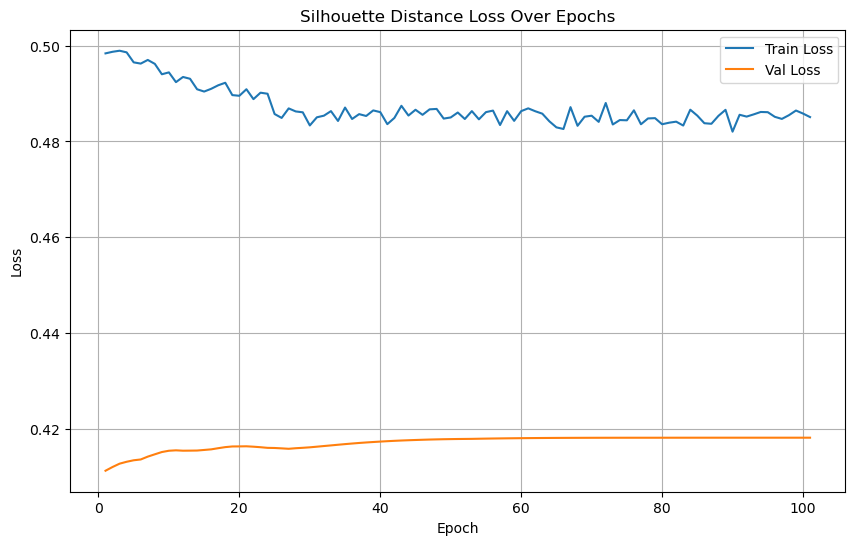

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/154], Loss: 0.3163
Test Batch [20/154], Loss: 0.3530
Test Batch [30/154], Loss: 0.4130


Test Batch [40/154], Loss: 0.3354
Test Batch [50/154], Loss: 0.4326
Test Batch [60/154], Loss: 0.4308
Test Batch [70/154], Loss: 0.2763


Test Batch [80/154], Loss: 0.2715
Test Batch [90/154], Loss: 0.2916
Test Batch [100/154], Loss: 0.2446
Test Batch [110/154], Loss: 0.2259
Test Batch [120/154], Loss: 0.1796
Test Batch [130/154], Loss: 0.3872


Test Batch [140/154], Loss: 0.4743
Test Batch [150/154], Loss: 0.3694

Test Loss: 0.3440


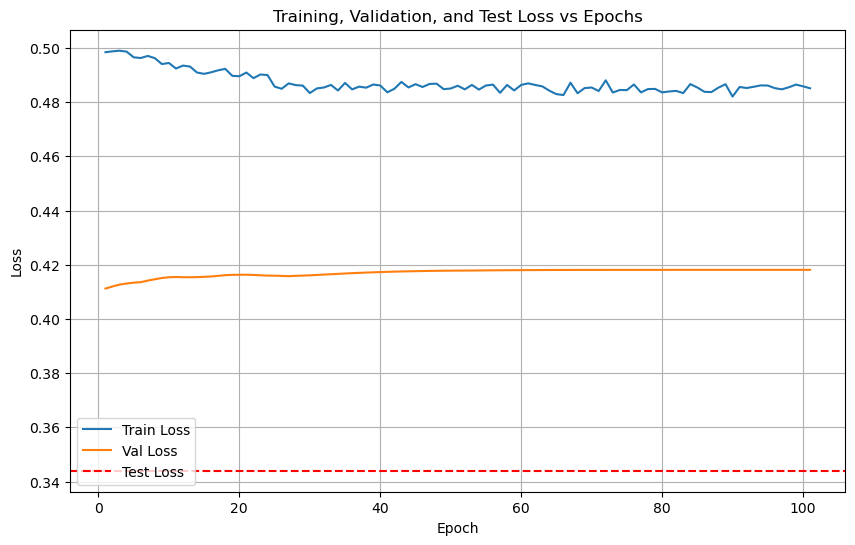

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...
  Processed batch 10/154 for test dataset.
  Processed batch 20/154 for test dataset.


  Processed batch 30/154 for test dataset.
  Processed batch 40/154 for test dataset.
  Processed batch 50/154 for test dataset.


  Processed batch 60/154 for test dataset.
  Processed batch 70/154 for test dataset.
  Processed batch 80/154 for test dataset.


  Processed batch 90/154 for test dataset.
  Processed batch 100/154 for test dataset.
  Processed batch 110/154 for test dataset.
  Processed batch 120/154 for test dataset.


  Processed batch 130/154 for test dataset.
  Processed batch 140/154 for test dataset.
  Processed batch 150/154 for test dataset.
Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (320, 128)
Train labels shape: (320,)
Val reps shape: (75, 128)
Val labels shape: (75,)
Test reps shape: (9854, 128)
Test labels shape: (9854,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 64.00%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.33      0.40      0.36         5
           2       0.00      0.00      0.00         5
           3       0.50      0.40      0.44         5
           4       1.00      0.60      0.75         5
           5       0.50      0.40      0.44         5
           6       0.83      1.00      0.91         5
           7       1.00      1.00      1.00         5
           8       0.00      0.00      0.00         0
           9       0.50      0.80      0.62         5
          10       0.00      0.00      0.00         5
          11       0.50      0.60      0.55         5
          12       0.71      1.00      0.83         5
          13       0.8

C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_clas

## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (320, 128)
Train labels shape: (320,)
Val reps shape: (75, 128)
Val labels shape: (75,)
Test reps shape: (9854, 128)
Test labels shape: (9854,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.7870  |  Val Loss: 2.8029
Validation loss improved from inf to 2.8029.
[Epoch 2/1000] Train Loss: 2.7776  |  Val Loss: 2.7942
Validation loss improved from 2.8029 to 2.7942.
[Epoch 3/1000] Train Loss: 2.7684  |  Val Loss: 2.7865
Validation loss improved from 2.7942 to 2.7865.
[Epoch 4/1000] Train Loss: 2.7601  |  Val Loss: 2.7794
Validation loss improved from 2.7865 to 2.7794.
[Epoch 5/1000] Train Loss: 2.7523  |  Val Loss: 2.7726
Validation loss improved from 2.7794 to 2.7726.
[Epoch 6/1000] Train Loss: 2.7448  |  Val Loss: 2.7661
Validation loss improved from 2.7726 to 2.7661.
[Epoch 7/1000] Train Loss: 2.7372  |  Val Loss: 2.7597
Validation loss improved from 2.7661 to 2.7597.


[Epoch 8/1000] Train Loss: 2.7300  |  Val Loss: 2.7533
Validation loss improved from 2.7597 to 2.7533.
[Epoch 9/1000] Train Loss: 2.7225  |  Val Loss: 2.7469
Validation loss improved from 2.7533 to 2.7469.
[Epoch 10/1000] Train Loss: 2.7153  |  Val Loss: 2.7404
Validation loss improved from 2.7469 to 2.7404.
[Epoch 11/1000] Train Loss: 2.7076  |  Val Loss: 2.7343
Validation loss improved from 2.7404 to 2.7343.
[Epoch 12/1000] Train Loss: 2.7002  |  Val Loss: 2.7278
Validation loss improved from 2.7343 to 2.7278.
[Epoch 13/1000] Train Loss: 2.6926  |  Val Loss: 2.7214
Validation loss improved from 2.7278 to 2.7214.
[Epoch 14/1000] Train Loss: 2.6853  |  Val Loss: 2.7150
Validation loss improved from 2.7214 to 2.7150.
[Epoch 15/1000] Train Loss: 2.6772  |  Val Loss: 2.7087
Validation loss improved from 2.7150 to 2.7087.
[Epoch 16/1000] Train Loss: 2.6695  |  Val Loss: 2.7022
Validation loss improved from 2.7087 to 2.7022.
[Epoch 17/1000] Train Loss: 2.6619  |  Val Loss: 2.6956
Validation

[Epoch 18/1000] Train Loss: 2.6538  |  Val Loss: 2.6891
Validation loss improved from 2.6956 to 2.6891.
[Epoch 19/1000] Train Loss: 2.6455  |  Val Loss: 2.6825
Validation loss improved from 2.6891 to 2.6825.
[Epoch 20/1000] Train Loss: 2.6371  |  Val Loss: 2.6759
Validation loss improved from 2.6825 to 2.6759.
[Epoch 21/1000] Train Loss: 2.6284  |  Val Loss: 2.6690
Validation loss improved from 2.6759 to 2.6690.
[Epoch 22/1000] Train Loss: 2.6192  |  Val Loss: 2.6618
Validation loss improved from 2.6690 to 2.6618.
[Epoch 23/1000] Train Loss: 2.6103  |  Val Loss: 2.6544
Validation loss improved from 2.6618 to 2.6544.
[Epoch 24/1000] Train Loss: 2.6008  |  Val Loss: 2.6465
Validation loss improved from 2.6544 to 2.6465.
[Epoch 25/1000] Train Loss: 2.5906  |  Val Loss: 2.6389
Validation loss improved from 2.6465 to 2.6389.
[Epoch 26/1000] Train Loss: 2.5805  |  Val Loss: 2.6308
Validation loss improved from 2.6389 to 2.6308.
[Epoch 27/1000] Train Loss: 2.5696  |  Val Loss: 2.6220
Validati

[Epoch 28/1000] Train Loss: 2.5586  |  Val Loss: 2.6127
Validation loss improved from 2.6220 to 2.6127.
[Epoch 29/1000] Train Loss: 2.5470  |  Val Loss: 2.6031
Validation loss improved from 2.6127 to 2.6031.
[Epoch 30/1000] Train Loss: 2.5350  |  Val Loss: 2.5930
Validation loss improved from 2.6031 to 2.5930.
[Epoch 31/1000] Train Loss: 2.5229  |  Val Loss: 2.5821
Validation loss improved from 2.5930 to 2.5821.
[Epoch 32/1000] Train Loss: 2.5100  |  Val Loss: 2.5709
Validation loss improved from 2.5821 to 2.5709.
[Epoch 33/1000] Train Loss: 2.4969  |  Val Loss: 2.5593
Validation loss improved from 2.5709 to 2.5593.
[Epoch 34/1000] Train Loss: 2.4832  |  Val Loss: 2.5469
Validation loss improved from 2.5593 to 2.5469.
[Epoch 35/1000] Train Loss: 2.4687  |  Val Loss: 2.5341
Validation loss improved from 2.5469 to 2.5341.
[Epoch 36/1000] Train Loss: 2.4537  |  Val Loss: 2.5204
Validation loss improved from 2.5341 to 2.5204.


[Epoch 37/1000] Train Loss: 2.4383  |  Val Loss: 2.5063
Validation loss improved from 2.5204 to 2.5063.
[Epoch 38/1000] Train Loss: 2.4220  |  Val Loss: 2.4920
Validation loss improved from 2.5063 to 2.4920.
[Epoch 39/1000] Train Loss: 2.4053  |  Val Loss: 2.4774
Validation loss improved from 2.4920 to 2.4774.
[Epoch 40/1000] Train Loss: 2.3880  |  Val Loss: 2.4625
Validation loss improved from 2.4774 to 2.4625.
[Epoch 41/1000] Train Loss: 2.3706  |  Val Loss: 2.4473
Validation loss improved from 2.4625 to 2.4473.
[Epoch 42/1000] Train Loss: 2.3527  |  Val Loss: 2.4319
Validation loss improved from 2.4473 to 2.4319.
[Epoch 43/1000] Train Loss: 2.3345  |  Val Loss: 2.4164
Validation loss improved from 2.4319 to 2.4164.
[Epoch 44/1000] Train Loss: 2.3157  |  Val Loss: 2.4004
Validation loss improved from 2.4164 to 2.4004.
[Epoch 45/1000] Train Loss: 2.2968  |  Val Loss: 2.3849
Validation loss improved from 2.4004 to 2.3849.
[Epoch 46/1000] Train Loss: 2.2781  |  Val Loss: 2.3689
Validati

[Epoch 48/1000] Train Loss: 2.2404  |  Val Loss: 2.3373
Validation loss improved from 2.3532 to 2.3373.
[Epoch 49/1000] Train Loss: 2.2214  |  Val Loss: 2.3213
Validation loss improved from 2.3373 to 2.3213.
[Epoch 50/1000] Train Loss: 2.2024  |  Val Loss: 2.3053
Validation loss improved from 2.3213 to 2.3053.
[Epoch 51/1000] Train Loss: 2.1840  |  Val Loss: 2.2890
Validation loss improved from 2.3053 to 2.2890.
[Epoch 52/1000] Train Loss: 2.1654  |  Val Loss: 2.2724
Validation loss improved from 2.2890 to 2.2724.
[Epoch 53/1000] Train Loss: 2.1465  |  Val Loss: 2.2565
Validation loss improved from 2.2724 to 2.2565.
[Epoch 54/1000] Train Loss: 2.1286  |  Val Loss: 2.2400
Validation loss improved from 2.2565 to 2.2400.
[Epoch 55/1000] Train Loss: 2.1099  |  Val Loss: 2.2245
Validation loss improved from 2.2400 to 2.2245.


[Epoch 56/1000] Train Loss: 2.0917  |  Val Loss: 2.2089
Validation loss improved from 2.2245 to 2.2089.
[Epoch 57/1000] Train Loss: 2.0740  |  Val Loss: 2.1935
Validation loss improved from 2.2089 to 2.1935.
[Epoch 58/1000] Train Loss: 2.0564  |  Val Loss: 2.1779
Validation loss improved from 2.1935 to 2.1779.
[Epoch 59/1000] Train Loss: 2.0389  |  Val Loss: 2.1624
Validation loss improved from 2.1779 to 2.1624.
[Epoch 60/1000] Train Loss: 2.0213  |  Val Loss: 2.1467
Validation loss improved from 2.1624 to 2.1467.
[Epoch 61/1000] Train Loss: 2.0039  |  Val Loss: 2.1320
Validation loss improved from 2.1467 to 2.1320.
[Epoch 62/1000] Train Loss: 1.9867  |  Val Loss: 2.1169
Validation loss improved from 2.1320 to 2.1169.
[Epoch 63/1000] Train Loss: 1.9701  |  Val Loss: 2.1019
Validation loss improved from 2.1169 to 2.1019.
[Epoch 64/1000] Train Loss: 1.9530  |  Val Loss: 2.0870
Validation loss improved from 2.1019 to 2.0870.
[Epoch 65/1000] Train Loss: 1.9359  |  Val Loss: 2.0727
Validati

[Epoch 67/1000] Train Loss: 1.9030  |  Val Loss: 2.0440
Validation loss improved from 2.0583 to 2.0440.
[Epoch 68/1000] Train Loss: 1.8870  |  Val Loss: 2.0306
Validation loss improved from 2.0440 to 2.0306.
[Epoch 69/1000] Train Loss: 1.8703  |  Val Loss: 2.0172
Validation loss improved from 2.0306 to 2.0172.
[Epoch 70/1000] Train Loss: 1.8545  |  Val Loss: 2.0039
Validation loss improved from 2.0172 to 2.0039.
[Epoch 71/1000] Train Loss: 1.8387  |  Val Loss: 1.9905
Validation loss improved from 2.0039 to 1.9905.
[Epoch 72/1000] Train Loss: 1.8230  |  Val Loss: 1.9775
Validation loss improved from 1.9905 to 1.9775.
[Epoch 73/1000] Train Loss: 1.8073  |  Val Loss: 1.9644
Validation loss improved from 1.9775 to 1.9644.
[Epoch 74/1000] Train Loss: 1.7919  |  Val Loss: 1.9515
Validation loss improved from 1.9644 to 1.9515.
[Epoch 75/1000] Train Loss: 1.7766  |  Val Loss: 1.9382
Validation loss improved from 1.9515 to 1.9382.


[Epoch 76/1000] Train Loss: 1.7614  |  Val Loss: 1.9256
Validation loss improved from 1.9382 to 1.9256.
[Epoch 77/1000] Train Loss: 1.7468  |  Val Loss: 1.9131
Validation loss improved from 1.9256 to 1.9131.
[Epoch 78/1000] Train Loss: 1.7317  |  Val Loss: 1.9002
Validation loss improved from 1.9131 to 1.9002.
[Epoch 79/1000] Train Loss: 1.7171  |  Val Loss: 1.8877
Validation loss improved from 1.9002 to 1.8877.
[Epoch 80/1000] Train Loss: 1.7024  |  Val Loss: 1.8753
Validation loss improved from 1.8877 to 1.8753.
[Epoch 81/1000] Train Loss: 1.6880  |  Val Loss: 1.8635
Validation loss improved from 1.8753 to 1.8635.
[Epoch 82/1000] Train Loss: 1.6733  |  Val Loss: 1.8519
Validation loss improved from 1.8635 to 1.8519.
[Epoch 83/1000] Train Loss: 1.6594  |  Val Loss: 1.8400
Validation loss improved from 1.8519 to 1.8400.
[Epoch 84/1000] Train Loss: 1.6450  |  Val Loss: 1.8286
Validation loss improved from 1.8400 to 1.8286.


[Epoch 85/1000] Train Loss: 1.6314  |  Val Loss: 1.8175
Validation loss improved from 1.8286 to 1.8175.
[Epoch 86/1000] Train Loss: 1.6180  |  Val Loss: 1.8064
Validation loss improved from 1.8175 to 1.8064.
[Epoch 87/1000] Train Loss: 1.6045  |  Val Loss: 1.7952
Validation loss improved from 1.8064 to 1.7952.
[Epoch 88/1000] Train Loss: 1.5914  |  Val Loss: 1.7848
Validation loss improved from 1.7952 to 1.7848.
[Epoch 89/1000] Train Loss: 1.5780  |  Val Loss: 1.7742
Validation loss improved from 1.7848 to 1.7742.
[Epoch 90/1000] Train Loss: 1.5654  |  Val Loss: 1.7630
Validation loss improved from 1.7742 to 1.7630.
[Epoch 91/1000] Train Loss: 1.5523  |  Val Loss: 1.7523
Validation loss improved from 1.7630 to 1.7523.
[Epoch 92/1000] Train Loss: 1.5399  |  Val Loss: 1.7421
Validation loss improved from 1.7523 to 1.7421.
[Epoch 93/1000] Train Loss: 1.5271  |  Val Loss: 1.7315
Validation loss improved from 1.7421 to 1.7315.
[Epoch 94/1000] Train Loss: 1.5146  |  Val Loss: 1.7214
Validati

[Epoch 95/1000] Train Loss: 1.5024  |  Val Loss: 1.7114
Validation loss improved from 1.7214 to 1.7114.
[Epoch 96/1000] Train Loss: 1.4904  |  Val Loss: 1.7015
Validation loss improved from 1.7114 to 1.7015.
[Epoch 97/1000] Train Loss: 1.4786  |  Val Loss: 1.6917
Validation loss improved from 1.7015 to 1.6917.
[Epoch 98/1000] Train Loss: 1.4668  |  Val Loss: 1.6817
Validation loss improved from 1.6917 to 1.6817.
[Epoch 99/1000] Train Loss: 1.4553  |  Val Loss: 1.6718
Validation loss improved from 1.6817 to 1.6718.
[Epoch 100/1000] Train Loss: 1.4435  |  Val Loss: 1.6617
Validation loss improved from 1.6718 to 1.6617.
[Epoch 101/1000] Train Loss: 1.4321  |  Val Loss: 1.6530
Validation loss improved from 1.6617 to 1.6530.
[Epoch 102/1000] Train Loss: 1.4210  |  Val Loss: 1.6439
Validation loss improved from 1.6530 to 1.6439.
[Epoch 103/1000] Train Loss: 1.4099  |  Val Loss: 1.6343
Validation loss improved from 1.6439 to 1.6343.
[Epoch 104/1000] Train Loss: 1.3988  |  Val Loss: 1.6250
Val

[Epoch 105/1000] Train Loss: 1.3883  |  Val Loss: 1.6161
Validation loss improved from 1.6250 to 1.6161.
[Epoch 106/1000] Train Loss: 1.3776  |  Val Loss: 1.6078
Validation loss improved from 1.6161 to 1.6078.
[Epoch 107/1000] Train Loss: 1.3670  |  Val Loss: 1.5993
Validation loss improved from 1.6078 to 1.5993.
[Epoch 108/1000] Train Loss: 1.3570  |  Val Loss: 1.5895
Validation loss improved from 1.5993 to 1.5895.
[Epoch 109/1000] Train Loss: 1.3467  |  Val Loss: 1.5808
Validation loss improved from 1.5895 to 1.5808.
[Epoch 110/1000] Train Loss: 1.3366  |  Val Loss: 1.5726
Validation loss improved from 1.5808 to 1.5726.
[Epoch 111/1000] Train Loss: 1.3269  |  Val Loss: 1.5644
Validation loss improved from 1.5726 to 1.5644.
[Epoch 112/1000] Train Loss: 1.3171  |  Val Loss: 1.5564
Validation loss improved from 1.5644 to 1.5564.
[Epoch 113/1000] Train Loss: 1.3075  |  Val Loss: 1.5490
Validation loss improved from 1.5564 to 1.5490.
[Epoch 114/1000] Train Loss: 1.2977  |  Val Loss: 1.541

[Epoch 115/1000] Train Loss: 1.2888  |  Val Loss: 1.5335
Validation loss improved from 1.5414 to 1.5335.
[Epoch 116/1000] Train Loss: 1.2792  |  Val Loss: 1.5262
Validation loss improved from 1.5335 to 1.5262.
[Epoch 117/1000] Train Loss: 1.2701  |  Val Loss: 1.5186
Validation loss improved from 1.5262 to 1.5186.
[Epoch 118/1000] Train Loss: 1.2607  |  Val Loss: 1.5113
Validation loss improved from 1.5186 to 1.5113.
[Epoch 119/1000] Train Loss: 1.2516  |  Val Loss: 1.5040
Validation loss improved from 1.5113 to 1.5040.
[Epoch 120/1000] Train Loss: 1.2430  |  Val Loss: 1.4966
Validation loss improved from 1.5040 to 1.4966.
[Epoch 121/1000] Train Loss: 1.2337  |  Val Loss: 1.4900
Validation loss improved from 1.4966 to 1.4900.
[Epoch 122/1000] Train Loss: 1.2245  |  Val Loss: 1.4829
Validation loss improved from 1.4900 to 1.4829.
[Epoch 123/1000] Train Loss: 1.2156  |  Val Loss: 1.4760
Validation loss improved from 1.4829 to 1.4760.


[Epoch 124/1000] Train Loss: 1.2071  |  Val Loss: 1.4690
Validation loss improved from 1.4760 to 1.4690.
[Epoch 125/1000] Train Loss: 1.1990  |  Val Loss: 1.4622
Validation loss improved from 1.4690 to 1.4622.
[Epoch 126/1000] Train Loss: 1.1905  |  Val Loss: 1.4562
Validation loss improved from 1.4622 to 1.4562.
[Epoch 127/1000] Train Loss: 1.1820  |  Val Loss: 1.4493
Validation loss improved from 1.4562 to 1.4493.
[Epoch 128/1000] Train Loss: 1.1739  |  Val Loss: 1.4427
Validation loss improved from 1.4493 to 1.4427.
[Epoch 129/1000] Train Loss: 1.1658  |  Val Loss: 1.4366
Validation loss improved from 1.4427 to 1.4366.
[Epoch 130/1000] Train Loss: 1.1574  |  Val Loss: 1.4310
Validation loss improved from 1.4366 to 1.4310.
[Epoch 131/1000] Train Loss: 1.1496  |  Val Loss: 1.4251
Validation loss improved from 1.4310 to 1.4251.
[Epoch 132/1000] Train Loss: 1.1415  |  Val Loss: 1.4189
Validation loss improved from 1.4251 to 1.4189.
[Epoch 133/1000] Train Loss: 1.1342  |  Val Loss: 1.413

[Epoch 135/1000] Train Loss: 1.1194  |  Val Loss: 1.4026
Validation loss improved from 1.4081 to 1.4026.
[Epoch 136/1000] Train Loss: 1.1114  |  Val Loss: 1.3969
Validation loss improved from 1.4026 to 1.3969.
[Epoch 137/1000] Train Loss: 1.1040  |  Val Loss: 1.3913
Validation loss improved from 1.3969 to 1.3913.
[Epoch 138/1000] Train Loss: 1.0968  |  Val Loss: 1.3857
Validation loss improved from 1.3913 to 1.3857.
[Epoch 139/1000] Train Loss: 1.0897  |  Val Loss: 1.3802
Validation loss improved from 1.3857 to 1.3802.
[Epoch 140/1000] Train Loss: 1.0826  |  Val Loss: 1.3749
Validation loss improved from 1.3802 to 1.3749.
[Epoch 141/1000] Train Loss: 1.0758  |  Val Loss: 1.3702
Validation loss improved from 1.3749 to 1.3702.
[Epoch 142/1000] Train Loss: 1.0688  |  Val Loss: 1.3654
Validation loss improved from 1.3702 to 1.3654.


[Epoch 143/1000] Train Loss: 1.0621  |  Val Loss: 1.3599
Validation loss improved from 1.3654 to 1.3599.
[Epoch 144/1000] Train Loss: 1.0554  |  Val Loss: 1.3557
Validation loss improved from 1.3599 to 1.3557.
[Epoch 145/1000] Train Loss: 1.0491  |  Val Loss: 1.3510
Validation loss improved from 1.3557 to 1.3510.
[Epoch 146/1000] Train Loss: 1.0425  |  Val Loss: 1.3465
Validation loss improved from 1.3510 to 1.3465.
[Epoch 147/1000] Train Loss: 1.0366  |  Val Loss: 1.3414
Validation loss improved from 1.3465 to 1.3414.
[Epoch 148/1000] Train Loss: 1.0303  |  Val Loss: 1.3369
Validation loss improved from 1.3414 to 1.3369.
[Epoch 149/1000] Train Loss: 1.0253  |  Val Loss: 1.3328
Validation loss improved from 1.3369 to 1.3328.
[Epoch 150/1000] Train Loss: 1.0183  |  Val Loss: 1.3281
Validation loss improved from 1.3328 to 1.3281.
[Epoch 151/1000] Train Loss: 1.0122  |  Val Loss: 1.3240
Validation loss improved from 1.3281 to 1.3240.
[Epoch 152/1000] Train Loss: 1.0065  |  Val Loss: 1.319

[Epoch 154/1000] Train Loss: 0.9948  |  Val Loss: 1.3118
Validation loss improved from 1.3155 to 1.3118.
[Epoch 155/1000] Train Loss: 0.9892  |  Val Loss: 1.3080
Validation loss improved from 1.3118 to 1.3080.
[Epoch 156/1000] Train Loss: 0.9838  |  Val Loss: 1.3035
Validation loss improved from 1.3080 to 1.3035.
[Epoch 157/1000] Train Loss: 0.9779  |  Val Loss: 1.3000
Validation loss improved from 1.3035 to 1.3000.
[Epoch 158/1000] Train Loss: 0.9727  |  Val Loss: 1.2967
Validation loss improved from 1.3000 to 1.2967.
[Epoch 159/1000] Train Loss: 0.9676  |  Val Loss: 1.2934
Validation loss improved from 1.2967 to 1.2934.
[Epoch 160/1000] Train Loss: 0.9625  |  Val Loss: 1.2895
Validation loss improved from 1.2934 to 1.2895.
[Epoch 161/1000] Train Loss: 0.9571  |  Val Loss: 1.2855
Validation loss improved from 1.2895 to 1.2855.
[Epoch 162/1000] Train Loss: 0.9525  |  Val Loss: 1.2824
Validation loss improved from 1.2855 to 1.2824.


[Epoch 163/1000] Train Loss: 0.9469  |  Val Loss: 1.2792
Validation loss improved from 1.2824 to 1.2792.
[Epoch 164/1000] Train Loss: 0.9422  |  Val Loss: 1.2750
Validation loss improved from 1.2792 to 1.2750.
[Epoch 165/1000] Train Loss: 0.9368  |  Val Loss: 1.2717
Validation loss improved from 1.2750 to 1.2717.
[Epoch 166/1000] Train Loss: 0.9325  |  Val Loss: 1.2685
Validation loss improved from 1.2717 to 1.2685.
[Epoch 167/1000] Train Loss: 0.9276  |  Val Loss: 1.2655
Validation loss improved from 1.2685 to 1.2655.
[Epoch 168/1000] Train Loss: 0.9225  |  Val Loss: 1.2627
Validation loss improved from 1.2655 to 1.2627.
[Epoch 169/1000] Train Loss: 0.9180  |  Val Loss: 1.2597
Validation loss improved from 1.2627 to 1.2597.
[Epoch 170/1000] Train Loss: 0.9135  |  Val Loss: 1.2569
Validation loss improved from 1.2597 to 1.2569.
[Epoch 171/1000] Train Loss: 0.9086  |  Val Loss: 1.2539
Validation loss improved from 1.2569 to 1.2539.
[Epoch 172/1000] Train Loss: 0.9041  |  Val Loss: 1.250

[Epoch 174/1000] Train Loss: 0.8957  |  Val Loss: 1.2452
Validation loss improved from 1.2472 to 1.2452.
[Epoch 175/1000] Train Loss: 0.8908  |  Val Loss: 1.2427
Validation loss improved from 1.2452 to 1.2427.
[Epoch 176/1000] Train Loss: 0.8869  |  Val Loss: 1.2397
Validation loss improved from 1.2427 to 1.2397.
[Epoch 177/1000] Train Loss: 0.8827  |  Val Loss: 1.2369
Validation loss improved from 1.2397 to 1.2369.
[Epoch 178/1000] Train Loss: 0.8784  |  Val Loss: 1.2338
Validation loss improved from 1.2369 to 1.2338.
[Epoch 179/1000] Train Loss: 0.8740  |  Val Loss: 1.2310
Validation loss improved from 1.2338 to 1.2310.
[Epoch 180/1000] Train Loss: 0.8701  |  Val Loss: 1.2282
Validation loss improved from 1.2310 to 1.2282.
[Epoch 181/1000] Train Loss: 0.8660  |  Val Loss: 1.2268
Validation loss improved from 1.2282 to 1.2268.
[Epoch 182/1000] Train Loss: 0.8620  |  Val Loss: 1.2240
Validation loss improved from 1.2268 to 1.2240.
[Epoch 183/1000] Train Loss: 0.8582  |  Val Loss: 1.220

[Epoch 184/1000] Train Loss: 0.8540  |  Val Loss: 1.2195
Validation loss improved from 1.2208 to 1.2195.
[Epoch 185/1000] Train Loss: 0.8499  |  Val Loss: 1.2168
Validation loss improved from 1.2195 to 1.2168.
[Epoch 186/1000] Train Loss: 0.8462  |  Val Loss: 1.2137
Validation loss improved from 1.2168 to 1.2137.
[Epoch 187/1000] Train Loss: 0.8425  |  Val Loss: 1.2107
Validation loss improved from 1.2137 to 1.2107.
[Epoch 188/1000] Train Loss: 0.8387  |  Val Loss: 1.2087
Validation loss improved from 1.2107 to 1.2087.
[Epoch 189/1000] Train Loss: 0.8351  |  Val Loss: 1.2069
Validation loss improved from 1.2087 to 1.2069.
[Epoch 190/1000] Train Loss: 0.8312  |  Val Loss: 1.2049
Validation loss improved from 1.2069 to 1.2049.
[Epoch 191/1000] Train Loss: 0.8276  |  Val Loss: 1.2019
Validation loss improved from 1.2049 to 1.2019.
[Epoch 192/1000] Train Loss: 0.8240  |  Val Loss: 1.1992
Validation loss improved from 1.2019 to 1.1992.
[Epoch 193/1000] Train Loss: 0.8202  |  Val Loss: 1.197

[Epoch 195/1000] Train Loss: 0.8131  |  Val Loss: 1.1936
Validation loss improved from 1.1950 to 1.1936.
[Epoch 196/1000] Train Loss: 0.8099  |  Val Loss: 1.1918
Validation loss improved from 1.1936 to 1.1918.
[Epoch 197/1000] Train Loss: 0.8062  |  Val Loss: 1.1903
Validation loss improved from 1.1918 to 1.1903.
[Epoch 198/1000] Train Loss: 0.8027  |  Val Loss: 1.1876
Validation loss improved from 1.1903 to 1.1876.
[Epoch 199/1000] Train Loss: 0.7997  |  Val Loss: 1.1860
Validation loss improved from 1.1876 to 1.1860.
[Epoch 200/1000] Train Loss: 0.7961  |  Val Loss: 1.1833
Validation loss improved from 1.1860 to 1.1833.
[Epoch 201/1000] Train Loss: 0.7927  |  Val Loss: 1.1813
Validation loss improved from 1.1833 to 1.1813.
[Epoch 202/1000] Train Loss: 0.7896  |  Val Loss: 1.1785
Validation loss improved from 1.1813 to 1.1785.
[Epoch 203/1000] Train Loss: 0.7860  |  Val Loss: 1.1773
Validation loss improved from 1.1785 to 1.1773.


[Epoch 204/1000] Train Loss: 0.7830  |  Val Loss: 1.1754
Validation loss improved from 1.1773 to 1.1754.
[Epoch 205/1000] Train Loss: 0.7796  |  Val Loss: 1.1735
Validation loss improved from 1.1754 to 1.1735.
[Epoch 206/1000] Train Loss: 0.7765  |  Val Loss: 1.1717
Validation loss improved from 1.1735 to 1.1717.
[Epoch 207/1000] Train Loss: 0.7731  |  Val Loss: 1.1694
Validation loss improved from 1.1717 to 1.1694.
[Epoch 208/1000] Train Loss: 0.7705  |  Val Loss: 1.1673
Validation loss improved from 1.1694 to 1.1673.
[Epoch 209/1000] Train Loss: 0.7671  |  Val Loss: 1.1652
Validation loss improved from 1.1673 to 1.1652.
[Epoch 210/1000] Train Loss: 0.7638  |  Val Loss: 1.1640
Validation loss improved from 1.1652 to 1.1640.
[Epoch 211/1000] Train Loss: 0.7608  |  Val Loss: 1.1617
Validation loss improved from 1.1640 to 1.1617.
[Epoch 212/1000] Train Loss: 0.7579  |  Val Loss: 1.1608
Validation loss improved from 1.1617 to 1.1608.


[Epoch 213/1000] Train Loss: 0.7551  |  Val Loss: 1.1593
Validation loss improved from 1.1608 to 1.1593.
[Epoch 214/1000] Train Loss: 0.7519  |  Val Loss: 1.1576
Validation loss improved from 1.1593 to 1.1576.
[Epoch 215/1000] Train Loss: 0.7492  |  Val Loss: 1.1555
Validation loss improved from 1.1576 to 1.1555.
[Epoch 216/1000] Train Loss: 0.7467  |  Val Loss: 1.1538
Validation loss improved from 1.1555 to 1.1538.
[Epoch 217/1000] Train Loss: 0.7433  |  Val Loss: 1.1514
Validation loss improved from 1.1538 to 1.1514.
[Epoch 218/1000] Train Loss: 0.7408  |  Val Loss: 1.1498
Validation loss improved from 1.1514 to 1.1498.
[Epoch 219/1000] Train Loss: 0.7374  |  Val Loss: 1.1486
Validation loss improved from 1.1498 to 1.1486.
[Epoch 220/1000] Train Loss: 0.7349  |  Val Loss: 1.1477
Validation loss improved from 1.1486 to 1.1477.
[Epoch 221/1000] Train Loss: 0.7319  |  Val Loss: 1.1467
Validation loss improved from 1.1477 to 1.1467.
[Epoch 222/1000] Train Loss: 0.7295  |  Val Loss: 1.145

[Epoch 223/1000] Train Loss: 0.7264  |  Val Loss: 1.1437
Validation loss improved from 1.1451 to 1.1437.
[Epoch 224/1000] Train Loss: 0.7242  |  Val Loss: 1.1423
Validation loss improved from 1.1437 to 1.1423.
[Epoch 225/1000] Train Loss: 0.7208  |  Val Loss: 1.1405
Validation loss improved from 1.1423 to 1.1405.
[Epoch 226/1000] Train Loss: 0.7183  |  Val Loss: 1.1388
Validation loss improved from 1.1405 to 1.1388.
[Epoch 227/1000] Train Loss: 0.7153  |  Val Loss: 1.1378
Validation loss improved from 1.1388 to 1.1378.
[Epoch 228/1000] Train Loss: 0.7132  |  Val Loss: 1.1357
Validation loss improved from 1.1378 to 1.1357.
[Epoch 229/1000] Train Loss: 0.7106  |  Val Loss: 1.1354
Validation loss improved from 1.1357 to 1.1354.
[Epoch 230/1000] Train Loss: 0.7082  |  Val Loss: 1.1335
Validation loss improved from 1.1354 to 1.1335.
[Epoch 231/1000] Train Loss: 0.7049  |  Val Loss: 1.1323
Validation loss improved from 1.1335 to 1.1323.


[Epoch 232/1000] Train Loss: 0.7023  |  Val Loss: 1.1306
Validation loss improved from 1.1323 to 1.1306.
[Epoch 233/1000] Train Loss: 0.7000  |  Val Loss: 1.1282
Validation loss improved from 1.1306 to 1.1282.
[Epoch 234/1000] Train Loss: 0.6976  |  Val Loss: 1.1268
Validation loss improved from 1.1282 to 1.1268.
[Epoch 235/1000] Train Loss: 0.6947  |  Val Loss: 1.1256
Validation loss improved from 1.1268 to 1.1256.
[Epoch 236/1000] Train Loss: 0.6922  |  Val Loss: 1.1245
Validation loss improved from 1.1256 to 1.1245.
[Epoch 237/1000] Train Loss: 0.6898  |  Val Loss: 1.1231
Validation loss improved from 1.1245 to 1.1231.
[Epoch 238/1000] Train Loss: 0.6873  |  Val Loss: 1.1215
Validation loss improved from 1.1231 to 1.1215.
[Epoch 239/1000] Train Loss: 0.6849  |  Val Loss: 1.1193
Validation loss improved from 1.1215 to 1.1193.
[Epoch 240/1000] Train Loss: 0.6821  |  Val Loss: 1.1180
Validation loss improved from 1.1193 to 1.1180.
[Epoch 241/1000] Train Loss: 0.6797  |  Val Loss: 1.116

[Epoch 242/1000] Train Loss: 0.6775  |  Val Loss: 1.1155
Validation loss improved from 1.1167 to 1.1155.
[Epoch 243/1000] Train Loss: 0.6756  |  Val Loss: 1.1149
Validation loss improved from 1.1155 to 1.1149.
[Epoch 244/1000] Train Loss: 0.6728  |  Val Loss: 1.1136
Validation loss improved from 1.1149 to 1.1136.
[Epoch 245/1000] Train Loss: 0.6700  |  Val Loss: 1.1120
Validation loss improved from 1.1136 to 1.1120.
[Epoch 246/1000] Train Loss: 0.6677  |  Val Loss: 1.1105
Validation loss improved from 1.1120 to 1.1105.
[Epoch 247/1000] Train Loss: 0.6656  |  Val Loss: 1.1087
Validation loss improved from 1.1105 to 1.1087.
[Epoch 248/1000] Train Loss: 0.6631  |  Val Loss: 1.1087
Validation loss improved from 1.1087 to 1.1087.
[Epoch 249/1000] Train Loss: 0.6612  |  Val Loss: 1.1067
Validation loss improved from 1.1087 to 1.1067.
[Epoch 250/1000] Train Loss: 0.6588  |  Val Loss: 1.1058
Validation loss improved from 1.1067 to 1.1058.
[Epoch 251/1000] Train Loss: 0.6561  |  Val Loss: 1.104

[Epoch 252/1000] Train Loss: 0.6540  |  Val Loss: 1.1027
Validation loss improved from 1.1049 to 1.1027.
[Epoch 253/1000] Train Loss: 0.6517  |  Val Loss: 1.1016
Validation loss improved from 1.1027 to 1.1016.
[Epoch 254/1000] Train Loss: 0.6494  |  Val Loss: 1.1017
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 255/1000] Train Loss: 0.6476  |  Val Loss: 1.1007
Validation loss improved from 1.1016 to 1.1007.
[Epoch 256/1000] Train Loss: 0.6453  |  Val Loss: 1.0996
Validation loss improved from 1.1007 to 1.0996.
[Epoch 257/1000] Train Loss: 0.6429  |  Val Loss: 1.0973
Validation loss improved from 1.0996 to 1.0973.
[Epoch 258/1000] Train Loss: 0.6406  |  Val Loss: 1.0969
Validation loss improved from 1.0973 to 1.0969.
[Epoch 259/1000] Train Loss: 0.6385  |  Val Loss: 1.0957
Validation loss improved from 1.0969 to 1.0957.
[Epoch 260/1000] Train Loss: 0.6365  |  Val Loss: 1.0951
Validation loss improved from 1.0957 to 1.0951.
[Epoch 261/1000] Train Loss: 0.6345  |  Val Loss:

[Epoch 262/1000] Train Loss: 0.6322  |  Val Loss: 1.0914
Validation loss improved from 1.0934 to 1.0914.
[Epoch 263/1000] Train Loss: 0.6305  |  Val Loss: 1.0914
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 264/1000] Train Loss: 0.6285  |  Val Loss: 1.0909
Validation loss improved from 1.0914 to 1.0909.
[Epoch 265/1000] Train Loss: 0.6265  |  Val Loss: 1.0888
Validation loss improved from 1.0909 to 1.0888.
[Epoch 266/1000] Train Loss: 0.6242  |  Val Loss: 1.0875
Validation loss improved from 1.0888 to 1.0875.
[Epoch 267/1000] Train Loss: 0.6219  |  Val Loss: 1.0871
Validation loss improved from 1.0875 to 1.0871.
[Epoch 268/1000] Train Loss: 0.6201  |  Val Loss: 1.0864
Validation loss improved from 1.0871 to 1.0864.
[Epoch 269/1000] Train Loss: 0.6179  |  Val Loss: 1.0855
Validation loss improved from 1.0864 to 1.0855.
[Epoch 270/1000] Train Loss: 0.6159  |  Val Loss: 1.0843
Validation loss improved from 1.0855 to 1.0843.


[Epoch 271/1000] Train Loss: 0.6139  |  Val Loss: 1.0835
Validation loss improved from 1.0843 to 1.0835.
[Epoch 272/1000] Train Loss: 0.6119  |  Val Loss: 1.0814
Validation loss improved from 1.0835 to 1.0814.
[Epoch 273/1000] Train Loss: 0.6102  |  Val Loss: 1.0803
Validation loss improved from 1.0814 to 1.0803.
[Epoch 274/1000] Train Loss: 0.6082  |  Val Loss: 1.0794
Validation loss improved from 1.0803 to 1.0794.
[Epoch 275/1000] Train Loss: 0.6065  |  Val Loss: 1.0771
Validation loss improved from 1.0794 to 1.0771.
[Epoch 276/1000] Train Loss: 0.6043  |  Val Loss: 1.0782
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 277/1000] Train Loss: 0.6020  |  Val Loss: 1.0774
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 278/1000] Train Loss: 0.6003  |  Val Loss: 1.0756
Validation loss improved from 1.0771 to 1.0756.
[Epoch 279/1000] Train Loss: 0.5984  |  Val Loss: 1.0748
Validation loss improved from 1.0756 to 1.0748.
[Epoch 280/1000] Train Loss: 0.5969  |  Val

[Epoch 281/1000] Train Loss: 0.5949  |  Val Loss: 1.0722
Validation loss improved from 1.0734 to 1.0722.
[Epoch 282/1000] Train Loss: 0.5927  |  Val Loss: 1.0725
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 283/1000] Train Loss: 0.5907  |  Val Loss: 1.0718
Validation loss improved from 1.0722 to 1.0718.
[Epoch 284/1000] Train Loss: 0.5887  |  Val Loss: 1.0707
Validation loss improved from 1.0718 to 1.0707.
[Epoch 285/1000] Train Loss: 0.5871  |  Val Loss: 1.0687
Validation loss improved from 1.0707 to 1.0687.
[Epoch 286/1000] Train Loss: 0.5847  |  Val Loss: 1.0680
Validation loss improved from 1.0687 to 1.0680.
[Epoch 287/1000] Train Loss: 0.5832  |  Val Loss: 1.0680
Validation loss improved from 1.0680 to 1.0680.
[Epoch 288/1000] Train Loss: 0.5811  |  Val Loss: 1.0671
Validation loss improved from 1.0680 to 1.0671.
[Epoch 289/1000] Train Loss: 0.5794  |  Val Loss: 1.0659
Validation loss improved from 1.0671 to 1.0659.
[Epoch 290/1000] Train Loss: 0.5774  |  Val Loss:

[Epoch 291/1000] Train Loss: 0.5753  |  Val Loss: 1.0639
Validation loss improved from 1.0649 to 1.0639.
[Epoch 292/1000] Train Loss: 0.5736  |  Val Loss: 1.0623
Validation loss improved from 1.0639 to 1.0623.
[Epoch 293/1000] Train Loss: 0.5719  |  Val Loss: 1.0610
Validation loss improved from 1.0623 to 1.0610.
[Epoch 294/1000] Train Loss: 0.5703  |  Val Loss: 1.0599
Validation loss improved from 1.0610 to 1.0599.
[Epoch 295/1000] Train Loss: 0.5686  |  Val Loss: 1.0585
Validation loss improved from 1.0599 to 1.0585.
[Epoch 296/1000] Train Loss: 0.5663  |  Val Loss: 1.0573
Validation loss improved from 1.0585 to 1.0573.
[Epoch 297/1000] Train Loss: 0.5652  |  Val Loss: 1.0580
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 298/1000] Train Loss: 0.5626  |  Val Loss: 1.0562
Validation loss improved from 1.0573 to 1.0562.


[Epoch 299/1000] Train Loss: 0.5615  |  Val Loss: 1.0548
Validation loss improved from 1.0562 to 1.0548.
[Epoch 300/1000] Train Loss: 0.5591  |  Val Loss: 1.0544
Validation loss improved from 1.0548 to 1.0544.
[Epoch 301/1000] Train Loss: 0.5573  |  Val Loss: 1.0534
Validation loss improved from 1.0544 to 1.0534.
[Epoch 302/1000] Train Loss: 0.5558  |  Val Loss: 1.0523
Validation loss improved from 1.0534 to 1.0523.
[Epoch 303/1000] Train Loss: 0.5538  |  Val Loss: 1.0521
Validation loss improved from 1.0523 to 1.0521.
[Epoch 304/1000] Train Loss: 0.5520  |  Val Loss: 1.0519
Validation loss improved from 1.0521 to 1.0519.
[Epoch 305/1000] Train Loss: 0.5506  |  Val Loss: 1.0509
Validation loss improved from 1.0519 to 1.0509.
[Epoch 306/1000] Train Loss: 0.5486  |  Val Loss: 1.0507
Validation loss improved from 1.0509 to 1.0507.


[Epoch 307/1000] Train Loss: 0.5466  |  Val Loss: 1.0488
Validation loss improved from 1.0507 to 1.0488.
[Epoch 308/1000] Train Loss: 0.5453  |  Val Loss: 1.0469
Validation loss improved from 1.0488 to 1.0469.
[Epoch 309/1000] Train Loss: 0.5440  |  Val Loss: 1.0487
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 310/1000] Train Loss: 0.5422  |  Val Loss: 1.0483
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 311/1000] Train Loss: 0.5401  |  Val Loss: 1.0471
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 312/1000] Train Loss: 0.5383  |  Val Loss: 1.0470
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 313/1000] Train Loss: 0.5371  |  Val Loss: 1.0452
Validation loss improved from 1.0469 to 1.0452.
[Epoch 314/1000] Train Loss: 0.5350  |  Val Loss: 1.0438
Validation loss improved from 1.0452 to 1.0438.
[Epoch 315/1000] Train Loss: 0.5334  |  Val Loss: 1.0443
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 316/1000] Train Loss: 0.5319  |  Val Loss: 1.0447
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 317/1000] Train Loss: 0.5304  |  Val Loss: 1.0435
Validation loss improved from 1.0438 to 1.0435.
[Epoch 318/1000] Train Loss: 0.5287  |  Val Loss: 1.0420
Validation loss improved from 1.0435 to 1.0420.
[Epoch 319/1000] Train Loss: 0.5269  |  Val Loss: 1.0421
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 320/1000] Train Loss: 0.5256  |  Val Loss: 1.0411
Validation loss improved from 1.0420 to 1.0411.
[Epoch 321/1000] Train Loss: 0.5240  |  Val Loss: 1.0406
Validation loss improved from 1.0411 to 1.0406.
[Epoch 322/1000] Train Loss: 0.5223  |  Val Loss: 1.0406
Validation loss improved from 1.0406 to 1.0406.
[Epoch 323/1000] Train Loss: 0.5208  |  Val Loss: 1.0400
Validation loss improved from 1.0406 to 1.0400.
[Epoch 324/1000] Train Loss: 0.5195  |  Val Loss: 1.0388
Validation loss improved from 1.0400 to 1.0388.
[Epoch 325/1000] Train Loss: 0.5180  |  Val

[Epoch 326/1000] Train Loss: 0.5160  |  Val Loss: 1.0373
Validation loss improved from 1.0383 to 1.0373.
[Epoch 327/1000] Train Loss: 0.5146  |  Val Loss: 1.0376
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 328/1000] Train Loss: 0.5132  |  Val Loss: 1.0370
Validation loss improved from 1.0373 to 1.0370.
[Epoch 329/1000] Train Loss: 0.5120  |  Val Loss: 1.0362
Validation loss improved from 1.0370 to 1.0362.
[Epoch 330/1000] Train Loss: 0.5102  |  Val Loss: 1.0362
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 331/1000] Train Loss: 0.5091  |  Val Loss: 1.0368
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 332/1000] Train Loss: 0.5074  |  Val Loss: 1.0349
Validation loss improved from 1.0362 to 1.0349.
[Epoch 333/1000] Train Loss: 0.5055  |  Val Loss: 1.0340
Validation loss improved from 1.0349 to 1.0340.


[Epoch 334/1000] Train Loss: 0.5041  |  Val Loss: 1.0339
Validation loss improved from 1.0340 to 1.0339.
[Epoch 335/1000] Train Loss: 0.5027  |  Val Loss: 1.0333
Validation loss improved from 1.0339 to 1.0333.
[Epoch 336/1000] Train Loss: 0.5018  |  Val Loss: 1.0334
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 337/1000] Train Loss: 0.4997  |  Val Loss: 1.0330
Validation loss improved from 1.0333 to 1.0330.
[Epoch 338/1000] Train Loss: 0.4982  |  Val Loss: 1.0328
Validation loss improved from 1.0330 to 1.0328.
[Epoch 339/1000] Train Loss: 0.4967  |  Val Loss: 1.0319
Validation loss improved from 1.0328 to 1.0319.
[Epoch 340/1000] Train Loss: 0.4956  |  Val Loss: 1.0304
Validation loss improved from 1.0319 to 1.0304.
[Epoch 341/1000] Train Loss: 0.4945  |  Val Loss: 1.0286
Validation loss improved from 1.0304 to 1.0286.
[Epoch 342/1000] Train Loss: 0.4924  |  Val Loss: 1.0305
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 343/1000] Train Loss: 0.4910  |  Val

[Epoch 345/1000] Train Loss: 0.4883  |  Val Loss: 1.0304
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 346/1000] Train Loss: 0.4869  |  Val Loss: 1.0288
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 347/1000] Train Loss: 0.4858  |  Val Loss: 1.0297
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 348/1000] Train Loss: 0.4844  |  Val Loss: 1.0287
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 349/1000] Train Loss: 0.4835  |  Val Loss: 1.0266
Validation loss improved from 1.0286 to 1.0266.
[Epoch 350/1000] Train Loss: 0.4812  |  Val Loss: 1.0259
Validation loss improved from 1.0266 to 1.0259.
[Epoch 351/1000] Train Loss: 0.4798  |  Val Loss: 1.0268
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 352/1000] Train Loss: 0.4790  |  Val Loss: 1.0265
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 353/1000] Train Loss: 0.4773  |  Val Loss: 1.0259
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 354/10

[Epoch 355/1000] Train Loss: 0.4748  |  Val Loss: 1.0243
Validation loss improved from 1.0259 to 1.0243.
[Epoch 356/1000] Train Loss: 0.4734  |  Val Loss: 1.0236
Validation loss improved from 1.0243 to 1.0236.
[Epoch 357/1000] Train Loss: 0.4718  |  Val Loss: 1.0239
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 358/1000] Train Loss: 0.4710  |  Val Loss: 1.0249
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 359/1000] Train Loss: 0.4693  |  Val Loss: 1.0241
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 360/1000] Train Loss: 0.4678  |  Val Loss: 1.0225
Validation loss improved from 1.0236 to 1.0225.
[Epoch 361/1000] Train Loss: 0.4665  |  Val Loss: 1.0218
Validation loss improved from 1.0225 to 1.0218.
[Epoch 362/1000] Train Loss: 0.4657  |  Val Loss: 1.0226
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 363/1000] Train Loss: 0.4648  |  Val Loss: 1.0231
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 364/1000] Train Lo

[Epoch 365/1000] Train Loss: 0.4615  |  Val Loss: 1.0191
Validation loss improved from 1.0216 to 1.0191.
[Epoch 366/1000] Train Loss: 0.4608  |  Val Loss: 1.0197
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 367/1000] Train Loss: 0.4592  |  Val Loss: 1.0199
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 368/1000] Train Loss: 0.4577  |  Val Loss: 1.0198
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 369/1000] Train Loss: 0.4569  |  Val Loss: 1.0193
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 370/1000] Train Loss: 0.4554  |  Val Loss: 1.0198
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 371/1000] Train Loss: 0.4542  |  Val Loss: 1.0203
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 372/1000] Train Loss: 0.4533  |  Val Loss: 1.0192
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 373/1000] Train Loss: 0.4517  |  Val Loss: 1.0176
Validation loss improved from 1.0191 to 1.0176.
[Epoch 374/10

[Epoch 375/1000] Train Loss: 0.4489  |  Val Loss: 1.0178
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 376/1000] Train Loss: 0.4483  |  Val Loss: 1.0181
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 377/1000] Train Loss: 0.4472  |  Val Loss: 1.0165
Validation loss improved from 1.0172 to 1.0165.
[Epoch 378/1000] Train Loss: 0.4458  |  Val Loss: 1.0156
Validation loss improved from 1.0165 to 1.0156.
[Epoch 379/1000] Train Loss: 0.4444  |  Val Loss: 1.0150
Validation loss improved from 1.0156 to 1.0150.
[Epoch 380/1000] Train Loss: 0.4433  |  Val Loss: 1.0161
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 381/1000] Train Loss: 0.4421  |  Val Loss: 1.0171
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 382/1000] Train Loss: 0.4409  |  Val Loss: 1.0161
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 383/1000] Train Loss: 0.4397  |  Val Loss: 1.0155
!! Validation loss did NOT improve !! Patience: 4/100


[Epoch 384/1000] Train Loss: 0.4387  |  Val Loss: 1.0132
Validation loss improved from 1.0150 to 1.0132.
[Epoch 385/1000] Train Loss: 0.4374  |  Val Loss: 1.0126
Validation loss improved from 1.0132 to 1.0126.
[Epoch 386/1000] Train Loss: 0.4366  |  Val Loss: 1.0123
Validation loss improved from 1.0126 to 1.0123.
[Epoch 387/1000] Train Loss: 0.4358  |  Val Loss: 1.0107
Validation loss improved from 1.0123 to 1.0107.
[Epoch 388/1000] Train Loss: 0.4340  |  Val Loss: 1.0119
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 389/1000] Train Loss: 0.4329  |  Val Loss: 1.0127
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 390/1000] Train Loss: 0.4319  |  Val Loss: 1.0124
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 391/1000] Train Loss: 0.4308  |  Val Loss: 1.0111
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 392/1000] Train Loss: 0.4296  |  Val Loss: 1.0132
!! Validation loss did NOT improve !! Patience: 5/100


[Epoch 393/1000] Train Loss: 0.4278  |  Val Loss: 1.0121
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 394/1000] Train Loss: 0.4271  |  Val Loss: 1.0111
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 395/1000] Train Loss: 0.4259  |  Val Loss: 1.0110
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 396/1000] Train Loss: 0.4247  |  Val Loss: 1.0103
Validation loss improved from 1.0107 to 1.0103.
[Epoch 397/1000] Train Loss: 0.4239  |  Val Loss: 1.0099
Validation loss improved from 1.0103 to 1.0099.
[Epoch 398/1000] Train Loss: 0.4225  |  Val Loss: 1.0092
Validation loss improved from 1.0099 to 1.0092.
[Epoch 399/1000] Train Loss: 0.4217  |  Val Loss: 1.0096
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 400/1000] Train Loss: 0.4207  |  Val Loss: 1.0077
Validation loss improved from 1.0092 to 1.0077.
[Epoch 401/1000] Train Loss: 0.4197  |  Val Loss: 1.0072
Validation loss improved from 1.0077 to 1.0072.


[Epoch 402/1000] Train Loss: 0.4180  |  Val Loss: 1.0083
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 403/1000] Train Loss: 0.4172  |  Val Loss: 1.0073
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 404/1000] Train Loss: 0.4162  |  Val Loss: 1.0077
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 405/1000] Train Loss: 0.4151  |  Val Loss: 1.0075
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 406/1000] Train Loss: 0.4145  |  Val Loss: 1.0069
Validation loss improved from 1.0072 to 1.0069.
[Epoch 407/1000] Train Loss: 0.4134  |  Val Loss: 1.0077
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 408/1000] Train Loss: 0.4119  |  Val Loss: 1.0069
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 409/1000] Train Loss: 0.4109  |  Val Loss: 1.0064
Validation loss improved from 1.0069 to 1.0064.
[Epoch 410/1000] Train Loss: 0.4096  |  Val Loss: 1.0065
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 411/10

[Epoch 412/1000] Train Loss: 0.4080  |  Val Loss: 1.0069
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 413/1000] Train Loss: 0.4064  |  Val Loss: 1.0067
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 414/1000] Train Loss: 0.4055  |  Val Loss: 1.0065
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 415/1000] Train Loss: 0.4047  |  Val Loss: 1.0051
Validation loss improved from 1.0061 to 1.0051.
[Epoch 416/1000] Train Loss: 0.4034  |  Val Loss: 1.0053
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 417/1000] Train Loss: 0.4023  |  Val Loss: 1.0050
Validation loss improved from 1.0051 to 1.0050.
[Epoch 418/1000] Train Loss: 0.4013  |  Val Loss: 1.0044
Validation loss improved from 1.0050 to 1.0044.
[Epoch 419/1000] Train Loss: 0.4007  |  Val Loss: 1.0051
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 420/1000] Train Loss: 0.3997  |  Val Loss: 1.0061
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 421/1000] Tr

[Epoch 422/1000] Train Loss: 0.3977  |  Val Loss: 1.0028
Validation loss improved from 1.0044 to 1.0028.
[Epoch 423/1000] Train Loss: 0.3968  |  Val Loss: 1.0028
Validation loss improved from 1.0028 to 1.0028.
[Epoch 424/1000] Train Loss: 0.3953  |  Val Loss: 1.0036
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 425/1000] Train Loss: 0.3941  |  Val Loss: 1.0033
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 426/1000] Train Loss: 0.3933  |  Val Loss: 1.0041
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 427/1000] Train Loss: 0.3926  |  Val Loss: 1.0042
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 428/1000] Train Loss: 0.3917  |  Val Loss: 1.0035
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 429/1000] Train Loss: 0.3905  |  Val Loss: 1.0029
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 430/1000] Train Loss: 0.3893  |  Val Loss: 1.0032
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 431/10

[Epoch 432/1000] Train Loss: 0.3873  |  Val Loss: 1.0017
Validation loss improved from 1.0027 to 1.0017.
[Epoch 433/1000] Train Loss: 0.3867  |  Val Loss: 1.0029
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 434/1000] Train Loss: 0.3863  |  Val Loss: 1.0018
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 435/1000] Train Loss: 0.3844  |  Val Loss: 1.0014
Validation loss improved from 1.0017 to 1.0014.
[Epoch 436/1000] Train Loss: 0.3840  |  Val Loss: 1.0027
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 437/1000] Train Loss: 0.3828  |  Val Loss: 1.0035
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 438/1000] Train Loss: 0.3817  |  Val Loss: 1.0043
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 439/1000] Train Loss: 0.3809  |  Val Loss: 1.0019
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 440/1000] Train Loss: 0.3795  |  Val Loss: 1.0017
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 441/10

[Epoch 442/1000] Train Loss: 0.3773  |  Val Loss: 1.0024
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 443/1000] Train Loss: 0.3768  |  Val Loss: 1.0021
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 444/1000] Train Loss: 0.3755  |  Val Loss: 1.0016
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 445/1000] Train Loss: 0.3752  |  Val Loss: 1.0025
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 446/1000] Train Loss: 0.3738  |  Val Loss: 1.0027
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 447/1000] Train Loss: 0.3731  |  Val Loss: 1.0033
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 448/1000] Train Loss: 0.3718  |  Val Loss: 1.0005
Validation loss improved from 1.0014 to 1.0005.


[Epoch 449/1000] Train Loss: 0.3713  |  Val Loss: 0.9998
Validation loss improved from 1.0005 to 0.9998.
[Epoch 450/1000] Train Loss: 0.3700  |  Val Loss: 1.0008
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 451/1000] Train Loss: 0.3693  |  Val Loss: 1.0011
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 452/1000] Train Loss: 0.3685  |  Val Loss: 1.0011
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 453/1000] Train Loss: 0.3678  |  Val Loss: 1.0017
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 454/1000] Train Loss: 0.3665  |  Val Loss: 1.0017
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 455/1000] Train Loss: 0.3656  |  Val Loss: 0.9997
Validation loss improved from 0.9998 to 0.9997.
[Epoch 456/1000] Train Loss: 0.3647  |  Val Loss: 1.0005
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 457/1000] Train Loss: 0.3637  |  Val Loss: 0.9995
Validation loss improved from 0.9997 to 0.9995.
[Epoch 458/1000] Tr

[Epoch 461/1000] Train Loss: 0.3602  |  Val Loss: 1.0004
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 462/1000] Train Loss: 0.3592  |  Val Loss: 1.0000
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 463/1000] Train Loss: 0.3585  |  Val Loss: 1.0011
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 464/1000] Train Loss: 0.3578  |  Val Loss: 0.9996
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 465/1000] Train Loss: 0.3566  |  Val Loss: 0.9985
Validation loss improved from 0.9995 to 0.9985.
[Epoch 466/1000] Train Loss: 0.3556  |  Val Loss: 0.9995
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 467/1000] Train Loss: 0.3546  |  Val Loss: 1.0000
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 468/1000] Train Loss: 0.3539  |  Val Loss: 1.0000
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 469/1000] Train Loss: 0.3531  |  Val Loss: 0.9997
!! Validation loss did NOT improve !! Patience: 4/100


[Epoch 470/1000] Train Loss: 0.3523  |  Val Loss: 1.0011
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 471/1000] Train Loss: 0.3513  |  Val Loss: 1.0005
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 472/1000] Train Loss: 0.3508  |  Val Loss: 0.9987
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 473/1000] Train Loss: 0.3498  |  Val Loss: 0.9985
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 474/1000] Train Loss: 0.3488  |  Val Loss: 0.9990
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 475/1000] Train Loss: 0.3482  |  Val Loss: 0.9995
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 476/1000] Train Loss: 0.3477  |  Val Loss: 0.9998
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 477/1000] Train Loss: 0.3466  |  Val Loss: 0.9982
Validation loss improved from 0.9985 to 0.9982.
[Epoch 478/1000] Train Loss: 0.3462  |  Val Loss: 0.9989
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 479/1000] Train Loss: 0.3449  |  Val Loss: 0.9991
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 480/1000] Train Loss: 0.3441  |  Val Loss: 0.9996
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 481/1000] Train Loss: 0.3432  |  Val Loss: 0.9988
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 482/1000] Train Loss: 0.3424  |  Val Loss: 0.9990
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 483/1000] Train Loss: 0.3417  |  Val Loss: 1.0005
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 484/1000] Train Loss: 0.3409  |  Val Loss: 0.9998
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 485/1000] Train Loss: 0.3396  |  Val Loss: 0.9990
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 486/1000] Train Loss: 0.3389  |  Val Loss: 0.9981
Validation loss improved from 0.9982 to 0.9981.
[Epoch 487/1000] Train Loss: 0.3381  |  Val Loss: 0.9983
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 488/1000] Train Loss: 0.3375  |  Val Loss: 1.0016
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 489/1000] Train Loss: 0.3364  |  Val Loss: 1.0008
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 490/1000] Train Loss: 0.3355  |  Val Loss: 0.9990
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 491/1000] Train Loss: 0.3352  |  Val Loss: 0.9987
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 492/1000] Train Loss: 0.3345  |  Val Loss: 0.9986
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 493/1000] Train Loss: 0.3335  |  Val Loss: 0.9993
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 494/1000] Train Loss: 0.3323  |  Val Loss: 0.9996
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 495/1000] Train Loss: 0.3316  |  Val Loss: 1.0007
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 496/1000] Train Loss: 0.3312  |  Val Loss: 1.0017
!! Validation loss did NOT improve !! Patience: 10/100


[Epoch 498/1000] Train Loss: 0.3295  |  Val Loss: 0.9995
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 499/1000] Train Loss: 0.3287  |  Val Loss: 1.0016
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 500/1000] Train Loss: 0.3278  |  Val Loss: 1.0009
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 501/1000] Train Loss: 0.3272  |  Val Loss: 0.9987
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 502/1000] Train Loss: 0.3269  |  Val Loss: 0.9992
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 503/1000] Train Loss: 0.3256  |  Val Loss: 0.9993
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 504/1000] Train Loss: 0.3253  |  Val Loss: 0.9994
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 505/1000] Train Loss: 0.3242  |  Val Loss: 1.0005
!! Validation loss did NOT improve !! Patience: 19/100


[Epoch 506/1000] Train Loss: 0.3231  |  Val Loss: 0.9993
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 507/1000] Train Loss: 0.3226  |  Val Loss: 0.9982
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 508/1000] Train Loss: 0.3218  |  Val Loss: 0.9990
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 509/1000] Train Loss: 0.3211  |  Val Loss: 1.0017
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 510/1000] Train Loss: 0.3202  |  Val Loss: 1.0023
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 511/1000] Train Loss: 0.3199  |  Val Loss: 1.0019
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 512/1000] Train Loss: 0.3187  |  Val Loss: 1.0010
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 513/1000] Train Loss: 0.3181  |  Val Loss: 0.9996
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 514/1000] Train Loss: 0.3176  |  Val Loss: 0.9993
!! Validation loss did NOT improve !! Patience:

[Epoch 518/1000] Train Loss: 0.3145  |  Val Loss: 1.0010
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 519/1000] Train Loss: 0.3137  |  Val Loss: 1.0010
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 520/1000] Train Loss: 0.3139  |  Val Loss: 1.0014
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 521/1000] Train Loss: 0.3122  |  Val Loss: 1.0019
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 522/1000] Train Loss: 0.3115  |  Val Loss: 1.0019
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 523/1000] Train Loss: 0.3107  |  Val Loss: 1.0005
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 524/1000] Train Loss: 0.3101  |  Val Loss: 1.0016
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 525/1000] Train Loss: 0.3091  |  Val Loss: 1.0024
!! Validation loss did NOT improve !! Patience: 39/100


[Epoch 526/1000] Train Loss: 0.3085  |  Val Loss: 1.0013
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 527/1000] Train Loss: 0.3078  |  Val Loss: 1.0018
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 528/1000] Train Loss: 0.3074  |  Val Loss: 1.0029
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 529/1000] Train Loss: 0.3061  |  Val Loss: 1.0035
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 530/1000] Train Loss: 0.3062  |  Val Loss: 1.0039
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 531/1000] Train Loss: 0.3054  |  Val Loss: 1.0012
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 532/1000] Train Loss: 0.3044  |  Val Loss: 1.0014
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 533/1000] Train Loss: 0.3034  |  Val Loss: 1.0026
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 534/1000] Train Loss: 0.3028  |  Val Loss: 1.0044
!! Validation loss did NOT improve !! Patience:

[Epoch 536/1000] Train Loss: 0.3013  |  Val Loss: 1.0040
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 537/1000] Train Loss: 0.3005  |  Val Loss: 1.0035
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 538/1000] Train Loss: 0.3000  |  Val Loss: 1.0029
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 539/1000] Train Loss: 0.2996  |  Val Loss: 1.0042
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 540/1000] Train Loss: 0.2989  |  Val Loss: 1.0041
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 541/1000] Train Loss: 0.2980  |  Val Loss: 1.0046
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 542/1000] Train Loss: 0.2972  |  Val Loss: 1.0043
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 543/1000] Train Loss: 0.2964  |  Val Loss: 1.0027
!! Validation loss did NOT improve !! Patience: 57/100


[Epoch 544/1000] Train Loss: 0.2960  |  Val Loss: 1.0057
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 545/1000] Train Loss: 0.2950  |  Val Loss: 1.0055
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 546/1000] Train Loss: 0.2943  |  Val Loss: 1.0046
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 547/1000] Train Loss: 0.2939  |  Val Loss: 1.0033
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 548/1000] Train Loss: 0.2941  |  Val Loss: 1.0072
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 549/1000] Train Loss: 0.2924  |  Val Loss: 1.0080
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 550/1000] Train Loss: 0.2922  |  Val Loss: 1.0063
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 551/1000] Train Loss: 0.2912  |  Val Loss: 1.0048
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 552/1000] Train Loss: 0.2910  |  Val Loss: 1.0058
!! Validation loss did NOT improve !! Patience:

[Epoch 555/1000] Train Loss: 0.2882  |  Val Loss: 1.0074
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 556/1000] Train Loss: 0.2876  |  Val Loss: 1.0063
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 557/1000] Train Loss: 0.2870  |  Val Loss: 1.0066
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 558/1000] Train Loss: 0.2862  |  Val Loss: 1.0082
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 559/1000] Train Loss: 0.2860  |  Val Loss: 1.0098
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 560/1000] Train Loss: 0.2848  |  Val Loss: 1.0101
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 561/1000] Train Loss: 0.2844  |  Val Loss: 1.0079
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 562/1000] Train Loss: 0.2839  |  Val Loss: 1.0083
!! Validation loss did NOT improve !! Patience: 76/100


[Epoch 563/1000] Train Loss: 0.2829  |  Val Loss: 1.0082
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 564/1000] Train Loss: 0.2824  |  Val Loss: 1.0107
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 565/1000] Train Loss: 0.2822  |  Val Loss: 1.0118
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 566/1000] Train Loss: 0.2809  |  Val Loss: 1.0113
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 567/1000] Train Loss: 0.2804  |  Val Loss: 1.0097
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 568/1000] Train Loss: 0.2799  |  Val Loss: 1.0106
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 569/1000] Train Loss: 0.2790  |  Val Loss: 1.0107
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 570/1000] Train Loss: 0.2785  |  Val Loss: 1.0104
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 571/1000] Train Loss: 0.2778  |  Val Loss: 1.0107
!! Validation loss did NOT improve !! Patience:

[Epoch 573/1000] Train Loss: 0.2770  |  Val Loss: 1.0140
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 574/1000] Train Loss: 0.2761  |  Val Loss: 1.0137
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 575/1000] Train Loss: 0.2753  |  Val Loss: 1.0126
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 576/1000] Train Loss: 0.2748  |  Val Loss: 1.0140
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 577/1000] Train Loss: 0.2738  |  Val Loss: 1.0123
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 578/1000] Train Loss: 0.2736  |  Val Loss: 1.0103
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 579/1000] Train Loss: 0.2727  |  Val Loss: 1.0116
!! Validation loss did NOT improve !! Patience: 93/100


[Epoch 580/1000] Train Loss: 0.2728  |  Val Loss: 1.0149
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 581/1000] Train Loss: 0.2715  |  Val Loss: 1.0148
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 582/1000] Train Loss: 0.2706  |  Val Loss: 1.0140
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 583/1000] Train Loss: 0.2702  |  Val Loss: 1.0135
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 584/1000] Train Loss: 0.2695  |  Val Loss: 1.0141
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 585/1000] Train Loss: 0.2691  |  Val Loss: 1.0133
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 586/1000] Train Loss: 0.2685  |  Val Loss: 1.0152
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 586 !!
No improvement for 100 epochs.


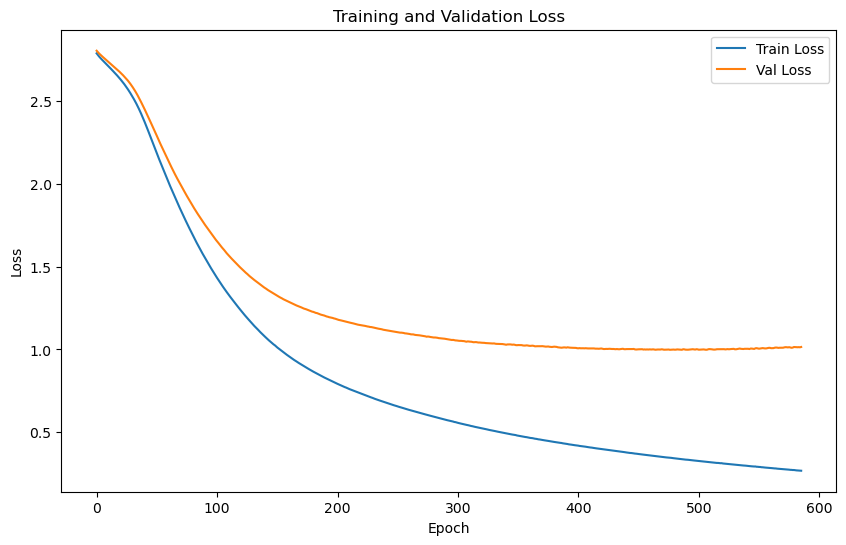

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 1.8521 | Test Accuracy: 52.65%


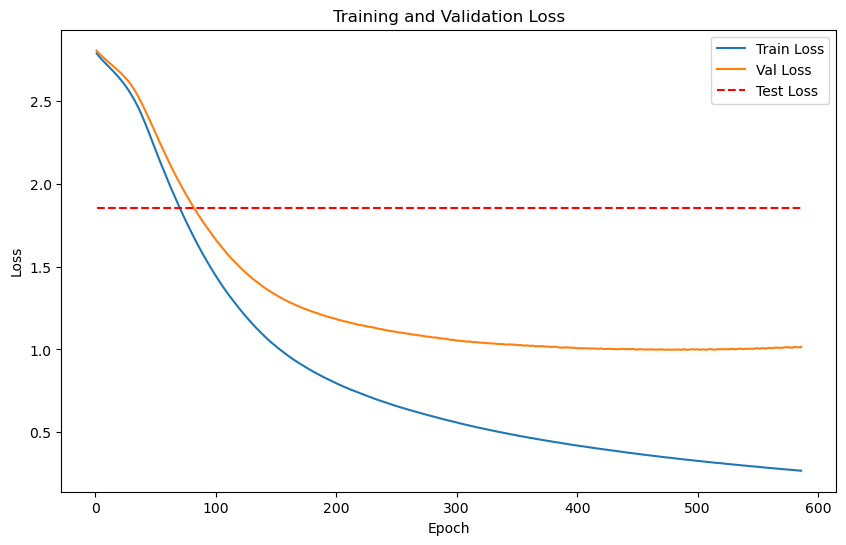

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


C:\Users\vella\AppData\Local\Temp\ipykernel_22516\2424848340.py:18: RuntimeWarning: invalid value encountered in divide
  conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


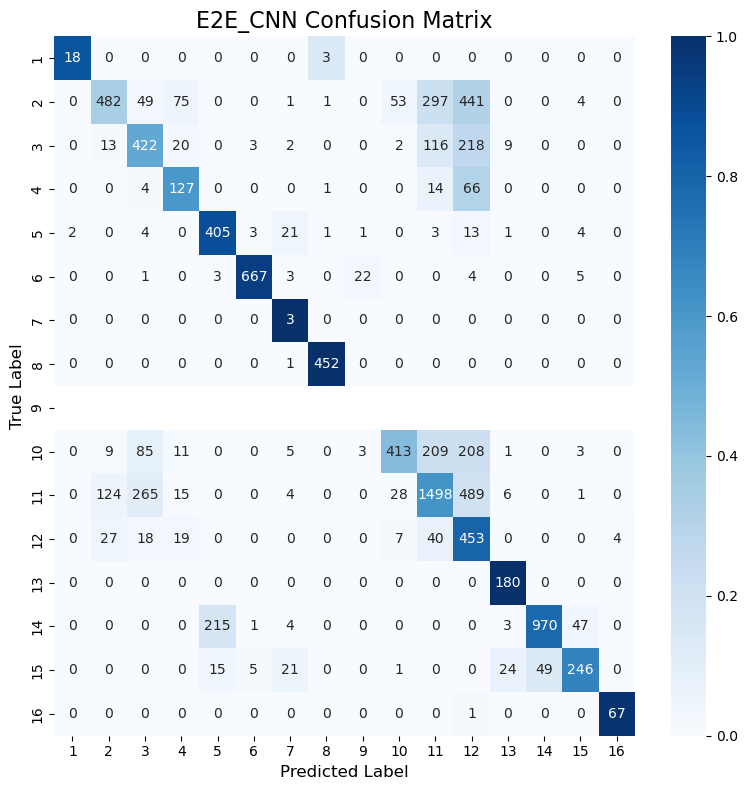

Classification Accuracy: 64.98%


C:\Users\vella\AppData\Local\Temp\ipykernel_22516\2424848340.py:18: RuntimeWarning: invalid value encountered in divide
  conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


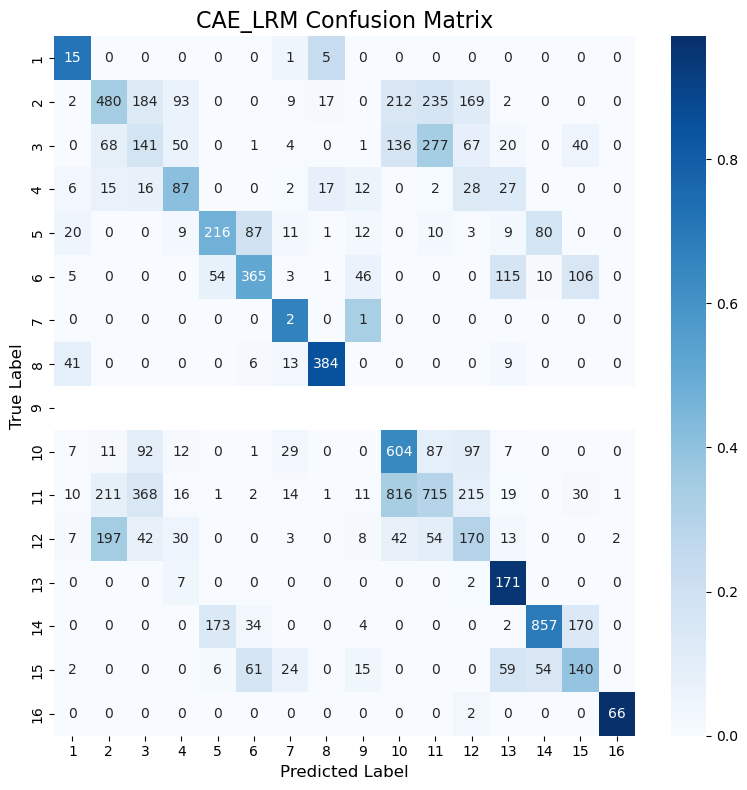

Classification Accuracy: 44.78%


C:\Users\vella\AppData\Local\Temp\ipykernel_22516\2424848340.py:18: RuntimeWarning: invalid value encountered in divide
  conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


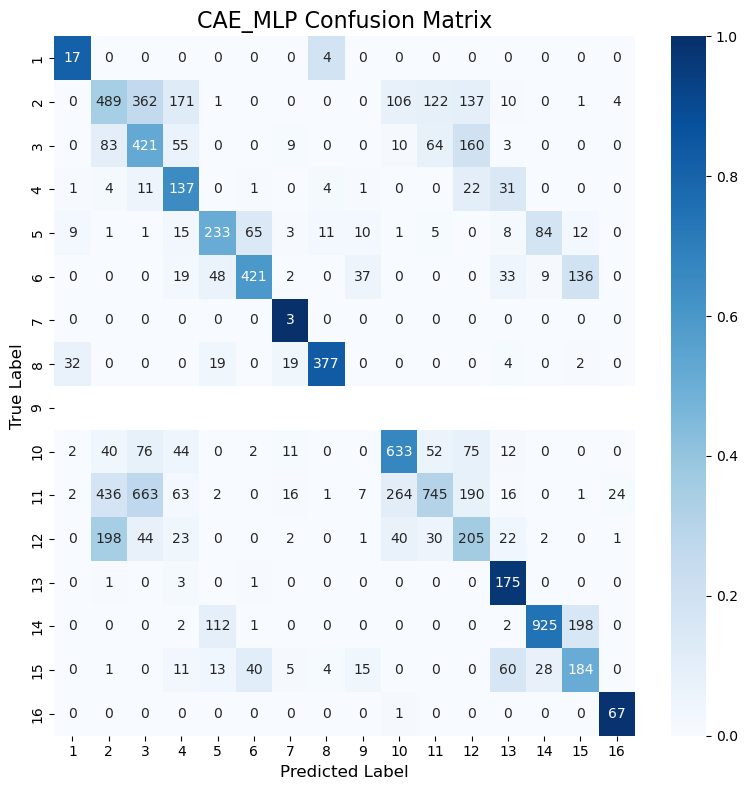

Classification Accuracy: 51.07%


C:\Users\vella\AppData\Local\Temp\ipykernel_22516\2424848340.py:18: RuntimeWarning: invalid value encountered in divide
  conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


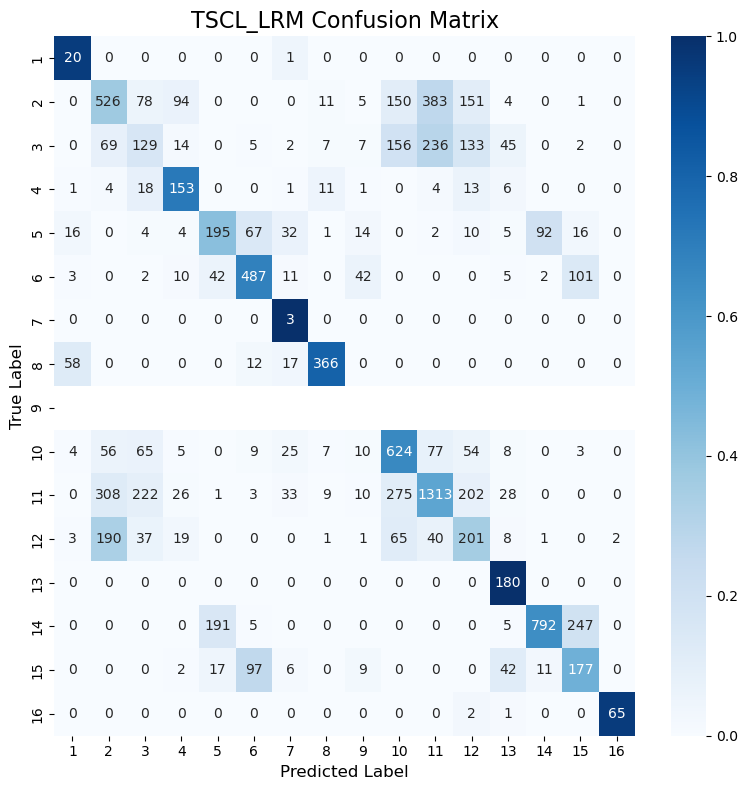

Classification Accuracy: 53.09%


C:\Users\vella\AppData\Local\Temp\ipykernel_22516\2424848340.py:18: RuntimeWarning: invalid value encountered in divide
  conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


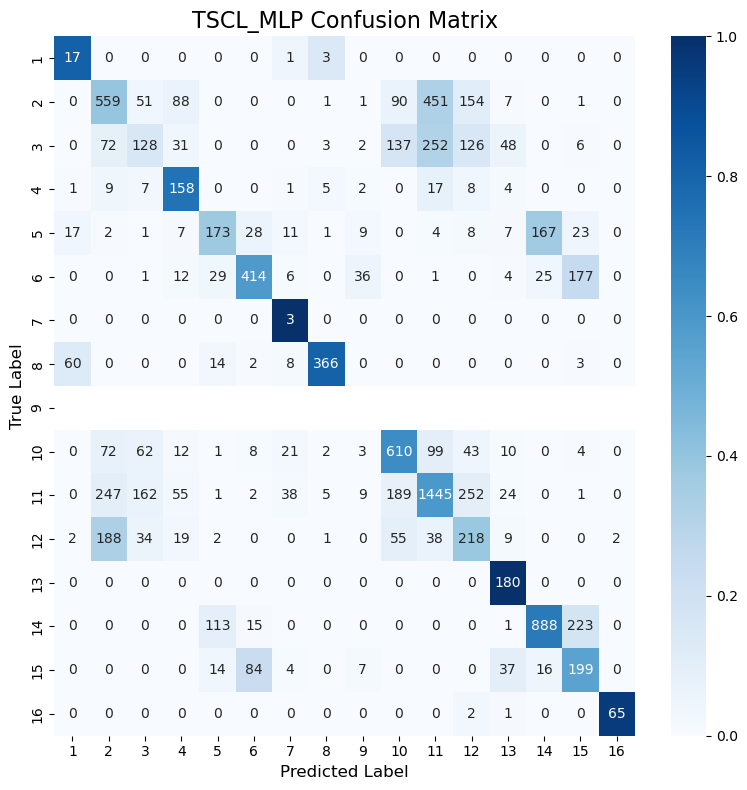

Classification Accuracy: 55.03%


C:\Users\vella\AppData\Local\Temp\ipykernel_22516\2424848340.py:18: RuntimeWarning: invalid value encountered in divide
  conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


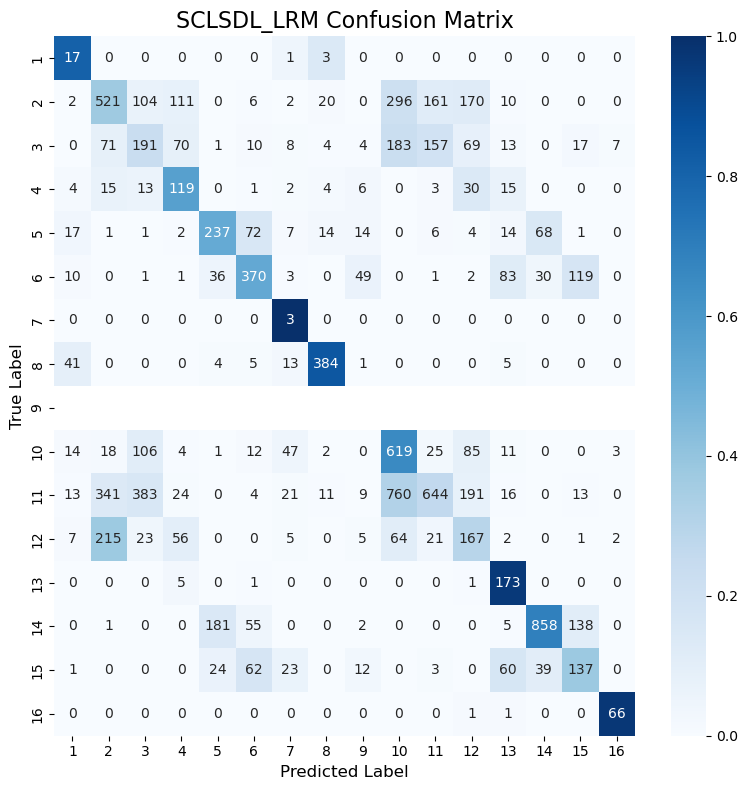

Classification Accuracy: 45.73%


C:\Users\vella\AppData\Local\Temp\ipykernel_22516\2424848340.py:18: RuntimeWarning: invalid value encountered in divide
  conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


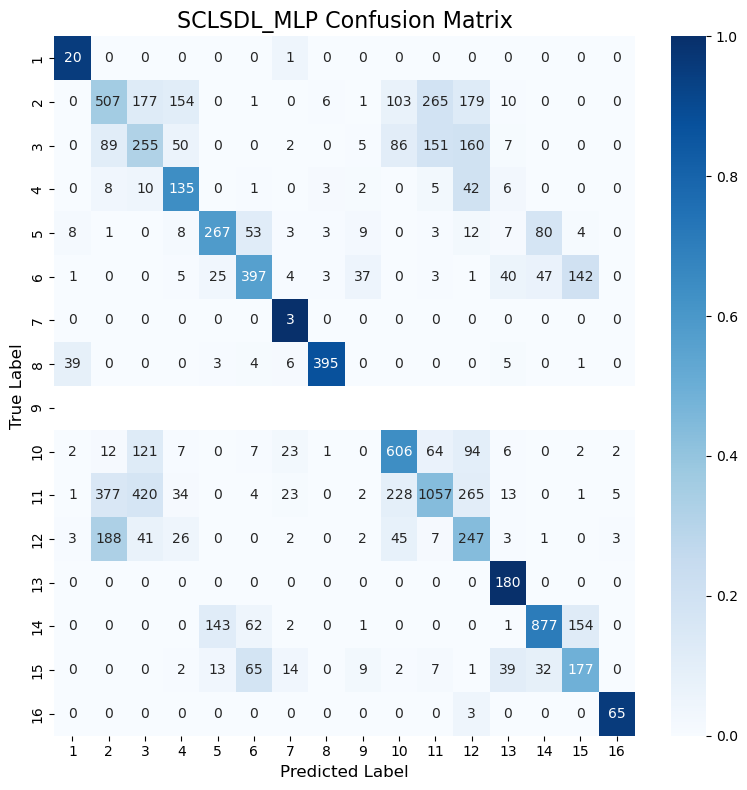

Classification Accuracy: 52.65%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          64.98
1    LRM (CAE)          44.78
2    MLP (CAE)          51.07
3     TSCL LRM          53.09
4     TSCL MLP          55.03
5  SCL_SDL LRM          45.73
6  SCL_SDL MLP          52.65

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          64.98
4     TSCL MLP          55.03
3     TSCL LRM          53.09
6  SCL_SDL MLP          52.65
2    MLP (CAE)          51.07
5  SCL_SDL LRM          45.73
1    LRM (CAE)          44.78
